# Solving Sod Problem with PINN-WE


* This code is modified from the code https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics

* The paper about this code can be reffed to https://www.researchgate.net/publication/359480166_Discontinuity_Computing_with_Physics-Informed_Neural_Network

* For strong shock waves, PINN-WE can let you get a discontinuous result quickly and sharply. But it can not guarantee the result must be physical. You can try to change the random seed or learning rate to get a different result. In the paper, we show the best result of some tests to demonstrate that PINN-WE has the potential ability to handle a non-linear discontinuous problem.

* So physics constraints are needed near shock waves. They are conservation laws, Rankine-Hugoniot relations and entropy condition. We develop a physics screen method here to determinate the problem.


In [120]:
def train(epoch):
#    tocs1 = time.time()
    def closure():
        optimizer.zero_grad()                                                     
        loss_pde = model.loss_pde(x_int_train)                                    
        loss_ic = model.loss_ic(x_ic_train, rho_ic_train,u_ic_train,p_ic_train)   
        
        loss_rh1 = model.loss_rh(x_screen1,x_screen1_R) # RH relation
        #loss_rh2 = model.loss_rh(x_end,x_d) # RH relation along time direction
        loss_s = model.loss_character(x_screen1,x_screen1_L,x_screen1_R, x_screen1_P,x_screen1_PL,x_screen1_PR) # Entropy condition
        loss_con = model.loss_con(x_screen1 ,x_ic_train) #Conservation laws
        loss = loss_pde + 10*loss_ic + 0.1* loss_rh1   +0.1*loss_s   +10*loss_con 
        print(f'epoch {epoch} loss_pde:{loss_pde:.8f},loss_s:{loss_s:.8f},loss_rh:{loss_rh1:.8f}, loss_con:{loss_con:.8f}, loss_ic:{loss_ic:.8f}')
        loss.backward()
        return loss
    loss = optimizer.step(closure)
    return loss

In [123]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
# Seeds
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    #random.seed(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(126)
   
# Calculate gradients using torch.autograd.grad
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

# Initial conditions
def IC(x):
    N=x.shape[0]
    rho_init = np.zeros(N)                                              
    u_init = np.zeros(N)                                                
    p_init = np.zeros(N)                                                

    # rho, p - initial condition
    for i in range(N):
        if (x[i,1] <= 0.5):
            rho_init[i] = 1.0
            p_init[i] = 1.0
        else:
            rho_init[i] = 0.125
            p_init[i] = 0.1

    return rho_init, u_init, p_init

# Generate Neural Network
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))                     
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              

        for num in range(2, 5):                                                     
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))       
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 
        self.net.add_module('Linear_layer_final', nn.Linear(30, 3))                 

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    # Loss function for PDE
    def loss_pde(self, x):
        y = self.net(x)                                                
        rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        
        U2 = rho*u
        U3 = 0.5*rho*u**2 + p/0.4
        
        #F1 = U2
        F2 = rho*u**2+p
        F3 = u*(U3 + p)
        
        gamma = 1.4                                                    

        # Gradients and partial derivatives
        drho_g = gradients(rho, x)[0]                                  
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]             


        du_g = gradients(u, x)[0]                                      
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            

       # dp_g = gradients(p, x)[0]                                     
       # p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                           
        
        dU2_g = gradients(U2, x)[0]
        U2_t,U2_x = dU2_g[:,:1], dU2_g[:,1:]
        dU3_g = gradients(U3, x)[0]
        U3_t,U3_x = dU3_g[:,:1], dU3_g[:,1:]
        dF2_g = gradients(F2, x)[0]
        F2_t,F2_x = dF2_g[:,:1], dF2_g[:,1:]
        dF3_g = gradients(F3, x)[0]
        F3_t,F3_x = dF3_g[:,:1], dF3_g[:,1:]

        d = 0.1*(abs(u_x)-u_x)  + 1
     
        f = (((rho_t + U2_x)/d)**2).mean() + \
            (((U2_t  + F2_x)/d)**2).mean() + \
            (((U3_t  + F3_x)/d)**2).mean() #+\
            #((rho_t).mean())**2 +\
            #((U3_t).mean())**2 
    
        return f

    # Loss function for initial condition
    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)                                                      
        rho_ic_nn, p_ic_nn,u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]            

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean()

        return loss_ics
    
    # Loss function for conservation
    def loss_con(self, x_en,x_in):
        y_en = self.net(x_en)                                       
        y_in = self.net(x_in)                                       
        rhoen, pen,uen = y_en[:, 0], y_en[:, 1], y_en[:, 2]         
        rhoin, pin,uin = y_in[:, 0], y_in[:, 1], y_in[:, 2]         

        U3 = 0.5*rhoen*uen**2 + pen/0.4
        U3in = 0.5*rhoin*uin**2 + pin/0.4
        # Loss function for the initial condition
        loss_en = ((rhoen - rhoin).mean())**2 + \
            ((U3- U3in).mean())**2 +\
            (((1-0.1)*0.2 - rhoen*uen).mean())**2
        return loss_en
    
    # Loss function for RH relation
    def loss_rh(self, x_l,x_r):
        y_r = self.net(x_r)                                    
        y_l = self.net(x_l)                                    
        rhol, pl,ul = y_l[:, 0], y_l[:, 1], y_l[:, 2]          
        rhor, pr,ur = y_r[:, 0], y_r[:, 1], y_r[:, 2]          

        du_g = gradients(ul, x_l)[0]                                      
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            
        d = 1/(0.1*(abs(u_x)-u_x)  + 1)
        eta =  torch.clamp(d-0.1,max=0)
       # eta = 1
        
        loss_rh =  (((pr/pl - (6*rhor-rhol)/(6*rhol-rhor))*(pr-pl)*eta)**2).max()+\
                   ((((ur-ul)**2 -2/rhor*(pr-pl)**2/(0.4*pr+2.4*pl))*eta)**2).max()
        return loss_rh
    
    def loss_character(self, x_l,x_r):
        loss_s = model.loss_character(x_screen1,x_screen1_L,x_screen1_R, x_screen1_P,x_screen1_PL,x_screen1_PR) # Entropy condition
        y_r = self.net(x_r)                                                      # Initial condition
        y_l = self.net(x_l)                                                      # Initial condition
        rhol, pl,ul = y_l[:, 0], y_l[:, 1], y_l[:, 2]            # rho, u, p - initial condition
        rhor, pr,ur = y_r[:, 0], y_r[:, 1], y_r[:, 2]            # rho, u, p - initial condition

        du_g = gradients(ul, x_l)[0]                                      
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            
        d = 1/(0.1*(abs(u_x)-u_x)  + 1)
        eta =  torch.clamp(d-0.1,max=0)
        #eta = 1
        # Loss function for the initial condition
        gamma = 1.4
        ss = 1.0e-10
        cL = torch.sqrt(gamma*abs(pl)/(abs(rhol)+ss))
        cR = torch.sqrt(gamma*abs(pr)/(abs(rhor)+ss))
        sR = torch.max(abs(ul)+cL,abs(ur)+cR)* torch.clamp(abs(rhol-rhor)-0.01,min=0)
        sL = torch.min(-abs(ul)-cL,-abs(ur)-cR)
        
        s = torch.clamp(abs(rhol-rhor)-0.01,min=0)*(abs(rhol*ul - rhor*ur))/(abs(rhol - rhor)+ss)
        if (s.max() > 1000):
            print(rhol-rhor)
            print(s)
        #print(torch.clamp(s-sR,min=0))
       # print(eta)
       # sm = exp(-100*(s-sR))
        loss_s = (((torch.clamp(s-sR,min=0))*eta)**2).max()  #torch.min((((,torch.tensor(1.0))  #+ ((torch.clamp(sL-s,min=0))**2).max()
        return loss_s
    
     def loss_character(self, x,x_l,x_r,xP,xP_L,xP_R):
        #loss_s = model.loss_character(x_screen1,x_screen1_L,x_screen1_R, x_screen1_P,x_screen1_PL,x_screen1_PR) # Entropy condition
        y = self.net(x_r)                                       
        y_r = self.net(x_r)                                     
        y_l = self.net(x_l)                                     
        yp = self,net(xp)
        yp_r = self.net(xP_r)
        yp_l = self.net(xP_l)
        rho, p,u    = y[:, 0], y[:, 1], y[:, 2]           
        rhol, pl,ul = y_l[:, 0], y_l[:, 1], y_l[:, 2]           
        rhor, pr,ur = y_r[:, 0], y_r[:, 1], y_r[:, 2]           

        du_g = gradients(ul, x_l)[0]                                      
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            
        d = 1/(0.1*(abs(u_x)-u_x)  + 1)
        eta =  torch.clamp(d-0.1,max=0)
        #eta = 1
        # Loss function for the initial condition
        gamma = 1.4
        ss = 1.0e-10
        cL = torch.sqrt(gamma*abs(pl)/(abs(rhol)+ss))
        cR = torch.sqrt(gamma*abs(pr)/(abs(rhor)+ss))
        sR = torch.max(abs(ul)+cL,abs(ur)+cR)* torch.clamp(abs(rhol-rhor)-0.01,min=0)
        sL = torch.min(-abs(ul)-cL,-abs(ur)-cR)
        
        s = torch.clamp(abs(rhol-rhor)-0.01,min=0)*(abs(rhol*ul - rhor*ur))/(abs(rhol - rhor)+ss)
        if (s.max() > 1000):
            print(rhol-rhor)
            print(s)
        #print(torch.clamp(s-sR,min=0))
       # print(eta)
       # sm = exp(-100*(s-sR))
        loss_s = (((torch.clamp(s-sR,min=0))*eta)**2).max()  #torch.min((((,torch.tensor(1.0))  #+ ((torch.clamp(sL-s,min=0))**2).max()
        return loss_s
     def loss_character(self, x_l,x_r):
        loss_s = model.loss_character(x_screen1,x_screen1_L,x_screen1_R, x_screen1_P,x_screen1_PL,x_screen1_PR) # Entropy condition
        y_r = self.net(x_r)                                                      # Initial condition
        y_l = self.net(x_l)                                                      # Initial condition
        rhol, pl,ul = y_l[:, 0], y_l[:, 1], y_l[:, 2]            # rho, u, p - initial condition
        rhor, pr,ur = y_r[:, 0], y_r[:, 1], y_r[:, 2]            # rho, u, p - initial condition

        du_g = gradients(ul, x_l)[0]                                      
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            
        d = 1/(0.1*(abs(u_x)-u_x)  + 1)
        eta =  torch.clamp(d-0.1,max=0)
        #eta = 1
        # Loss function for the initial condition
        gamma = 1.4
        ss = 1.0e-10
        cL = torch.sqrt(gamma*abs(pl)/(abs(rhol)+ss))
        cR = torch.sqrt(gamma*abs(pr)/(abs(rhor)+ss))
        sR = torch.max(abs(ul)+cL,abs(ur)+cR)* torch.clamp(abs(rhol-rhor)-0.01,min=0)
        sL = torch.min(-abs(ul)-cL,-abs(ur)-cR)
        
        s = torch.clamp(abs(rhol-rhor)-0.01,min=0)*(abs(rhol*ul - rhor*ur))/(abs(rhol - rhor)+ss)
        if (s.max() > 1000):
            print(rhol-rhor)
            print(s)
        #print(torch.clamp(s-sR,min=0))
       # print(eta)
       # sm = exp(-100*(s-sR))
        loss_s = (((torch.clamp(s-sR,min=0))*eta)**2).max()  #torch.min((((,torch.tensor(1.0))  #+ ((torch.clamp(sL-s,min=0))**2).max()
        return loss_s
    
        
    

def X_entropy(x,T,dt,dx):
    N=x.shape[0]
    xs   = np.zeros((N,2)) 
    xsL  = np.zeros((N,2)) 
    xsR  = np.zeros((N,2)) 
    xsP  = np.zeros((N,2)) 
    xsPL = np.zeros((N,2)) 
    xsPR = np.zeros((N,2)) 
    
    for i in range(N):
        xs[i,1] = x[i,1]
        xs[i,0] = x[i,0] + T
        xsL[i,1] = xs[i,1] - dx
        xsL[i,0] = xs[i,0]
        xsR[i,1] = xs[i,1] + dx
        xsR[i,0] = xsR[i,0]
        xsP[i,0] = xs[i,0] + dt
        xsP[i,1] = xs[i,1]
        xsPL[i,0] = xsP[i,0]
        xsPL[i,1] = xsP[i,1]+ dx
        xsPR[i,0] = xsP[i,0]
        xsPR[i,1] = xsP[i,1]- dx
        
    return xs,xsL,xsR,xsP,xsPL,xsPR

def X_right(x,dx):
    N=x.shape[0]
    xen =np.zeros((N,2)) 
    
    for i in range(N):
        xen[i,1] = x[i,1] + dx
        xen[i,0] = x[i,0] 
    return xen
    
device = torch.device('cuda')         # change to cpu if you dont have a cuda device                              

num_x = 100                                                        
num_t = 200                                                        
L = 1.0
T = 0.2
dt = T/num_t
dx = L/num_x
Tstart = 0
Tend = 0.2
Xstart = 0
Xend = 1.0
x_ic_train, x_int_train = Mesh_Data(num_x,num_t,Tstart,Tend, Xstart,Xend)
rho_ic_train, u_ic_train, p_ic_train = IC(x_ic_train)                    

x_screen1,x_screen1_L,x_screen1_R,x_screen1_P,x_screen1_PL,x_screen1_PR = X_entropy(x_ic_train,0.2,dt,dx)
x_screen2,x_screen2_L,x_screen2_R,x_screen2_P,x_screen2_PL,x_screen2_PR = X_entropy(x_ic_train,0.0,dt,dx)

x_screen1     = torch.tensor(x_screen1, requires_grad=True, dtype=torch.float32).to(device)
x_screen1_L   = torch.tensor(x_screen1_L, dtype=torch.float32).to(device) 
x_screen1_R   = torch.tensor(x_screen1_R, dtype=torch.float32).to(device)
x_screen1_PL  = torch.tensor(x_screen1_PL, dtype=torch.float32).to(device)
x_screen1_PR  = torch.tensor(x_screen1_PR, dtype=torch.float32).to(device)

x_screen2     = torch.tensor(x_screen2, requires_grad=True, dtype=torch.float32).to(device)
x_screen2_L   = torch.tensor(x_screen2_L, dtype=torch.float32).to(device)
x_screen2_R   = torch.tensor(x_screen2_R, dtype=torch.float32).to(device)
x_screen2_PL  = torch.tensor(x_screen2_PL, dtype=torch.float32).to(device)
x_screen2_PR  = torch.tensor(x_screen2_PR, dtype=torch.float32).to(device)

x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)

rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

model = DNN().to(device)

print('Start training...')


lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Start training...


In [124]:
def Mesh_Data(num_x,num_t,Tstart,Tend, Xstart,Xend):

    x_ic = np.zeros((num_x,2))
    x_int = np.zeros((num_x*(num_t-1),2))
    
    x =   np.linspace(0.0, 1.0, num_x) 
    x_ic[:,0] = 0
    x_ic[:,1] = x
    
    dt = (Tend - Tstart)/num_t
    t = np.linspace(dt, 0.2, num_t-1)                                     
    t_grid, x_grid = np.meshgrid(t, x)                                 
    T = t_grid.flatten()[:, None]                                      
    X = x_grid.flatten()[:, None]                                      
    x_int = X[:, 0][:,None]                                        
    t_int = T[:, 0][:,None]                                        
#x_int_train = np.hstack((t_int, x_int))                            

    x_int = np.hstack((t_int, x_int))                            
    
    return x_ic,x_int




In [125]:
epoch = 0
epochi = epoch
lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100000
tic = time.time()
for epoch in range(1+epochi, epochs+epochi):
    loss = train(epoch)
    if loss < 0.02:
        break
toc = time.time()
print(f'Total training time: {toc - tic}')


epoch 1 loss_pde:0.00310989,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.03118317, loss_ic:0.81777185
epoch 2 loss_pde:0.00354480,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.03059452, loss_ic:0.76914108
epoch 3 loss_pde:0.00419232,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.03000912, loss_ic:0.72341228
epoch 4 loss_pde:0.00502988,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.02943893, loss_ic:0.68038833
epoch 5 loss_pde:0.00601813,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.02889034, loss_ic:0.63989460
epoch 6 loss_pde:0.00710996,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.02836110, loss_ic:0.60188574
epoch 7 loss_pde:0.00824802,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.02784335, loss_ic:0.56639564
epoch 8 loss_pde:0.00936880,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.02732662, loss_ic:0.53350556
epoch 9 loss_pde:0.01040540,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.02680036, loss_ic:0.50333959
epoch 10 loss_pde:0.01129383,loss_s:0.00000000

epoch 88 loss_pde:0.28823560,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00580193, loss_ic:0.11060497
epoch 89 loss_pde:0.28779227,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00573805, loss_ic:0.11039829
epoch 90 loss_pde:0.28664407,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00566011, loss_ic:0.11029284
epoch 91 loss_pde:0.28506297,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00557056, loss_ic:0.11026166
epoch 92 loss_pde:0.28328210,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00547903, loss_ic:0.11027324
epoch 93 loss_pde:0.28148621,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00539697, loss_ic:0.11029579
epoch 94 loss_pde:0.27983716,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00533181, loss_ic:0.11030164
epoch 95 loss_pde:0.27848607,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00528435, loss_ic:0.11027150
epoch 96 loss_pde:0.27754024,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00525024, loss_ic:0.11019714
epoch 97 loss_pde:0.27701271,loss_s:0

epoch 172 loss_pde:0.21093404,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00389540, loss_ic:0.10378852
epoch 173 loss_pde:0.20978367,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00387125, loss_ic:0.10370872
epoch 174 loss_pde:0.20863479,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00384692, loss_ic:0.10362799
epoch 175 loss_pde:0.20747554,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00382253, loss_ic:0.10354732
epoch 176 loss_pde:0.20629697,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00379821, loss_ic:0.10346745
epoch 177 loss_pde:0.20509724,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00377380, loss_ic:0.10338870
epoch 178 loss_pde:0.20388010,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00374906, loss_ic:0.10331090
epoch 179 loss_pde:0.20265028,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00372380, loss_ic:0.10323374
epoch 180 loss_pde:0.20140913,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00369808, loss_ic:0.10315697
epoch 181 loss_pde:0.2001546

epoch 258 loss_pde:0.08549637,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00090921, loss_ic:0.09410365
epoch 259 loss_pde:0.08457436,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00088613, loss_ic:0.09387970
epoch 260 loss_pde:0.08368397,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00086390, loss_ic:0.09365287
epoch 261 loss_pde:0.08282495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00084253, loss_ic:0.09342334
epoch 262 loss_pde:0.08199678,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00082199, loss_ic:0.09319124
epoch 263 loss_pde:0.08120018,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00080226, loss_ic:0.09295666
epoch 264 loss_pde:0.08043578,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00078331, loss_ic:0.09271968
epoch 265 loss_pde:0.07970324,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00076513, loss_ic:0.09248046
epoch 266 loss_pde:0.07900238,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00074773, loss_ic:0.09223916
epoch 267 loss_pde:0.0783335

epoch 342 loss_pde:0.07219294,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00022329, loss_ic:0.07332885
epoch 343 loss_pde:0.07227278,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00021631, loss_ic:0.07306592
epoch 344 loss_pde:0.07234265,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00020933, loss_ic:0.07280208
epoch 345 loss_pde:0.07240104,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00020238, loss_ic:0.07253732
epoch 346 loss_pde:0.07244754,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00019546, loss_ic:0.07227159
epoch 347 loss_pde:0.07248166,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00018860, loss_ic:0.07200481
epoch 348 loss_pde:0.07250232,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00018184, loss_ic:0.07173698
epoch 349 loss_pde:0.07251008,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00017516, loss_ic:0.07146794
epoch 350 loss_pde:0.07250419,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00016861, loss_ic:0.07119766
epoch 351 loss_pde:0.0724835

epoch 427 loss_pde:0.06891916,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00025448, loss_ic:0.04900499
epoch 428 loss_pde:0.06927328,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00024031, loss_ic:0.04880356
epoch 429 loss_pde:0.06898142,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00028678, loss_ic:0.04860669
epoch 430 loss_pde:0.06941463,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00024389, loss_ic:0.04840750
epoch 431 loss_pde:0.06921961,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026142, loss_ic:0.04821376
epoch 432 loss_pde:0.06914597,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00027979, loss_ic:0.04802366
epoch 433 loss_pde:0.06962467,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00024285, loss_ic:0.04783226
epoch 434 loss_pde:0.06920683,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00027948, loss_ic:0.04764502
epoch 435 loss_pde:0.06932277,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026430, loss_ic:0.04745753
epoch 436 loss_pde:0.0694628

epoch 504 loss_pde:0.07986347,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00013359, loss_ic:0.03733121
epoch 505 loss_pde:0.08210705,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00055100, loss_ic:0.03728993
epoch 506 loss_pde:0.08422552,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00013574, loss_ic:0.03714317
epoch 507 loss_pde:0.07167189,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00034143, loss_ic:0.03699699
epoch 508 loss_pde:0.06985905,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00027870, loss_ic:0.03688685
epoch 509 loss_pde:0.07855418,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00014835, loss_ic:0.03683230
epoch 510 loss_pde:0.07577360,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00042806, loss_ic:0.03674927
epoch 511 loss_pde:0.07122163,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00018784, loss_ic:0.03658514
epoch 512 loss_pde:0.07357174,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00016467, loss_ic:0.03649312
epoch 513 loss_pde:0.0753267

epoch 589 loss_pde:0.06916130,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026536, loss_ic:0.03186871
epoch 590 loss_pde:0.06907928,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026202, loss_ic:0.03182311
epoch 591 loss_pde:0.06889779,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026725, loss_ic:0.03177869
epoch 592 loss_pde:0.06882113,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026276, loss_ic:0.03173322
epoch 593 loss_pde:0.06866960,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026476, loss_ic:0.03168872
epoch 594 loss_pde:0.06852721,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026597, loss_ic:0.03164420
epoch 595 loss_pde:0.06843982,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026228, loss_ic:0.03159904
epoch 596 loss_pde:0.06826182,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026644, loss_ic:0.03155487
epoch 597 loss_pde:0.06816307,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026328, loss_ic:0.03150994
epoch 598 loss_pde:0.0680176

epoch 671 loss_pde:0.06060859,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00039179, loss_ic:0.02815510
epoch 672 loss_pde:0.06211062,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00017344, loss_ic:0.02809007
epoch 673 loss_pde:0.05667440,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00025472, loss_ic:0.02803339
epoch 674 loss_pde:0.05755541,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00031889, loss_ic:0.02799872
epoch 675 loss_pde:0.06116278,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00017400, loss_ic:0.02796229
epoch 676 loss_pde:0.05693425,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00030201, loss_ic:0.02790338
epoch 677 loss_pde:0.05620068,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00025513, loss_ic:0.02784716
epoch 678 loss_pde:0.05930009,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00017881, loss_ic:0.02780552
epoch 679 loss_pde:0.05722897,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00032061, loss_ic:0.02776351
epoch 680 loss_pde:0.0559478

epoch 754 loss_pde:0.04823763,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00018596, loss_ic:0.02411822
epoch 755 loss_pde:0.04809586,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00019048, loss_ic:0.02406939
epoch 756 loss_pde:0.04804585,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00018425, loss_ic:0.02402216
epoch 757 loss_pde:0.04790255,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00018895, loss_ic:0.02397333
epoch 758 loss_pde:0.04785215,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00018265, loss_ic:0.02392626
epoch 759 loss_pde:0.04770947,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00018725, loss_ic:0.02387758
epoch 760 loss_pde:0.04765934,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00018091, loss_ic:0.02383064
epoch 761 loss_pde:0.04751521,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00018573, loss_ic:0.02378201
epoch 762 loss_pde:0.04746778,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00017898, loss_ic:0.02373539
epoch 763 loss_pde:0.0473177

epoch 834 loss_pde:0.04151149,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00012747, loss_ic:0.02077114
epoch 835 loss_pde:0.04156349,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00011321, loss_ic:0.02073866
epoch 836 loss_pde:0.04138605,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00012648, loss_ic:0.02069672
epoch 837 loss_pde:0.04135158,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00011499, loss_ic:0.02066319
epoch 838 loss_pde:0.04124288,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00011762, loss_ic:0.02062553
epoch 839 loss_pde:0.04116490,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00012057, loss_ic:0.02058821
epoch 840 loss_pde:0.04117763,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00011128, loss_ic:0.02055520
epoch 841 loss_pde:0.04104321,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00012177, loss_ic:0.02051531
epoch 842 loss_pde:0.04103025,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00011036, loss_ic:0.02048291
epoch 843 loss_pde:0.0408980

epoch 914 loss_pde:0.03734417,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00006309, loss_ic:0.01829148
epoch 915 loss_pde:0.03951854,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00011433, loss_ic:0.01825659
epoch 916 loss_pde:0.04056584,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00006399, loss_ic:0.01827367
epoch 917 loss_pde:0.03788876,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00008850, loss_ic:0.01821411
epoch 918 loss_pde:0.03733592,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00007624, loss_ic:0.01819248
epoch 919 loss_pde:0.03926344,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00006071, loss_ic:0.01819131
epoch 920 loss_pde:0.03889264,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00010639, loss_ic:0.01813429
epoch 921 loss_pde:0.03728725,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00005931, loss_ic:0.01812443
epoch 922 loss_pde:0.03754066,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00005726, loss_ic:0.01810445
epoch 923 loss_pde:0.0385005

epoch 998 loss_pde:0.03591720,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004368, loss_ic:0.01636391
epoch 999 loss_pde:0.03590380,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004343, loss_ic:0.01634353
epoch 1000 loss_pde:0.03589104,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004299, loss_ic:0.01632337
epoch 1001 loss_pde:0.03587762,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004333, loss_ic:0.01630257
epoch 1002 loss_pde:0.03586647,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004246, loss_ic:0.01628277
epoch 1003 loss_pde:0.03585333,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004303, loss_ic:0.01626178
epoch 1004 loss_pde:0.03584263,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004213, loss_ic:0.01624203
epoch 1005 loss_pde:0.03582982,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004255, loss_ic:0.01622120
epoch 1006 loss_pde:0.03581809,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004193, loss_ic:0.01620137
epoch 1007 loss_pde:0

epoch 1082 loss_pde:0.03515442,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004062, loss_ic:0.01487948
epoch 1083 loss_pde:0.03488319,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003563, loss_ic:0.01486683
epoch 1084 loss_pde:0.03539626,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003282, loss_ic:0.01486204
epoch 1085 loss_pde:0.03553584,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004760, loss_ic:0.01483120
epoch 1086 loss_pde:0.03500339,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003227, loss_ic:0.01482663
epoch 1087 loss_pde:0.03484184,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003285, loss_ic:0.01480656
epoch 1088 loss_pde:0.03521363,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004234, loss_ic:0.01478284
epoch 1089 loss_pde:0.03531040,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003106, loss_ic:0.01477959
epoch 1090 loss_pde:0.03498179,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003801, loss_ic:0.01475309
epoch 1091 loss_pde

epoch 1168 loss_pde:0.03415929,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002992, loss_ic:0.01362827
epoch 1169 loss_pde:0.03415022,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002991, loss_ic:0.01361472
epoch 1170 loss_pde:0.03413978,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002976, loss_ic:0.01360147
epoch 1171 loss_pde:0.03412836,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002990, loss_ic:0.01358805
epoch 1172 loss_pde:0.03411634,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002966, loss_ic:0.01357510
epoch 1173 loss_pde:0.03410503,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002984, loss_ic:0.01356166
epoch 1174 loss_pde:0.03409414,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002958, loss_ic:0.01354866
epoch 1175 loss_pde:0.03408420,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002974, loss_ic:0.01353514
epoch 1176 loss_pde:0.03407413,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002950, loss_ic:0.01352206
epoch 1177 loss_pde

epoch 1253 loss_pde:0.03344114,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003267, loss_ic:0.01263866
epoch 1254 loss_pde:0.03379094,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002686, loss_ic:0.01263741
epoch 1255 loss_pde:0.03355728,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003297, loss_ic:0.01261410
epoch 1256 loss_pde:0.03314301,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002477, loss_ic:0.01260949
epoch 1257 loss_pde:0.03322668,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002441, loss_ic:0.01260173
epoch 1258 loss_pde:0.03351959,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003294, loss_ic:0.01258404
epoch 1259 loss_pde:0.03341034,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002527, loss_ic:0.01258263
epoch 1260 loss_pde:0.03314010,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002759, loss_ic:0.01256461
epoch 1261 loss_pde:0.03311619,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002652, loss_ic:0.01255366
epoch 1262 loss_pde

epoch 1330 loss_pde:0.03255698,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002253, loss_ic:0.01184403
epoch 1331 loss_pde:0.03254841,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002248, loss_ic:0.01183426
epoch 1332 loss_pde:0.03254011,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002250, loss_ic:0.01182442
epoch 1333 loss_pde:0.03253135,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002233, loss_ic:0.01181482
epoch 1334 loss_pde:0.03252378,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002244, loss_ic:0.01180484
epoch 1335 loss_pde:0.03251539,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002224, loss_ic:0.01179524
epoch 1336 loss_pde:0.03250820,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002233, loss_ic:0.01178524
epoch 1337 loss_pde:0.03249881,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002220, loss_ic:0.01177569
epoch 1338 loss_pde:0.03248916,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002222, loss_ic:0.01176602
epoch 1339 loss_pde

epoch 1408 loss_pde:0.04822593,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00014734, loss_ic:0.01114147
epoch 1409 loss_pde:0.03416990,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001909, loss_ic:0.01114951
epoch 1410 loss_pde:0.03386115,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001734, loss_ic:0.01114289
epoch 1411 loss_pde:0.04357965,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00012260, loss_ic:0.01111343
epoch 1412 loss_pde:0.04422934,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00009997, loss_ic:0.01116249
epoch 1413 loss_pde:0.03566002,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00005023, loss_ic:0.01110063
epoch 1414 loss_pde:0.03195534,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001906, loss_ic:0.01109436
epoch 1415 loss_pde:0.03754562,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00005155, loss_ic:0.01111068
epoch 1416 loss_pde:0.04068388,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00009352, loss_ic:0.01106299
epoch 1417 loss_pde

epoch 1487 loss_pde:0.03115391,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001579, loss_ic:0.01051611
epoch 1488 loss_pde:0.03115385,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001602, loss_ic:0.01050723
epoch 1489 loss_pde:0.03113723,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001574, loss_ic:0.01050025
epoch 1490 loss_pde:0.03113236,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001575, loss_ic:0.01049197
epoch 1491 loss_pde:0.03112838,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001575, loss_ic:0.01048393
epoch 1492 loss_pde:0.03111685,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001558, loss_ic:0.01047694
epoch 1493 loss_pde:0.03111508,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001578, loss_ic:0.01046842
epoch 1494 loss_pde:0.03109955,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001559, loss_ic:0.01046146
epoch 1495 loss_pde:0.03109405,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001564, loss_ic:0.01045325
epoch 1496 loss_pde

epoch 1563 loss_pde:0.03053402,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001355, loss_ic:0.00994410
epoch 1564 loss_pde:0.03052560,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001354, loss_ic:0.00993681
epoch 1565 loss_pde:0.03051640,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001351, loss_ic:0.00992962
epoch 1566 loss_pde:0.03050856,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001347, loss_ic:0.00992231
epoch 1567 loss_pde:0.03049966,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001343, loss_ic:0.00991512
epoch 1568 loss_pde:0.03049191,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001340, loss_ic:0.00990781
epoch 1569 loss_pde:0.03048269,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001337, loss_ic:0.00990064
epoch 1570 loss_pde:0.03047472,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001335, loss_ic:0.00989335
epoch 1571 loss_pde:0.03046532,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001333, loss_ic:0.00988621
epoch 1572 loss_pde

epoch 1649 loss_pde:0.03004109,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001532, loss_ic:0.00940075
epoch 1650 loss_pde:0.02997868,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001173, loss_ic:0.00938504
epoch 1651 loss_pde:0.02971717,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001119, loss_ic:0.00938387
epoch 1652 loss_pde:0.02974588,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001168, loss_ic:0.00937919
epoch 1653 loss_pde:0.02996530,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001172, loss_ic:0.00936686
epoch 1654 loss_pde:0.02984807,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001353, loss_ic:0.00936897
epoch 1655 loss_pde:0.02977157,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001132, loss_ic:0.00935636
epoch 1656 loss_pde:0.02968264,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001129, loss_ic:0.00935158
epoch 1657 loss_pde:0.02973060,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001220, loss_ic:0.00934752
epoch 1658 loss_pde

epoch 1732 loss_pde:0.02917747,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001027, loss_ic:0.00889302
epoch 1733 loss_pde:0.02917068,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001024, loss_ic:0.00888720
epoch 1734 loss_pde:0.02915931,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001030, loss_ic:0.00888176
epoch 1735 loss_pde:0.02915288,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001025, loss_ic:0.00887594
epoch 1736 loss_pde:0.02914364,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001029, loss_ic:0.00887031
epoch 1737 loss_pde:0.02913984,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001021, loss_ic:0.00886425
epoch 1738 loss_pde:0.02913250,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001021, loss_ic:0.00885848
epoch 1739 loss_pde:0.02912599,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001018, loss_ic:0.00885267
epoch 1740 loss_pde:0.02911708,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001018, loss_ic:0.00884705
epoch 1741 loss_pde

epoch 1811 loss_pde:0.03264505,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002363, loss_ic:0.00844020
epoch 1812 loss_pde:0.03631914,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00006515, loss_ic:0.00848769
epoch 1813 loss_pde:0.04636628,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00009149, loss_ic:0.00842587
epoch 1814 loss_pde:0.06160842,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00021526, loss_ic:0.00853985
epoch 1815 loss_pde:0.09004964,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00033377, loss_ic:0.00843973
epoch 1816 loss_pde:0.10868907,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00047693, loss_ic:0.00863663
epoch 1817 loss_pde:0.10407694,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00044376, loss_ic:0.00846449
epoch 1818 loss_pde:0.05579059,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00015924, loss_ic:0.00855676
epoch 1819 loss_pde:0.02827918,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000289, loss_ic:0.00847405
epoch 1820 loss_pde

epoch 1893 loss_pde:0.02786848,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000957, loss_ic:0.00810297
epoch 1894 loss_pde:0.02787467,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000920, loss_ic:0.00809808
epoch 1895 loss_pde:0.02784942,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001011, loss_ic:0.00809578
epoch 1896 loss_pde:0.02787361,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000888, loss_ic:0.00808864
epoch 1897 loss_pde:0.02783589,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000952, loss_ic:0.00808528
epoch 1898 loss_pde:0.02782533,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000979, loss_ic:0.00808122
epoch 1899 loss_pde:0.02785177,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000903, loss_ic:0.00807499
epoch 1900 loss_pde:0.02781406,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000996, loss_ic:0.00807217
epoch 1901 loss_pde:0.02781975,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000931, loss_ic:0.00806617
epoch 1902 loss_pde

epoch 1972 loss_pde:0.02733188,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000948, loss_ic:0.00774921
epoch 1973 loss_pde:0.02732481,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000948, loss_ic:0.00774485
epoch 1974 loss_pde:0.02731650,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000951, loss_ic:0.00774058
epoch 1975 loss_pde:0.02730988,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000948, loss_ic:0.00773619
epoch 1976 loss_pde:0.02730248,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000950, loss_ic:0.00773185
epoch 1977 loss_pde:0.02729591,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000949, loss_ic:0.00772745
epoch 1978 loss_pde:0.02728896,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000949, loss_ic:0.00772308
epoch 1979 loss_pde:0.02728120,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000951, loss_ic:0.00771878
epoch 1980 loss_pde:0.02727425,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000950, loss_ic:0.00771442
epoch 1981 loss_pde

epoch 2057 loss_pde:0.02667455,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000960, loss_ic:0.00738941
epoch 2058 loss_pde:0.02666240,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000988, loss_ic:0.00738542
epoch 2059 loss_pde:0.02665617,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000968, loss_ic:0.00738131
epoch 2060 loss_pde:0.02663071,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001005, loss_ic:0.00737858
epoch 2061 loss_pde:0.02663435,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000968, loss_ic:0.00737371
epoch 2062 loss_pde:0.02662153,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001009, loss_ic:0.00736973
epoch 2063 loss_pde:0.02663895,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000953, loss_ic:0.00736372
epoch 2064 loss_pde:0.02661456,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001017, loss_ic:0.00736079
epoch 2065 loss_pde:0.02662671,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000943, loss_ic:0.00735566
epoch 2066 loss_pde

epoch 2137 loss_pde:0.02605184,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001146, loss_ic:0.00709817
epoch 2138 loss_pde:0.02618869,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000929, loss_ic:0.00709009
epoch 2139 loss_pde:0.02612809,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001248, loss_ic:0.00709167
epoch 2140 loss_pde:0.02616721,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000927, loss_ic:0.00708169
epoch 2141 loss_pde:0.02603879,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001111, loss_ic:0.00708149
epoch 2142 loss_pde:0.02602438,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001068, loss_ic:0.00707727
epoch 2143 loss_pde:0.02608157,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000961, loss_ic:0.00707187
epoch 2144 loss_pde:0.02604803,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001173, loss_ic:0.00707232
epoch 2145 loss_pde:0.02610972,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000918, loss_ic:0.00706370
epoch 2146 loss_pde

epoch 2217 loss_pde:0.02557815,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001066, loss_ic:0.00679221
epoch 2218 loss_pde:0.02557433,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001060, loss_ic:0.00678830
epoch 2219 loss_pde:0.02556655,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001066, loss_ic:0.00678465
epoch 2220 loss_pde:0.02556162,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001062, loss_ic:0.00678082
epoch 2221 loss_pde:0.02555717,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001065, loss_ic:0.00677688
epoch 2222 loss_pde:0.02555388,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001063, loss_ic:0.00677287
epoch 2223 loss_pde:0.02554627,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001067, loss_ic:0.00676923
epoch 2224 loss_pde:0.02553715,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001070, loss_ic:0.00676575
epoch 2225 loss_pde:0.02552969,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001070, loss_ic:0.00676214
epoch 2226 loss_pde

epoch 2300 loss_pde:0.02563910,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001842, loss_ic:0.00652922
epoch 2301 loss_pde:0.02606169,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001206, loss_ic:0.00651233
epoch 2302 loss_pde:0.02533586,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001630, loss_ic:0.00652100
epoch 2303 loss_pde:0.02499060,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001173, loss_ic:0.00651104
epoch 2304 loss_pde:0.02524475,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001098, loss_ic:0.00650449
epoch 2305 loss_pde:0.02547363,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001739, loss_ic:0.00651018
epoch 2306 loss_pde:0.02557730,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001059, loss_ic:0.00649462
epoch 2307 loss_pde:0.02507566,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001322, loss_ic:0.00649860
epoch 2308 loss_pde:0.02497614,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001215, loss_ic:0.00649272
epoch 2309 loss_pde

epoch 2384 loss_pde:0.02462959,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001165, loss_ic:0.00623170
epoch 2385 loss_pde:0.02462116,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001176, loss_ic:0.00622856
epoch 2386 loss_pde:0.02461857,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001168, loss_ic:0.00622503
epoch 2387 loss_pde:0.02461187,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001173, loss_ic:0.00622177
epoch 2388 loss_pde:0.02460767,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001171, loss_ic:0.00621834
epoch 2389 loss_pde:0.02460323,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001171, loss_ic:0.00621492
epoch 2390 loss_pde:0.02459692,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001176, loss_ic:0.00621165
epoch 2391 loss_pde:0.02459376,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001171, loss_ic:0.00620816
epoch 2392 loss_pde:0.02458648,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001178, loss_ic:0.00620495
epoch 2393 loss_pde

epoch 2461 loss_pde:0.02429841,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001327, loss_ic:0.00597612
epoch 2462 loss_pde:0.02442240,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001196, loss_ic:0.00596838
epoch 2463 loss_pde:0.02445886,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001464, loss_ic:0.00597121
epoch 2464 loss_pde:0.02478896,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001277, loss_ic:0.00596016
epoch 2465 loss_pde:0.02505278,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001840, loss_ic:0.00596820
epoch 2466 loss_pde:0.02602481,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001667, loss_ic:0.00595119
epoch 2467 loss_pde:0.02718645,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002969, loss_ic:0.00596955
epoch 2468 loss_pde:0.03024441,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003238, loss_ic:0.00594244
epoch 2469 loss_pde:0.03455865,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00006482, loss_ic:0.00598195
epoch 2470 loss_pde

epoch 2538 loss_pde:0.02393269,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001238, loss_ic:0.00575943
epoch 2539 loss_pde:0.02385752,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001324, loss_ic:0.00575899
epoch 2540 loss_pde:0.02383882,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001268, loss_ic:0.00575443
epoch 2541 loss_pde:0.02384550,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001271, loss_ic:0.00575103
epoch 2542 loss_pde:0.02384751,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001341, loss_ic:0.00574960
epoch 2543 loss_pde:0.02388463,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001242, loss_ic:0.00574410
epoch 2544 loss_pde:0.02383124,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001296, loss_ic:0.00574319
epoch 2545 loss_pde:0.02382155,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001250, loss_ic:0.00573915
epoch 2546 loss_pde:0.02382395,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001252, loss_ic:0.00573593
epoch 2547 loss_pde

epoch 2616 loss_pde:0.02354911,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001290, loss_ic:0.00552631
epoch 2617 loss_pde:0.02354609,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001289, loss_ic:0.00552329
epoch 2618 loss_pde:0.02354180,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001291, loss_ic:0.00552038
epoch 2619 loss_pde:0.02353847,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001291, loss_ic:0.00551738
epoch 2620 loss_pde:0.02353463,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001291, loss_ic:0.00551443
epoch 2621 loss_pde:0.02353087,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001292, loss_ic:0.00551148
epoch 2622 loss_pde:0.02352751,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001291, loss_ic:0.00550849
epoch 2623 loss_pde:0.02352341,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001293, loss_ic:0.00550557
epoch 2624 loss_pde:0.02352023,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001292, loss_ic:0.00550257
epoch 2625 loss_pde

epoch 2697 loss_pde:0.02434754,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001678, loss_ic:0.00528477
epoch 2698 loss_pde:0.02509037,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002168, loss_ic:0.00529510
epoch 2699 loss_pde:0.02695001,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002691, loss_ic:0.00527756
epoch 2700 loss_pde:0.02978970,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004151, loss_ic:0.00530125
epoch 2701 loss_pde:0.03592240,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00006336, loss_ic:0.00527401
epoch 2702 loss_pde:0.04529667,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00010437, loss_ic:0.00532590
epoch 2703 loss_pde:0.06212033,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00017501, loss_ic:0.00528577
epoch 2704 loss_pde:0.08066671,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00024200, loss_ic:0.00538345
epoch 2705 loss_pde:0.09778985,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00034237, loss_ic:0.00531661
epoch 2706 loss_pde

epoch 2775 loss_pde:0.02299598,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001322, loss_ic:0.00510624
epoch 2776 loss_pde:0.02299746,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001335, loss_ic:0.00510381
epoch 2777 loss_pde:0.02303286,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001348, loss_ic:0.00509967
epoch 2778 loss_pde:0.02301536,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001370, loss_ic:0.00509868
epoch 2779 loss_pde:0.02301060,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001335, loss_ic:0.00509468
epoch 2780 loss_pde:0.02298657,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001325, loss_ic:0.00509294
epoch 2781 loss_pde:0.02298649,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001334, loss_ic:0.00509075
epoch 2782 loss_pde:0.02300839,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001343, loss_ic:0.00508700
epoch 2783 loss_pde:0.02299076,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001358, loss_ic:0.00508578
epoch 2784 loss_pde

epoch 2852 loss_pde:0.02285031,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001341, loss_ic:0.00490846
epoch 2853 loss_pde:0.02284808,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001341, loss_ic:0.00490599
epoch 2854 loss_pde:0.02284659,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001341, loss_ic:0.00490345
epoch 2855 loss_pde:0.02284450,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001341, loss_ic:0.00490097
epoch 2856 loss_pde:0.02284275,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001341, loss_ic:0.00489846
epoch 2857 loss_pde:0.02284093,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001342, loss_ic:0.00489595
epoch 2858 loss_pde:0.02283892,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001342, loss_ic:0.00489346
epoch 2859 loss_pde:0.02283729,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001342, loss_ic:0.00489094
epoch 2860 loss_pde:0.02283516,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001342, loss_ic:0.00488847
epoch 2861 loss_pde

epoch 2930 loss_pde:0.02270662,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001351, loss_ic:0.00471719
epoch 2931 loss_pde:0.02270471,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001351, loss_ic:0.00471480
epoch 2932 loss_pde:0.02270296,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001351, loss_ic:0.00471240
epoch 2933 loss_pde:0.02270107,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001351, loss_ic:0.00471001
epoch 2934 loss_pde:0.02269935,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001351, loss_ic:0.00470760
epoch 2935 loss_pde:0.02269736,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001351, loss_ic:0.00470523
epoch 2936 loss_pde:0.02269570,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001351, loss_ic:0.00470282
epoch 2937 loss_pde:0.02269365,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001351, loss_ic:0.00470045
epoch 2938 loss_pde:0.02269207,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001352, loss_ic:0.00469804
epoch 2939 loss_pde

epoch 3010 loss_pde:0.02267326,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001555, loss_ic:0.00456251
epoch 3011 loss_pde:0.02248034,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001460, loss_ic:0.00456061
epoch 3012 loss_pde:0.02280815,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001563, loss_ic:0.00456110
epoch 3013 loss_pde:0.02302068,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001672, loss_ic:0.00455217
epoch 3014 loss_pde:0.02266910,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001458, loss_ic:0.00455456
epoch 3015 loss_pde:0.02247803,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001404, loss_ic:0.00455013
epoch 3016 loss_pde:0.02267189,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001483, loss_ic:0.00454688
epoch 3017 loss_pde:0.02278055,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001478, loss_ic:0.00455074
epoch 3018 loss_pde:0.02266092,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001465, loss_ic:0.00454460
epoch 3019 loss_pde

epoch 3089 loss_pde:0.02238360,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001363, loss_ic:0.00439424
epoch 3090 loss_pde:0.02238137,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001361, loss_ic:0.00439226
epoch 3091 loss_pde:0.02237996,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001362, loss_ic:0.00439019
epoch 3092 loss_pde:0.02237889,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001363, loss_ic:0.00438809
epoch 3093 loss_pde:0.02237681,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001360, loss_ic:0.00438612
epoch 3094 loss_pde:0.02237608,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001363, loss_ic:0.00438397
epoch 3095 loss_pde:0.02237768,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001358, loss_ic:0.00438164
epoch 3096 loss_pde:0.02237857,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001358, loss_ic:0.00437935
epoch 3097 loss_pde:0.02237540,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001360, loss_ic:0.00437744
epoch 3098 loss_pde

epoch 3171 loss_pde:0.02224705,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001373, loss_ic:0.00422865
epoch 3172 loss_pde:0.02224513,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001373, loss_ic:0.00422668
epoch 3173 loss_pde:0.02224314,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001373, loss_ic:0.00422471
epoch 3174 loss_pde:0.02224121,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001373, loss_ic:0.00422274
epoch 3175 loss_pde:0.02223932,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001373, loss_ic:0.00422077
epoch 3176 loss_pde:0.02223738,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001373, loss_ic:0.00421880
epoch 3177 loss_pde:0.02223533,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001374, loss_ic:0.00421684
epoch 3178 loss_pde:0.02223335,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001374, loss_ic:0.00421487
epoch 3179 loss_pde:0.02223144,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001374, loss_ic:0.00421290
epoch 3180 loss_pde

epoch 3252 loss_pde:0.02276665,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001495, loss_ic:0.00407591
epoch 3253 loss_pde:0.02341346,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002070, loss_ic:0.00406713
epoch 3254 loss_pde:0.02448405,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001991, loss_ic:0.00407683
epoch 3255 loss_pde:0.02668700,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003452, loss_ic:0.00406324
epoch 3256 loss_pde:0.03045424,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003881, loss_ic:0.00408516
epoch 3257 loss_pde:0.03771055,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00007921, loss_ic:0.00406479
epoch 3258 loss_pde:0.04923575,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00010007, loss_ic:0.00411314
epoch 3259 loss_pde:0.06797296,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00020295, loss_ic:0.00408373
epoch 3260 loss_pde:0.08767901,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00022286, loss_ic:0.00417397
epoch 3261 loss_pde

epoch 3331 loss_pde:0.02182216,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001383, loss_ic:0.00395433
epoch 3332 loss_pde:0.02181107,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001386, loss_ic:0.00395215
epoch 3333 loss_pde:0.02183304,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001426, loss_ic:0.00394948
epoch 3334 loss_pde:0.02184092,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001384, loss_ic:0.00394883
epoch 3335 loss_pde:0.02183494,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001428, loss_ic:0.00394606
epoch 3336 loss_pde:0.02180331,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001375, loss_ic:0.00394575
epoch 3337 loss_pde:0.02179570,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001382, loss_ic:0.00394409
epoch 3338 loss_pde:0.02181097,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001419, loss_ic:0.00394152
epoch 3339 loss_pde:0.02181482,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001380, loss_ic:0.00394040
epoch 3340 loss_pde

epoch 3408 loss_pde:0.02165609,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001406, loss_ic:0.00382053
epoch 3409 loss_pde:0.02165387,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001405, loss_ic:0.00381883
epoch 3410 loss_pde:0.02165173,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001405, loss_ic:0.00381711
epoch 3411 loss_pde:0.02164923,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001406, loss_ic:0.00381543
epoch 3412 loss_pde:0.02164650,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001405, loss_ic:0.00381378
epoch 3413 loss_pde:0.02164426,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001407, loss_ic:0.00381205
epoch 3414 loss_pde:0.02164196,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001405, loss_ic:0.00381037
epoch 3415 loss_pde:0.02163967,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001407, loss_ic:0.00380866
epoch 3416 loss_pde:0.02163702,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001407, loss_ic:0.00380699
epoch 3417 loss_pde

epoch 3488 loss_pde:0.02144406,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001419, loss_ic:0.00368701
epoch 3489 loss_pde:0.02144141,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001419, loss_ic:0.00368533
epoch 3490 loss_pde:0.02143845,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001419, loss_ic:0.00368369
epoch 3491 loss_pde:0.02143541,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001420, loss_ic:0.00368205
epoch 3492 loss_pde:0.02143254,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001420, loss_ic:0.00368040
epoch 3493 loss_pde:0.02142980,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001420, loss_ic:0.00367874
epoch 3494 loss_pde:0.02142687,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001420, loss_ic:0.00367709
epoch 3495 loss_pde:0.02142382,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001420, loss_ic:0.00367546
epoch 3496 loss_pde:0.02142092,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001420, loss_ic:0.00367381
epoch 3497 loss_pde

epoch 3569 loss_pde:0.02368738,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002958, loss_ic:0.00357473
epoch 3570 loss_pde:0.02328146,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001986, loss_ic:0.00358552
epoch 3571 loss_pde:0.02169673,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001720, loss_ic:0.00357358
epoch 3572 loss_pde:0.02116733,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001414, loss_ic:0.00357117
epoch 3573 loss_pde:0.02208847,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001739, loss_ic:0.00357494
epoch 3574 loss_pde:0.02276335,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002497, loss_ic:0.00356856
epoch 3575 loss_pde:0.02208936,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001566, loss_ic:0.00357522
epoch 3576 loss_pde:0.02119767,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001538, loss_ic:0.00356705
epoch 3577 loss_pde:0.02125727,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001581, loss_ic:0.00356344
epoch 3578 loss_pde

epoch 3647 loss_pde:0.02092934,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001438, loss_ic:0.00345341
epoch 3648 loss_pde:0.02092741,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001456, loss_ic:0.00345159
epoch 3649 loss_pde:0.02092455,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001442, loss_ic:0.00345015
epoch 3650 loss_pde:0.02092175,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001445, loss_ic:0.00344856
epoch 3651 loss_pde:0.02091854,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001447, loss_ic:0.00344704
epoch 3652 loss_pde:0.02091555,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001444, loss_ic:0.00344559
epoch 3653 loss_pde:0.02091352,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001456, loss_ic:0.00344387
epoch 3654 loss_pde:0.02091043,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001442, loss_ic:0.00344250
epoch 3655 loss_pde:0.02090745,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001450, loss_ic:0.00344089
epoch 3656 loss_pde

epoch 3726 loss_pde:0.02068811,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001465, loss_ic:0.00333316
epoch 3727 loss_pde:0.02068480,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001464, loss_ic:0.00333165
epoch 3728 loss_pde:0.02068149,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001465, loss_ic:0.00333014
epoch 3729 loss_pde:0.02067819,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001465, loss_ic:0.00332864
epoch 3730 loss_pde:0.02067488,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001465, loss_ic:0.00332713
epoch 3731 loss_pde:0.02067154,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001465, loss_ic:0.00332563
epoch 3732 loss_pde:0.02066819,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001466, loss_ic:0.00332412
epoch 3733 loss_pde:0.02066484,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001466, loss_ic:0.00332262
epoch 3734 loss_pde:0.02065541,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001470, loss_ic:0.00332167
epoch 3735 loss_pde

epoch 3804 loss_pde:0.09598303,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00020410, loss_ic:0.00336674
epoch 3805 loss_pde:0.06589742,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00022092, loss_ic:0.00326848
epoch 3806 loss_pde:0.02949370,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002399, loss_ic:0.00327893
epoch 3807 loss_pde:0.02208105,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001189, loss_ic:0.00325591
epoch 3808 loss_pde:0.04301174,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00010126, loss_ic:0.00325484
epoch 3809 loss_pde:0.05892370,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00011954, loss_ic:0.00330240
epoch 3810 loss_pde:0.04872301,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00012996, loss_ic:0.00325160
epoch 3811 loss_pde:0.02590062,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001566, loss_ic:0.00326386
epoch 3812 loss_pde:0.02206308,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001318, loss_ic:0.00325299
epoch 3813 loss_pde

epoch 3883 loss_pde:0.02007323,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001442, loss_ic:0.00312668
epoch 3884 loss_pde:0.02006136,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001496, loss_ic:0.00312446
epoch 3885 loss_pde:0.02005912,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001503, loss_ic:0.00312287
epoch 3886 loss_pde:0.02006131,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001460, loss_ic:0.00312213
epoch 3887 loss_pde:0.02006258,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001509, loss_ic:0.00312015
epoch 3888 loss_pde:0.02005570,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001452, loss_ic:0.00311917
epoch 3889 loss_pde:0.02004776,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001494, loss_ic:0.00311714
epoch 3890 loss_pde:0.02004246,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001498, loss_ic:0.00311587
epoch 3891 loss_pde:0.02004284,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001463, loss_ic:0.00311491
epoch 3892 loss_pde

epoch 3960 loss_pde:0.01980935,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001503, loss_ic:0.00301731
epoch 3961 loss_pde:0.01980586,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001502, loss_ic:0.00301592
epoch 3962 loss_pde:0.01980224,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001504, loss_ic:0.00301451
epoch 3963 loss_pde:0.01979850,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001503, loss_ic:0.00301314
epoch 3964 loss_pde:0.01979483,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001505, loss_ic:0.00301174
epoch 3965 loss_pde:0.01979120,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001504, loss_ic:0.00301036
epoch 3966 loss_pde:0.01978758,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001504, loss_ic:0.00300895
epoch 3967 loss_pde:0.01978388,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001504, loss_ic:0.00300757
epoch 3968 loss_pde:0.01978024,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001504, loss_ic:0.00300619
epoch 3969 loss_pde

epoch 4038 loss_pde:0.01950948,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001521, loss_ic:0.00290918
epoch 4039 loss_pde:0.01950543,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001521, loss_ic:0.00290780
epoch 4040 loss_pde:0.01950137,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001522, loss_ic:0.00290641
epoch 4041 loss_pde:0.01949732,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001521, loss_ic:0.00290503
epoch 4042 loss_pde:0.01949326,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001522, loss_ic:0.00290365
epoch 4043 loss_pde:0.01948918,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001522, loss_ic:0.00290227
epoch 4044 loss_pde:0.01948511,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001523, loss_ic:0.00290089
epoch 4045 loss_pde:0.01948072,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001522, loss_ic:0.00289954
epoch 4046 loss_pde:0.01947671,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001523, loss_ic:0.00289814
epoch 4047 loss_pde

epoch 4117 loss_pde:0.02176749,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002137, loss_ic:0.00283286
epoch 4118 loss_pde:0.02159067,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002696, loss_ic:0.00282082
epoch 4119 loss_pde:0.01979384,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001484, loss_ic:0.00282468
epoch 4120 loss_pde:0.01910895,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001513, loss_ic:0.00282072
epoch 4121 loss_pde:0.02010699,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002373, loss_ic:0.00281700
epoch 4122 loss_pde:0.02085152,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001785, loss_ic:0.00282598
epoch 4123 loss_pde:0.02019413,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002195, loss_ic:0.00281629
epoch 4124 loss_pde:0.01919041,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001491, loss_ic:0.00281639
epoch 4125 loss_pde:0.01924769,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001562, loss_ic:0.00281237
epoch 4126 loss_pde

epoch 4194 loss_pde:0.01883322,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001538, loss_ic:0.00271952
epoch 4195 loss_pde:0.01882943,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001563, loss_ic:0.00271795
epoch 4196 loss_pde:0.01882521,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001544, loss_ic:0.00271683
epoch 4197 loss_pde:0.01882106,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001552, loss_ic:0.00271544
epoch 4198 loss_pde:0.01881747,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001553, loss_ic:0.00271409
epoch 4199 loss_pde:0.01881409,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001547, loss_ic:0.00271284
epoch 4200 loss_pde:0.01881037,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001563, loss_ic:0.00271140
epoch 4201 loss_pde:0.01880643,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001544, loss_ic:0.00271029
epoch 4202 loss_pde:0.01880237,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001557, loss_ic:0.00270886
epoch 4203 loss_pde

epoch 4274 loss_pde:0.01851223,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001572, loss_ic:0.00261550
epoch 4275 loss_pde:0.01850800,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001573, loss_ic:0.00261421
epoch 4276 loss_pde:0.01850373,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001573, loss_ic:0.00261292
epoch 4277 loss_pde:0.01849956,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001573, loss_ic:0.00261163
epoch 4278 loss_pde:0.01849538,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001573, loss_ic:0.00261033
epoch 4279 loss_pde:0.01849091,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001573, loss_ic:0.00260907
epoch 4280 loss_pde:0.01848669,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001574, loss_ic:0.00260778
epoch 4281 loss_pde:0.01848267,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001574, loss_ic:0.00260647
epoch 4282 loss_pde:0.01847828,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001575, loss_ic:0.00260519
epoch 4283 loss_pde

epoch 4358 loss_pde:0.03427447,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003449, loss_ic:0.00258939
epoch 4359 loss_pde:0.01841159,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001097, loss_ic:0.00254859
epoch 4360 loss_pde:0.03722964,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00008428, loss_ic:0.00254889
epoch 4361 loss_pde:0.05830687,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00010834, loss_ic:0.00260574
epoch 4362 loss_pde:0.05246684,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00014545, loss_ic:0.00255237
epoch 4363 loss_pde:0.02734111,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001885, loss_ic:0.00256794
epoch 4364 loss_pde:0.01878244,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001233, loss_ic:0.00254354
epoch 4365 loss_pde:0.03315414,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00008214, loss_ic:0.00253878
epoch 4366 loss_pde:0.04286240,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00007486, loss_ic:0.00258097
epoch 4367 loss_pde

epoch 4437 loss_pde:0.01776485,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001618, loss_ic:0.00243215
epoch 4438 loss_pde:0.01776601,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001571, loss_ic:0.00243180
epoch 4439 loss_pde:0.01776271,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001639, loss_ic:0.00242981
epoch 4440 loss_pde:0.01775402,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001564, loss_ic:0.00242903
epoch 4441 loss_pde:0.01774503,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001594, loss_ic:0.00242755
epoch 4442 loss_pde:0.01774279,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001625, loss_ic:0.00242618
epoch 4443 loss_pde:0.01774525,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001576, loss_ic:0.00242535
epoch 4444 loss_pde:0.01774259,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001627, loss_ic:0.00242350
epoch 4445 loss_pde:0.01773335,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001577, loss_ic:0.00242286
epoch 4446 loss_pde

epoch 4519 loss_pde:0.01751156,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001593, loss_ic:0.00232801
epoch 4520 loss_pde:0.01748422,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001601, loss_ic:0.00232818
epoch 4521 loss_pde:0.01742983,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001637, loss_ic:0.00233212
epoch 4522 loss_pde:0.01745478,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001613, loss_ic:0.00232820
epoch 4523 loss_pde:0.01744070,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001639, loss_ic:0.00232714
epoch 4524 loss_pde:0.01741806,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001636, loss_ic:0.00232848
epoch 4525 loss_pde:0.01746115,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001591, loss_ic:0.00232242
epoch 4526 loss_pde:0.01745111,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001636, loss_ic:0.00232131
epoch 4527 loss_pde:0.01739416,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001654, loss_ic:0.00232550
epoch 4528 loss_pde

epoch 4598 loss_pde:0.01712492,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001659, loss_ic:0.00223699
epoch 4599 loss_pde:0.01712168,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001661, loss_ic:0.00223569
epoch 4600 loss_pde:0.01711781,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001660, loss_ic:0.00223447
epoch 4601 loss_pde:0.01711270,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001660, loss_ic:0.00223336
epoch 4602 loss_pde:0.01710862,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001662, loss_ic:0.00223214
epoch 4603 loss_pde:0.01710476,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001660, loss_ic:0.00223093
epoch 4604 loss_pde:0.01710015,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001662, loss_ic:0.00222976
epoch 4605 loss_pde:0.01709619,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001662, loss_ic:0.00222854
epoch 4606 loss_pde:0.01709228,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001662, loss_ic:0.00222732
epoch 4607 loss_pde

epoch 4680 loss_pde:0.01674457,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001750, loss_ic:0.00215862
epoch 4681 loss_pde:0.01733686,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001659, loss_ic:0.00216186
epoch 4682 loss_pde:0.01786156,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002509, loss_ic:0.00215451
epoch 4683 loss_pde:0.01748933,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001701, loss_ic:0.00216056
epoch 4684 loss_pde:0.01682911,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001940, loss_ic:0.00215442
epoch 4685 loss_pde:0.01677061,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001881, loss_ic:0.00215266
epoch 4686 loss_pde:0.01722086,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001655, loss_ic:0.00215462
epoch 4687 loss_pde:0.01741416,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002194, loss_ic:0.00214804
epoch 4688 loss_pde:0.01707277,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001593, loss_ic:0.00215227
epoch 4689 loss_pde

epoch 4764 loss_pde:0.01643544,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001698, loss_ic:0.00206418
epoch 4765 loss_pde:0.01643156,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001707, loss_ic:0.00206300
epoch 4766 loss_pde:0.01642776,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001704, loss_ic:0.00206194
epoch 4767 loss_pde:0.01642412,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001704, loss_ic:0.00206085
epoch 4768 loss_pde:0.01642065,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001710, loss_ic:0.00205968
epoch 4769 loss_pde:0.01641746,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001701, loss_ic:0.00205863
epoch 4770 loss_pde:0.01641387,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001710, loss_ic:0.00205744
epoch 4771 loss_pde:0.01641023,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001703, loss_ic:0.00205641
epoch 4772 loss_pde:0.01640643,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001709, loss_ic:0.00205526
epoch 4773 loss_pde

epoch 4844 loss_pde:0.01613896,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001728, loss_ic:0.00197713
epoch 4845 loss_pde:0.01613600,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001724, loss_ic:0.00197601
epoch 4846 loss_pde:0.01613263,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001726, loss_ic:0.00197488
epoch 4847 loss_pde:0.01612826,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001728, loss_ic:0.00197385
epoch 4848 loss_pde:0.01612492,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001726, loss_ic:0.00197276
epoch 4849 loss_pde:0.01612143,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001726, loss_ic:0.00197165
epoch 4850 loss_pde:0.01611724,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001729, loss_ic:0.00197060
epoch 4851 loss_pde:0.01611401,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001726, loss_ic:0.00196950
epoch 4852 loss_pde:0.01611035,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001727, loss_ic:0.00196841
epoch 4853 loss_pde

epoch 4928 loss_pde:0.02388222,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003193, loss_ic:0.00192665
epoch 4929 loss_pde:0.02333727,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004665, loss_ic:0.00190268
epoch 4930 loss_pde:0.01782612,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002001, loss_ic:0.00190920
epoch 4931 loss_pde:0.01589969,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001917, loss_ic:0.00190772
epoch 4932 loss_pde:0.01919072,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003718, loss_ic:0.00190320
epoch 4933 loss_pde:0.02126884,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002434, loss_ic:0.00191748
epoch 4934 loss_pde:0.01878295,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003483, loss_ic:0.00190000
epoch 4935 loss_pde:0.01590491,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001653, loss_ic:0.00190585
epoch 4936 loss_pde:0.01662591,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001889, loss_ic:0.00190581
epoch 4937 loss_pde

epoch 5010 loss_pde:0.01554169,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001775, loss_ic:0.00182211
epoch 5011 loss_pde:0.01554017,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001752, loss_ic:0.00182131
epoch 5012 loss_pde:0.01553730,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001782, loss_ic:0.00182006
epoch 5013 loss_pde:0.01553480,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001757, loss_ic:0.00181922
epoch 5014 loss_pde:0.01553078,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001777, loss_ic:0.00181806
epoch 5015 loss_pde:0.01552740,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001771, loss_ic:0.00181716
epoch 5016 loss_pde:0.01552558,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001762, loss_ic:0.00181619
epoch 5017 loss_pde:0.01552301,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001783, loss_ic:0.00181502
epoch 5018 loss_pde:0.01551998,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001764, loss_ic:0.00181425
epoch 5019 loss_pde

epoch 5092 loss_pde:0.01530618,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001788, loss_ic:0.00174197
epoch 5093 loss_pde:0.01530334,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001788, loss_ic:0.00174100
epoch 5094 loss_pde:0.01530048,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001789, loss_ic:0.00174004
epoch 5095 loss_pde:0.01529754,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001789, loss_ic:0.00173909
epoch 5096 loss_pde:0.01529467,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001789, loss_ic:0.00173812
epoch 5097 loss_pde:0.01529185,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001789, loss_ic:0.00173717
epoch 5098 loss_pde:0.01528889,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001790, loss_ic:0.00173621
epoch 5099 loss_pde:0.01528604,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001789, loss_ic:0.00173526
epoch 5100 loss_pde:0.01528314,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001790, loss_ic:0.00173429
epoch 5101 loss_pde

epoch 5170 loss_pde:0.01526942,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002027, loss_ic:0.00166702
epoch 5171 loss_pde:0.01541105,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001664, loss_ic:0.00166927
epoch 5172 loss_pde:0.01563187,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002242, loss_ic:0.00166462
epoch 5173 loss_pde:0.01605479,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001658, loss_ic:0.00166937
epoch 5174 loss_pde:0.01675464,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002742, loss_ic:0.00166235
epoch 5175 loss_pde:0.01804061,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001848, loss_ic:0.00167194
epoch 5176 loss_pde:0.02023377,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004005, loss_ic:0.00166137
epoch 5177 loss_pde:0.02408512,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002783, loss_ic:0.00168090
epoch 5178 loss_pde:0.03055903,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00007321, loss_ic:0.00166564
epoch 5179 loss_pde

epoch 5251 loss_pde:0.01481698,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001885, loss_ic:0.00161240
epoch 5252 loss_pde:0.01479208,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001786, loss_ic:0.00161208
epoch 5253 loss_pde:0.01478846,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001793, loss_ic:0.00161106
epoch 5254 loss_pde:0.01480054,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001876, loss_ic:0.00160969
epoch 5255 loss_pde:0.01481019,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001772, loss_ic:0.00160998
epoch 5256 loss_pde:0.01480162,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001882, loss_ic:0.00160800
epoch 5257 loss_pde:0.01478560,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001769, loss_ic:0.00160789
epoch 5258 loss_pde:0.01477254,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001815, loss_ic:0.00160653
epoch 5259 loss_pde:0.01477283,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001844, loss_ic:0.00160547
epoch 5260 loss_pde

epoch 5333 loss_pde:0.01459833,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001839, loss_ic:0.00154044
epoch 5334 loss_pde:0.01459616,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001837, loss_ic:0.00153957
epoch 5335 loss_pde:0.01459350,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001839, loss_ic:0.00153873
epoch 5336 loss_pde:0.01459108,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001838, loss_ic:0.00153788
epoch 5337 loss_pde:0.01458886,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001838, loss_ic:0.00153702
epoch 5338 loss_pde:0.01458623,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001839, loss_ic:0.00153617
epoch 5339 loss_pde:0.01458386,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001838, loss_ic:0.00153533
epoch 5340 loss_pde:0.01458149,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001840, loss_ic:0.00153445
epoch 5341 loss_pde:0.01457895,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001838, loss_ic:0.00153363
epoch 5342 loss_pde

epoch 5413 loss_pde:0.01440470,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001861, loss_ic:0.00147317
epoch 5414 loss_pde:0.01440257,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001851, loss_ic:0.00147243
epoch 5415 loss_pde:0.01440012,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001865, loss_ic:0.00147148
epoch 5416 loss_pde:0.01439841,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001848, loss_ic:0.00147079
epoch 5417 loss_pde:0.01439580,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001871, loss_ic:0.00146980
epoch 5418 loss_pde:0.01439518,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001841, loss_ic:0.00146918
epoch 5419 loss_pde:0.01439295,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001881, loss_ic:0.00146808
epoch 5420 loss_pde:0.01439448,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001830, loss_ic:0.00146762
epoch 5421 loss_pde:0.01439448,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001900, loss_ic:0.00146631
epoch 5422 loss_pde

epoch 5494 loss_pde:0.01418830,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001825, loss_ic:0.00142933
epoch 5495 loss_pde:0.01415952,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001867, loss_ic:0.00142702
epoch 5496 loss_pde:0.01427813,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002000, loss_ic:0.00142338
epoch 5497 loss_pde:0.01430409,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001769, loss_ic:0.00142761
epoch 5498 loss_pde:0.01421806,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002004, loss_ic:0.00142537
epoch 5499 loss_pde:0.01415544,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001865, loss_ic:0.00142333
epoch 5500 loss_pde:0.01416613,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001856, loss_ic:0.00142293
epoch 5501 loss_pde:0.01421855,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002033, loss_ic:0.00142177
epoch 5502 loss_pde:0.01424089,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001799, loss_ic:0.00142154
epoch 5503 loss_pde

epoch 5573 loss_pde:0.01402126,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001898, loss_ic:0.00136577
epoch 5574 loss_pde:0.01401912,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001897, loss_ic:0.00136507
epoch 5575 loss_pde:0.01401775,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001901, loss_ic:0.00136424
epoch 5576 loss_pde:0.01401594,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001897, loss_ic:0.00136354
epoch 5577 loss_pde:0.01401374,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001902, loss_ic:0.00136278
epoch 5578 loss_pde:0.01401228,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001897, loss_ic:0.00136204
epoch 5579 loss_pde:0.01401031,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001900, loss_ic:0.00136129
epoch 5580 loss_pde:0.01400807,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001901, loss_ic:0.00136057
epoch 5581 loss_pde:0.01400660,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001899, loss_ic:0.00135981
epoch 5582 loss_pde

epoch 5654 loss_pde:0.01387519,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001908, loss_ic:0.00130500
epoch 5655 loss_pde:0.01387710,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001899, loss_ic:0.00130398
epoch 5656 loss_pde:0.01386808,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001908, loss_ic:0.00130388
epoch 5657 loss_pde:0.01386796,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001907, loss_ic:0.00130296
epoch 5658 loss_pde:0.01386885,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001901, loss_ic:0.00130201
epoch 5659 loss_pde:0.01386090,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001910, loss_ic:0.00130179
epoch 5660 loss_pde:0.01386002,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001909, loss_ic:0.00130095
epoch 5661 loss_pde:0.01386293,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001902, loss_ic:0.00129982
epoch 5662 loss_pde:0.01385551,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001910, loss_ic:0.00129955
epoch 5663 loss_pde

epoch 5734 loss_pde:0.05914069,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00017419, loss_ic:0.00128756
epoch 5735 loss_pde:0.02938599,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003085, loss_ic:0.00131820
epoch 5736 loss_pde:0.01397623,loss_s:0.00000001,loss_rh:0.00000049, loss_con:0.00001638, loss_ic:0.00127633
epoch 5737 loss_pde:0.02167811,loss_s:0.00000004,loss_rh:0.00000127, loss_con:0.00004623, loss_ic:0.00126999
epoch 5738 loss_pde:0.03854270,loss_s:0.00000004,loss_rh:0.00000169, loss_con:0.00005432, loss_ic:0.00131742
epoch 5739 loss_pde:0.04459044,loss_s:0.00000004,loss_rh:0.00000135, loss_con:0.00012145, loss_ic:0.00127484
epoch 5740 loss_pde:0.03228831,loss_s:0.00000019,loss_rh:0.00000807, loss_con:0.00003574, loss_ic:0.00130892
epoch 5741 loss_pde:0.01695464,loss_s:0.00000014,loss_rh:0.00000498, loss_con:0.00003372, loss_ic:0.00126568
epoch 5742 loss_pde:0.01480898,loss_s:0.00000017,loss_rh:0.00000630, loss_con:0.00002599, loss_ic:0.00126605
epoch 5743 loss_pde

epoch 5818 loss_pde:0.01348340,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001992, loss_ic:0.00120620
epoch 5819 loss_pde:0.01348517,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001938, loss_ic:0.00120606
epoch 5820 loss_pde:0.01348405,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001996, loss_ic:0.00120467
epoch 5821 loss_pde:0.01347915,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001939, loss_ic:0.00120452
epoch 5822 loss_pde:0.01347271,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001968, loss_ic:0.00120371
epoch 5823 loss_pde:0.01347038,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001965, loss_ic:0.00120310
epoch 5824 loss_pde:0.01347070,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001945, loss_ic:0.00120264
epoch 5825 loss_pde:0.01347079,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001984, loss_ic:0.00120160
epoch 5826 loss_pde:0.01347076,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001939, loss_ic:0.00120124
epoch 5827 loss_pde

epoch 5901 loss_pde:0.01333090,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001979, loss_ic:0.00115234
epoch 5902 loss_pde:0.01332907,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001981, loss_ic:0.00115168
epoch 5903 loss_pde:0.01332708,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001980, loss_ic:0.00115107
epoch 5904 loss_pde:0.01332527,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001981, loss_ic:0.00115042
epoch 5905 loss_pde:0.01332349,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001980, loss_ic:0.00114979
epoch 5906 loss_pde:0.01332154,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001981, loss_ic:0.00114915
epoch 5907 loss_pde:0.01331971,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001981, loss_ic:0.00114852
epoch 5908 loss_pde:0.01331790,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001981, loss_ic:0.00114788
epoch 5909 loss_pde:0.01331593,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001982, loss_ic:0.00114725
epoch 5910 loss_pde

epoch 5985 loss_pde:0.04276883,loss_s:0.00000008,loss_rh:0.00000481, loss_con:0.00005661, loss_ic:0.00117871
epoch 5986 loss_pde:0.02679256,loss_s:0.00000003,loss_rh:0.00000109, loss_con:0.00006947, loss_ic:0.00112162
epoch 5987 loss_pde:0.01395580,loss_s:0.00000018,loss_rh:0.00000968, loss_con:0.00001440, loss_ic:0.00112830
epoch 5988 loss_pde:0.01729333,loss_s:0.00000021,loss_rh:0.00001162, loss_con:0.00001985, loss_ic:0.00113392
epoch 5989 loss_pde:0.02835904,loss_s:0.00000004,loss_rh:0.00000183, loss_con:0.00007866, loss_ic:0.00112194
epoch 5990 loss_pde:0.03116367,loss_s:0.00000011,loss_rh:0.00000645, loss_con:0.00004200, loss_ic:0.00114388
epoch 5991 loss_pde:0.02258680,loss_s:0.00000008,loss_rh:0.00000376, loss_con:0.00005379, loss_ic:0.00110435
epoch 5992 loss_pde:0.01395785,loss_s:0.00000000,loss_rh:0.00000004, loss_con:0.00002123, loss_ic:0.00111348
epoch 5993 loss_pde:0.01515545,loss_s:0.00000001,loss_rh:0.00000049, loss_con:0.00002740, loss_ic:0.00111255
epoch 5994 loss_pde

epoch 6069 loss_pde:0.01298355,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001997, loss_ic:0.00106372
epoch 6070 loss_pde:0.01298343,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002046, loss_ic:0.00106256
epoch 6071 loss_pde:0.01298010,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001998, loss_ic:0.00106245
epoch 6072 loss_pde:0.01297656,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002030, loss_ic:0.00106150
epoch 6073 loss_pde:0.01297344,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002022, loss_ic:0.00106104
epoch 6074 loss_pde:0.01297180,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002017, loss_ic:0.00106060
epoch 6075 loss_pde:0.01297257,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002042, loss_ic:0.00105969
epoch 6076 loss_pde:0.01297219,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002004, loss_ic:0.00105943
epoch 6077 loss_pde:0.01296923,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002040, loss_ic:0.00105856
epoch 6078 loss_pde

epoch 6150 loss_pde:0.01285085,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002028, loss_ic:0.00101694
epoch 6151 loss_pde:0.01284920,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002027, loss_ic:0.00101638
epoch 6152 loss_pde:0.01284740,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002028, loss_ic:0.00101583
epoch 6153 loss_pde:0.01284572,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002027, loss_ic:0.00101527
epoch 6154 loss_pde:0.01284401,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002028, loss_ic:0.00101471
epoch 6155 loss_pde:0.01284226,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002028, loss_ic:0.00101416
epoch 6156 loss_pde:0.01284059,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002028, loss_ic:0.00101360
epoch 6157 loss_pde:0.01283887,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002028, loss_ic:0.00101305
epoch 6158 loss_pde:0.01283712,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002028, loss_ic:0.00101250
epoch 6159 loss_pde

epoch 6230 loss_pde:0.08035846,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00022316, loss_ic:0.00100844
epoch 6231 loss_pde:0.08596793,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00014442, loss_ic:0.00111132
epoch 6232 loss_pde:0.07218714,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00021261, loss_ic:0.00100932
epoch 6233 loss_pde:0.03955188,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004989, loss_ic:0.00106184
epoch 6234 loss_pde:0.01533970,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002892, loss_ic:0.00100424
epoch 6235 loss_pde:0.01709133,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003364, loss_ic:0.00099183
epoch 6236 loss_pde:0.03551530,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00005080, loss_ic:0.00103700
epoch 6237 loss_pde:0.04708660,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00012828, loss_ic:0.00100635
epoch 6238 loss_pde:0.03699124,loss_s:0.00000000,loss_rh:0.00000013, loss_con:0.00004425, loss_ic:0.00104261
epoch 6239 loss_pde

epoch 6311 loss_pde:0.01253239,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002084, loss_ic:0.00094373
epoch 6312 loss_pde:0.01252493,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002053, loss_ic:0.00094355
epoch 6313 loss_pde:0.01252630,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002034, loss_ic:0.00094326
epoch 6314 loss_pde:0.01253162,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002079, loss_ic:0.00094227
epoch 6315 loss_pde:0.01253035,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002016, loss_ic:0.00094259
epoch 6316 loss_pde:0.01252551,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002089, loss_ic:0.00094128
epoch 6317 loss_pde:0.01252079,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002035, loss_ic:0.00094105
epoch 6318 loss_pde:0.01251677,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002040, loss_ic:0.00094050
epoch 6319 loss_pde:0.01251591,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002054, loss_ic:0.00094001
epoch 6320 loss_pde

epoch 6393 loss_pde:0.01236895,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002055, loss_ic:0.00090555
epoch 6394 loss_pde:0.01239498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002040, loss_ic:0.00090232
epoch 6395 loss_pde:0.01237736,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002053, loss_ic:0.00090313
epoch 6396 loss_pde:0.01235972,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002062, loss_ic:0.00090428
epoch 6397 loss_pde:0.01238839,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002032, loss_ic:0.00090100
epoch 6398 loss_pde:0.01237257,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002046, loss_ic:0.00090164
epoch 6399 loss_pde:0.01235666,loss_s:0.00000000,loss_rh:0.00000016, loss_con:0.00002067, loss_ic:0.00090245
epoch 6400 loss_pde:0.01237927,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002041, loss_ic:0.00089978
epoch 6401 loss_pde:0.01236275,loss_s:0.00000000,loss_rh:0.00000010, loss_con:0.00002055, loss_ic:0.00090049
epoch 6402 loss_pde

epoch 6475 loss_pde:0.01224914,loss_s:0.00000002,loss_rh:0.00000205, loss_con:0.00001993, loss_ic:0.00086472
epoch 6476 loss_pde:0.01225953,loss_s:0.00000002,loss_rh:0.00000225, loss_con:0.00002104, loss_ic:0.00086321
epoch 6477 loss_pde:0.01227961,loss_s:0.00000002,loss_rh:0.00000207, loss_con:0.00001968, loss_ic:0.00086413
epoch 6478 loss_pde:0.01231549,loss_s:0.00000002,loss_rh:0.00000228, loss_con:0.00002159, loss_ic:0.00086183
epoch 6479 loss_pde:0.01237732,loss_s:0.00000002,loss_rh:0.00000209, loss_con:0.00001936, loss_ic:0.00086388
epoch 6480 loss_pde:0.01248946,loss_s:0.00000003,loss_rh:0.00000240, loss_con:0.00002273, loss_ic:0.00086028
epoch 6481 loss_pde:0.01268422,loss_s:0.00000002,loss_rh:0.00000199, loss_con:0.00001906, loss_ic:0.00086419
epoch 6482 loss_pde:0.01303324,loss_s:0.00000003,loss_rh:0.00000265, loss_con:0.00002530, loss_ic:0.00085853
epoch 6483 loss_pde:0.01364747,loss_s:0.00000002,loss_rh:0.00000184, loss_con:0.00001945, loss_ic:0.00086594
epoch 6484 loss_pde

epoch 6556 loss_pde:0.01205797,loss_s:0.00000004,loss_rh:0.00000441, loss_con:0.00001972, loss_ic:0.00084119
epoch 6557 loss_pde:0.01210314,loss_s:0.00000004,loss_rh:0.00000409, loss_con:0.00002117, loss_ic:0.00083886
epoch 6558 loss_pde:0.01209555,loss_s:0.00000004,loss_rh:0.00000430, loss_con:0.00001959, loss_ic:0.00084061
epoch 6559 loss_pde:0.01205968,loss_s:0.00000004,loss_rh:0.00000425, loss_con:0.00002101, loss_ic:0.00083822
epoch 6560 loss_pde:0.01202923,loss_s:0.00000004,loss_rh:0.00000379, loss_con:0.00002024, loss_ic:0.00083834
epoch 6561 loss_pde:0.01202854,loss_s:0.00000004,loss_rh:0.00000402, loss_con:0.00002003, loss_ic:0.00083858
epoch 6562 loss_pde:0.01205531,loss_s:0.00000004,loss_rh:0.00000375, loss_con:0.00002101, loss_ic:0.00083690
epoch 6563 loss_pde:0.01206768,loss_s:0.00000003,loss_rh:0.00000292, loss_con:0.00001978, loss_ic:0.00083741
epoch 6564 loss_pde:0.01204854,loss_s:0.00000004,loss_rh:0.00000366, loss_con:0.00002102, loss_ic:0.00083585
epoch 6565 loss_pde

epoch 6637 loss_pde:0.01192012,loss_s:0.00000004,loss_rh:0.00000458, loss_con:0.00002030, loss_ic:0.00080206
epoch 6638 loss_pde:0.01191862,loss_s:0.00000004,loss_rh:0.00000459, loss_con:0.00002031, loss_ic:0.00080160
epoch 6639 loss_pde:0.01191701,loss_s:0.00000004,loss_rh:0.00000459, loss_con:0.00002028, loss_ic:0.00080119
epoch 6640 loss_pde:0.01191546,loss_s:0.00000004,loss_rh:0.00000460, loss_con:0.00002030, loss_ic:0.00080072
epoch 6641 loss_pde:0.01191384,loss_s:0.00000004,loss_rh:0.00000460, loss_con:0.00002028, loss_ic:0.00080030
epoch 6642 loss_pde:0.01191221,loss_s:0.00000004,loss_rh:0.00000461, loss_con:0.00002030, loss_ic:0.00079984
epoch 6643 loss_pde:0.01191066,loss_s:0.00000004,loss_rh:0.00000461, loss_con:0.00002028, loss_ic:0.00079941
epoch 6644 loss_pde:0.01190911,loss_s:0.00000004,loss_rh:0.00000460, loss_con:0.00002028, loss_ic:0.00079896
epoch 6645 loss_pde:0.01190743,loss_s:0.00000004,loss_rh:0.00000461, loss_con:0.00002028, loss_ic:0.00079853
epoch 6646 loss_pde

In [126]:
lr = 0.0001                                                          
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.01,max_iter=30)

In [127]:

epochi = epoch

epochs = 3000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

epoch 6661 loss_pde:0.01188008,loss_s:0.00000004,loss_rh:0.00000468, loss_con:0.00002026, loss_ic:0.00079105
epoch 6661 loss_pde:0.01189001,loss_s:0.00000004,loss_rh:0.00000468, loss_con:0.00001981, loss_ic:0.00079119
epoch 6661 loss_pde:0.01188984,loss_s:0.00000004,loss_rh:0.00000467, loss_con:0.00001982, loss_ic:0.00079119
epoch 6661 loss_pde:0.01188967,loss_s:0.00000004,loss_rh:0.00000467, loss_con:0.00001982, loss_ic:0.00079119
epoch 6661 loss_pde:0.01188949,loss_s:0.00000004,loss_rh:0.00000467, loss_con:0.00001982, loss_ic:0.00079119
epoch 6661 loss_pde:0.01188932,loss_s:0.00000004,loss_rh:0.00000467, loss_con:0.00001983, loss_ic:0.00079118
epoch 6661 loss_pde:0.01188916,loss_s:0.00000004,loss_rh:0.00000467, loss_con:0.00001983, loss_ic:0.00079118
epoch 6661 loss_pde:0.01188899,loss_s:0.00000004,loss_rh:0.00000467, loss_con:0.00001983, loss_ic:0.00079118
epoch 6661 loss_pde:0.01188882,loss_s:0.00000004,loss_rh:0.00000467, loss_con:0.00001984, loss_ic:0.00079117
epoch 6661 loss_pde

epoch 6663 loss_pde:0.01188158,loss_s:0.00000004,loss_rh:0.00000453, loss_con:0.00002001, loss_ic:0.00079051
epoch 6663 loss_pde:0.01188154,loss_s:0.00000004,loss_rh:0.00000453, loss_con:0.00002002, loss_ic:0.00079049
epoch 6663 loss_pde:0.01188149,loss_s:0.00000004,loss_rh:0.00000452, loss_con:0.00002002, loss_ic:0.00079048
epoch 6663 loss_pde:0.01188144,loss_s:0.00000004,loss_rh:0.00000452, loss_con:0.00002002, loss_ic:0.00079047
epoch 6663 loss_pde:0.01188138,loss_s:0.00000004,loss_rh:0.00000451, loss_con:0.00002002, loss_ic:0.00079046
epoch 6663 loss_pde:0.01188132,loss_s:0.00000004,loss_rh:0.00000451, loss_con:0.00002002, loss_ic:0.00079044
epoch 6663 loss_pde:0.01188127,loss_s:0.00000004,loss_rh:0.00000450, loss_con:0.00002003, loss_ic:0.00079043
epoch 6663 loss_pde:0.01188122,loss_s:0.00000004,loss_rh:0.00000450, loss_con:0.00002003, loss_ic:0.00079041
epoch 6663 loss_pde:0.01188119,loss_s:0.00000004,loss_rh:0.00000449, loss_con:0.00002003, loss_ic:0.00079040
epoch 6664 loss_pde

epoch 6666 loss_pde:0.01187444,loss_s:0.00000003,loss_rh:0.00000332, loss_con:0.00002029, loss_ic:0.00078802
epoch 6666 loss_pde:0.01187410,loss_s:0.00000003,loss_rh:0.00000327, loss_con:0.00002029, loss_ic:0.00078793
epoch 6666 loss_pde:0.01187240,loss_s:0.00000003,loss_rh:0.00000321, loss_con:0.00002037, loss_ic:0.00078786
epoch 6666 loss_pde:0.01187186,loss_s:0.00000003,loss_rh:0.00000315, loss_con:0.00002038, loss_ic:0.00078777
epoch 6666 loss_pde:0.01187133,loss_s:0.00000002,loss_rh:0.00000310, loss_con:0.00002040, loss_ic:0.00078765
epoch 6666 loss_pde:0.01187055,loss_s:0.00000002,loss_rh:0.00000303, loss_con:0.00002038, loss_ic:0.00078754
epoch 6666 loss_pde:0.01186973,loss_s:0.00000002,loss_rh:0.00000296, loss_con:0.00002040, loss_ic:0.00078742
epoch 6666 loss_pde:0.01186985,loss_s:0.00000002,loss_rh:0.00000288, loss_con:0.00002041, loss_ic:0.00078715
epoch 6666 loss_pde:0.01186898,loss_s:0.00000002,loss_rh:0.00000281, loss_con:0.00002043, loss_ic:0.00078701
epoch 6666 loss_pde

epoch 6669 loss_pde:0.01171563,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002356, loss_ic:0.00074198
epoch 6669 loss_pde:0.01171538,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002358, loss_ic:0.00074070
epoch 6669 loss_pde:0.01171447,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002361, loss_ic:0.00073952
epoch 6669 loss_pde:0.01171002,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002376, loss_ic:0.00073833
epoch 6669 loss_pde:0.01170896,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002379, loss_ic:0.00073724
epoch 6669 loss_pde:0.01170991,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002383, loss_ic:0.00073551
epoch 6669 loss_pde:0.01170906,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002387, loss_ic:0.00073430
epoch 6669 loss_pde:0.01170836,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002390, loss_ic:0.00073283
epoch 6669 loss_pde:0.01170763,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002394, loss_ic:0.00073157
epoch 6669 loss_pde

epoch 6671 loss_pde:0.01175102,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002673, loss_ic:0.00061034
epoch 6671 loss_pde:0.01175294,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002674, loss_ic:0.00060874
epoch 6671 loss_pde:0.01175509,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002674, loss_ic:0.00060712
epoch 6671 loss_pde:0.01175706,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002675, loss_ic:0.00060553
epoch 6671 loss_pde:0.01175898,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002676, loss_ic:0.00060388
epoch 6671 loss_pde:0.01176085,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002676, loss_ic:0.00060237
epoch 6672 loss_pde:0.01176308,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002675, loss_ic:0.00060082
epoch 6672 loss_pde:0.01176476,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002675, loss_ic:0.00059936
epoch 6672 loss_pde:0.01176508,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002679, loss_ic:0.00059791
epoch 6672 loss_pde

epoch 6674 loss_pde:0.01181089,loss_s:0.00000000,loss_rh:0.00000818, loss_con:0.00002671, loss_ic:0.00049054
epoch 6674 loss_pde:0.01181069,loss_s:0.00000000,loss_rh:0.00000845, loss_con:0.00002671, loss_ic:0.00048924
epoch 6674 loss_pde:0.01181231,loss_s:0.00000000,loss_rh:0.00000820, loss_con:0.00002681, loss_ic:0.00048715
epoch 6674 loss_pde:0.01181213,loss_s:0.00000000,loss_rh:0.00000845, loss_con:0.00002681, loss_ic:0.00048579
epoch 6674 loss_pde:0.01181168,loss_s:0.00000000,loss_rh:0.00000859, loss_con:0.00002684, loss_ic:0.00048434
epoch 6674 loss_pde:0.01181120,loss_s:0.00000000,loss_rh:0.00000877, loss_con:0.00002683, loss_ic:0.00048301
epoch 6674 loss_pde:0.01180961,loss_s:0.00000000,loss_rh:0.00000903, loss_con:0.00002684, loss_ic:0.00048167
epoch 6674 loss_pde:0.01180956,loss_s:0.00000000,loss_rh:0.00000919, loss_con:0.00002682, loss_ic:0.00048019
epoch 6674 loss_pde:0.01180495,loss_s:0.00000000,loss_rh:0.00000956, loss_con:0.00002679, loss_ic:0.00047898
epoch 6674 loss_pde

epoch 6677 loss_pde:0.01156980,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002522, loss_ic:0.00038612
epoch 6677 loss_pde:0.01156662,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002516, loss_ic:0.00038525
epoch 6677 loss_pde:0.01156212,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002520, loss_ic:0.00038451
epoch 6677 loss_pde:0.01155937,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002514, loss_ic:0.00038370
epoch 6677 loss_pde:0.01155533,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002517, loss_ic:0.00038297
epoch 6677 loss_pde:0.01155236,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002512, loss_ic:0.00038222
epoch 6677 loss_pde:0.01154918,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002513, loss_ic:0.00038143
epoch 6677 loss_pde:0.01154508,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002511, loss_ic:0.00038067
epoch 6677 loss_pde:0.01154258,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002507, loss_ic:0.00037983
epoch 6677 loss_pde

epoch 6679 loss_pde:0.01141160,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002426, loss_ic:0.00034441
epoch 6679 loss_pde:0.01141043,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002424, loss_ic:0.00034404
epoch 6679 loss_pde:0.01140973,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002423, loss_ic:0.00034361
epoch 6680 loss_pde:0.01140860,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002422, loss_ic:0.00034325
epoch 6680 loss_pde:0.01140787,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002422, loss_ic:0.00034283
epoch 6680 loss_pde:0.01140686,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002420, loss_ic:0.00034244
epoch 6680 loss_pde:0.01140590,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002419, loss_ic:0.00034203
epoch 6680 loss_pde:0.01140502,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002417, loss_ic:0.00034163
epoch 6680 loss_pde:0.01140401,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002416, loss_ic:0.00034125
epoch 6680 loss_pde

epoch 6682 loss_pde:0.01133743,loss_s:0.00000000,loss_rh:0.00000094, loss_con:0.00002352, loss_ic:0.00031627
epoch 6682 loss_pde:0.01133567,loss_s:0.00000000,loss_rh:0.00000093, loss_con:0.00002353, loss_ic:0.00031591
epoch 6682 loss_pde:0.01133433,loss_s:0.00000000,loss_rh:0.00000091, loss_con:0.00002351, loss_ic:0.00031554
epoch 6682 loss_pde:0.01133189,loss_s:0.00000000,loss_rh:0.00000090, loss_con:0.00002351, loss_ic:0.00031517
epoch 6682 loss_pde:0.01131256,loss_s:0.00000000,loss_rh:0.00000149, loss_con:0.00002346, loss_ic:0.00031408
epoch 6682 loss_pde:0.01131065,loss_s:0.00000000,loss_rh:0.00000149, loss_con:0.00002345, loss_ic:0.00031374
epoch 6682 loss_pde:0.01130855,loss_s:0.00000000,loss_rh:0.00000149, loss_con:0.00002344, loss_ic:0.00031340
epoch 6682 loss_pde:0.01130647,loss_s:0.00000000,loss_rh:0.00000148, loss_con:0.00002343, loss_ic:0.00031304
epoch 6682 loss_pde:0.01130430,loss_s:0.00000000,loss_rh:0.00000148, loss_con:0.00002342, loss_ic:0.00031268
epoch 6682 loss_pde

epoch 6685 loss_pde:0.01111185,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002250, loss_ic:0.00028530
epoch 6685 loss_pde:0.01110944,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002247, loss_ic:0.00028495
epoch 6685 loss_pde:0.01110653,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002246, loss_ic:0.00028462
epoch 6685 loss_pde:0.01110403,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002244, loss_ic:0.00028427
epoch 6685 loss_pde:0.01110119,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002242, loss_ic:0.00028396
epoch 6685 loss_pde:0.01109884,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002240, loss_ic:0.00028363
epoch 6685 loss_pde:0.01109579,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002239, loss_ic:0.00028333
epoch 6685 loss_pde:0.01109337,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002236, loss_ic:0.00028300
epoch 6685 loss_pde:0.01109025,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002237, loss_ic:0.00028268
epoch 6685 loss_pde

epoch 6687 loss_pde:0.01087215,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002148, loss_ic:0.00026371
epoch 6687 loss_pde:0.01086782,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002147, loss_ic:0.00026355
epoch 6687 loss_pde:0.01086451,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002145, loss_ic:0.00026331
epoch 6687 loss_pde:0.01085989,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002147, loss_ic:0.00026316
epoch 6688 loss_pde:0.01085637,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002145, loss_ic:0.00026296
epoch 6688 loss_pde:0.01085211,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002146, loss_ic:0.00026280
epoch 6688 loss_pde:0.01084831,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002145, loss_ic:0.00026260
epoch 6688 loss_pde:0.01084442,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002145, loss_ic:0.00026244
epoch 6688 loss_pde:0.01084080,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002144, loss_ic:0.00026226
epoch 6688 loss_pde

epoch 6690 loss_pde:0.01059818,loss_s:0.00000000,loss_rh:0.00003507, loss_con:0.00002192, loss_ic:0.00025379
epoch 6690 loss_pde:0.01059498,loss_s:0.00000000,loss_rh:0.00003590, loss_con:0.00002194, loss_ic:0.00025369
epoch 6690 loss_pde:0.01059159,loss_s:0.00000000,loss_rh:0.00003680, loss_con:0.00002195, loss_ic:0.00025360
epoch 6690 loss_pde:0.01058823,loss_s:0.00000000,loss_rh:0.00003764, loss_con:0.00002197, loss_ic:0.00025351
epoch 6690 loss_pde:0.01058500,loss_s:0.00000000,loss_rh:0.00003852, loss_con:0.00002198, loss_ic:0.00025342
epoch 6690 loss_pde:0.01058157,loss_s:0.00000000,loss_rh:0.00003935, loss_con:0.00002200, loss_ic:0.00025333
epoch 6690 loss_pde:0.01057836,loss_s:0.00000000,loss_rh:0.00004024, loss_con:0.00002202, loss_ic:0.00025322
epoch 6690 loss_pde:0.01057495,loss_s:0.00000000,loss_rh:0.00004107, loss_con:0.00002203, loss_ic:0.00025314
epoch 6690 loss_pde:0.01057185,loss_s:0.00000000,loss_rh:0.00004195, loss_con:0.00002205, loss_ic:0.00025304
epoch 6690 loss_pde

epoch 6693 loss_pde:0.01035682,loss_s:0.00000000,loss_rh:0.00009376, loss_con:0.00002333, loss_ic:0.00024692
epoch 6693 loss_pde:0.01035399,loss_s:0.00000000,loss_rh:0.00009424, loss_con:0.00002334, loss_ic:0.00024685
epoch 6693 loss_pde:0.01035170,loss_s:0.00000000,loss_rh:0.00009469, loss_con:0.00002335, loss_ic:0.00024673
epoch 6693 loss_pde:0.01034899,loss_s:0.00000000,loss_rh:0.00009514, loss_con:0.00002336, loss_ic:0.00024665
epoch 6693 loss_pde:0.01034664,loss_s:0.00000000,loss_rh:0.00009556, loss_con:0.00002336, loss_ic:0.00024654
epoch 6693 loss_pde:0.01034397,loss_s:0.00000000,loss_rh:0.00009600, loss_con:0.00002337, loss_ic:0.00024645
epoch 6693 loss_pde:0.01034134,loss_s:0.00000000,loss_rh:0.00009643, loss_con:0.00002338, loss_ic:0.00024637
epoch 6693 loss_pde:0.01033882,loss_s:0.00000000,loss_rh:0.00009685, loss_con:0.00002339, loss_ic:0.00024627
epoch 6693 loss_pde:0.01033589,loss_s:0.00000000,loss_rh:0.00009730, loss_con:0.00002340, loss_ic:0.00024620
epoch 6693 loss_pde

epoch 6695 loss_pde:0.01017968,loss_s:0.00000000,loss_rh:0.00010180, loss_con:0.00002333, loss_ic:0.00023878
epoch 6695 loss_pde:0.01017793,loss_s:0.00000000,loss_rh:0.00010151, loss_con:0.00002332, loss_ic:0.00023867
epoch 6695 loss_pde:0.01017602,loss_s:0.00000000,loss_rh:0.00010117, loss_con:0.00002331, loss_ic:0.00023858
epoch 6695 loss_pde:0.01017426,loss_s:0.00000000,loss_rh:0.00010082, loss_con:0.00002330, loss_ic:0.00023846
epoch 6695 loss_pde:0.01017229,loss_s:0.00000000,loss_rh:0.00010045, loss_con:0.00002329, loss_ic:0.00023836
epoch 6695 loss_pde:0.01017060,loss_s:0.00000000,loss_rh:0.00010007, loss_con:0.00002328, loss_ic:0.00023824
epoch 6695 loss_pde:0.01016860,loss_s:0.00000000,loss_rh:0.00009968, loss_con:0.00002327, loss_ic:0.00023813
epoch 6696 loss_pde:0.01016654,loss_s:0.00000000,loss_rh:0.00009926, loss_con:0.00002327, loss_ic:0.00023802
epoch 6696 loss_pde:0.01016495,loss_s:0.00000000,loss_rh:0.00009885, loss_con:0.00002325, loss_ic:0.00023789
epoch 6696 loss_pde

epoch 6698 loss_pde:0.01001999,loss_s:0.00000000,loss_rh:0.00002812, loss_con:0.00002161, loss_ic:0.00022732
epoch 6698 loss_pde:0.01001762,loss_s:0.00000000,loss_rh:0.00002672, loss_con:0.00002158, loss_ic:0.00022707
epoch 6698 loss_pde:0.01001574,loss_s:0.00000000,loss_rh:0.00002539, loss_con:0.00002152, loss_ic:0.00022679
epoch 6698 loss_pde:0.01001340,loss_s:0.00000000,loss_rh:0.00002404, loss_con:0.00002148, loss_ic:0.00022654
epoch 6698 loss_pde:0.01001170,loss_s:0.00000000,loss_rh:0.00002277, loss_con:0.00002143, loss_ic:0.00022624
epoch 6698 loss_pde:0.01000930,loss_s:0.00000000,loss_rh:0.00002145, loss_con:0.00002139, loss_ic:0.00022599
epoch 6698 loss_pde:0.01000764,loss_s:0.00000000,loss_rh:0.00002025, loss_con:0.00002135, loss_ic:0.00022568
epoch 6698 loss_pde:0.01000530,loss_s:0.00000000,loss_rh:0.00001900, loss_con:0.00002131, loss_ic:0.00022543
epoch 6698 loss_pde:0.01000336,loss_s:0.00000000,loss_rh:0.00001787, loss_con:0.00002127, loss_ic:0.00022514
epoch 6698 loss_pde

epoch 6700 loss_pde:0.00988410,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001895, loss_ic:0.00020515
epoch 6700 loss_pde:0.00988331,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001892, loss_ic:0.00020485
epoch 6701 loss_pde:0.00988243,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001890, loss_ic:0.00020456
epoch 6701 loss_pde:0.00988171,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001888, loss_ic:0.00020426
epoch 6701 loss_pde:0.00988081,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001886, loss_ic:0.00020396
epoch 6701 loss_pde:0.00988008,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001884, loss_ic:0.00020367
epoch 6701 loss_pde:0.00987926,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001882, loss_ic:0.00020337
epoch 6701 loss_pde:0.00987855,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001880, loss_ic:0.00020308
epoch 6701 loss_pde:0.00987783,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001879, loss_ic:0.00020278
epoch 6701 loss_pde

epoch 6703 loss_pde:0.00985869,loss_s:0.00000000,loss_rh:0.00002694, loss_con:0.00001808, loss_ic:0.00018253
epoch 6703 loss_pde:0.00985867,loss_s:0.00000000,loss_rh:0.00002733, loss_con:0.00001808, loss_ic:0.00018226
epoch 6703 loss_pde:0.00985870,loss_s:0.00000000,loss_rh:0.00002773, loss_con:0.00001806, loss_ic:0.00018199
epoch 6703 loss_pde:0.00985870,loss_s:0.00000000,loss_rh:0.00002814, loss_con:0.00001805, loss_ic:0.00018171
epoch 6703 loss_pde:0.00985868,loss_s:0.00000000,loss_rh:0.00002855, loss_con:0.00001806, loss_ic:0.00018142
epoch 6703 loss_pde:0.00985874,loss_s:0.00000000,loss_rh:0.00002894, loss_con:0.00001806, loss_ic:0.00018114
epoch 6703 loss_pde:0.00985881,loss_s:0.00000000,loss_rh:0.00002930, loss_con:0.00001806, loss_ic:0.00018086
epoch 6703 loss_pde:0.00985875,loss_s:0.00000000,loss_rh:0.00002968, loss_con:0.00001805, loss_ic:0.00018059
epoch 6703 loss_pde:0.00985901,loss_s:0.00000000,loss_rh:0.00002999, loss_con:0.00001805, loss_ic:0.00018030
epoch 6703 loss_pde

epoch 6706 loss_pde:0.00985789,loss_s:0.00000000,loss_rh:0.00003430, loss_con:0.00001797, loss_ic:0.00016305
epoch 6706 loss_pde:0.00985777,loss_s:0.00000000,loss_rh:0.00003407, loss_con:0.00001797, loss_ic:0.00016280
epoch 6706 loss_pde:0.00985740,loss_s:0.00000000,loss_rh:0.00003379, loss_con:0.00001797, loss_ic:0.00016258
epoch 6706 loss_pde:0.00985725,loss_s:0.00000000,loss_rh:0.00003355, loss_con:0.00001797, loss_ic:0.00016232
epoch 6706 loss_pde:0.00985691,loss_s:0.00000000,loss_rh:0.00003323, loss_con:0.00001795, loss_ic:0.00016211
epoch 6706 loss_pde:0.00985667,loss_s:0.00000000,loss_rh:0.00003298, loss_con:0.00001796, loss_ic:0.00016187
epoch 6706 loss_pde:0.00985646,loss_s:0.00000000,loss_rh:0.00003267, loss_con:0.00001794, loss_ic:0.00016165
epoch 6706 loss_pde:0.00985620,loss_s:0.00000000,loss_rh:0.00003241, loss_con:0.00001794, loss_ic:0.00016143
epoch 6706 loss_pde:0.00985608,loss_s:0.00000000,loss_rh:0.00003211, loss_con:0.00001794, loss_ic:0.00016120
epoch 6706 loss_pde

epoch 6708 loss_pde:0.00980606,loss_s:0.00000000,loss_rh:0.00000337, loss_con:0.00001798, loss_ic:0.00014792
epoch 6708 loss_pde:0.00980488,loss_s:0.00000000,loss_rh:0.00000308, loss_con:0.00001798, loss_ic:0.00014777
epoch 6708 loss_pde:0.00980355,loss_s:0.00000000,loss_rh:0.00000278, loss_con:0.00001799, loss_ic:0.00014762
epoch 6708 loss_pde:0.00980227,loss_s:0.00000000,loss_rh:0.00000250, loss_con:0.00001799, loss_ic:0.00014748
epoch 6708 loss_pde:0.00980094,loss_s:0.00000000,loss_rh:0.00000224, loss_con:0.00001800, loss_ic:0.00014733
epoch 6708 loss_pde:0.00979966,loss_s:0.00000000,loss_rh:0.00000199, loss_con:0.00001800, loss_ic:0.00014719
epoch 6708 loss_pde:0.00979815,loss_s:0.00000000,loss_rh:0.00000176, loss_con:0.00001801, loss_ic:0.00014706
epoch 6708 loss_pde:0.00979675,loss_s:0.00000000,loss_rh:0.00000153, loss_con:0.00001800, loss_ic:0.00014692
epoch 6708 loss_pde:0.00979492,loss_s:0.00000000,loss_rh:0.00000129, loss_con:0.00001802, loss_ic:0.00014679
epoch 6708 loss_pde

epoch 6711 loss_pde:0.00964213,loss_s:0.00000000,loss_rh:0.00000602, loss_con:0.00001855, loss_ic:0.00013880
epoch 6711 loss_pde:0.00963987,loss_s:0.00000000,loss_rh:0.00000657, loss_con:0.00001856, loss_ic:0.00013874
epoch 6711 loss_pde:0.00963740,loss_s:0.00000000,loss_rh:0.00000718, loss_con:0.00001857, loss_ic:0.00013869
epoch 6711 loss_pde:0.00963507,loss_s:0.00000000,loss_rh:0.00000777, loss_con:0.00001858, loss_ic:0.00013864
epoch 6711 loss_pde:0.00963270,loss_s:0.00000000,loss_rh:0.00000842, loss_con:0.00001860, loss_ic:0.00013857
epoch 6711 loss_pde:0.00963034,loss_s:0.00000000,loss_rh:0.00000904, loss_con:0.00001860, loss_ic:0.00013852
epoch 6711 loss_pde:0.00962779,loss_s:0.00000000,loss_rh:0.00000981, loss_con:0.00001864, loss_ic:0.00013844
epoch 6711 loss_pde:0.00962532,loss_s:0.00000000,loss_rh:0.00001049, loss_con:0.00001864, loss_ic:0.00013840
epoch 6711 loss_pde:0.00962298,loss_s:0.00000000,loss_rh:0.00001121, loss_con:0.00001866, loss_ic:0.00013833
epoch 6711 loss_pde

epoch 6713 loss_pde:0.00943209,loss_s:0.00000000,loss_rh:0.00008431, loss_con:0.00001906, loss_ic:0.00013594
epoch 6713 loss_pde:0.00942926,loss_s:0.00000000,loss_rh:0.00008522, loss_con:0.00001906, loss_ic:0.00013591
epoch 6713 loss_pde:0.00942605,loss_s:0.00000000,loss_rh:0.00008637, loss_con:0.00001907, loss_ic:0.00013588
epoch 6714 loss_pde:0.00942298,loss_s:0.00000000,loss_rh:0.00008736, loss_con:0.00001907, loss_ic:0.00013584
epoch 6714 loss_pde:0.00941974,loss_s:0.00000000,loss_rh:0.00008846, loss_con:0.00001907, loss_ic:0.00013583
epoch 6714 loss_pde:0.00941698,loss_s:0.00000000,loss_rh:0.00008944, loss_con:0.00001908, loss_ic:0.00013577
epoch 6714 loss_pde:0.00941375,loss_s:0.00000000,loss_rh:0.00009050, loss_con:0.00001908, loss_ic:0.00013575
epoch 6714 loss_pde:0.00941075,loss_s:0.00000000,loss_rh:0.00009148, loss_con:0.00001909, loss_ic:0.00013571
epoch 6714 loss_pde:0.00940763,loss_s:0.00000000,loss_rh:0.00009252, loss_con:0.00001908, loss_ic:0.00013569
epoch 6714 loss_pde

epoch 6716 loss_pde:0.00917839,loss_s:0.00000000,loss_rh:0.00012397, loss_con:0.00001848, loss_ic:0.00013310
epoch 6716 loss_pde:0.00917418,loss_s:0.00000000,loss_rh:0.00012343, loss_con:0.00001846, loss_ic:0.00013302
epoch 6716 loss_pde:0.00917007,loss_s:0.00000000,loss_rh:0.00012288, loss_con:0.00001843, loss_ic:0.00013295
epoch 6716 loss_pde:0.00916523,loss_s:0.00000000,loss_rh:0.00012221, loss_con:0.00001843, loss_ic:0.00013289
epoch 6716 loss_pde:0.00916093,loss_s:0.00000000,loss_rh:0.00012157, loss_con:0.00001839, loss_ic:0.00013281
epoch 6716 loss_pde:0.00915625,loss_s:0.00000000,loss_rh:0.00012068, loss_con:0.00001836, loss_ic:0.00013273
epoch 6716 loss_pde:0.00915158,loss_s:0.00000000,loss_rh:0.00011989, loss_con:0.00001833, loss_ic:0.00013266
epoch 6716 loss_pde:0.00914699,loss_s:0.00000000,loss_rh:0.00011895, loss_con:0.00001827, loss_ic:0.00013258
epoch 6716 loss_pde:0.00914192,loss_s:0.00000000,loss_rh:0.00011804, loss_con:0.00001824, loss_ic:0.00013250
epoch 6716 loss_pde

epoch 6719 loss_pde:0.00880791,loss_s:0.00000000,loss_rh:0.00001164, loss_con:0.00001534, loss_ic:0.00012543
epoch 6719 loss_pde:0.00880490,loss_s:0.00000000,loss_rh:0.00001086, loss_con:0.00001530, loss_ic:0.00012533
epoch 6719 loss_pde:0.00880176,loss_s:0.00000000,loss_rh:0.00001009, loss_con:0.00001528, loss_ic:0.00012525
epoch 6719 loss_pde:0.00879884,loss_s:0.00000000,loss_rh:0.00000934, loss_con:0.00001525, loss_ic:0.00012514
epoch 6719 loss_pde:0.00879582,loss_s:0.00000000,loss_rh:0.00000865, loss_con:0.00001522, loss_ic:0.00012506
epoch 6719 loss_pde:0.00879290,loss_s:0.00000000,loss_rh:0.00000793, loss_con:0.00001521, loss_ic:0.00012495
epoch 6719 loss_pde:0.00879003,loss_s:0.00000000,loss_rh:0.00000729, loss_con:0.00001518, loss_ic:0.00012486
epoch 6719 loss_pde:0.00878672,loss_s:0.00000000,loss_rh:0.00000662, loss_con:0.00001517, loss_ic:0.00012478
epoch 6719 loss_pde:0.00878394,loss_s:0.00000000,loss_rh:0.00000603, loss_con:0.00001514, loss_ic:0.00012469
epoch 6719 loss_pde

epoch 6721 loss_pde:0.00862389,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001364, loss_ic:0.00011809
epoch 6721 loss_pde:0.00862186,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001363, loss_ic:0.00011800
epoch 6721 loss_pde:0.00861850,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001365, loss_ic:0.00011791
epoch 6721 loss_pde:0.00861631,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001364, loss_ic:0.00011782
epoch 6721 loss_pde:0.00861414,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001361, loss_ic:0.00011766
epoch 6721 loss_pde:0.00861198,loss_s:0.00000000,loss_rh:0.00000002, loss_con:0.00001360, loss_ic:0.00011756
epoch 6721 loss_pde:0.00860943,loss_s:0.00000000,loss_rh:0.00000005, loss_con:0.00001353, loss_ic:0.00011751
epoch 6722 loss_pde:0.00860695,loss_s:0.00000000,loss_rh:0.00000011, loss_con:0.00001352, loss_ic:0.00011741
epoch 6722 loss_pde:0.00860461,loss_s:0.00000000,loss_rh:0.00000018, loss_con:0.00001350, loss_ic:0.00011731
epoch 6722 loss_pde

epoch 6724 loss_pde:0.00832442,loss_s:0.00000000,loss_rh:0.00000764, loss_con:0.00001341, loss_ic:0.00010832
epoch 6724 loss_pde:0.00832031,loss_s:0.00000000,loss_rh:0.00000749, loss_con:0.00001342, loss_ic:0.00010821
epoch 6724 loss_pde:0.00831644,loss_s:0.00000000,loss_rh:0.00000728, loss_con:0.00001342, loss_ic:0.00010806
epoch 6724 loss_pde:0.00831265,loss_s:0.00000000,loss_rh:0.00000712, loss_con:0.00001342, loss_ic:0.00010795
epoch 6724 loss_pde:0.00830896,loss_s:0.00000000,loss_rh:0.00000695, loss_con:0.00001344, loss_ic:0.00010781
epoch 6724 loss_pde:0.00830361,loss_s:0.00000000,loss_rh:0.00000672, loss_con:0.00001343, loss_ic:0.00010774
epoch 6724 loss_pde:0.00829927,loss_s:0.00000000,loss_rh:0.00000653, loss_con:0.00001344, loss_ic:0.00010762
epoch 6724 loss_pde:0.00829544,loss_s:0.00000000,loss_rh:0.00000634, loss_con:0.00001345, loss_ic:0.00010751
epoch 6724 loss_pde:0.00829129,loss_s:0.00000000,loss_rh:0.00000616, loss_con:0.00001345, loss_ic:0.00010742
epoch 6724 loss_pde

epoch 6727 loss_pde:0.00808695,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001405, loss_ic:0.00010174
epoch 6727 loss_pde:0.00808493,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001406, loss_ic:0.00010168
epoch 6727 loss_pde:0.00808322,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001406, loss_ic:0.00010162
epoch 6727 loss_pde:0.00808132,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001407, loss_ic:0.00010157
epoch 6727 loss_pde:0.00807938,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001409, loss_ic:0.00010151
epoch 6727 loss_pde:0.00807758,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001408, loss_ic:0.00010145
epoch 6727 loss_pde:0.00807567,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001410, loss_ic:0.00010139
epoch 6727 loss_pde:0.00807381,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001410, loss_ic:0.00010134
epoch 6727 loss_pde:0.00807206,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001411, loss_ic:0.00010128
epoch 6727 loss_pde

epoch 6729 loss_pde:0.00794654,loss_s:0.00000000,loss_rh:0.00000774, loss_con:0.00001508, loss_ic:0.00009728
epoch 6729 loss_pde:0.00794438,loss_s:0.00000000,loss_rh:0.00000822, loss_con:0.00001511, loss_ic:0.00009723
epoch 6729 loss_pde:0.00794252,loss_s:0.00000000,loss_rh:0.00000871, loss_con:0.00001511, loss_ic:0.00009717
epoch 6729 loss_pde:0.00794055,loss_s:0.00000000,loss_rh:0.00000921, loss_con:0.00001513, loss_ic:0.00009711
epoch 6729 loss_pde:0.00793861,loss_s:0.00000000,loss_rh:0.00000972, loss_con:0.00001515, loss_ic:0.00009706
epoch 6729 loss_pde:0.00793680,loss_s:0.00000000,loss_rh:0.00001021, loss_con:0.00001516, loss_ic:0.00009700
epoch 6729 loss_pde:0.00793483,loss_s:0.00000000,loss_rh:0.00001074, loss_con:0.00001518, loss_ic:0.00009694
epoch 6730 loss_pde:0.00793310,loss_s:0.00000000,loss_rh:0.00001124, loss_con:0.00001519, loss_ic:0.00009689
epoch 6730 loss_pde:0.00793090,loss_s:0.00000000,loss_rh:0.00001183, loss_con:0.00001524, loss_ic:0.00009682
epoch 6730 loss_pde

epoch 6732 loss_pde:0.00781371,loss_s:0.00000000,loss_rh:0.00005304, loss_con:0.00001608, loss_ic:0.00009251
epoch 6732 loss_pde:0.00781188,loss_s:0.00000000,loss_rh:0.00005350, loss_con:0.00001609, loss_ic:0.00009247
epoch 6732 loss_pde:0.00781050,loss_s:0.00000000,loss_rh:0.00005392, loss_con:0.00001610, loss_ic:0.00009239
epoch 6732 loss_pde:0.00780890,loss_s:0.00000000,loss_rh:0.00005429, loss_con:0.00001610, loss_ic:0.00009235
epoch 6732 loss_pde:0.00780755,loss_s:0.00000000,loss_rh:0.00005469, loss_con:0.00001611, loss_ic:0.00009226
epoch 6732 loss_pde:0.00780591,loss_s:0.00000000,loss_rh:0.00005509, loss_con:0.00001612, loss_ic:0.00009222
epoch 6732 loss_pde:0.00780464,loss_s:0.00000000,loss_rh:0.00005549, loss_con:0.00001613, loss_ic:0.00009212
epoch 6732 loss_pde:0.00780304,loss_s:0.00000000,loss_rh:0.00005587, loss_con:0.00001613, loss_ic:0.00009207
epoch 6732 loss_pde:0.00780192,loss_s:0.00000000,loss_rh:0.00005624, loss_con:0.00001614, loss_ic:0.00009196
epoch 6732 loss_pde

epoch 6734 loss_pde:0.00772586,loss_s:0.00000000,loss_rh:0.00005533, loss_con:0.00001602, loss_ic:0.00008634
epoch 6734 loss_pde:0.00772479,loss_s:0.00000000,loss_rh:0.00005496, loss_con:0.00001600, loss_ic:0.00008628
epoch 6735 loss_pde:0.00772406,loss_s:0.00000000,loss_rh:0.00005456, loss_con:0.00001599, loss_ic:0.00008618
epoch 6735 loss_pde:0.00772288,loss_s:0.00000000,loss_rh:0.00005421, loss_con:0.00001599, loss_ic:0.00008612
epoch 6735 loss_pde:0.00772210,loss_s:0.00000000,loss_rh:0.00005380, loss_con:0.00001598, loss_ic:0.00008604
epoch 6735 loss_pde:0.00772124,loss_s:0.00000000,loss_rh:0.00005341, loss_con:0.00001597, loss_ic:0.00008595
epoch 6735 loss_pde:0.00772041,loss_s:0.00000000,loss_rh:0.00005299, loss_con:0.00001596, loss_ic:0.00008587
epoch 6735 loss_pde:0.00771969,loss_s:0.00000000,loss_rh:0.00005255, loss_con:0.00001595, loss_ic:0.00008577
epoch 6735 loss_pde:0.00771883,loss_s:0.00000000,loss_rh:0.00005213, loss_con:0.00001595, loss_ic:0.00008569
epoch 6735 loss_pde

epoch 6737 loss_pde:0.00767681,loss_s:0.00000000,loss_rh:0.00001395, loss_con:0.00001500, loss_ic:0.00008011
epoch 6737 loss_pde:0.00767630,loss_s:0.00000000,loss_rh:0.00001347, loss_con:0.00001500, loss_ic:0.00008003
epoch 6737 loss_pde:0.00767585,loss_s:0.00000000,loss_rh:0.00001290, loss_con:0.00001495, loss_ic:0.00007995
epoch 6737 loss_pde:0.00767534,loss_s:0.00000000,loss_rh:0.00001242, loss_con:0.00001494, loss_ic:0.00007988
epoch 6737 loss_pde:0.00767498,loss_s:0.00000000,loss_rh:0.00001196, loss_con:0.00001491, loss_ic:0.00007981
epoch 6737 loss_pde:0.00767431,loss_s:0.00000000,loss_rh:0.00001147, loss_con:0.00001490, loss_ic:0.00007973
epoch 6737 loss_pde:0.00767391,loss_s:0.00000000,loss_rh:0.00001097, loss_con:0.00001488, loss_ic:0.00007965
epoch 6737 loss_pde:0.00767313,loss_s:0.00000000,loss_rh:0.00001048, loss_con:0.00001486, loss_ic:0.00007959
epoch 6737 loss_pde:0.00767269,loss_s:0.00000000,loss_rh:0.00001002, loss_con:0.00001484, loss_ic:0.00007951
epoch 6737 loss_pde

epoch 6740 loss_pde:0.00756775,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001316, loss_ic:0.00007336
epoch 6740 loss_pde:0.00756479,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001313, loss_ic:0.00007327
epoch 6740 loss_pde:0.00756189,loss_s:0.00000000,loss_rh:0.00000001, loss_con:0.00001308, loss_ic:0.00007317
epoch 6740 loss_pde:0.00755897,loss_s:0.00000000,loss_rh:0.00000005, loss_con:0.00001305, loss_ic:0.00007309
epoch 6740 loss_pde:0.00755623,loss_s:0.00000000,loss_rh:0.00000011, loss_con:0.00001301, loss_ic:0.00007300
epoch 6740 loss_pde:0.00755326,loss_s:0.00000000,loss_rh:0.00000020, loss_con:0.00001298, loss_ic:0.00007292
epoch 6740 loss_pde:0.00755025,loss_s:0.00000000,loss_rh:0.00000032, loss_con:0.00001295, loss_ic:0.00007281
epoch 6740 loss_pde:0.00754715,loss_s:0.00000000,loss_rh:0.00000046, loss_con:0.00001291, loss_ic:0.00007274
epoch 6740 loss_pde:0.00754398,loss_s:0.00000000,loss_rh:0.00000061, loss_con:0.00001290, loss_ic:0.00007264
epoch 6740 loss_pde

epoch 6742 loss_pde:0.00729446,loss_s:0.00000000,loss_rh:0.00002299, loss_con:0.00001092, loss_ic:0.00006772
epoch 6743 loss_pde:0.00729133,loss_s:0.00000000,loss_rh:0.00002314, loss_con:0.00001091, loss_ic:0.00006767
epoch 6743 loss_pde:0.00728826,loss_s:0.00000000,loss_rh:0.00002332, loss_con:0.00001089, loss_ic:0.00006761
epoch 6743 loss_pde:0.00728488,loss_s:0.00000000,loss_rh:0.00002343, loss_con:0.00001089, loss_ic:0.00006756
epoch 6743 loss_pde:0.00728170,loss_s:0.00000000,loss_rh:0.00002360, loss_con:0.00001087, loss_ic:0.00006750
epoch 6743 loss_pde:0.00727854,loss_s:0.00000000,loss_rh:0.00002372, loss_con:0.00001087, loss_ic:0.00006744
epoch 6743 loss_pde:0.00727511,loss_s:0.00000000,loss_rh:0.00002389, loss_con:0.00001084, loss_ic:0.00006742
epoch 6743 loss_pde:0.00727198,loss_s:0.00000000,loss_rh:0.00002401, loss_con:0.00001084, loss_ic:0.00006736
epoch 6743 loss_pde:0.00726674,loss_s:0.00000000,loss_rh:0.00002419, loss_con:0.00001078, loss_ic:0.00006750
epoch 6743 loss_pde

epoch 6745 loss_pde:0.00701262,loss_s:0.00000000,loss_rh:0.00004171, loss_con:0.00001158, loss_ic:0.00006215
epoch 6745 loss_pde:0.00700976,loss_s:0.00000000,loss_rh:0.00004192, loss_con:0.00001160, loss_ic:0.00006206
epoch 6745 loss_pde:0.00700648,loss_s:0.00000000,loss_rh:0.00004213, loss_con:0.00001162, loss_ic:0.00006202
epoch 6745 loss_pde:0.00700403,loss_s:0.00000000,loss_rh:0.00004236, loss_con:0.00001162, loss_ic:0.00006192
epoch 6745 loss_pde:0.00699990,loss_s:0.00000000,loss_rh:0.00004252, loss_con:0.00001168, loss_ic:0.00006192
epoch 6745 loss_pde:0.00699725,loss_s:0.00000000,loss_rh:0.00004274, loss_con:0.00001168, loss_ic:0.00006184
epoch 6745 loss_pde:0.00699403,loss_s:0.00000000,loss_rh:0.00004289, loss_con:0.00001172, loss_ic:0.00006180
epoch 6745 loss_pde:0.00699144,loss_s:0.00000000,loss_rh:0.00004309, loss_con:0.00001173, loss_ic:0.00006174
epoch 6745 loss_pde:0.00698861,loss_s:0.00000000,loss_rh:0.00004325, loss_con:0.00001176, loss_ic:0.00006168
epoch 6745 loss_pde

epoch 6748 loss_pde:0.00681804,loss_s:0.00000000,loss_rh:0.00003695, loss_con:0.00001291, loss_ic:0.00005936
epoch 6748 loss_pde:0.00681602,loss_s:0.00000000,loss_rh:0.00003659, loss_con:0.00001291, loss_ic:0.00005932
epoch 6748 loss_pde:0.00681369,loss_s:0.00000000,loss_rh:0.00003622, loss_con:0.00001294, loss_ic:0.00005930
epoch 6748 loss_pde:0.00681176,loss_s:0.00000000,loss_rh:0.00003583, loss_con:0.00001295, loss_ic:0.00005927
epoch 6748 loss_pde:0.00680948,loss_s:0.00000000,loss_rh:0.00003546, loss_con:0.00001297, loss_ic:0.00005925
epoch 6748 loss_pde:0.00680724,loss_s:0.00000000,loss_rh:0.00003501, loss_con:0.00001299, loss_ic:0.00005923
epoch 6748 loss_pde:0.00680513,loss_s:0.00000000,loss_rh:0.00003463, loss_con:0.00001300, loss_ic:0.00005920
epoch 6748 loss_pde:0.00680278,loss_s:0.00000000,loss_rh:0.00003420, loss_con:0.00001303, loss_ic:0.00005918
epoch 6748 loss_pde:0.00680081,loss_s:0.00000000,loss_rh:0.00003384, loss_con:0.00001305, loss_ic:0.00005915
epoch 6748 loss_pde

epoch 6750 loss_pde:0.00667920,loss_s:0.00000000,loss_rh:0.00000434, loss_con:0.00001404, loss_ic:0.00005806
epoch 6750 loss_pde:0.00667793,loss_s:0.00000000,loss_rh:0.00000407, loss_con:0.00001405, loss_ic:0.00005805
epoch 6750 loss_pde:0.00667688,loss_s:0.00000000,loss_rh:0.00000380, loss_con:0.00001406, loss_ic:0.00005802
epoch 6750 loss_pde:0.00667572,loss_s:0.00000000,loss_rh:0.00000356, loss_con:0.00001407, loss_ic:0.00005801
epoch 6750 loss_pde:0.00667434,loss_s:0.00000000,loss_rh:0.00000334, loss_con:0.00001408, loss_ic:0.00005801
epoch 6750 loss_pde:0.00667324,loss_s:0.00000000,loss_rh:0.00000311, loss_con:0.00001408, loss_ic:0.00005800
epoch 6750 loss_pde:0.00667186,loss_s:0.00000000,loss_rh:0.00000289, loss_con:0.00001410, loss_ic:0.00005800
epoch 6751 loss_pde:0.00667079,loss_s:0.00000000,loss_rh:0.00000267, loss_con:0.00001410, loss_ic:0.00005798
epoch 6751 loss_pde:0.00666946,loss_s:0.00000000,loss_rh:0.00000247, loss_con:0.00001411, loss_ic:0.00005798
epoch 6751 loss_pde

epoch 6753 loss_pde:0.00659283,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001448, loss_ic:0.00005732
epoch 6753 loss_pde:0.00659225,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001447, loss_ic:0.00005732
epoch 6753 loss_pde:0.00659155,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001449, loss_ic:0.00005729
epoch 6753 loss_pde:0.00659102,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001449, loss_ic:0.00005728
epoch 6753 loss_pde:0.00659048,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001448, loss_ic:0.00005728
epoch 6753 loss_pde:0.00658981,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001450, loss_ic:0.00005727
epoch 6753 loss_pde:0.00658923,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001450, loss_ic:0.00005726
epoch 6753 loss_pde:0.00658875,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001450, loss_ic:0.00005724
epoch 6753 loss_pde:0.00658822,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001449, loss_ic:0.00005723
epoch 6753 loss_pde

epoch 6756 loss_pde:0.00653701,loss_s:0.00000000,loss_rh:0.00000617, loss_con:0.00001396, loss_ic:0.00005638
epoch 6756 loss_pde:0.00653609,loss_s:0.00000000,loss_rh:0.00000627, loss_con:0.00001394, loss_ic:0.00005636
epoch 6756 loss_pde:0.00653470,loss_s:0.00000000,loss_rh:0.00000638, loss_con:0.00001392, loss_ic:0.00005638
epoch 6756 loss_pde:0.00653377,loss_s:0.00000000,loss_rh:0.00000649, loss_con:0.00001390, loss_ic:0.00005635
epoch 6756 loss_pde:0.00653271,loss_s:0.00000000,loss_rh:0.00000659, loss_con:0.00001388, loss_ic:0.00005635
epoch 6756 loss_pde:0.00653182,loss_s:0.00000000,loss_rh:0.00000668, loss_con:0.00001386, loss_ic:0.00005632
epoch 6756 loss_pde:0.00653083,loss_s:0.00000000,loss_rh:0.00000678, loss_con:0.00001384, loss_ic:0.00005630
epoch 6756 loss_pde:0.00652989,loss_s:0.00000000,loss_rh:0.00000686, loss_con:0.00001382, loss_ic:0.00005628
epoch 6756 loss_pde:0.00652891,loss_s:0.00000000,loss_rh:0.00000695, loss_con:0.00001380, loss_ic:0.00005626
epoch 6756 loss_pde

epoch 6758 loss_pde:0.00644041,loss_s:0.00000000,loss_rh:0.00001498, loss_con:0.00001225, loss_ic:0.00005417
epoch 6758 loss_pde:0.00643870,loss_s:0.00000000,loss_rh:0.00001509, loss_con:0.00001224, loss_ic:0.00005411
epoch 6758 loss_pde:0.00643715,loss_s:0.00000000,loss_rh:0.00001518, loss_con:0.00001222, loss_ic:0.00005405
epoch 6758 loss_pde:0.00643546,loss_s:0.00000000,loss_rh:0.00001528, loss_con:0.00001221, loss_ic:0.00005399
epoch 6758 loss_pde:0.00643402,loss_s:0.00000000,loss_rh:0.00001536, loss_con:0.00001219, loss_ic:0.00005392
epoch 6758 loss_pde:0.00643223,loss_s:0.00000000,loss_rh:0.00001545, loss_con:0.00001218, loss_ic:0.00005386
epoch 6758 loss_pde:0.00643082,loss_s:0.00000000,loss_rh:0.00001554, loss_con:0.00001215, loss_ic:0.00005378
epoch 6758 loss_pde:0.00642913,loss_s:0.00000000,loss_rh:0.00001563, loss_con:0.00001214, loss_ic:0.00005372
epoch 6758 loss_pde:0.00642760,loss_s:0.00000000,loss_rh:0.00001570, loss_con:0.00001212, loss_ic:0.00005365
epoch 6758 loss_pde

epoch 6761 loss_pde:0.00631700,loss_s:0.00000000,loss_rh:0.00001218, loss_con:0.00001198, loss_ic:0.00004858
epoch 6761 loss_pde:0.00631599,loss_s:0.00000000,loss_rh:0.00001203, loss_con:0.00001199, loss_ic:0.00004852
epoch 6761 loss_pde:0.00631503,loss_s:0.00000000,loss_rh:0.00001183, loss_con:0.00001198, loss_ic:0.00004846
epoch 6761 loss_pde:0.00631406,loss_s:0.00000000,loss_rh:0.00001166, loss_con:0.00001198, loss_ic:0.00004840
epoch 6761 loss_pde:0.00631260,loss_s:0.00000000,loss_rh:0.00001134, loss_con:0.00001198, loss_ic:0.00004835
epoch 6761 loss_pde:0.00631161,loss_s:0.00000000,loss_rh:0.00001116, loss_con:0.00001198, loss_ic:0.00004829
epoch 6761 loss_pde:0.00631141,loss_s:0.00000000,loss_rh:0.00001098, loss_con:0.00001197, loss_ic:0.00004814
epoch 6761 loss_pde:0.00631046,loss_s:0.00000000,loss_rh:0.00001079, loss_con:0.00001198, loss_ic:0.00004808
epoch 6761 loss_pde:0.00630907,loss_s:0.00000000,loss_rh:0.00001069, loss_con:0.00001195, loss_ic:0.00004806
epoch 6761 loss_pde

epoch 6763 loss_pde:0.00623579,loss_s:0.00000000,loss_rh:0.00000033, loss_con:0.00001190, loss_ic:0.00004330
epoch 6763 loss_pde:0.00623467,loss_s:0.00000000,loss_rh:0.00000028, loss_con:0.00001189, loss_ic:0.00004323
epoch 6763 loss_pde:0.00623331,loss_s:0.00000000,loss_rh:0.00000023, loss_con:0.00001189, loss_ic:0.00004318
epoch 6763 loss_pde:0.00623217,loss_s:0.00000000,loss_rh:0.00000019, loss_con:0.00001189, loss_ic:0.00004312
epoch 6764 loss_pde:0.00623065,loss_s:0.00000000,loss_rh:0.00000015, loss_con:0.00001189, loss_ic:0.00004307
epoch 6764 loss_pde:0.00622948,loss_s:0.00000000,loss_rh:0.00000012, loss_con:0.00001189, loss_ic:0.00004302
epoch 6764 loss_pde:0.00622781,loss_s:0.00000000,loss_rh:0.00000009, loss_con:0.00001188, loss_ic:0.00004300
epoch 6764 loss_pde:0.00622672,loss_s:0.00000000,loss_rh:0.00000006, loss_con:0.00001188, loss_ic:0.00004295
epoch 6764 loss_pde:0.00622564,loss_s:0.00000000,loss_rh:0.00000005, loss_con:0.00001186, loss_ic:0.00004289
epoch 6764 loss_pde

epoch 6766 loss_pde:0.00613780,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001140, loss_ic:0.00003956
epoch 6766 loss_pde:0.00613660,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001140, loss_ic:0.00003954
epoch 6766 loss_pde:0.00613564,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001139, loss_ic:0.00003951
epoch 6766 loss_pde:0.00613349,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001141, loss_ic:0.00003957
epoch 6766 loss_pde:0.00613254,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001141, loss_ic:0.00003955
epoch 6766 loss_pde:0.00613177,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001141, loss_ic:0.00003949
epoch 6766 loss_pde:0.00613073,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001141, loss_ic:0.00003947
epoch 6766 loss_pde:0.00612978,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001140, loss_ic:0.00003942
epoch 6766 loss_pde:0.00612874,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001140, loss_ic:0.00003940
epoch 6766 loss_pde

epoch 6769 loss_pde:0.00605554,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001101, loss_ic:0.00003821
epoch 6769 loss_pde:0.00605426,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001104, loss_ic:0.00003819
epoch 6769 loss_pde:0.00605333,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001104, loss_ic:0.00003817
epoch 6769 loss_pde:0.00605232,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001103, loss_ic:0.00003816
epoch 6769 loss_pde:0.00605125,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001103, loss_ic:0.00003815
epoch 6769 loss_pde:0.00605028,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001102, loss_ic:0.00003813
epoch 6769 loss_pde:0.00604917,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001102, loss_ic:0.00003812
epoch 6769 loss_pde:0.00604816,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001098, loss_ic:0.00003812
epoch 6769 loss_pde:0.00604711,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001098, loss_ic:0.00003812
epoch 6769 loss_pde

epoch 6771 loss_pde:0.00595132,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001102, loss_ic:0.00003772
epoch 6772 loss_pde:0.00595013,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001102, loss_ic:0.00003771
epoch 6772 loss_pde:0.00594885,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001102, loss_ic:0.00003772
epoch 6772 loss_pde:0.00594754,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001102, loss_ic:0.00003772
epoch 6772 loss_pde:0.00594625,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001103, loss_ic:0.00003771
epoch 6772 loss_pde:0.00594496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001103, loss_ic:0.00003771
epoch 6772 loss_pde:0.00594347,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001103, loss_ic:0.00003773
epoch 6772 loss_pde:0.00594230,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001103, loss_ic:0.00003771
epoch 6772 loss_pde:0.00594092,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001103, loss_ic:0.00003773
epoch 6772 loss_pde

epoch 6774 loss_pde:0.00584941,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001121, loss_ic:0.00003758
epoch 6774 loss_pde:0.00584828,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001119, loss_ic:0.00003757
epoch 6774 loss_pde:0.00584684,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001120, loss_ic:0.00003758
epoch 6774 loss_pde:0.00584569,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001119, loss_ic:0.00003758
epoch 6774 loss_pde:0.00584434,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001120, loss_ic:0.00003758
epoch 6774 loss_pde:0.00584318,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001119, loss_ic:0.00003758
epoch 6774 loss_pde:0.00584194,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001119, loss_ic:0.00003758
epoch 6774 loss_pde:0.00584072,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001119, loss_ic:0.00003758
epoch 6775 loss_pde:0.00583951,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001119, loss_ic:0.00003758
epoch 6775 loss_pde

epoch 6777 loss_pde:0.00573569,loss_s:0.00000000,loss_rh:0.00000011, loss_con:0.00001091, loss_ic:0.00003780
epoch 6777 loss_pde:0.00573450,loss_s:0.00000000,loss_rh:0.00000014, loss_con:0.00001089, loss_ic:0.00003780
epoch 6777 loss_pde:0.00573261,loss_s:0.00000000,loss_rh:0.00000018, loss_con:0.00001089, loss_ic:0.00003783
epoch 6777 loss_pde:0.00573138,loss_s:0.00000000,loss_rh:0.00000022, loss_con:0.00001088, loss_ic:0.00003782
epoch 6777 loss_pde:0.00572980,loss_s:0.00000000,loss_rh:0.00000027, loss_con:0.00001088, loss_ic:0.00003784
epoch 6777 loss_pde:0.00572853,loss_s:0.00000000,loss_rh:0.00000032, loss_con:0.00001087, loss_ic:0.00003783
epoch 6777 loss_pde:0.00572704,loss_s:0.00000000,loss_rh:0.00000037, loss_con:0.00001086, loss_ic:0.00003785
epoch 6777 loss_pde:0.00572576,loss_s:0.00000000,loss_rh:0.00000042, loss_con:0.00001086, loss_ic:0.00003784
epoch 6777 loss_pde:0.00572457,loss_s:0.00000000,loss_rh:0.00000048, loss_con:0.00001083, loss_ic:0.00003785
epoch 6777 loss_pde

epoch 6779 loss_pde:0.00563635,loss_s:0.00000000,loss_rh:0.00000437, loss_con:0.00001045, loss_ic:0.00003750
epoch 6779 loss_pde:0.00563488,loss_s:0.00000000,loss_rh:0.00000434, loss_con:0.00001044, loss_ic:0.00003748
epoch 6780 loss_pde:0.00563317,loss_s:0.00000000,loss_rh:0.00000428, loss_con:0.00001045, loss_ic:0.00003747
epoch 6780 loss_pde:0.00563170,loss_s:0.00000000,loss_rh:0.00000424, loss_con:0.00001044, loss_ic:0.00003745
epoch 6780 loss_pde:0.00563000,loss_s:0.00000000,loss_rh:0.00000417, loss_con:0.00001045, loss_ic:0.00003744
epoch 6780 loss_pde:0.00562853,loss_s:0.00000000,loss_rh:0.00000412, loss_con:0.00001044, loss_ic:0.00003742
epoch 6780 loss_pde:0.00562697,loss_s:0.00000000,loss_rh:0.00000405, loss_con:0.00001044, loss_ic:0.00003741
epoch 6780 loss_pde:0.00562543,loss_s:0.00000000,loss_rh:0.00000400, loss_con:0.00001043, loss_ic:0.00003740
epoch 6780 loss_pde:0.00562395,loss_s:0.00000000,loss_rh:0.00000392, loss_con:0.00001042, loss_ic:0.00003738
epoch 6780 loss_pde

epoch 6782 loss_pde:0.00553380,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001031, loss_ic:0.00003586
epoch 6782 loss_pde:0.00553288,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001032, loss_ic:0.00003583
epoch 6782 loss_pde:0.00553181,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001032, loss_ic:0.00003582
epoch 6782 loss_pde:0.00553105,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001033, loss_ic:0.00003577
epoch 6782 loss_pde:0.00552974,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001033, loss_ic:0.00003578
epoch 6782 loss_pde:0.00552893,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001033, loss_ic:0.00003573
epoch 6782 loss_pde:0.00552779,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001033, loss_ic:0.00003573
epoch 6782 loss_pde:0.00552700,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001034, loss_ic:0.00003569
epoch 6782 loss_pde:0.00552597,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001034, loss_ic:0.00003567
epoch 6782 loss_pde

epoch 6785 loss_pde:0.00546479,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001046, loss_ic:0.00003419
epoch 6785 loss_pde:0.00546396,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001046, loss_ic:0.00003417
epoch 6785 loss_pde:0.00546341,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001046, loss_ic:0.00003414
epoch 6785 loss_pde:0.00546264,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001046, loss_ic:0.00003412
epoch 6785 loss_pde:0.00546197,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001046, loss_ic:0.00003410
epoch 6785 loss_pde:0.00546125,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001046, loss_ic:0.00003408
epoch 6785 loss_pde:0.00546059,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001046, loss_ic:0.00003406
epoch 6785 loss_pde:0.00545974,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001047, loss_ic:0.00003403
epoch 6785 loss_pde:0.00545903,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001047, loss_ic:0.00003401
epoch 6785 loss_pde

epoch 6787 loss_pde:0.00541494,loss_s:0.00000000,loss_rh:0.00000018, loss_con:0.00001053, loss_ic:0.00003293
epoch 6787 loss_pde:0.00541436,loss_s:0.00000000,loss_rh:0.00000023, loss_con:0.00001053, loss_ic:0.00003293
epoch 6787 loss_pde:0.00541394,loss_s:0.00000000,loss_rh:0.00000029, loss_con:0.00001053, loss_ic:0.00003291
epoch 6787 loss_pde:0.00541345,loss_s:0.00000000,loss_rh:0.00000036, loss_con:0.00001053, loss_ic:0.00003290
epoch 6788 loss_pde:0.00541297,loss_s:0.00000000,loss_rh:0.00000044, loss_con:0.00001053, loss_ic:0.00003289
epoch 6788 loss_pde:0.00541250,loss_s:0.00000000,loss_rh:0.00000052, loss_con:0.00001053, loss_ic:0.00003288
epoch 6788 loss_pde:0.00541202,loss_s:0.00000000,loss_rh:0.00000061, loss_con:0.00001053, loss_ic:0.00003288
epoch 6788 loss_pde:0.00541155,loss_s:0.00000000,loss_rh:0.00000071, loss_con:0.00001053, loss_ic:0.00003287
epoch 6788 loss_pde:0.00541105,loss_s:0.00000000,loss_rh:0.00000081, loss_con:0.00001053, loss_ic:0.00003286
epoch 6788 loss_pde

epoch 6790 loss_pde:0.00536837,loss_s:0.00000000,loss_rh:0.00001793, loss_con:0.00001056, loss_ic:0.00003256
epoch 6790 loss_pde:0.00536761,loss_s:0.00000000,loss_rh:0.00001819, loss_con:0.00001056, loss_ic:0.00003257
epoch 6790 loss_pde:0.00536692,loss_s:0.00000000,loss_rh:0.00001847, loss_con:0.00001056, loss_ic:0.00003256
epoch 6790 loss_pde:0.00536597,loss_s:0.00000000,loss_rh:0.00001875, loss_con:0.00001056, loss_ic:0.00003258
epoch 6790 loss_pde:0.00536527,loss_s:0.00000000,loss_rh:0.00001902, loss_con:0.00001056, loss_ic:0.00003258
epoch 6790 loss_pde:0.00536450,loss_s:0.00000000,loss_rh:0.00001927, loss_con:0.00001056, loss_ic:0.00003258
epoch 6790 loss_pde:0.00536383,loss_s:0.00000000,loss_rh:0.00001953, loss_con:0.00001056, loss_ic:0.00003258
epoch 6790 loss_pde:0.00536301,loss_s:0.00000000,loss_rh:0.00001980, loss_con:0.00001056, loss_ic:0.00003258
epoch 6790 loss_pde:0.00536233,loss_s:0.00000000,loss_rh:0.00002006, loss_con:0.00001056, loss_ic:0.00003258
epoch 6790 loss_pde

epoch 6793 loss_pde:0.00530321,loss_s:0.00000000,loss_rh:0.00002552, loss_con:0.00001056, loss_ic:0.00003279
epoch 6793 loss_pde:0.00530216,loss_s:0.00000000,loss_rh:0.00002541, loss_con:0.00001056, loss_ic:0.00003281
epoch 6793 loss_pde:0.00530131,loss_s:0.00000000,loss_rh:0.00002526, loss_con:0.00001057, loss_ic:0.00003280
epoch 6793 loss_pde:0.00530035,loss_s:0.00000000,loss_rh:0.00002514, loss_con:0.00001056, loss_ic:0.00003281
epoch 6793 loss_pde:0.00529954,loss_s:0.00000000,loss_rh:0.00002499, loss_con:0.00001058, loss_ic:0.00003280
epoch 6793 loss_pde:0.00529863,loss_s:0.00000000,loss_rh:0.00002484, loss_con:0.00001057, loss_ic:0.00003281
epoch 6793 loss_pde:0.00529761,loss_s:0.00000000,loss_rh:0.00002472, loss_con:0.00001058, loss_ic:0.00003282
epoch 6793 loss_pde:0.00529675,loss_s:0.00000000,loss_rh:0.00002457, loss_con:0.00001058, loss_ic:0.00003283
epoch 6793 loss_pde:0.00529587,loss_s:0.00000000,loss_rh:0.00002446, loss_con:0.00001058, loss_ic:0.00003284
epoch 6793 loss_pde

epoch 6795 loss_pde:0.00523170,loss_s:0.00000000,loss_rh:0.00000678, loss_con:0.00001069, loss_ic:0.00003338
epoch 6795 loss_pde:0.00523021,loss_s:0.00000000,loss_rh:0.00000653, loss_con:0.00001070, loss_ic:0.00003342
epoch 6795 loss_pde:0.00522928,loss_s:0.00000000,loss_rh:0.00000630, loss_con:0.00001070, loss_ic:0.00003343
epoch 6795 loss_pde:0.00522814,loss_s:0.00000000,loss_rh:0.00000589, loss_con:0.00001073, loss_ic:0.00003339
epoch 6795 loss_pde:0.00522720,loss_s:0.00000000,loss_rh:0.00000566, loss_con:0.00001073, loss_ic:0.00003340
epoch 6795 loss_pde:0.00522638,loss_s:0.00000000,loss_rh:0.00000541, loss_con:0.00001072, loss_ic:0.00003339
epoch 6795 loss_pde:0.00522533,loss_s:0.00000000,loss_rh:0.00000518, loss_con:0.00001072, loss_ic:0.00003341
epoch 6795 loss_pde:0.00522483,loss_s:0.00000000,loss_rh:0.00000489, loss_con:0.00001074, loss_ic:0.00003333
epoch 6795 loss_pde:0.00522389,loss_s:0.00000000,loss_rh:0.00000468, loss_con:0.00001074, loss_ic:0.00003334
epoch 6795 loss_pde

epoch 6798 loss_pde:0.00513686,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001050, loss_ic:0.00003429
epoch 6798 loss_pde:0.00513574,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001049, loss_ic:0.00003430
epoch 6798 loss_pde:0.00513468,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001049, loss_ic:0.00003431
epoch 6798 loss_pde:0.00513348,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001048, loss_ic:0.00003432
epoch 6798 loss_pde:0.00513241,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001048, loss_ic:0.00003433
epoch 6798 loss_pde:0.00513121,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001047, loss_ic:0.00003435
epoch 6798 loss_pde:0.00513016,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001046, loss_ic:0.00003436
epoch 6798 loss_pde:0.00512895,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001046, loss_ic:0.00003437
epoch 6798 loss_pde:0.00512791,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001046, loss_ic:0.00003438
epoch 6798 loss_pde

epoch 6800 loss_pde:0.00506550,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000989, loss_ic:0.00003473
epoch 6800 loss_pde:0.00506448,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000989, loss_ic:0.00003473
epoch 6801 loss_pde:0.00506358,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000988, loss_ic:0.00003474
epoch 6801 loss_pde:0.00506260,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000988, loss_ic:0.00003475
epoch 6801 loss_pde:0.00506157,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000986, loss_ic:0.00003475
epoch 6801 loss_pde:0.00506042,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000986, loss_ic:0.00003476
epoch 6801 loss_pde:0.00505950,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000985, loss_ic:0.00003476
epoch 6801 loss_pde:0.00505768,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000985, loss_ic:0.00003482
epoch 6801 loss_pde:0.00505675,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000984, loss_ic:0.00003482
epoch 6801 loss_pde

epoch 6803 loss_pde:0.00498382,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000910, loss_ic:0.00003488
epoch 6803 loss_pde:0.00498274,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000909, loss_ic:0.00003488
epoch 6803 loss_pde:0.00498184,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000908, loss_ic:0.00003486
epoch 6803 loss_pde:0.00498082,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000907, loss_ic:0.00003486
epoch 6803 loss_pde:0.00497996,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000907, loss_ic:0.00003484
epoch 6803 loss_pde:0.00497894,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000906, loss_ic:0.00003484
epoch 6803 loss_pde:0.00497811,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000906, loss_ic:0.00003481
epoch 6803 loss_pde:0.00497716,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000905, loss_ic:0.00003480
epoch 6803 loss_pde:0.00497567,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000904, loss_ic:0.00003485
epoch 6803 loss_pde

epoch 6806 loss_pde:0.00492057,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000870, loss_ic:0.00003417
epoch 6806 loss_pde:0.00492017,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000869, loss_ic:0.00003413
epoch 6806 loss_pde:0.00491946,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000869, loss_ic:0.00003413
epoch 6806 loss_pde:0.00491896,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000869, loss_ic:0.00003409
epoch 6806 loss_pde:0.00491803,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000868, loss_ic:0.00003409
epoch 6806 loss_pde:0.00491743,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000869, loss_ic:0.00003407
epoch 6806 loss_pde:0.00491668,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000868, loss_ic:0.00003406
epoch 6806 loss_pde:0.00491607,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000868, loss_ic:0.00003404
epoch 6806 loss_pde:0.00491537,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000868, loss_ic:0.00003403
epoch 6806 loss_pde

epoch 6808 loss_pde:0.00487149,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000861, loss_ic:0.00003321
epoch 6808 loss_pde:0.00487095,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000861, loss_ic:0.00003320
epoch 6808 loss_pde:0.00487042,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000861, loss_ic:0.00003319
epoch 6808 loss_pde:0.00486995,loss_s:0.00000000,loss_rh:0.00000001, loss_con:0.00000861, loss_ic:0.00003318
epoch 6808 loss_pde:0.00486946,loss_s:0.00000000,loss_rh:0.00000002, loss_con:0.00000861, loss_ic:0.00003317
epoch 6808 loss_pde:0.00486899,loss_s:0.00000000,loss_rh:0.00000004, loss_con:0.00000861, loss_ic:0.00003316
epoch 6808 loss_pde:0.00486848,loss_s:0.00000000,loss_rh:0.00000006, loss_con:0.00000861, loss_ic:0.00003315
epoch 6808 loss_pde:0.00486799,loss_s:0.00000000,loss_rh:0.00000009, loss_con:0.00000861, loss_ic:0.00003314
epoch 6808 loss_pde:0.00486753,loss_s:0.00000000,loss_rh:0.00000013, loss_con:0.00000861, loss_ic:0.00003313
epoch 6808 loss_pde

epoch 6811 loss_pde:0.00482637,loss_s:0.00000000,loss_rh:0.00001025, loss_con:0.00000871, loss_ic:0.00003285
epoch 6811 loss_pde:0.00482554,loss_s:0.00000000,loss_rh:0.00001045, loss_con:0.00000871, loss_ic:0.00003286
epoch 6811 loss_pde:0.00482491,loss_s:0.00000000,loss_rh:0.00001061, loss_con:0.00000871, loss_ic:0.00003286
epoch 6811 loss_pde:0.00482417,loss_s:0.00000000,loss_rh:0.00001076, loss_con:0.00000871, loss_ic:0.00003286
epoch 6811 loss_pde:0.00482335,loss_s:0.00000000,loss_rh:0.00001096, loss_con:0.00000872, loss_ic:0.00003286
epoch 6811 loss_pde:0.00482263,loss_s:0.00000000,loss_rh:0.00001112, loss_con:0.00000871, loss_ic:0.00003286
epoch 6811 loss_pde:0.00482178,loss_s:0.00000000,loss_rh:0.00001130, loss_con:0.00000872, loss_ic:0.00003286
epoch 6811 loss_pde:0.00482123,loss_s:0.00000000,loss_rh:0.00001147, loss_con:0.00000871, loss_ic:0.00003285
epoch 6811 loss_pde:0.00482038,loss_s:0.00000000,loss_rh:0.00001165, loss_con:0.00000871, loss_ic:0.00003285
epoch 6811 loss_pde

epoch 6813 loss_pde:0.00476515,loss_s:0.00000000,loss_rh:0.00001579, loss_con:0.00000876, loss_ic:0.00003322
epoch 6813 loss_pde:0.00476472,loss_s:0.00000000,loss_rh:0.00001572, loss_con:0.00000876, loss_ic:0.00003320
epoch 6813 loss_pde:0.00476398,loss_s:0.00000000,loss_rh:0.00001566, loss_con:0.00000876, loss_ic:0.00003321
epoch 6814 loss_pde:0.00476334,loss_s:0.00000000,loss_rh:0.00001559, loss_con:0.00000876, loss_ic:0.00003322
epoch 6814 loss_pde:0.00476249,loss_s:0.00000000,loss_rh:0.00001555, loss_con:0.00000876, loss_ic:0.00003323
epoch 6814 loss_pde:0.00476180,loss_s:0.00000000,loss_rh:0.00001549, loss_con:0.00000876, loss_ic:0.00003324
epoch 6814 loss_pde:0.00476113,loss_s:0.00000000,loss_rh:0.00001545, loss_con:0.00000875, loss_ic:0.00003325
epoch 6814 loss_pde:0.00476051,loss_s:0.00000000,loss_rh:0.00001540, loss_con:0.00000875, loss_ic:0.00003325
epoch 6814 loss_pde:0.00475953,loss_s:0.00000000,loss_rh:0.00001533, loss_con:0.00000875, loss_ic:0.00003328
epoch 6814 loss_pde

epoch 6816 loss_pde:0.00468706,loss_s:0.00000000,loss_rh:0.00000477, loss_con:0.00000870, loss_ic:0.00003428
epoch 6816 loss_pde:0.00468578,loss_s:0.00000000,loss_rh:0.00000461, loss_con:0.00000870, loss_ic:0.00003429
epoch 6816 loss_pde:0.00468365,loss_s:0.00000000,loss_rh:0.00000440, loss_con:0.00000869, loss_ic:0.00003438
epoch 6816 loss_pde:0.00468232,loss_s:0.00000000,loss_rh:0.00000423, loss_con:0.00000869, loss_ic:0.00003440
epoch 6816 loss_pde:0.00468103,loss_s:0.00000000,loss_rh:0.00000409, loss_con:0.00000869, loss_ic:0.00003441
epoch 6816 loss_pde:0.00467966,loss_s:0.00000000,loss_rh:0.00000394, loss_con:0.00000869, loss_ic:0.00003442
epoch 6816 loss_pde:0.00467821,loss_s:0.00000000,loss_rh:0.00000376, loss_con:0.00000867, loss_ic:0.00003445
epoch 6816 loss_pde:0.00467686,loss_s:0.00000000,loss_rh:0.00000361, loss_con:0.00000867, loss_ic:0.00003447
epoch 6816 loss_pde:0.00467545,loss_s:0.00000000,loss_rh:0.00000345, loss_con:0.00000867, loss_ic:0.00003448
epoch 6816 loss_pde

epoch 6819 loss_pde:0.00458489,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000864, loss_ic:0.00003540
epoch 6819 loss_pde:0.00458382,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000864, loss_ic:0.00003542
epoch 6819 loss_pde:0.00458297,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000864, loss_ic:0.00003543
epoch 6819 loss_pde:0.00458227,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000865, loss_ic:0.00003540
epoch 6819 loss_pde:0.00458140,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000865, loss_ic:0.00003541
epoch 6819 loss_pde:0.00458069,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000865, loss_ic:0.00003540
epoch 6819 loss_pde:0.00457984,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000865, loss_ic:0.00003541
epoch 6819 loss_pde:0.00457905,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000865, loss_ic:0.00003540
epoch 6819 loss_pde:0.00457823,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000865, loss_ic:0.00003540
epoch 6819 loss_pde

epoch 6821 loss_pde:0.00452875,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000874, loss_ic:0.00003556
epoch 6821 loss_pde:0.00452828,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000874, loss_ic:0.00003555
epoch 6821 loss_pde:0.00452776,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000874, loss_ic:0.00003555
epoch 6821 loss_pde:0.00452723,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000875, loss_ic:0.00003555
epoch 6821 loss_pde:0.00452685,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000874, loss_ic:0.00003554
epoch 6821 loss_pde:0.00452626,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000875, loss_ic:0.00003554
epoch 6821 loss_pde:0.00452591,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000875, loss_ic:0.00003553
epoch 6821 loss_pde:0.00452536,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000875, loss_ic:0.00003554
epoch 6821 loss_pde:0.00452494,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000876, loss_ic:0.00003553
epoch 6821 loss_pde

epoch 6824 loss_pde:0.00449883,loss_s:0.00000000,loss_rh:0.00000060, loss_con:0.00000898, loss_ic:0.00003485
epoch 6824 loss_pde:0.00449849,loss_s:0.00000000,loss_rh:0.00000063, loss_con:0.00000898, loss_ic:0.00003484
epoch 6824 loss_pde:0.00449822,loss_s:0.00000000,loss_rh:0.00000066, loss_con:0.00000896, loss_ic:0.00003484
epoch 6824 loss_pde:0.00449790,loss_s:0.00000000,loss_rh:0.00000069, loss_con:0.00000896, loss_ic:0.00003483
epoch 6824 loss_pde:0.00449762,loss_s:0.00000000,loss_rh:0.00000072, loss_con:0.00000896, loss_ic:0.00003481
epoch 6824 loss_pde:0.00449713,loss_s:0.00000000,loss_rh:0.00000074, loss_con:0.00000897, loss_ic:0.00003480
epoch 6824 loss_pde:0.00449685,loss_s:0.00000000,loss_rh:0.00000077, loss_con:0.00000897, loss_ic:0.00003478
epoch 6824 loss_pde:0.00449620,loss_s:0.00000000,loss_rh:0.00000079, loss_con:0.00000896, loss_ic:0.00003479
epoch 6824 loss_pde:0.00449585,loss_s:0.00000000,loss_rh:0.00000082, loss_con:0.00000897, loss_ic:0.00003478
epoch 6824 loss_pde

epoch 6827 loss_pde:0.00446346,loss_s:0.00000000,loss_rh:0.00000434, loss_con:0.00000925, loss_ic:0.00003328
epoch 6827 loss_pde:0.00446284,loss_s:0.00000000,loss_rh:0.00000439, loss_con:0.00000925, loss_ic:0.00003328
epoch 6827 loss_pde:0.00446244,loss_s:0.00000000,loss_rh:0.00000445, loss_con:0.00000926, loss_ic:0.00003324
epoch 6827 loss_pde:0.00446189,loss_s:0.00000000,loss_rh:0.00000450, loss_con:0.00000926, loss_ic:0.00003323
epoch 6827 loss_pde:0.00446146,loss_s:0.00000000,loss_rh:0.00000455, loss_con:0.00000926, loss_ic:0.00003320
epoch 6827 loss_pde:0.00446093,loss_s:0.00000000,loss_rh:0.00000461, loss_con:0.00000927, loss_ic:0.00003318
epoch 6827 loss_pde:0.00446039,loss_s:0.00000000,loss_rh:0.00000466, loss_con:0.00000927, loss_ic:0.00003316
epoch 6827 loss_pde:0.00445992,loss_s:0.00000000,loss_rh:0.00000475, loss_con:0.00000927, loss_ic:0.00003312
epoch 6827 loss_pde:0.00445942,loss_s:0.00000000,loss_rh:0.00000481, loss_con:0.00000928, loss_ic:0.00003310
epoch 6827 loss_pde

epoch 6829 loss_pde:0.00442762,loss_s:0.00000000,loss_rh:0.00000580, loss_con:0.00000948, loss_ic:0.00003162
epoch 6829 loss_pde:0.00442710,loss_s:0.00000000,loss_rh:0.00000578, loss_con:0.00000948, loss_ic:0.00003162
epoch 6829 loss_pde:0.00442663,loss_s:0.00000000,loss_rh:0.00000575, loss_con:0.00000948, loss_ic:0.00003160
epoch 6829 loss_pde:0.00442624,loss_s:0.00000000,loss_rh:0.00000570, loss_con:0.00000947, loss_ic:0.00003158
epoch 6829 loss_pde:0.00442567,loss_s:0.00000000,loss_rh:0.00000565, loss_con:0.00000947, loss_ic:0.00003158
epoch 6829 loss_pde:0.00442523,loss_s:0.00000000,loss_rh:0.00000560, loss_con:0.00000947, loss_ic:0.00003155
epoch 6830 loss_pde:0.00442468,loss_s:0.00000000,loss_rh:0.00000555, loss_con:0.00000947, loss_ic:0.00003154
epoch 6830 loss_pde:0.00442424,loss_s:0.00000000,loss_rh:0.00000551, loss_con:0.00000947, loss_ic:0.00003152
epoch 6830 loss_pde:0.00442369,loss_s:0.00000000,loss_rh:0.00000546, loss_con:0.00000947, loss_ic:0.00003151
epoch 6830 loss_pde

epoch 6832 loss_pde:0.00438062,loss_s:0.00000000,loss_rh:0.00000017, loss_con:0.00000919, loss_ic:0.00003120
epoch 6832 loss_pde:0.00438011,loss_s:0.00000000,loss_rh:0.00000015, loss_con:0.00000919, loss_ic:0.00003122
epoch 6832 loss_pde:0.00438002,loss_s:0.00000000,loss_rh:0.00000013, loss_con:0.00000918, loss_ic:0.00003120
epoch 6832 loss_pde:0.00437964,loss_s:0.00000000,loss_rh:0.00000011, loss_con:0.00000918, loss_ic:0.00003120
epoch 6832 loss_pde:0.00437904,loss_s:0.00000000,loss_rh:0.00000010, loss_con:0.00000917, loss_ic:0.00003123
epoch 6832 loss_pde:0.00437864,loss_s:0.00000000,loss_rh:0.00000008, loss_con:0.00000916, loss_ic:0.00003124
epoch 6832 loss_pde:0.00437822,loss_s:0.00000000,loss_rh:0.00000007, loss_con:0.00000916, loss_ic:0.00003125
epoch 6832 loss_pde:0.00437779,loss_s:0.00000000,loss_rh:0.00000005, loss_con:0.00000916, loss_ic:0.00003125
epoch 6832 loss_pde:0.00437746,loss_s:0.00000000,loss_rh:0.00000004, loss_con:0.00000914, loss_ic:0.00003126
epoch 6832 loss_pde

epoch 6835 loss_pde:0.00433874,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000878, loss_ic:0.00003189
epoch 6835 loss_pde:0.00433794,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000877, loss_ic:0.00003191
epoch 6835 loss_pde:0.00433714,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000876, loss_ic:0.00003192
epoch 6835 loss_pde:0.00433632,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000876, loss_ic:0.00003194
epoch 6835 loss_pde:0.00433553,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000875, loss_ic:0.00003195
epoch 6835 loss_pde:0.00433465,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000874, loss_ic:0.00003197
epoch 6835 loss_pde:0.00433386,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000874, loss_ic:0.00003198
epoch 6835 loss_pde:0.00433305,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000873, loss_ic:0.00003199
epoch 6835 loss_pde:0.00433213,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000872, loss_ic:0.00003201
epoch 6835 loss_pde

epoch 6837 loss_pde:0.00427547,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000828, loss_ic:0.00003276
epoch 6837 loss_pde:0.00427508,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000827, loss_ic:0.00003275
epoch 6837 loss_pde:0.00427439,loss_s:0.00000000,loss_rh:0.00000001, loss_con:0.00000827, loss_ic:0.00003276
epoch 6837 loss_pde:0.00427394,loss_s:0.00000000,loss_rh:0.00000001, loss_con:0.00000827, loss_ic:0.00003275
epoch 6837 loss_pde:0.00427326,loss_s:0.00000000,loss_rh:0.00000002, loss_con:0.00000826, loss_ic:0.00003277
epoch 6837 loss_pde:0.00427277,loss_s:0.00000000,loss_rh:0.00000003, loss_con:0.00000826, loss_ic:0.00003276
epoch 6838 loss_pde:0.00427215,loss_s:0.00000000,loss_rh:0.00000005, loss_con:0.00000825, loss_ic:0.00003277
epoch 6838 loss_pde:0.00427157,loss_s:0.00000000,loss_rh:0.00000006, loss_con:0.00000825, loss_ic:0.00003278
epoch 6838 loss_pde:0.00427101,loss_s:0.00000000,loss_rh:0.00000008, loss_con:0.00000824, loss_ic:0.00003278
epoch 6838 loss_pde

epoch 6840 loss_pde:0.00424289,loss_s:0.00000000,loss_rh:0.00000456, loss_con:0.00000812, loss_ic:0.00003284
epoch 6840 loss_pde:0.00424260,loss_s:0.00000000,loss_rh:0.00000466, loss_con:0.00000812, loss_ic:0.00003284
epoch 6840 loss_pde:0.00424241,loss_s:0.00000000,loss_rh:0.00000476, loss_con:0.00000812, loss_ic:0.00003283
epoch 6840 loss_pde:0.00424211,loss_s:0.00000000,loss_rh:0.00000486, loss_con:0.00000812, loss_ic:0.00003283
epoch 6840 loss_pde:0.00424190,loss_s:0.00000000,loss_rh:0.00000496, loss_con:0.00000812, loss_ic:0.00003282
epoch 6840 loss_pde:0.00424157,loss_s:0.00000000,loss_rh:0.00000507, loss_con:0.00000812, loss_ic:0.00003282
epoch 6840 loss_pde:0.00424126,loss_s:0.00000000,loss_rh:0.00000518, loss_con:0.00000811, loss_ic:0.00003282
epoch 6840 loss_pde:0.00424097,loss_s:0.00000000,loss_rh:0.00000529, loss_con:0.00000811, loss_ic:0.00003282
epoch 6840 loss_pde:0.00424067,loss_s:0.00000000,loss_rh:0.00000539, loss_con:0.00000811, loss_ic:0.00003282
epoch 6840 loss_pde

epoch 6842 loss_pde:0.00422517,loss_s:0.00000000,loss_rh:0.00001347, loss_con:0.00000807, loss_ic:0.00003258
epoch 6842 loss_pde:0.00422497,loss_s:0.00000000,loss_rh:0.00001357, loss_con:0.00000808, loss_ic:0.00003258
epoch 6842 loss_pde:0.00422483,loss_s:0.00000000,loss_rh:0.00001367, loss_con:0.00000807, loss_ic:0.00003257
epoch 6842 loss_pde:0.00422460,loss_s:0.00000000,loss_rh:0.00001378, loss_con:0.00000808, loss_ic:0.00003257
epoch 6843 loss_pde:0.00422445,loss_s:0.00000000,loss_rh:0.00001389, loss_con:0.00000807, loss_ic:0.00003257
epoch 6843 loss_pde:0.00422425,loss_s:0.00000000,loss_rh:0.00001400, loss_con:0.00000807, loss_ic:0.00003256
epoch 6843 loss_pde:0.00422407,loss_s:0.00000000,loss_rh:0.00001409, loss_con:0.00000807, loss_ic:0.00003256
epoch 6843 loss_pde:0.00422390,loss_s:0.00000000,loss_rh:0.00001420, loss_con:0.00000808, loss_ic:0.00003255
epoch 6843 loss_pde:0.00422369,loss_s:0.00000000,loss_rh:0.00001431, loss_con:0.00000808, loss_ic:0.00003255
epoch 6843 loss_pde

epoch 6845 loss_pde:0.00421202,loss_s:0.00000000,loss_rh:0.00001927, loss_con:0.00000812, loss_ic:0.00003217
epoch 6845 loss_pde:0.00421188,loss_s:0.00000000,loss_rh:0.00001929, loss_con:0.00000812, loss_ic:0.00003216
epoch 6845 loss_pde:0.00421170,loss_s:0.00000000,loss_rh:0.00001931, loss_con:0.00000812, loss_ic:0.00003216
epoch 6845 loss_pde:0.00421160,loss_s:0.00000000,loss_rh:0.00001932, loss_con:0.00000812, loss_ic:0.00003215
epoch 6845 loss_pde:0.00421142,loss_s:0.00000000,loss_rh:0.00001933, loss_con:0.00000812, loss_ic:0.00003215
epoch 6845 loss_pde:0.00421135,loss_s:0.00000000,loss_rh:0.00001934, loss_con:0.00000813, loss_ic:0.00003213
epoch 6845 loss_pde:0.00421120,loss_s:0.00000000,loss_rh:0.00001936, loss_con:0.00000813, loss_ic:0.00003213
epoch 6845 loss_pde:0.00421106,loss_s:0.00000000,loss_rh:0.00001936, loss_con:0.00000813, loss_ic:0.00003212
epoch 6845 loss_pde:0.00421089,loss_s:0.00000000,loss_rh:0.00001937, loss_con:0.00000813, loss_ic:0.00003212
epoch 6845 loss_pde

epoch 6848 loss_pde:0.00420029,loss_s:0.00000000,loss_rh:0.00001561, loss_con:0.00000812, loss_ic:0.00003180
epoch 6848 loss_pde:0.00420017,loss_s:0.00000000,loss_rh:0.00001550, loss_con:0.00000812, loss_ic:0.00003180
epoch 6848 loss_pde:0.00419993,loss_s:0.00000000,loss_rh:0.00001538, loss_con:0.00000812, loss_ic:0.00003180
epoch 6848 loss_pde:0.00419977,loss_s:0.00000000,loss_rh:0.00001528, loss_con:0.00000812, loss_ic:0.00003179
epoch 6848 loss_pde:0.00419963,loss_s:0.00000000,loss_rh:0.00001517, loss_con:0.00000812, loss_ic:0.00003179
epoch 6848 loss_pde:0.00419942,loss_s:0.00000000,loss_rh:0.00001505, loss_con:0.00000812, loss_ic:0.00003179
epoch 6848 loss_pde:0.00419928,loss_s:0.00000000,loss_rh:0.00001493, loss_con:0.00000812, loss_ic:0.00003178
epoch 6848 loss_pde:0.00419908,loss_s:0.00000000,loss_rh:0.00001481, loss_con:0.00000811, loss_ic:0.00003179
epoch 6848 loss_pde:0.00419894,loss_s:0.00000000,loss_rh:0.00001470, loss_con:0.00000812, loss_ic:0.00003178
epoch 6848 loss_pde

epoch 6851 loss_pde:0.00418687,loss_s:0.00000000,loss_rh:0.00000456, loss_con:0.00000801, loss_ic:0.00003150
epoch 6851 loss_pde:0.00418696,loss_s:0.00000000,loss_rh:0.00000442, loss_con:0.00000801, loss_ic:0.00003146
epoch 6851 loss_pde:0.00418677,loss_s:0.00000000,loss_rh:0.00000431, loss_con:0.00000801, loss_ic:0.00003146
epoch 6851 loss_pde:0.00418664,loss_s:0.00000000,loss_rh:0.00000420, loss_con:0.00000801, loss_ic:0.00003146
epoch 6851 loss_pde:0.00418644,loss_s:0.00000000,loss_rh:0.00000408, loss_con:0.00000801, loss_ic:0.00003145
epoch 6851 loss_pde:0.00418625,loss_s:0.00000000,loss_rh:0.00000396, loss_con:0.00000801, loss_ic:0.00003145
epoch 6851 loss_pde:0.00418607,loss_s:0.00000000,loss_rh:0.00000384, loss_con:0.00000801, loss_ic:0.00003145
epoch 6851 loss_pde:0.00418588,loss_s:0.00000000,loss_rh:0.00000373, loss_con:0.00000800, loss_ic:0.00003145
epoch 6851 loss_pde:0.00418570,loss_s:0.00000000,loss_rh:0.00000362, loss_con:0.00000800, loss_ic:0.00003144
epoch 6851 loss_pde

epoch 6853 loss_pde:0.00417325,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000787, loss_ic:0.00003110
epoch 6853 loss_pde:0.00417309,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000787, loss_ic:0.00003110
epoch 6853 loss_pde:0.00417296,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000787, loss_ic:0.00003109
epoch 6853 loss_pde:0.00417277,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000787, loss_ic:0.00003109
epoch 6853 loss_pde:0.00417265,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000787, loss_ic:0.00003108
epoch 6853 loss_pde:0.00417247,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000787, loss_ic:0.00003108
epoch 6853 loss_pde:0.00417235,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000787, loss_ic:0.00003107
epoch 6854 loss_pde:0.00417217,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000787, loss_ic:0.00003107
epoch 6854 loss_pde:0.00417205,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000786, loss_ic:0.00003106
epoch 6854 loss_pde

epoch 6856 loss_pde:0.00416095,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000784, loss_ic:0.00003081
epoch 6856 loss_pde:0.00416072,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000784, loss_ic:0.00003081
epoch 6856 loss_pde:0.00416060,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000784, loss_ic:0.00003081
epoch 6856 loss_pde:0.00416037,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00003081
epoch 6856 loss_pde:0.00416023,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00003080
epoch 6856 loss_pde:0.00416006,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00003080
epoch 6856 loss_pde:0.00415993,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00003080
epoch 6856 loss_pde:0.00415975,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00003079
epoch 6856 loss_pde:0.00415964,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00003079
epoch 6856 loss_pde

epoch 6858 loss_pde:0.00414828,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000792, loss_ic:0.00003043
epoch 6858 loss_pde:0.00414805,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000792, loss_ic:0.00003043
epoch 6859 loss_pde:0.00414790,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000792, loss_ic:0.00003042
epoch 6859 loss_pde:0.00414768,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000793, loss_ic:0.00003041
epoch 6859 loss_pde:0.00414750,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000792, loss_ic:0.00003041
epoch 6859 loss_pde:0.00414732,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000793, loss_ic:0.00003040
epoch 6859 loss_pde:0.00414713,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000793, loss_ic:0.00003040
epoch 6859 loss_pde:0.00414696,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000793, loss_ic:0.00003039
epoch 6859 loss_pde:0.00414676,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000793, loss_ic:0.00003039
epoch 6859 loss_pde

epoch 6861 loss_pde:0.00412997,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000816, loss_ic:0.00002980
epoch 6861 loss_pde:0.00412963,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000817, loss_ic:0.00002980
epoch 6861 loss_pde:0.00412935,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000817, loss_ic:0.00002979
epoch 6861 loss_pde:0.00412909,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000817, loss_ic:0.00002978
epoch 6861 loss_pde:0.00412880,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000818, loss_ic:0.00002977
epoch 6861 loss_pde:0.00412860,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000818, loss_ic:0.00002975
epoch 6861 loss_pde:0.00412827,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000819, loss_ic:0.00002975
epoch 6861 loss_pde:0.00412804,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000819, loss_ic:0.00002973
epoch 6861 loss_pde:0.00412772,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000819, loss_ic:0.00002972
epoch 6861 loss_pde

epoch 6864 loss_pde:0.00410187,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000865, loss_ic:0.00002894
epoch 6864 loss_pde:0.00410140,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000865, loss_ic:0.00002894
epoch 6864 loss_pde:0.00410115,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000866, loss_ic:0.00002892
epoch 6864 loss_pde:0.00410071,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000867, loss_ic:0.00002891
epoch 6864 loss_pde:0.00410043,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000867, loss_ic:0.00002889
epoch 6864 loss_pde:0.00410005,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000868, loss_ic:0.00002888
epoch 6864 loss_pde:0.00409963,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000868, loss_ic:0.00002888
epoch 6864 loss_pde:0.00409927,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000869, loss_ic:0.00002886
epoch 6864 loss_pde:0.00409882,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000870, loss_ic:0.00002886
epoch 6864 loss_pde

epoch 6867 loss_pde:0.00406890,loss_s:0.00000000,loss_rh:0.00000028, loss_con:0.00000930, loss_ic:0.00002794
epoch 6867 loss_pde:0.00406841,loss_s:0.00000000,loss_rh:0.00000032, loss_con:0.00000931, loss_ic:0.00002793
epoch 6867 loss_pde:0.00406796,loss_s:0.00000000,loss_rh:0.00000037, loss_con:0.00000932, loss_ic:0.00002792
epoch 6867 loss_pde:0.00406747,loss_s:0.00000000,loss_rh:0.00000042, loss_con:0.00000933, loss_ic:0.00002791
epoch 6867 loss_pde:0.00406698,loss_s:0.00000000,loss_rh:0.00000047, loss_con:0.00000934, loss_ic:0.00002790
epoch 6867 loss_pde:0.00406652,loss_s:0.00000000,loss_rh:0.00000052, loss_con:0.00000935, loss_ic:0.00002789
epoch 6867 loss_pde:0.00406603,loss_s:0.00000000,loss_rh:0.00000058, loss_con:0.00000936, loss_ic:0.00002788
epoch 6867 loss_pde:0.00406555,loss_s:0.00000000,loss_rh:0.00000064, loss_con:0.00000936, loss_ic:0.00002787
epoch 6867 loss_pde:0.00406503,loss_s:0.00000000,loss_rh:0.00000071, loss_con:0.00000938, loss_ic:0.00002786
epoch 6867 loss_pde

epoch 6869 loss_pde:0.00403399,loss_s:0.00000000,loss_rh:0.00000944, loss_con:0.00000992, loss_ic:0.00002723
epoch 6869 loss_pde:0.00403387,loss_s:0.00000000,loss_rh:0.00000961, loss_con:0.00000993, loss_ic:0.00002719
epoch 6869 loss_pde:0.00403352,loss_s:0.00000000,loss_rh:0.00000977, loss_con:0.00000994, loss_ic:0.00002718
epoch 6869 loss_pde:0.00403304,loss_s:0.00000000,loss_rh:0.00000994, loss_con:0.00000994, loss_ic:0.00002719
epoch 6869 loss_pde:0.00403267,loss_s:0.00000000,loss_rh:0.00001011, loss_con:0.00000995, loss_ic:0.00002718
epoch 6869 loss_pde:0.00403214,loss_s:0.00000000,loss_rh:0.00001032, loss_con:0.00000993, loss_ic:0.00002720
epoch 6869 loss_pde:0.00403177,loss_s:0.00000000,loss_rh:0.00001049, loss_con:0.00000993, loss_ic:0.00002719
epoch 6869 loss_pde:0.00403135,loss_s:0.00000000,loss_rh:0.00001067, loss_con:0.00000994, loss_ic:0.00002719
epoch 6869 loss_pde:0.00403098,loss_s:0.00000000,loss_rh:0.00001086, loss_con:0.00000994, loss_ic:0.00002718
epoch 6869 loss_pde

epoch 6872 loss_pde:0.00399718,loss_s:0.00000000,loss_rh:0.00002608, loss_con:0.00001018, loss_ic:0.00002619
epoch 6872 loss_pde:0.00399658,loss_s:0.00000000,loss_rh:0.00002627, loss_con:0.00001018, loss_ic:0.00002618
epoch 6872 loss_pde:0.00399619,loss_s:0.00000000,loss_rh:0.00002649, loss_con:0.00001019, loss_ic:0.00002615
epoch 6872 loss_pde:0.00399567,loss_s:0.00000000,loss_rh:0.00002668, loss_con:0.00001019, loss_ic:0.00002614
epoch 6872 loss_pde:0.00399522,loss_s:0.00000000,loss_rh:0.00002687, loss_con:0.00001020, loss_ic:0.00002611
epoch 6872 loss_pde:0.00399472,loss_s:0.00000000,loss_rh:0.00002705, loss_con:0.00001020, loss_ic:0.00002610
epoch 6872 loss_pde:0.00399418,loss_s:0.00000000,loss_rh:0.00002725, loss_con:0.00001022, loss_ic:0.00002606
epoch 6872 loss_pde:0.00399373,loss_s:0.00000000,loss_rh:0.00002742, loss_con:0.00001021, loss_ic:0.00002605
epoch 6872 loss_pde:0.00399318,loss_s:0.00000000,loss_rh:0.00002758, loss_con:0.00001023, loss_ic:0.00002603
epoch 6872 loss_pde

epoch 6874 loss_pde:0.00396562,loss_s:0.00000000,loss_rh:0.00002985, loss_con:0.00001007, loss_ic:0.00002517
epoch 6874 loss_pde:0.00396525,loss_s:0.00000000,loss_rh:0.00002978, loss_con:0.00001007, loss_ic:0.00002517
epoch 6874 loss_pde:0.00396498,loss_s:0.00000000,loss_rh:0.00002969, loss_con:0.00001006, loss_ic:0.00002515
epoch 6874 loss_pde:0.00396463,loss_s:0.00000000,loss_rh:0.00002959, loss_con:0.00001006, loss_ic:0.00002514
epoch 6874 loss_pde:0.00396422,loss_s:0.00000000,loss_rh:0.00002949, loss_con:0.00001006, loss_ic:0.00002514
epoch 6874 loss_pde:0.00396391,loss_s:0.00000000,loss_rh:0.00002938, loss_con:0.00001005, loss_ic:0.00002513
epoch 6874 loss_pde:0.00396346,loss_s:0.00000000,loss_rh:0.00002928, loss_con:0.00001005, loss_ic:0.00002512
epoch 6875 loss_pde:0.00396317,loss_s:0.00000000,loss_rh:0.00002916, loss_con:0.00001004, loss_ic:0.00002511
epoch 6875 loss_pde:0.00396272,loss_s:0.00000000,loss_rh:0.00002905, loss_con:0.00001004, loss_ic:0.00002511
epoch 6875 loss_pde

epoch 6877 loss_pde:0.00393422,loss_s:0.00000000,loss_rh:0.00001325, loss_con:0.00000952, loss_ic:0.00002467
epoch 6877 loss_pde:0.00393375,loss_s:0.00000000,loss_rh:0.00001294, loss_con:0.00000951, loss_ic:0.00002466
epoch 6877 loss_pde:0.00393313,loss_s:0.00000000,loss_rh:0.00001264, loss_con:0.00000950, loss_ic:0.00002466
epoch 6877 loss_pde:0.00393266,loss_s:0.00000000,loss_rh:0.00001234, loss_con:0.00000949, loss_ic:0.00002465
epoch 6877 loss_pde:0.00393206,loss_s:0.00000000,loss_rh:0.00001203, loss_con:0.00000949, loss_ic:0.00002465
epoch 6877 loss_pde:0.00393161,loss_s:0.00000000,loss_rh:0.00001174, loss_con:0.00000948, loss_ic:0.00002464
epoch 6877 loss_pde:0.00393107,loss_s:0.00000000,loss_rh:0.00001146, loss_con:0.00000947, loss_ic:0.00002464
epoch 6877 loss_pde:0.00393061,loss_s:0.00000000,loss_rh:0.00001117, loss_con:0.00000946, loss_ic:0.00002463
epoch 6877 loss_pde:0.00393005,loss_s:0.00000000,loss_rh:0.00001088, loss_con:0.00000945, loss_ic:0.00002462
epoch 6877 loss_pde

epoch 6879 loss_pde:0.00388272,loss_s:0.00000000,loss_rh:0.00000022, loss_con:0.00000876, loss_ic:0.00002429
epoch 6879 loss_pde:0.00388171,loss_s:0.00000000,loss_rh:0.00000020, loss_con:0.00000878, loss_ic:0.00002425
epoch 6879 loss_pde:0.00388069,loss_s:0.00000000,loss_rh:0.00000019, loss_con:0.00000877, loss_ic:0.00002425
epoch 6880 loss_pde:0.00387966,loss_s:0.00000000,loss_rh:0.00000017, loss_con:0.00000877, loss_ic:0.00002424
epoch 6880 loss_pde:0.00387853,loss_s:0.00000000,loss_rh:0.00000016, loss_con:0.00000875, loss_ic:0.00002425
epoch 6880 loss_pde:0.00387748,loss_s:0.00000000,loss_rh:0.00000015, loss_con:0.00000875, loss_ic:0.00002423
epoch 6880 loss_pde:0.00387635,loss_s:0.00000000,loss_rh:0.00000013, loss_con:0.00000873, loss_ic:0.00002424
epoch 6880 loss_pde:0.00387528,loss_s:0.00000000,loss_rh:0.00000012, loss_con:0.00000873, loss_ic:0.00002423
epoch 6880 loss_pde:0.00387421,loss_s:0.00000000,loss_rh:0.00000012, loss_con:0.00000871, loss_ic:0.00002423
epoch 6880 loss_pde

epoch 6882 loss_pde:0.00381898,loss_s:0.00000000,loss_rh:0.00000027, loss_con:0.00000823, loss_ic:0.00002416
epoch 6882 loss_pde:0.00381843,loss_s:0.00000000,loss_rh:0.00000029, loss_con:0.00000822, loss_ic:0.00002416
epoch 6882 loss_pde:0.00381786,loss_s:0.00000000,loss_rh:0.00000030, loss_con:0.00000822, loss_ic:0.00002415
epoch 6882 loss_pde:0.00381732,loss_s:0.00000000,loss_rh:0.00000031, loss_con:0.00000821, loss_ic:0.00002415
epoch 6882 loss_pde:0.00381683,loss_s:0.00000000,loss_rh:0.00000033, loss_con:0.00000821, loss_ic:0.00002414
epoch 6882 loss_pde:0.00381628,loss_s:0.00000000,loss_rh:0.00000034, loss_con:0.00000820, loss_ic:0.00002415
epoch 6882 loss_pde:0.00381579,loss_s:0.00000000,loss_rh:0.00000035, loss_con:0.00000819, loss_ic:0.00002415
epoch 6882 loss_pde:0.00381528,loss_s:0.00000000,loss_rh:0.00000037, loss_con:0.00000818, loss_ic:0.00002415
epoch 6882 loss_pde:0.00381481,loss_s:0.00000000,loss_rh:0.00000038, loss_con:0.00000817, loss_ic:0.00002415
epoch 6882 loss_pde

epoch 6885 loss_pde:0.00378203,loss_s:0.00000000,loss_rh:0.00000232, loss_con:0.00000783, loss_ic:0.00002405
epoch 6885 loss_pde:0.00378163,loss_s:0.00000000,loss_rh:0.00000234, loss_con:0.00000783, loss_ic:0.00002404
epoch 6885 loss_pde:0.00378122,loss_s:0.00000000,loss_rh:0.00000237, loss_con:0.00000782, loss_ic:0.00002404
epoch 6885 loss_pde:0.00378086,loss_s:0.00000000,loss_rh:0.00000240, loss_con:0.00000782, loss_ic:0.00002403
epoch 6885 loss_pde:0.00378041,loss_s:0.00000000,loss_rh:0.00000243, loss_con:0.00000781, loss_ic:0.00002403
epoch 6885 loss_pde:0.00378002,loss_s:0.00000000,loss_rh:0.00000246, loss_con:0.00000781, loss_ic:0.00002402
epoch 6885 loss_pde:0.00377962,loss_s:0.00000000,loss_rh:0.00000249, loss_con:0.00000780, loss_ic:0.00002403
epoch 6885 loss_pde:0.00377921,loss_s:0.00000000,loss_rh:0.00000252, loss_con:0.00000780, loss_ic:0.00002402
epoch 6885 loss_pde:0.00377885,loss_s:0.00000000,loss_rh:0.00000255, loss_con:0.00000779, loss_ic:0.00002402
epoch 6885 loss_pde

epoch 6887 loss_pde:0.00375091,loss_s:0.00000000,loss_rh:0.00000456, loss_con:0.00000767, loss_ic:0.00002371
epoch 6887 loss_pde:0.00375056,loss_s:0.00000000,loss_rh:0.00000458, loss_con:0.00000767, loss_ic:0.00002371
epoch 6887 loss_pde:0.00375021,loss_s:0.00000000,loss_rh:0.00000461, loss_con:0.00000767, loss_ic:0.00002370
epoch 6887 loss_pde:0.00374987,loss_s:0.00000000,loss_rh:0.00000463, loss_con:0.00000767, loss_ic:0.00002370
epoch 6887 loss_pde:0.00374952,loss_s:0.00000000,loss_rh:0.00000465, loss_con:0.00000767, loss_ic:0.00002369
epoch 6888 loss_pde:0.00374915,loss_s:0.00000000,loss_rh:0.00000468, loss_con:0.00000767, loss_ic:0.00002368
epoch 6888 loss_pde:0.00374879,loss_s:0.00000000,loss_rh:0.00000470, loss_con:0.00000767, loss_ic:0.00002368
epoch 6888 loss_pde:0.00374842,loss_s:0.00000000,loss_rh:0.00000473, loss_con:0.00000767, loss_ic:0.00002367
epoch 6888 loss_pde:0.00374807,loss_s:0.00000000,loss_rh:0.00000475, loss_con:0.00000767, loss_ic:0.00002367
epoch 6888 loss_pde

epoch 6890 loss_pde:0.00371048,loss_s:0.00000000,loss_rh:0.00000678, loss_con:0.00000784, loss_ic:0.00002361
epoch 6890 loss_pde:0.00370993,loss_s:0.00000000,loss_rh:0.00000680, loss_con:0.00000784, loss_ic:0.00002360
epoch 6890 loss_pde:0.00370926,loss_s:0.00000000,loss_rh:0.00000682, loss_con:0.00000785, loss_ic:0.00002361
epoch 6890 loss_pde:0.00370872,loss_s:0.00000000,loss_rh:0.00000685, loss_con:0.00000785, loss_ic:0.00002360
epoch 6890 loss_pde:0.00370809,loss_s:0.00000000,loss_rh:0.00000687, loss_con:0.00000785, loss_ic:0.00002361
epoch 6890 loss_pde:0.00370754,loss_s:0.00000000,loss_rh:0.00000689, loss_con:0.00000786, loss_ic:0.00002361
epoch 6890 loss_pde:0.00370690,loss_s:0.00000000,loss_rh:0.00000691, loss_con:0.00000786, loss_ic:0.00002361
epoch 6890 loss_pde:0.00370635,loss_s:0.00000000,loss_rh:0.00000693, loss_con:0.00000786, loss_ic:0.00002361
epoch 6890 loss_pde:0.00370564,loss_s:0.00000000,loss_rh:0.00000694, loss_con:0.00000787, loss_ic:0.00002362
epoch 6890 loss_pde

epoch 6893 loss_pde:0.00366747,loss_s:0.00000000,loss_rh:0.00000649, loss_con:0.00000800, loss_ic:0.00002393
epoch 6893 loss_pde:0.00366700,loss_s:0.00000000,loss_rh:0.00000645, loss_con:0.00000800, loss_ic:0.00002394
epoch 6893 loss_pde:0.00366662,loss_s:0.00000000,loss_rh:0.00000642, loss_con:0.00000800, loss_ic:0.00002394
epoch 6893 loss_pde:0.00366617,loss_s:0.00000000,loss_rh:0.00000638, loss_con:0.00000800, loss_ic:0.00002394
epoch 6893 loss_pde:0.00366580,loss_s:0.00000000,loss_rh:0.00000635, loss_con:0.00000800, loss_ic:0.00002395
epoch 6893 loss_pde:0.00366536,loss_s:0.00000000,loss_rh:0.00000631, loss_con:0.00000800, loss_ic:0.00002395
epoch 6893 loss_pde:0.00366501,loss_s:0.00000000,loss_rh:0.00000628, loss_con:0.00000800, loss_ic:0.00002395
epoch 6893 loss_pde:0.00366457,loss_s:0.00000000,loss_rh:0.00000624, loss_con:0.00000800, loss_ic:0.00002396
epoch 6893 loss_pde:0.00366421,loss_s:0.00000000,loss_rh:0.00000620, loss_con:0.00000800, loss_ic:0.00002396
epoch 6893 loss_pde

epoch 6895 loss_pde:0.00363911,loss_s:0.00000000,loss_rh:0.00000291, loss_con:0.00000802, loss_ic:0.00002410
epoch 6895 loss_pde:0.00363875,loss_s:0.00000000,loss_rh:0.00000286, loss_con:0.00000802, loss_ic:0.00002410
epoch 6895 loss_pde:0.00363838,loss_s:0.00000000,loss_rh:0.00000279, loss_con:0.00000801, loss_ic:0.00002411
epoch 6895 loss_pde:0.00363800,loss_s:0.00000000,loss_rh:0.00000274, loss_con:0.00000801, loss_ic:0.00002411
epoch 6895 loss_pde:0.00363763,loss_s:0.00000000,loss_rh:0.00000268, loss_con:0.00000800, loss_ic:0.00002412
epoch 6895 loss_pde:0.00363725,loss_s:0.00000000,loss_rh:0.00000262, loss_con:0.00000800, loss_ic:0.00002412
epoch 6896 loss_pde:0.00363687,loss_s:0.00000000,loss_rh:0.00000256, loss_con:0.00000800, loss_ic:0.00002413
epoch 6896 loss_pde:0.00363648,loss_s:0.00000000,loss_rh:0.00000250, loss_con:0.00000799, loss_ic:0.00002413
epoch 6896 loss_pde:0.00363614,loss_s:0.00000000,loss_rh:0.00000244, loss_con:0.00000799, loss_ic:0.00002413
epoch 6896 loss_pde

epoch 6898 loss_pde:0.00360674,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000769, loss_ic:0.00002389
epoch 6898 loss_pde:0.00360615,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00002390
epoch 6898 loss_pde:0.00360573,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00002389
epoch 6898 loss_pde:0.00360533,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000767, loss_ic:0.00002388
epoch 6898 loss_pde:0.00360487,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000767, loss_ic:0.00002388
epoch 6898 loss_pde:0.00360437,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000767, loss_ic:0.00002387
epoch 6898 loss_pde:0.00360391,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000767, loss_ic:0.00002386
epoch 6898 loss_pde:0.00360336,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000767, loss_ic:0.00002385
epoch 6898 loss_pde:0.00360288,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000766, loss_ic:0.00002385
epoch 6898 loss_pde

epoch 6901 loss_pde:0.00356771,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000770, loss_ic:0.00002295
epoch 6901 loss_pde:0.00356726,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000770, loss_ic:0.00002292
epoch 6901 loss_pde:0.00356683,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000771, loss_ic:0.00002291
epoch 6901 loss_pde:0.00356610,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000771, loss_ic:0.00002290
epoch 6901 loss_pde:0.00356569,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00002289
epoch 6901 loss_pde:0.00356508,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00002289
epoch 6901 loss_pde:0.00356465,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00002287
epoch 6901 loss_pde:0.00356421,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00002286
epoch 6901 loss_pde:0.00356378,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000774, loss_ic:0.00002284
epoch 6901 loss_pde

epoch 6903 loss_pde:0.00353751,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000823, loss_ic:0.00002190
epoch 6903 loss_pde:0.00353695,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000825, loss_ic:0.00002190
epoch 6903 loss_pde:0.00353663,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000825, loss_ic:0.00002189
epoch 6903 loss_pde:0.00353643,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000827, loss_ic:0.00002185
epoch 6904 loss_pde:0.00353610,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000827, loss_ic:0.00002184
epoch 6904 loss_pde:0.00353583,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000827, loss_ic:0.00002183
epoch 6904 loss_pde:0.00353546,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000828, loss_ic:0.00002182
epoch 6904 loss_pde:0.00353517,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000829, loss_ic:0.00002179
epoch 6904 loss_pde:0.00353482,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000830, loss_ic:0.00002178
epoch 6904 loss_pde

epoch 6906 loss_pde:0.00349955,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000903, loss_ic:0.00002075
epoch 6906 loss_pde:0.00349913,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000903, loss_ic:0.00002073
epoch 6906 loss_pde:0.00349869,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000905, loss_ic:0.00002071
epoch 6906 loss_pde:0.00349825,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000905, loss_ic:0.00002070
epoch 6906 loss_pde:0.00349781,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000906, loss_ic:0.00002069
epoch 6906 loss_pde:0.00349736,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000907, loss_ic:0.00002068
epoch 6906 loss_pde:0.00349691,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000908, loss_ic:0.00002066
epoch 6906 loss_pde:0.00349646,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000908, loss_ic:0.00002065
epoch 6906 loss_pde:0.00349602,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000909, loss_ic:0.00002064
epoch 6906 loss_pde

epoch 6909 loss_pde:0.00345860,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000918, loss_ic:0.00001988
epoch 6909 loss_pde:0.00345807,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000918, loss_ic:0.00001987
epoch 6909 loss_pde:0.00345750,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000918, loss_ic:0.00001987
epoch 6909 loss_pde:0.00345695,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000917, loss_ic:0.00001986
epoch 6909 loss_pde:0.00345639,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000917, loss_ic:0.00001986
epoch 6909 loss_pde:0.00345585,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000916, loss_ic:0.00001986
epoch 6909 loss_pde:0.00345528,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000915, loss_ic:0.00001986
epoch 6909 loss_pde:0.00345466,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000915, loss_ic:0.00001985
epoch 6909 loss_pde:0.00345403,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000914, loss_ic:0.00001985
epoch 6909 loss_pde

epoch 6912 loss_pde:0.00341612,loss_s:0.00000000,loss_rh:0.00000019, loss_con:0.00000880, loss_ic:0.00001993
epoch 6912 loss_pde:0.00341568,loss_s:0.00000000,loss_rh:0.00000020, loss_con:0.00000880, loss_ic:0.00001993
epoch 6912 loss_pde:0.00341511,loss_s:0.00000000,loss_rh:0.00000021, loss_con:0.00000879, loss_ic:0.00001995
epoch 6912 loss_pde:0.00341466,loss_s:0.00000000,loss_rh:0.00000022, loss_con:0.00000879, loss_ic:0.00001995
epoch 6912 loss_pde:0.00341405,loss_s:0.00000000,loss_rh:0.00000023, loss_con:0.00000878, loss_ic:0.00001997
epoch 6912 loss_pde:0.00341359,loss_s:0.00000000,loss_rh:0.00000024, loss_con:0.00000878, loss_ic:0.00001997
epoch 6912 loss_pde:0.00341305,loss_s:0.00000000,loss_rh:0.00000025, loss_con:0.00000877, loss_ic:0.00001999
epoch 6912 loss_pde:0.00341261,loss_s:0.00000000,loss_rh:0.00000026, loss_con:0.00000877, loss_ic:0.00001999
epoch 6912 loss_pde:0.00341221,loss_s:0.00000000,loss_rh:0.00000027, loss_con:0.00000877, loss_ic:0.00001999
epoch 6912 loss_pde

epoch 6914 loss_pde:0.00338371,loss_s:0.00000000,loss_rh:0.00000077, loss_con:0.00000844, loss_ic:0.00002023
epoch 6914 loss_pde:0.00338341,loss_s:0.00000000,loss_rh:0.00000077, loss_con:0.00000843, loss_ic:0.00002024
epoch 6914 loss_pde:0.00338308,loss_s:0.00000000,loss_rh:0.00000077, loss_con:0.00000843, loss_ic:0.00002024
epoch 6914 loss_pde:0.00338278,loss_s:0.00000000,loss_rh:0.00000078, loss_con:0.00000842, loss_ic:0.00002024
epoch 6914 loss_pde:0.00338244,loss_s:0.00000000,loss_rh:0.00000078, loss_con:0.00000842, loss_ic:0.00002025
epoch 6914 loss_pde:0.00338214,loss_s:0.00000000,loss_rh:0.00000078, loss_con:0.00000841, loss_ic:0.00002025
epoch 6914 loss_pde:0.00338180,loss_s:0.00000000,loss_rh:0.00000078, loss_con:0.00000841, loss_ic:0.00002025
epoch 6914 loss_pde:0.00338148,loss_s:0.00000000,loss_rh:0.00000079, loss_con:0.00000840, loss_ic:0.00002026
epoch 6914 loss_pde:0.00338118,loss_s:0.00000000,loss_rh:0.00000079, loss_con:0.00000840, loss_ic:0.00002026
epoch 6915 loss_pde

epoch 6917 loss_pde:0.00335977,loss_s:0.00000000,loss_rh:0.00000054, loss_con:0.00000802, loss_ic:0.00002051
epoch 6917 loss_pde:0.00335940,loss_s:0.00000000,loss_rh:0.00000055, loss_con:0.00000801, loss_ic:0.00002052
epoch 6917 loss_pde:0.00335911,loss_s:0.00000000,loss_rh:0.00000055, loss_con:0.00000800, loss_ic:0.00002053
epoch 6917 loss_pde:0.00335876,loss_s:0.00000000,loss_rh:0.00000055, loss_con:0.00000800, loss_ic:0.00002053
epoch 6917 loss_pde:0.00335842,loss_s:0.00000000,loss_rh:0.00000054, loss_con:0.00000798, loss_ic:0.00002054
epoch 6917 loss_pde:0.00335808,loss_s:0.00000000,loss_rh:0.00000053, loss_con:0.00000798, loss_ic:0.00002054
epoch 6917 loss_pde:0.00335775,loss_s:0.00000000,loss_rh:0.00000053, loss_con:0.00000797, loss_ic:0.00002055
epoch 6917 loss_pde:0.00335740,loss_s:0.00000000,loss_rh:0.00000052, loss_con:0.00000796, loss_ic:0.00002055
epoch 6917 loss_pde:0.00335713,loss_s:0.00000000,loss_rh:0.00000052, loss_con:0.00000795, loss_ic:0.00002055
epoch 6917 loss_pde

epoch 6919 loss_pde:0.00333157,loss_s:0.00000000,loss_rh:0.00000032, loss_con:0.00000760, loss_ic:0.00002074
epoch 6919 loss_pde:0.00333106,loss_s:0.00000000,loss_rh:0.00000032, loss_con:0.00000760, loss_ic:0.00002076
epoch 6919 loss_pde:0.00333072,loss_s:0.00000000,loss_rh:0.00000031, loss_con:0.00000760, loss_ic:0.00002075
epoch 6920 loss_pde:0.00333026,loss_s:0.00000000,loss_rh:0.00000031, loss_con:0.00000759, loss_ic:0.00002076
epoch 6920 loss_pde:0.00332992,loss_s:0.00000000,loss_rh:0.00000030, loss_con:0.00000759, loss_ic:0.00002076
epoch 6920 loss_pde:0.00332953,loss_s:0.00000000,loss_rh:0.00000030, loss_con:0.00000759, loss_ic:0.00002077
epoch 6920 loss_pde:0.00332922,loss_s:0.00000000,loss_rh:0.00000030, loss_con:0.00000759, loss_ic:0.00002076
epoch 6920 loss_pde:0.00332882,loss_s:0.00000000,loss_rh:0.00000029, loss_con:0.00000758, loss_ic:0.00002077
epoch 6920 loss_pde:0.00332849,loss_s:0.00000000,loss_rh:0.00000029, loss_con:0.00000758, loss_ic:0.00002077
epoch 6920 loss_pde

epoch 6922 loss_pde:0.00330424,loss_s:0.00000000,loss_rh:0.00000009, loss_con:0.00000753, loss_ic:0.00002081
epoch 6922 loss_pde:0.00330396,loss_s:0.00000000,loss_rh:0.00000009, loss_con:0.00000753, loss_ic:0.00002081
epoch 6922 loss_pde:0.00330365,loss_s:0.00000000,loss_rh:0.00000009, loss_con:0.00000753, loss_ic:0.00002081
epoch 6922 loss_pde:0.00330337,loss_s:0.00000000,loss_rh:0.00000009, loss_con:0.00000753, loss_ic:0.00002081
epoch 6922 loss_pde:0.00330300,loss_s:0.00000000,loss_rh:0.00000009, loss_con:0.00000753, loss_ic:0.00002082
epoch 6922 loss_pde:0.00330269,loss_s:0.00000000,loss_rh:0.00000009, loss_con:0.00000753, loss_ic:0.00002082
epoch 6922 loss_pde:0.00330233,loss_s:0.00000000,loss_rh:0.00000010, loss_con:0.00000753, loss_ic:0.00002082
epoch 6922 loss_pde:0.00330203,loss_s:0.00000000,loss_rh:0.00000010, loss_con:0.00000753, loss_ic:0.00002082
epoch 6922 loss_pde:0.00330181,loss_s:0.00000000,loss_rh:0.00000010, loss_con:0.00000752, loss_ic:0.00002081
epoch 6922 loss_pde

epoch 6925 loss_pde:0.00327496,loss_s:0.00000000,loss_rh:0.00000054, loss_con:0.00000768, loss_ic:0.00002063
epoch 6925 loss_pde:0.00327441,loss_s:0.00000000,loss_rh:0.00000056, loss_con:0.00000769, loss_ic:0.00002063
epoch 6925 loss_pde:0.00327406,loss_s:0.00000000,loss_rh:0.00000057, loss_con:0.00000769, loss_ic:0.00002063
epoch 6925 loss_pde:0.00327354,loss_s:0.00000000,loss_rh:0.00000059, loss_con:0.00000770, loss_ic:0.00002063
epoch 6925 loss_pde:0.00327317,loss_s:0.00000000,loss_rh:0.00000060, loss_con:0.00000770, loss_ic:0.00002062
epoch 6925 loss_pde:0.00327268,loss_s:0.00000000,loss_rh:0.00000062, loss_con:0.00000771, loss_ic:0.00002062
epoch 6925 loss_pde:0.00327229,loss_s:0.00000000,loss_rh:0.00000064, loss_con:0.00000771, loss_ic:0.00002061
epoch 6925 loss_pde:0.00327193,loss_s:0.00000000,loss_rh:0.00000066, loss_con:0.00000771, loss_ic:0.00002060
epoch 6925 loss_pde:0.00327155,loss_s:0.00000000,loss_rh:0.00000068, loss_con:0.00000772, loss_ic:0.00002060
epoch 6925 loss_pde

epoch 6927 loss_pde:0.00324585,loss_s:0.00000000,loss_rh:0.00000306, loss_con:0.00000801, loss_ic:0.00002018
epoch 6927 loss_pde:0.00324555,loss_s:0.00000000,loss_rh:0.00000310, loss_con:0.00000802, loss_ic:0.00002017
epoch 6927 loss_pde:0.00324532,loss_s:0.00000000,loss_rh:0.00000314, loss_con:0.00000802, loss_ic:0.00002016
epoch 6927 loss_pde:0.00324507,loss_s:0.00000000,loss_rh:0.00000317, loss_con:0.00000802, loss_ic:0.00002016
epoch 6927 loss_pde:0.00324476,loss_s:0.00000000,loss_rh:0.00000321, loss_con:0.00000803, loss_ic:0.00002016
epoch 6927 loss_pde:0.00324451,loss_s:0.00000000,loss_rh:0.00000324, loss_con:0.00000803, loss_ic:0.00002015
epoch 6927 loss_pde:0.00324418,loss_s:0.00000000,loss_rh:0.00000328, loss_con:0.00000803, loss_ic:0.00002016
epoch 6927 loss_pde:0.00324393,loss_s:0.00000000,loss_rh:0.00000332, loss_con:0.00000803, loss_ic:0.00002016
epoch 6927 loss_pde:0.00324372,loss_s:0.00000000,loss_rh:0.00000336, loss_con:0.00000803, loss_ic:0.00002015
epoch 6928 loss_pde

epoch 6930 loss_pde:0.00323044,loss_s:0.00000000,loss_rh:0.00000512, loss_con:0.00000822, loss_ic:0.00001974
epoch 6930 loss_pde:0.00323022,loss_s:0.00000000,loss_rh:0.00000514, loss_con:0.00000822, loss_ic:0.00001974
epoch 6930 loss_pde:0.00323016,loss_s:0.00000000,loss_rh:0.00000515, loss_con:0.00000822, loss_ic:0.00001973
epoch 6930 loss_pde:0.00322997,loss_s:0.00000000,loss_rh:0.00000516, loss_con:0.00000823, loss_ic:0.00001973
epoch 6930 loss_pde:0.00322992,loss_s:0.00000000,loss_rh:0.00000517, loss_con:0.00000823, loss_ic:0.00001971
epoch 6930 loss_pde:0.00322976,loss_s:0.00000000,loss_rh:0.00000517, loss_con:0.00000823, loss_ic:0.00001971
epoch 6930 loss_pde:0.00322967,loss_s:0.00000000,loss_rh:0.00000518, loss_con:0.00000823, loss_ic:0.00001970
epoch 6930 loss_pde:0.00322952,loss_s:0.00000000,loss_rh:0.00000519, loss_con:0.00000824, loss_ic:0.00001970
epoch 6930 loss_pde:0.00322941,loss_s:0.00000000,loss_rh:0.00000519, loss_con:0.00000824, loss_ic:0.00001969
epoch 6930 loss_pde

epoch 6933 loss_pde:0.00321898,loss_s:0.00000000,loss_rh:0.00000397, loss_con:0.00000838, loss_ic:0.00001934
epoch 6933 loss_pde:0.00321878,loss_s:0.00000000,loss_rh:0.00000393, loss_con:0.00000838, loss_ic:0.00001933
epoch 6933 loss_pde:0.00321862,loss_s:0.00000000,loss_rh:0.00000389, loss_con:0.00000838, loss_ic:0.00001933
epoch 6933 loss_pde:0.00321835,loss_s:0.00000000,loss_rh:0.00000385, loss_con:0.00000839, loss_ic:0.00001932
epoch 6933 loss_pde:0.00321818,loss_s:0.00000000,loss_rh:0.00000380, loss_con:0.00000839, loss_ic:0.00001932
epoch 6933 loss_pde:0.00321800,loss_s:0.00000000,loss_rh:0.00000376, loss_con:0.00000839, loss_ic:0.00001931
epoch 6933 loss_pde:0.00321783,loss_s:0.00000000,loss_rh:0.00000372, loss_con:0.00000839, loss_ic:0.00001930
epoch 6933 loss_pde:0.00321762,loss_s:0.00000000,loss_rh:0.00000367, loss_con:0.00000840, loss_ic:0.00001930
epoch 6933 loss_pde:0.00321746,loss_s:0.00000000,loss_rh:0.00000362, loss_con:0.00000840, loss_ic:0.00001929
epoch 6933 loss_pde

epoch 6935 loss_pde:0.00320348,loss_s:0.00000000,loss_rh:0.00000031, loss_con:0.00000852, loss_ic:0.00001883
epoch 6935 loss_pde:0.00320330,loss_s:0.00000000,loss_rh:0.00000029, loss_con:0.00000853, loss_ic:0.00001882
epoch 6935 loss_pde:0.00320314,loss_s:0.00000000,loss_rh:0.00000027, loss_con:0.00000853, loss_ic:0.00001882
epoch 6935 loss_pde:0.00320307,loss_s:0.00000000,loss_rh:0.00000025, loss_con:0.00000854, loss_ic:0.00001880
epoch 6935 loss_pde:0.00320292,loss_s:0.00000000,loss_rh:0.00000023, loss_con:0.00000854, loss_ic:0.00001879
epoch 6936 loss_pde:0.00320276,loss_s:0.00000000,loss_rh:0.00000022, loss_con:0.00000854, loss_ic:0.00001879
epoch 6936 loss_pde:0.00320257,loss_s:0.00000000,loss_rh:0.00000020, loss_con:0.00000853, loss_ic:0.00001878
epoch 6936 loss_pde:0.00320240,loss_s:0.00000000,loss_rh:0.00000018, loss_con:0.00000854, loss_ic:0.00001878
epoch 6936 loss_pde:0.00320218,loss_s:0.00000000,loss_rh:0.00000016, loss_con:0.00000853, loss_ic:0.00001878
epoch 6936 loss_pde

epoch 6938 loss_pde:0.00318855,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000849, loss_ic:0.00001866
epoch 6938 loss_pde:0.00318833,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000849, loss_ic:0.00001867
epoch 6938 loss_pde:0.00318814,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000849, loss_ic:0.00001866
epoch 6938 loss_pde:0.00318792,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000849, loss_ic:0.00001867
epoch 6938 loss_pde:0.00318775,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000849, loss_ic:0.00001866
epoch 6938 loss_pde:0.00318751,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000849, loss_ic:0.00001866
epoch 6938 loss_pde:0.00318735,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000849, loss_ic:0.00001866
epoch 6938 loss_pde:0.00318711,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000849, loss_ic:0.00001866
epoch 6938 loss_pde:0.00318697,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000849, loss_ic:0.00001865
epoch 6938 loss_pde

epoch 6941 loss_pde:0.00317130,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000847, loss_ic:0.00001875
epoch 6941 loss_pde:0.00317108,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000847, loss_ic:0.00001875
epoch 6941 loss_pde:0.00317076,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000847, loss_ic:0.00001876
epoch 6941 loss_pde:0.00317054,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000847, loss_ic:0.00001875
epoch 6941 loss_pde:0.00317026,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000846, loss_ic:0.00001876
epoch 6941 loss_pde:0.00317002,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000846, loss_ic:0.00001876
epoch 6941 loss_pde:0.00316974,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000846, loss_ic:0.00001876
epoch 6941 loss_pde:0.00316949,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000846, loss_ic:0.00001876
epoch 6941 loss_pde:0.00316922,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000846, loss_ic:0.00001877
epoch 6941 loss_pde

epoch 6943 loss_pde:0.00315007,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000839, loss_ic:0.00001901
epoch 6943 loss_pde:0.00314974,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000838, loss_ic:0.00001902
epoch 6943 loss_pde:0.00314950,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000838, loss_ic:0.00001902
epoch 6943 loss_pde:0.00314916,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000838, loss_ic:0.00001903
epoch 6943 loss_pde:0.00314891,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000838, loss_ic:0.00001904
epoch 6943 loss_pde:0.00314863,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000838, loss_ic:0.00001904
epoch 6944 loss_pde:0.00314842,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000838, loss_ic:0.00001904
epoch 6944 loss_pde:0.00314816,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000837, loss_ic:0.00001905
epoch 6944 loss_pde:0.00314792,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000837, loss_ic:0.00001905
epoch 6944 loss_pde

epoch 6946 loss_pde:0.00312816,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000826, loss_ic:0.00001942
epoch 6946 loss_pde:0.00312786,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000826, loss_ic:0.00001943
epoch 6946 loss_pde:0.00312758,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000826, loss_ic:0.00001943
epoch 6946 loss_pde:0.00312729,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000825, loss_ic:0.00001944
epoch 6946 loss_pde:0.00312697,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000825, loss_ic:0.00001945
epoch 6946 loss_pde:0.00312670,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000824, loss_ic:0.00001945
epoch 6946 loss_pde:0.00312639,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000824, loss_ic:0.00001946
epoch 6946 loss_pde:0.00312613,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000824, loss_ic:0.00001946
epoch 6946 loss_pde:0.00312584,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000823, loss_ic:0.00001947
epoch 6946 loss_pde

epoch 6949 loss_pde:0.00310599,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000800, loss_ic:0.00001979
epoch 6949 loss_pde:0.00310571,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000799, loss_ic:0.00001979
epoch 6949 loss_pde:0.00310543,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000798, loss_ic:0.00001980
epoch 6949 loss_pde:0.00310515,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000798, loss_ic:0.00001980
epoch 6949 loss_pde:0.00310485,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000798, loss_ic:0.00001981
epoch 6949 loss_pde:0.00310459,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00001981
epoch 6949 loss_pde:0.00310431,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00001982
epoch 6949 loss_pde:0.00310405,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000796, loss_ic:0.00001982
epoch 6949 loss_pde:0.00310375,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000796, loss_ic:0.00001983
epoch 6949 loss_pde

epoch 6951 loss_pde:0.00308375,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000767, loss_ic:0.00002018
epoch 6951 loss_pde:0.00308349,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000767, loss_ic:0.00002018
epoch 6951 loss_pde:0.00308299,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000767, loss_ic:0.00002020
epoch 6951 loss_pde:0.00308274,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000766, loss_ic:0.00002020
epoch 6951 loss_pde:0.00308206,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000766, loss_ic:0.00002024
epoch 6951 loss_pde:0.00308183,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000766, loss_ic:0.00002024
epoch 6951 loss_pde:0.00308149,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000766, loss_ic:0.00002025
epoch 6951 loss_pde:0.00308122,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000765, loss_ic:0.00002025
epoch 6952 loss_pde:0.00308087,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000765, loss_ic:0.00002026
epoch 6952 loss_pde

epoch 6954 loss_pde:0.00305258,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00002053
epoch 6954 loss_pde:0.00305217,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00002052
epoch 6954 loss_pde:0.00305176,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00002052
epoch 6954 loss_pde:0.00305160,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00002049
epoch 6954 loss_pde:0.00305124,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00002049
epoch 6954 loss_pde:0.00305070,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000738, loss_ic:0.00002051
epoch 6954 loss_pde:0.00305031,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000737, loss_ic:0.00002052
epoch 6954 loss_pde:0.00304994,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000737, loss_ic:0.00002051
epoch 6954 loss_pde:0.00304956,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000736, loss_ic:0.00002051
epoch 6954 loss_pde

epoch 6957 loss_pde:0.00302305,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00002025
epoch 6957 loss_pde:0.00302272,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00002025
epoch 6957 loss_pde:0.00302241,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00002024
epoch 6957 loss_pde:0.00302196,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00002024
epoch 6957 loss_pde:0.00302165,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00002023
epoch 6957 loss_pde:0.00302132,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00002022
epoch 6957 loss_pde:0.00302100,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00002021
epoch 6957 loss_pde:0.00302066,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00002019
epoch 6957 loss_pde:0.00302035,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00002018
epoch 6957 loss_pde

epoch 6959 loss_pde:0.00300066,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000732, loss_ic:0.00001944
epoch 6959 loss_pde:0.00300044,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000732, loss_ic:0.00001942
epoch 6959 loss_pde:0.00300019,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000732, loss_ic:0.00001941
epoch 6959 loss_pde:0.00299997,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00001940
epoch 6959 loss_pde:0.00299973,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00001939
epoch 6959 loss_pde:0.00299947,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00001938
epoch 6959 loss_pde:0.00299924,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00001937
epoch 6959 loss_pde:0.00299896,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000734, loss_ic:0.00001936
epoch 6959 loss_pde:0.00299875,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000734, loss_ic:0.00001935
epoch 6960 loss_pde

epoch 6962 loss_pde:0.00298041,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00001895
epoch 6962 loss_pde:0.00298011,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00001894
epoch 6962 loss_pde:0.00297982,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00001893
epoch 6962 loss_pde:0.00297946,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00001893
epoch 6962 loss_pde:0.00297918,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00001892
epoch 6962 loss_pde:0.00297883,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00001892
epoch 6962 loss_pde:0.00297863,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00001890
epoch 6962 loss_pde:0.00297831,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00001890
epoch 6962 loss_pde:0.00297812,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00001888
epoch 6962 loss_pde

epoch 6964 loss_pde:0.00295766,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000736, loss_ic:0.00001871
epoch 6964 loss_pde:0.00295744,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000736, loss_ic:0.00001871
epoch 6964 loss_pde:0.00295721,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00001871
epoch 6964 loss_pde:0.00295698,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000736, loss_ic:0.00001872
epoch 6965 loss_pde:0.00295676,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00001871
epoch 6965 loss_pde:0.00295653,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00001871
epoch 6965 loss_pde:0.00295631,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00001872
epoch 6965 loss_pde:0.00295607,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00001872
epoch 6965 loss_pde:0.00295583,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00001872
epoch 6965 loss_pde

epoch 6967 loss_pde:0.00294329,loss_s:0.00000000,loss_rh:0.00000038, loss_con:0.00000737, loss_ic:0.00001877
epoch 6967 loss_pde:0.00294321,loss_s:0.00000000,loss_rh:0.00000043, loss_con:0.00000736, loss_ic:0.00001877
epoch 6967 loss_pde:0.00294309,loss_s:0.00000000,loss_rh:0.00000050, loss_con:0.00000736, loss_ic:0.00001877
epoch 6967 loss_pde:0.00294300,loss_s:0.00000000,loss_rh:0.00000057, loss_con:0.00000736, loss_ic:0.00001877
epoch 6967 loss_pde:0.00294289,loss_s:0.00000000,loss_rh:0.00000064, loss_con:0.00000736, loss_ic:0.00001877
epoch 6967 loss_pde:0.00294278,loss_s:0.00000000,loss_rh:0.00000072, loss_con:0.00000736, loss_ic:0.00001877
epoch 6967 loss_pde:0.00294266,loss_s:0.00000000,loss_rh:0.00000080, loss_con:0.00000736, loss_ic:0.00001877
epoch 6967 loss_pde:0.00294253,loss_s:0.00000000,loss_rh:0.00000089, loss_con:0.00000736, loss_ic:0.00001877
epoch 6967 loss_pde:0.00294243,loss_s:0.00000000,loss_rh:0.00000097, loss_con:0.00000736, loss_ic:0.00001877
epoch 6967 loss_pde

epoch 6970 loss_pde:0.00292655,loss_s:0.00000000,loss_rh:0.00000978, loss_con:0.00000736, loss_ic:0.00001875
epoch 6970 loss_pde:0.00292630,loss_s:0.00000000,loss_rh:0.00000985, loss_con:0.00000736, loss_ic:0.00001875
epoch 6970 loss_pde:0.00292607,loss_s:0.00000000,loss_rh:0.00000991, loss_con:0.00000736, loss_ic:0.00001875
epoch 6970 loss_pde:0.00292584,loss_s:0.00000000,loss_rh:0.00000998, loss_con:0.00000736, loss_ic:0.00001875
epoch 6970 loss_pde:0.00292555,loss_s:0.00000000,loss_rh:0.00001004, loss_con:0.00000736, loss_ic:0.00001876
epoch 6970 loss_pde:0.00292531,loss_s:0.00000000,loss_rh:0.00001010, loss_con:0.00000736, loss_ic:0.00001876
epoch 6970 loss_pde:0.00292503,loss_s:0.00000000,loss_rh:0.00001014, loss_con:0.00000736, loss_ic:0.00001876
epoch 6970 loss_pde:0.00292479,loss_s:0.00000000,loss_rh:0.00001018, loss_con:0.00000736, loss_ic:0.00001876
epoch 6970 loss_pde:0.00292457,loss_s:0.00000000,loss_rh:0.00001022, loss_con:0.00000737, loss_ic:0.00001876
epoch 6970 loss_pde

epoch 6972 loss_pde:0.00290905,loss_s:0.00000000,loss_rh:0.00000773, loss_con:0.00000747, loss_ic:0.00001866
epoch 6972 loss_pde:0.00290878,loss_s:0.00000000,loss_rh:0.00000767, loss_con:0.00000747, loss_ic:0.00001866
epoch 6972 loss_pde:0.00290858,loss_s:0.00000000,loss_rh:0.00000761, loss_con:0.00000747, loss_ic:0.00001865
epoch 6973 loss_pde:0.00290820,loss_s:0.00000000,loss_rh:0.00000755, loss_con:0.00000747, loss_ic:0.00001867
epoch 6973 loss_pde:0.00290798,loss_s:0.00000000,loss_rh:0.00000749, loss_con:0.00000747, loss_ic:0.00001867
epoch 6973 loss_pde:0.00290776,loss_s:0.00000000,loss_rh:0.00000743, loss_con:0.00000747, loss_ic:0.00001866
epoch 6973 loss_pde:0.00290757,loss_s:0.00000000,loss_rh:0.00000738, loss_con:0.00000747, loss_ic:0.00001866
epoch 6973 loss_pde:0.00290733,loss_s:0.00000000,loss_rh:0.00000732, loss_con:0.00000748, loss_ic:0.00001866
epoch 6973 loss_pde:0.00290715,loss_s:0.00000000,loss_rh:0.00000726, loss_con:0.00000748, loss_ic:0.00001865
epoch 6973 loss_pde

epoch 6975 loss_pde:0.00289204,loss_s:0.00000000,loss_rh:0.00000420, loss_con:0.00000765, loss_ic:0.00001837
epoch 6975 loss_pde:0.00289139,loss_s:0.00000000,loss_rh:0.00000417, loss_con:0.00000766, loss_ic:0.00001841
epoch 6975 loss_pde:0.00289121,loss_s:0.00000000,loss_rh:0.00000415, loss_con:0.00000766, loss_ic:0.00001840
epoch 6975 loss_pde:0.00289085,loss_s:0.00000000,loss_rh:0.00000411, loss_con:0.00000767, loss_ic:0.00001841
epoch 6975 loss_pde:0.00289065,loss_s:0.00000000,loss_rh:0.00000408, loss_con:0.00000767, loss_ic:0.00001840
epoch 6975 loss_pde:0.00289052,loss_s:0.00000000,loss_rh:0.00000405, loss_con:0.00000768, loss_ic:0.00001839
epoch 6975 loss_pde:0.00289029,loss_s:0.00000000,loss_rh:0.00000402, loss_con:0.00000768, loss_ic:0.00001839
epoch 6975 loss_pde:0.00289008,loss_s:0.00000000,loss_rh:0.00000399, loss_con:0.00000768, loss_ic:0.00001838
epoch 6975 loss_pde:0.00288984,loss_s:0.00000000,loss_rh:0.00000396, loss_con:0.00000769, loss_ic:0.00001838
epoch 6975 loss_pde

epoch 6977 loss_pde:0.00287071,loss_s:0.00000000,loss_rh:0.00000188, loss_con:0.00000796, loss_ic:0.00001801
epoch 6978 loss_pde:0.00287037,loss_s:0.00000000,loss_rh:0.00000185, loss_con:0.00000797, loss_ic:0.00001801
epoch 6978 loss_pde:0.00287008,loss_s:0.00000000,loss_rh:0.00000182, loss_con:0.00000797, loss_ic:0.00001800
epoch 6978 loss_pde:0.00286979,loss_s:0.00000000,loss_rh:0.00000179, loss_con:0.00000797, loss_ic:0.00001799
epoch 6978 loss_pde:0.00286948,loss_s:0.00000000,loss_rh:0.00000176, loss_con:0.00000798, loss_ic:0.00001799
epoch 6978 loss_pde:0.00286920,loss_s:0.00000000,loss_rh:0.00000174, loss_con:0.00000798, loss_ic:0.00001798
epoch 6978 loss_pde:0.00286890,loss_s:0.00000000,loss_rh:0.00000171, loss_con:0.00000799, loss_ic:0.00001798
epoch 6978 loss_pde:0.00286863,loss_s:0.00000000,loss_rh:0.00000169, loss_con:0.00000799, loss_ic:0.00001797
epoch 6978 loss_pde:0.00286834,loss_s:0.00000000,loss_rh:0.00000167, loss_con:0.00000799, loss_ic:0.00001796
epoch 6978 loss_pde

epoch 6980 loss_pde:0.00285084,loss_s:0.00000000,loss_rh:0.00000106, loss_con:0.00000821, loss_ic:0.00001774
epoch 6980 loss_pde:0.00285063,loss_s:0.00000000,loss_rh:0.00000106, loss_con:0.00000821, loss_ic:0.00001774
epoch 6980 loss_pde:0.00285045,loss_s:0.00000000,loss_rh:0.00000105, loss_con:0.00000822, loss_ic:0.00001773
epoch 6980 loss_pde:0.00285024,loss_s:0.00000000,loss_rh:0.00000105, loss_con:0.00000822, loss_ic:0.00001773
epoch 6980 loss_pde:0.00285009,loss_s:0.00000000,loss_rh:0.00000104, loss_con:0.00000822, loss_ic:0.00001772
epoch 6980 loss_pde:0.00284987,loss_s:0.00000000,loss_rh:0.00000104, loss_con:0.00000823, loss_ic:0.00001772
epoch 6980 loss_pde:0.00284993,loss_s:0.00000000,loss_rh:0.00000104, loss_con:0.00000822, loss_ic:0.00001769
epoch 6980 loss_pde:0.00284974,loss_s:0.00000000,loss_rh:0.00000104, loss_con:0.00000823, loss_ic:0.00001769
epoch 6980 loss_pde:0.00284956,loss_s:0.00000000,loss_rh:0.00000103, loss_con:0.00000823, loss_ic:0.00001769
epoch 6980 loss_pde

epoch 6983 loss_pde:0.00283402,loss_s:0.00000000,loss_rh:0.00000051, loss_con:0.00000840, loss_ic:0.00001762
epoch 6983 loss_pde:0.00283378,loss_s:0.00000000,loss_rh:0.00000050, loss_con:0.00000840, loss_ic:0.00001763
epoch 6983 loss_pde:0.00283357,loss_s:0.00000000,loss_rh:0.00000049, loss_con:0.00000840, loss_ic:0.00001762
epoch 6983 loss_pde:0.00283330,loss_s:0.00000000,loss_rh:0.00000048, loss_con:0.00000840, loss_ic:0.00001763
epoch 6983 loss_pde:0.00283308,loss_s:0.00000000,loss_rh:0.00000046, loss_con:0.00000840, loss_ic:0.00001763
epoch 6983 loss_pde:0.00283282,loss_s:0.00000000,loss_rh:0.00000045, loss_con:0.00000841, loss_ic:0.00001763
epoch 6983 loss_pde:0.00283261,loss_s:0.00000000,loss_rh:0.00000044, loss_con:0.00000841, loss_ic:0.00001763
epoch 6983 loss_pde:0.00283233,loss_s:0.00000000,loss_rh:0.00000043, loss_con:0.00000841, loss_ic:0.00001763
epoch 6983 loss_pde:0.00283212,loss_s:0.00000000,loss_rh:0.00000042, loss_con:0.00000841, loss_ic:0.00001763
epoch 6983 loss_pde

epoch 6985 loss_pde:0.00281226,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000857, loss_ic:0.00001767
epoch 6985 loss_pde:0.00281201,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000858, loss_ic:0.00001766
epoch 6985 loss_pde:0.00281168,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000858, loss_ic:0.00001766
epoch 6986 loss_pde:0.00281133,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000858, loss_ic:0.00001766
epoch 6986 loss_pde:0.00281100,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000858, loss_ic:0.00001766
epoch 6986 loss_pde:0.00281058,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000858, loss_ic:0.00001766
epoch 6986 loss_pde:0.00281024,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000858, loss_ic:0.00001766
epoch 6986 loss_pde:0.00280983,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000859, loss_ic:0.00001766
epoch 6986 loss_pde:0.00280948,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000859, loss_ic:0.00001766
epoch 6986 loss_pde

epoch 6988 loss_pde:0.00278475,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000846, loss_ic:0.00001776
epoch 6988 loss_pde:0.00278437,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000845, loss_ic:0.00001777
epoch 6988 loss_pde:0.00278406,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000845, loss_ic:0.00001777
epoch 6988 loss_pde:0.00278372,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000845, loss_ic:0.00001778
epoch 6988 loss_pde:0.00278342,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000845, loss_ic:0.00001777
epoch 6988 loss_pde:0.00278309,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000844, loss_ic:0.00001778
epoch 6988 loss_pde:0.00278276,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000844, loss_ic:0.00001777
epoch 6988 loss_pde:0.00278244,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000843, loss_ic:0.00001778
epoch 6988 loss_pde:0.00278215,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000843, loss_ic:0.00001778
epoch 6988 loss_pde

epoch 6991 loss_pde:0.00276232,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000825, loss_ic:0.00001781
epoch 6991 loss_pde:0.00276206,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000825, loss_ic:0.00001781
epoch 6991 loss_pde:0.00276181,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000825, loss_ic:0.00001781
epoch 6991 loss_pde:0.00276163,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000824, loss_ic:0.00001780
epoch 6991 loss_pde:0.00276138,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000824, loss_ic:0.00001780
epoch 6991 loss_pde:0.00276121,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000824, loss_ic:0.00001779
epoch 6991 loss_pde:0.00276091,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000824, loss_ic:0.00001780
epoch 6991 loss_pde:0.00276073,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000823, loss_ic:0.00001779
epoch 6991 loss_pde:0.00276046,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000823, loss_ic:0.00001779
epoch 6991 loss_pde

epoch 6993 loss_pde:0.00274333,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000802, loss_ic:0.00001764
epoch 6993 loss_pde:0.00274312,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000801, loss_ic:0.00001764
epoch 6993 loss_pde:0.00274285,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000801, loss_ic:0.00001764
epoch 6993 loss_pde:0.00274266,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000800, loss_ic:0.00001763
epoch 6993 loss_pde:0.00274238,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000800, loss_ic:0.00001763
epoch 6993 loss_pde:0.00274219,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000799, loss_ic:0.00001762
epoch 6993 loss_pde:0.00274192,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000799, loss_ic:0.00001762
epoch 6993 loss_pde:0.00274170,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000798, loss_ic:0.00001762
epoch 6994 loss_pde:0.00274144,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000798, loss_ic:0.00001761
epoch 6994 loss_pde

epoch 6996 loss_pde:0.00272629,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000782, loss_ic:0.00001743
epoch 6996 loss_pde:0.00272612,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000782, loss_ic:0.00001743
epoch 6996 loss_pde:0.00272599,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000782, loss_ic:0.00001743
epoch 6996 loss_pde:0.00272584,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000782, loss_ic:0.00001743
epoch 6996 loss_pde:0.00272570,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000781, loss_ic:0.00001742
epoch 6996 loss_pde:0.00272555,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000781, loss_ic:0.00001742
epoch 6996 loss_pde:0.00272540,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000781, loss_ic:0.00001742
epoch 6996 loss_pde:0.00272526,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000781, loss_ic:0.00001741
epoch 6996 loss_pde:0.00272512,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000781, loss_ic:0.00001741
epoch 6996 loss_pde

epoch 6999 loss_pde:0.00271483,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000782, loss_ic:0.00001722
epoch 6999 loss_pde:0.00271471,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000782, loss_ic:0.00001721
epoch 6999 loss_pde:0.00271453,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000782, loss_ic:0.00001721
epoch 6999 loss_pde:0.00271442,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000783, loss_ic:0.00001720
epoch 6999 loss_pde:0.00271425,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000783, loss_ic:0.00001721
epoch 6999 loss_pde:0.00271414,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000783, loss_ic:0.00001720
epoch 6999 loss_pde:0.00271390,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000783, loss_ic:0.00001720
epoch 6999 loss_pde:0.00271376,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000783, loss_ic:0.00001720
epoch 6999 loss_pde:0.00271362,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000783, loss_ic:0.00001719
epoch 6999 loss_pde

epoch 7001 loss_pde:0.00270127,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000795, loss_ic:0.00001709
epoch 7001 loss_pde:0.00270112,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000796, loss_ic:0.00001709
epoch 7001 loss_pde:0.00270093,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000796, loss_ic:0.00001709
epoch 7001 loss_pde:0.00270078,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000796, loss_ic:0.00001709
epoch 7001 loss_pde:0.00270059,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000796, loss_ic:0.00001709
epoch 7001 loss_pde:0.00270043,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000796, loss_ic:0.00001708
epoch 7001 loss_pde:0.00270026,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00001708
epoch 7001 loss_pde:0.00270008,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00001708
epoch 7001 loss_pde:0.00269990,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00001708
epoch 7002 loss_pde

epoch 7004 loss_pde:0.00268571,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000815, loss_ic:0.00001707
epoch 7004 loss_pde:0.00268545,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000815, loss_ic:0.00001708
epoch 7004 loss_pde:0.00268528,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000815, loss_ic:0.00001707
epoch 7004 loss_pde:0.00268504,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000816, loss_ic:0.00001707
epoch 7004 loss_pde:0.00268491,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000816, loss_ic:0.00001706
epoch 7004 loss_pde:0.00268462,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000816, loss_ic:0.00001707
epoch 7004 loss_pde:0.00268449,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000816, loss_ic:0.00001706
epoch 7004 loss_pde:0.00268425,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000816, loss_ic:0.00001707
epoch 7004 loss_pde:0.00268406,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000817, loss_ic:0.00001707
epoch 7004 loss_pde

epoch 7006 loss_pde:0.00266786,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000830, loss_ic:0.00001720
epoch 7006 loss_pde:0.00266760,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000830, loss_ic:0.00001721
epoch 7007 loss_pde:0.00266741,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000830, loss_ic:0.00001721
epoch 7007 loss_pde:0.00266714,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000830, loss_ic:0.00001721
epoch 7007 loss_pde:0.00266695,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000830, loss_ic:0.00001721
epoch 7007 loss_pde:0.00266670,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000830, loss_ic:0.00001722
epoch 7007 loss_pde:0.00266648,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000830, loss_ic:0.00001722
epoch 7007 loss_pde:0.00266626,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000830, loss_ic:0.00001722
epoch 7007 loss_pde:0.00266598,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000830, loss_ic:0.00001723
epoch 7007 loss_pde

epoch 7009 loss_pde:0.00265173,loss_s:0.00000000,loss_rh:0.00000023, loss_con:0.00000829, loss_ic:0.00001741
epoch 7009 loss_pde:0.00265152,loss_s:0.00000000,loss_rh:0.00000023, loss_con:0.00000829, loss_ic:0.00001741
epoch 7009 loss_pde:0.00265143,loss_s:0.00000000,loss_rh:0.00000024, loss_con:0.00000829, loss_ic:0.00001740
epoch 7009 loss_pde:0.00265125,loss_s:0.00000000,loss_rh:0.00000024, loss_con:0.00000829, loss_ic:0.00001741
epoch 7009 loss_pde:0.00265107,loss_s:0.00000000,loss_rh:0.00000025, loss_con:0.00000829, loss_ic:0.00001740
epoch 7009 loss_pde:0.00265088,loss_s:0.00000000,loss_rh:0.00000026, loss_con:0.00000829, loss_ic:0.00001740
epoch 7009 loss_pde:0.00265065,loss_s:0.00000000,loss_rh:0.00000026, loss_con:0.00000829, loss_ic:0.00001741
epoch 7009 loss_pde:0.00265044,loss_s:0.00000000,loss_rh:0.00000026, loss_con:0.00000829, loss_ic:0.00001741
epoch 7009 loss_pde:0.00265019,loss_s:0.00000000,loss_rh:0.00000027, loss_con:0.00000828, loss_ic:0.00001742
epoch 7009 loss_pde

epoch 7012 loss_pde:0.00261118,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00001785
epoch 7012 loss_pde:0.00261087,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00001785
epoch 7012 loss_pde:0.00261055,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00001785
epoch 7012 loss_pde:0.00261023,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00001785
epoch 7012 loss_pde:0.00260994,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000738, loss_ic:0.00001785
epoch 7012 loss_pde:0.00260959,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000737, loss_ic:0.00001785
epoch 7012 loss_pde:0.00260929,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000736, loss_ic:0.00001785
epoch 7012 loss_pde:0.00260897,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00001785
epoch 7012 loss_pde:0.00260868,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000734, loss_ic:0.00001785
epoch 7012 loss_pde

epoch 7014 loss_pde:0.00258925,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00001786
epoch 7014 loss_pde:0.00258902,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000675, loss_ic:0.00001786
epoch 7014 loss_pde:0.00258875,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000675, loss_ic:0.00001787
epoch 7014 loss_pde:0.00258852,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000674, loss_ic:0.00001786
epoch 7014 loss_pde:0.00258819,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000674, loss_ic:0.00001787
epoch 7014 loss_pde:0.00258797,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000673, loss_ic:0.00001787
epoch 7014 loss_pde:0.00258764,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000672, loss_ic:0.00001788
epoch 7014 loss_pde:0.00258742,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000672, loss_ic:0.00001787
epoch 7014 loss_pde:0.00258715,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000671, loss_ic:0.00001788
epoch 7015 loss_pde

epoch 7017 loss_pde:0.00256967,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001809
epoch 7017 loss_pde:0.00256947,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001809
epoch 7017 loss_pde:0.00256929,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001809
epoch 7017 loss_pde:0.00256909,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001809
epoch 7017 loss_pde:0.00256890,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001810
epoch 7017 loss_pde:0.00256872,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001810
epoch 7017 loss_pde:0.00256849,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001810
epoch 7017 loss_pde:0.00256829,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000641, loss_ic:0.00001810
epoch 7017 loss_pde:0.00256806,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000641, loss_ic:0.00001810
epoch 7017 loss_pde

epoch 7020 loss_pde:0.00255364,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00001814
epoch 7020 loss_pde:0.00255341,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000634, loss_ic:0.00001814
epoch 7020 loss_pde:0.00255321,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000634, loss_ic:0.00001814
epoch 7020 loss_pde:0.00255303,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000634, loss_ic:0.00001814
epoch 7020 loss_pde:0.00255282,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000634, loss_ic:0.00001814
epoch 7020 loss_pde:0.00255249,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000633, loss_ic:0.00001816
epoch 7020 loss_pde:0.00255230,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000633, loss_ic:0.00001816
epoch 7020 loss_pde:0.00255205,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000633, loss_ic:0.00001815
epoch 7020 loss_pde:0.00255186,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000633, loss_ic:0.00001815
epoch 7020 loss_pde

epoch 7022 loss_pde:0.00253534,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00001798
epoch 7022 loss_pde:0.00253514,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00001797
epoch 7022 loss_pde:0.00253493,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00001797
epoch 7022 loss_pde:0.00253471,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00001796
epoch 7022 loss_pde:0.00253449,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000636, loss_ic:0.00001796
epoch 7022 loss_pde:0.00253429,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000636, loss_ic:0.00001795
epoch 7022 loss_pde:0.00253410,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000636, loss_ic:0.00001794
epoch 7022 loss_pde:0.00253388,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000636, loss_ic:0.00001794
epoch 7022 loss_pde:0.00253371,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000636, loss_ic:0.00001793
epoch 7022 loss_pde

epoch 7025 loss_pde:0.00252001,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000641, loss_ic:0.00001756
epoch 7025 loss_pde:0.00251980,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000641, loss_ic:0.00001757
epoch 7025 loss_pde:0.00251965,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000641, loss_ic:0.00001756
epoch 7025 loss_pde:0.00251950,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000641, loss_ic:0.00001756
epoch 7025 loss_pde:0.00251933,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000641, loss_ic:0.00001755
epoch 7025 loss_pde:0.00251919,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000641, loss_ic:0.00001755
epoch 7025 loss_pde:0.00251900,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000641, loss_ic:0.00001755
epoch 7025 loss_pde:0.00251885,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001754
epoch 7025 loss_pde:0.00251868,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001754
epoch 7025 loss_pde

epoch 7028 loss_pde:0.00250594,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000647, loss_ic:0.00001718
epoch 7028 loss_pde:0.00250571,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000647, loss_ic:0.00001717
epoch 7028 loss_pde:0.00250547,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000647, loss_ic:0.00001717
epoch 7028 loss_pde:0.00250529,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000647, loss_ic:0.00001715
epoch 7028 loss_pde:0.00250506,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000647, loss_ic:0.00001715
epoch 7028 loss_pde:0.00250485,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000647, loss_ic:0.00001714
epoch 7028 loss_pde:0.00250461,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000647, loss_ic:0.00001714
epoch 7028 loss_pde:0.00250444,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000648, loss_ic:0.00001712
epoch 7028 loss_pde:0.00250420,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000648, loss_ic:0.00001712
epoch 7028 loss_pde

epoch 7030 loss_pde:0.00247869,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000649, loss_ic:0.00001676
epoch 7030 loss_pde:0.00247832,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000649, loss_ic:0.00001676
epoch 7030 loss_pde:0.00247795,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000649, loss_ic:0.00001676
epoch 7030 loss_pde:0.00247760,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000649, loss_ic:0.00001675
epoch 7030 loss_pde:0.00247722,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000649, loss_ic:0.00001675
epoch 7031 loss_pde:0.00247685,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000649, loss_ic:0.00001675
epoch 7031 loss_pde:0.00247641,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000649, loss_ic:0.00001674
epoch 7031 loss_pde:0.00247604,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000649, loss_ic:0.00001674
epoch 7031 loss_pde:0.00247567,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000649, loss_ic:0.00001674
epoch 7031 loss_pde

epoch 7033 loss_pde:0.00245071,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000645, loss_ic:0.00001648
epoch 7033 loss_pde:0.00245033,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001648
epoch 7033 loss_pde:0.00244995,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001648
epoch 7033 loss_pde:0.00244951,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001648
epoch 7033 loss_pde:0.00244913,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001647
epoch 7033 loss_pde:0.00244882,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001646
epoch 7033 loss_pde:0.00244845,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001645
epoch 7033 loss_pde:0.00244806,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000645, loss_ic:0.00001645
epoch 7033 loss_pde:0.00244760,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001645
epoch 7033 loss_pde

epoch 7036 loss_pde:0.00242387,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001615
epoch 7036 loss_pde:0.00242361,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001615
epoch 7036 loss_pde:0.00242351,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001613
epoch 7036 loss_pde:0.00242328,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001613
epoch 7036 loss_pde:0.00242301,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001612
epoch 7036 loss_pde:0.00242266,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001613
epoch 7036 loss_pde:0.00242240,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001612
epoch 7036 loss_pde:0.00242206,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001612
epoch 7036 loss_pde:0.00242183,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001612
epoch 7036 loss_pde

epoch 7038 loss_pde:0.00240775,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000643, loss_ic:0.00001592
epoch 7038 loss_pde:0.00240763,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001591
epoch 7038 loss_pde:0.00240747,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001591
epoch 7038 loss_pde:0.00240729,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001591
epoch 7038 loss_pde:0.00240710,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001590
epoch 7038 loss_pde:0.00240692,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001590
epoch 7038 loss_pde:0.00240674,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001590
epoch 7038 loss_pde:0.00240656,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001589
epoch 7038 loss_pde:0.00240639,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001589
epoch 7038 loss_pde

epoch 7041 loss_pde:0.00239177,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00001573
epoch 7041 loss_pde:0.00239151,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00001573
epoch 7041 loss_pde:0.00239120,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00001573
epoch 7041 loss_pde:0.00239090,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00001573
epoch 7041 loss_pde:0.00239061,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00001573
epoch 7041 loss_pde:0.00239031,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00001573
epoch 7041 loss_pde:0.00239002,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00001573
epoch 7041 loss_pde:0.00238971,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00001573
epoch 7041 loss_pde:0.00238939,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00001573
epoch 7041 loss_pde

epoch 7043 loss_pde:0.00236573,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00001580
epoch 7043 loss_pde:0.00236545,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00001581
epoch 7043 loss_pde:0.00236516,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00001581
epoch 7043 loss_pde:0.00236488,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00001581
epoch 7043 loss_pde:0.00236456,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00001581
epoch 7044 loss_pde:0.00236428,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00001581
epoch 7044 loss_pde:0.00236396,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00001582
epoch 7044 loss_pde:0.00236367,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00001581
epoch 7044 loss_pde:0.00236334,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00001582
epoch 7044 loss_pde

epoch 7046 loss_pde:0.00234315,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000640, loss_ic:0.00001589
epoch 7046 loss_pde:0.00234295,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000640, loss_ic:0.00001589
epoch 7046 loss_pde:0.00234262,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000640, loss_ic:0.00001589
epoch 7046 loss_pde:0.00234239,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000640, loss_ic:0.00001589
epoch 7046 loss_pde:0.00234209,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000639, loss_ic:0.00001589
epoch 7046 loss_pde:0.00234187,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000639, loss_ic:0.00001589
epoch 7046 loss_pde:0.00234152,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000639, loss_ic:0.00001589
epoch 7046 loss_pde:0.00234128,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000639, loss_ic:0.00001589
epoch 7046 loss_pde:0.00234097,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00001589
epoch 7046 loss_pde

epoch 7049 loss_pde:0.00232266,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000613, loss_ic:0.00001581
epoch 7049 loss_pde:0.00232235,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000613, loss_ic:0.00001581
epoch 7049 loss_pde:0.00232211,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000612, loss_ic:0.00001581
epoch 7049 loss_pde:0.00232178,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000612, loss_ic:0.00001580
epoch 7049 loss_pde:0.00232152,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000611, loss_ic:0.00001580
epoch 7049 loss_pde:0.00232130,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000611, loss_ic:0.00001579
epoch 7049 loss_pde:0.00232103,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000610, loss_ic:0.00001579
epoch 7049 loss_pde:0.00232082,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000610, loss_ic:0.00001578
epoch 7049 loss_pde:0.00232051,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000609, loss_ic:0.00001579
epoch 7049 loss_pde

epoch 7051 loss_pde:0.00230175,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000581, loss_ic:0.00001540
epoch 7052 loss_pde:0.00230149,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000580, loss_ic:0.00001540
epoch 7052 loss_pde:0.00230126,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000580, loss_ic:0.00001539
epoch 7052 loss_pde:0.00230095,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000580, loss_ic:0.00001539
epoch 7052 loss_pde:0.00230073,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000580, loss_ic:0.00001539
epoch 7052 loss_pde:0.00230036,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000580, loss_ic:0.00001539
epoch 7052 loss_pde:0.00230014,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000579, loss_ic:0.00001538
epoch 7052 loss_pde:0.00230006,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000578, loss_ic:0.00001537
epoch 7052 loss_pde:0.00229984,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000578, loss_ic:0.00001536
epoch 7052 loss_pde

epoch 7054 loss_pde:0.00228153,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000568, loss_ic:0.00001495
epoch 7054 loss_pde:0.00228126,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000569, loss_ic:0.00001494
epoch 7054 loss_pde:0.00228093,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000568, loss_ic:0.00001494
epoch 7054 loss_pde:0.00228067,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000569, loss_ic:0.00001493
epoch 7054 loss_pde:0.00228029,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000569, loss_ic:0.00001494
epoch 7054 loss_pde:0.00228003,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000569, loss_ic:0.00001493
epoch 7054 loss_pde:0.00227971,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000570, loss_ic:0.00001492
epoch 7054 loss_pde:0.00227944,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000570, loss_ic:0.00001491
epoch 7055 loss_pde:0.00227914,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000570, loss_ic:0.00001491
epoch 7055 loss_pde

epoch 7057 loss_pde:0.00225887,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000597, loss_ic:0.00001446
epoch 7057 loss_pde:0.00225856,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000597, loss_ic:0.00001446
epoch 7057 loss_pde:0.00225830,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000597, loss_ic:0.00001445
epoch 7057 loss_pde:0.00225799,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000598, loss_ic:0.00001445
epoch 7057 loss_pde:0.00225771,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000598, loss_ic:0.00001445
epoch 7057 loss_pde:0.00225734,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000600, loss_ic:0.00001443
epoch 7057 loss_pde:0.00225706,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000600, loss_ic:0.00001443
epoch 7057 loss_pde:0.00225678,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000601, loss_ic:0.00001442
epoch 7057 loss_pde:0.00225654,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000601, loss_ic:0.00001441
epoch 7057 loss_pde

epoch 7060 loss_pde:0.00223674,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000649, loss_ic:0.00001408
epoch 7060 loss_pde:0.00223651,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00001407
epoch 7060 loss_pde:0.00223625,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00001407
epoch 7060 loss_pde:0.00223600,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00001407
epoch 7060 loss_pde:0.00223577,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00001407
epoch 7060 loss_pde:0.00223551,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000652, loss_ic:0.00001406
epoch 7060 loss_pde:0.00223525,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000653, loss_ic:0.00001406
epoch 7060 loss_pde:0.00223500,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000653, loss_ic:0.00001405
epoch 7060 loss_pde:0.00223475,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000654, loss_ic:0.00001405
epoch 7060 loss_pde

epoch 7062 loss_pde:0.00221592,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000707, loss_ic:0.00001376
epoch 7062 loss_pde:0.00221554,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00001376
epoch 7062 loss_pde:0.00221523,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000709, loss_ic:0.00001375
epoch 7062 loss_pde:0.00221487,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000710, loss_ic:0.00001375
epoch 7062 loss_pde:0.00221457,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000710, loss_ic:0.00001375
epoch 7062 loss_pde:0.00221423,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000711, loss_ic:0.00001375
epoch 7062 loss_pde:0.00221394,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000712, loss_ic:0.00001374
epoch 7062 loss_pde:0.00221357,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000713, loss_ic:0.00001374
epoch 7062 loss_pde:0.00221326,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00001373
epoch 7063 loss_pde

epoch 7065 loss_pde:0.00218863,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00001357
epoch 7065 loss_pde:0.00218826,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00001357
epoch 7065 loss_pde:0.00218793,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000759, loss_ic:0.00001357
epoch 7065 loss_pde:0.00218755,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000759, loss_ic:0.00001357
epoch 7065 loss_pde:0.00218720,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000760, loss_ic:0.00001356
epoch 7065 loss_pde:0.00218687,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000760, loss_ic:0.00001356
epoch 7065 loss_pde:0.00218655,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000760, loss_ic:0.00001356
epoch 7065 loss_pde:0.00218622,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000761, loss_ic:0.00001356
epoch 7065 loss_pde:0.00218583,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000761, loss_ic:0.00001355
epoch 7065 loss_pde

epoch 7067 loss_pde:0.00216332,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000786, loss_ic:0.00001336
epoch 7067 loss_pde:0.00216298,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000786, loss_ic:0.00001336
epoch 7067 loss_pde:0.00216269,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000787, loss_ic:0.00001335
epoch 7067 loss_pde:0.00216236,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000787, loss_ic:0.00001335
epoch 7067 loss_pde:0.00216206,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000787, loss_ic:0.00001335
epoch 7068 loss_pde:0.00216172,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000788, loss_ic:0.00001334
epoch 7068 loss_pde:0.00216142,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000788, loss_ic:0.00001334
epoch 7068 loss_pde:0.00216114,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000788, loss_ic:0.00001334
epoch 7068 loss_pde:0.00216084,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000788, loss_ic:0.00001333
epoch 7068 loss_pde

epoch 7070 loss_pde:0.00214145,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000799, loss_ic:0.00001304
epoch 7070 loss_pde:0.00214121,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000799, loss_ic:0.00001303
epoch 7070 loss_pde:0.00214097,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000799, loss_ic:0.00001303
epoch 7070 loss_pde:0.00214074,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000799, loss_ic:0.00001302
epoch 7070 loss_pde:0.00214052,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000799, loss_ic:0.00001302
epoch 7070 loss_pde:0.00214022,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000799, loss_ic:0.00001301
epoch 7070 loss_pde:0.00213998,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000799, loss_ic:0.00001301
epoch 7070 loss_pde:0.00213976,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000799, loss_ic:0.00001300
epoch 7070 loss_pde:0.00213952,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000799, loss_ic:0.00001300
epoch 7070 loss_pde

epoch 7073 loss_pde:0.00212329,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000800, loss_ic:0.00001257
epoch 7073 loss_pde:0.00212311,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000800, loss_ic:0.00001256
epoch 7073 loss_pde:0.00212289,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000800, loss_ic:0.00001255
epoch 7073 loss_pde:0.00212270,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000800, loss_ic:0.00001255
epoch 7073 loss_pde:0.00212247,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000800, loss_ic:0.00001254
epoch 7073 loss_pde:0.00212224,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000800, loss_ic:0.00001253
epoch 7073 loss_pde:0.00212207,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000800, loss_ic:0.00001252
epoch 7073 loss_pde:0.00212182,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000799, loss_ic:0.00001252
epoch 7073 loss_pde:0.00212162,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000799, loss_ic:0.00001251
epoch 7073 loss_pde

epoch 7075 loss_pde:0.00210802,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000791, loss_ic:0.00001210
epoch 7075 loss_pde:0.00210785,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000791, loss_ic:0.00001210
epoch 7075 loss_pde:0.00210771,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000791, loss_ic:0.00001209
epoch 7075 loss_pde:0.00210752,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000790, loss_ic:0.00001208
epoch 7075 loss_pde:0.00210734,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000790, loss_ic:0.00001208
epoch 7075 loss_pde:0.00210715,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000790, loss_ic:0.00001208
epoch 7075 loss_pde:0.00210696,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000790, loss_ic:0.00001207
epoch 7075 loss_pde:0.00210677,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000790, loss_ic:0.00001207
epoch 7075 loss_pde:0.00210656,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000790, loss_ic:0.00001206
epoch 7075 loss_pde

epoch 7078 loss_pde:0.00209258,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000774, loss_ic:0.00001186
epoch 7078 loss_pde:0.00209238,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000774, loss_ic:0.00001185
epoch 7078 loss_pde:0.00209214,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00001185
epoch 7078 loss_pde:0.00209195,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00001185
epoch 7078 loss_pde:0.00209170,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00001185
epoch 7078 loss_pde:0.00209147,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00001185
epoch 7078 loss_pde:0.00209124,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00001185
epoch 7078 loss_pde:0.00209102,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00001185
epoch 7078 loss_pde:0.00209079,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00001185
epoch 7078 loss_pde

epoch 7080 loss_pde:0.00206994,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000756, loss_ic:0.00001190
epoch 7080 loss_pde:0.00206963,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000755, loss_ic:0.00001190
epoch 7080 loss_pde:0.00206930,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000755, loss_ic:0.00001190
epoch 7081 loss_pde:0.00206898,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000755, loss_ic:0.00001191
epoch 7081 loss_pde:0.00206871,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000755, loss_ic:0.00001190
epoch 7081 loss_pde:0.00206839,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000754, loss_ic:0.00001190
epoch 7081 loss_pde:0.00206810,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000754, loss_ic:0.00001190
epoch 7081 loss_pde:0.00206776,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000754, loss_ic:0.00001191
epoch 7081 loss_pde:0.00206743,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000753, loss_ic:0.00001191
epoch 7081 loss_pde

epoch 7083 loss_pde:0.00204775,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000744, loss_ic:0.00001209
epoch 7083 loss_pde:0.00204753,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000744, loss_ic:0.00001209
epoch 7083 loss_pde:0.00204727,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000744, loss_ic:0.00001210
epoch 7083 loss_pde:0.00204706,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000744, loss_ic:0.00001210
epoch 7083 loss_pde:0.00204682,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000744, loss_ic:0.00001210
epoch 7083 loss_pde:0.00204661,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000744, loss_ic:0.00001210
epoch 7083 loss_pde:0.00204635,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000744, loss_ic:0.00001211
epoch 7083 loss_pde:0.00204614,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000744, loss_ic:0.00001211
epoch 7083 loss_pde:0.00204593,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000744, loss_ic:0.00001211
epoch 7083 loss_pde

epoch 7086 loss_pde:0.00203244,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00001222
epoch 7086 loss_pde:0.00203230,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00001222
epoch 7086 loss_pde:0.00203216,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00001222
epoch 7086 loss_pde:0.00203201,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00001222
epoch 7086 loss_pde:0.00203187,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00001222
epoch 7086 loss_pde:0.00203171,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00001222
epoch 7086 loss_pde:0.00203158,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00001222
epoch 7086 loss_pde:0.00203140,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00001222
epoch 7086 loss_pde:0.00203126,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00001222
epoch 7086 loss_pde

epoch 7088 loss_pde:0.00202061,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00001228
epoch 7088 loss_pde:0.00202045,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00001228
epoch 7088 loss_pde:0.00202029,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00001228
epoch 7088 loss_pde:0.00202012,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00001228
epoch 7088 loss_pde:0.00201998,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00001228
epoch 7088 loss_pde:0.00201983,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00001228
epoch 7088 loss_pde:0.00201962,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000738, loss_ic:0.00001229
epoch 7088 loss_pde:0.00201947,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000738, loss_ic:0.00001229
epoch 7088 loss_pde:0.00201930,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000738, loss_ic:0.00001229
epoch 7088 loss_pde

epoch 7091 loss_pde:0.00200566,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000731, loss_ic:0.00001231
epoch 7091 loss_pde:0.00200547,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000731, loss_ic:0.00001231
epoch 7091 loss_pde:0.00200529,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000730, loss_ic:0.00001231
epoch 7091 loss_pde:0.00200513,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000730, loss_ic:0.00001231
epoch 7091 loss_pde:0.00200495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000730, loss_ic:0.00001231
epoch 7091 loss_pde:0.00200479,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000730, loss_ic:0.00001231
epoch 7091 loss_pde:0.00200462,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000730, loss_ic:0.00001231
epoch 7091 loss_pde:0.00200445,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000729, loss_ic:0.00001231
epoch 7091 loss_pde:0.00200426,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000729, loss_ic:0.00001231
epoch 7091 loss_pde

epoch 7094 loss_pde:0.00199318,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00001233
epoch 7094 loss_pde:0.00199302,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00001234
epoch 7094 loss_pde:0.00199289,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00001234
epoch 7094 loss_pde:0.00199276,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000707, loss_ic:0.00001234
epoch 7094 loss_pde:0.00199267,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000707, loss_ic:0.00001233
epoch 7094 loss_pde:0.00199253,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000707, loss_ic:0.00001233
epoch 7094 loss_pde:0.00199244,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000707, loss_ic:0.00001233
epoch 7094 loss_pde:0.00199227,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000706, loss_ic:0.00001233
epoch 7094 loss_pde:0.00199214,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000706, loss_ic:0.00001233
epoch 7094 loss_pde

epoch 7096 loss_pde:0.00198269,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000679, loss_ic:0.00001241
epoch 7096 loss_pde:0.00198254,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000679, loss_ic:0.00001241
epoch 7096 loss_pde:0.00198240,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00001241
epoch 7096 loss_pde:0.00198224,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00001242
epoch 7096 loss_pde:0.00198210,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000677, loss_ic:0.00001242
epoch 7096 loss_pde:0.00198196,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000677, loss_ic:0.00001242
epoch 7096 loss_pde:0.00198181,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00001242
epoch 7096 loss_pde:0.00198168,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00001242
epoch 7096 loss_pde:0.00198137,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00001243
epoch 7096 loss_pde

epoch 7099 loss_pde:0.00197087,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001259
epoch 7099 loss_pde:0.00197070,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000643, loss_ic:0.00001259
epoch 7099 loss_pde:0.00197055,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000643, loss_ic:0.00001259
epoch 7099 loss_pde:0.00197040,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000643, loss_ic:0.00001260
epoch 7099 loss_pde:0.00197024,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001260
epoch 7099 loss_pde:0.00197010,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001260
epoch 7099 loss_pde:0.00196992,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00001261
epoch 7099 loss_pde:0.00196977,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000641, loss_ic:0.00001261
epoch 7099 loss_pde:0.00196961,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000641, loss_ic:0.00001261
epoch 7099 loss_pde

epoch 7101 loss_pde:0.00195950,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000620, loss_ic:0.00001278
epoch 7101 loss_pde:0.00195935,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000620, loss_ic:0.00001278
epoch 7101 loss_pde:0.00195921,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000620, loss_ic:0.00001278
epoch 7101 loss_pde:0.00195908,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000620, loss_ic:0.00001278
epoch 7101 loss_pde:0.00195894,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000619, loss_ic:0.00001278
epoch 7102 loss_pde:0.00195879,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000619, loss_ic:0.00001279
epoch 7102 loss_pde:0.00195866,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000619, loss_ic:0.00001279
epoch 7102 loss_pde:0.00195851,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000619, loss_ic:0.00001279
epoch 7102 loss_pde:0.00195838,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000619, loss_ic:0.00001279
epoch 7102 loss_pde

epoch 7104 loss_pde:0.00194537,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000606, loss_ic:0.00001296
epoch 7104 loss_pde:0.00194516,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000606, loss_ic:0.00001296
epoch 7104 loss_pde:0.00194496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000606, loss_ic:0.00001296
epoch 7104 loss_pde:0.00194473,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000605, loss_ic:0.00001297
epoch 7104 loss_pde:0.00194452,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000605, loss_ic:0.00001297
epoch 7104 loss_pde:0.00194430,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000605, loss_ic:0.00001297
epoch 7104 loss_pde:0.00194411,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000605, loss_ic:0.00001297
epoch 7104 loss_pde:0.00194388,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000605, loss_ic:0.00001297
epoch 7104 loss_pde:0.00194371,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000605, loss_ic:0.00001297
epoch 7104 loss_pde

epoch 7107 loss_pde:0.00192916,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001309
epoch 7107 loss_pde:0.00192899,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001308
epoch 7107 loss_pde:0.00192882,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001309
epoch 7107 loss_pde:0.00192865,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001309
epoch 7107 loss_pde:0.00192848,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001309
epoch 7107 loss_pde:0.00192832,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001309
epoch 7107 loss_pde:0.00192812,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001309
epoch 7107 loss_pde:0.00192795,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001309
epoch 7107 loss_pde:0.00192775,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001309
epoch 7107 loss_pde

epoch 7110 loss_pde:0.00191592,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001311
epoch 7110 loss_pde:0.00191578,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001310
epoch 7110 loss_pde:0.00191563,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001310
epoch 7110 loss_pde:0.00191548,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001310
epoch 7110 loss_pde:0.00191534,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001310
epoch 7110 loss_pde:0.00191518,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001310
epoch 7110 loss_pde:0.00191505,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001310
epoch 7110 loss_pde:0.00191490,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000601, loss_ic:0.00001310
epoch 7110 loss_pde:0.00191472,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001310
epoch 7110 loss_pde

epoch 7112 loss_pde:0.00190394,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000597, loss_ic:0.00001305
epoch 7112 loss_pde:0.00190377,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000597, loss_ic:0.00001304
epoch 7112 loss_pde:0.00190359,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000597, loss_ic:0.00001304
epoch 7112 loss_pde:0.00190341,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000597, loss_ic:0.00001304
epoch 7112 loss_pde:0.00190325,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000597, loss_ic:0.00001304
epoch 7112 loss_pde:0.00190309,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000597, loss_ic:0.00001304
epoch 7112 loss_pde:0.00190287,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000596, loss_ic:0.00001304
epoch 7112 loss_pde:0.00190269,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000596, loss_ic:0.00001304
epoch 7112 loss_pde:0.00190251,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000596, loss_ic:0.00001304
epoch 7112 loss_pde

epoch 7115 loss_pde:0.00188943,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000589, loss_ic:0.00001297
epoch 7115 loss_pde:0.00188924,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000589, loss_ic:0.00001297
epoch 7115 loss_pde:0.00188905,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000589, loss_ic:0.00001297
epoch 7115 loss_pde:0.00188885,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000589, loss_ic:0.00001297
epoch 7115 loss_pde:0.00188867,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000589, loss_ic:0.00001297
epoch 7115 loss_pde:0.00188850,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000589, loss_ic:0.00001297
epoch 7115 loss_pde:0.00188830,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000589, loss_ic:0.00001297
epoch 7115 loss_pde:0.00188812,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000589, loss_ic:0.00001296
epoch 7115 loss_pde:0.00188794,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000588, loss_ic:0.00001296
epoch 7115 loss_pde

epoch 7117 loss_pde:0.00187556,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000587, loss_ic:0.00001294
epoch 7117 loss_pde:0.00187545,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000587, loss_ic:0.00001294
epoch 7117 loss_pde:0.00187524,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000588, loss_ic:0.00001294
epoch 7117 loss_pde:0.00187510,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000588, loss_ic:0.00001294
epoch 7117 loss_pde:0.00187498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000588, loss_ic:0.00001294
epoch 7118 loss_pde:0.00187482,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000588, loss_ic:0.00001294
epoch 7118 loss_pde:0.00187469,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000588, loss_ic:0.00001294
epoch 7118 loss_pde:0.00187456,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000588, loss_ic:0.00001294
epoch 7118 loss_pde:0.00187441,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000588, loss_ic:0.00001294
epoch 7118 loss_pde

epoch 7120 loss_pde:0.00186497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000592, loss_ic:0.00001302
epoch 7120 loss_pde:0.00186484,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000592, loss_ic:0.00001302
epoch 7120 loss_pde:0.00186470,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000593, loss_ic:0.00001302
epoch 7120 loss_pde:0.00186459,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000593, loss_ic:0.00001302
epoch 7120 loss_pde:0.00186443,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000593, loss_ic:0.00001302
epoch 7120 loss_pde:0.00186431,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000593, loss_ic:0.00001302
epoch 7120 loss_pde:0.00186417,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000593, loss_ic:0.00001303
epoch 7120 loss_pde:0.00186405,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000593, loss_ic:0.00001303
epoch 7120 loss_pde:0.00186393,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000593, loss_ic:0.00001303
epoch 7120 loss_pde

epoch 7123 loss_pde:0.00185429,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000601, loss_ic:0.00001312
epoch 7123 loss_pde:0.00185416,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000601, loss_ic:0.00001313
epoch 7123 loss_pde:0.00185404,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000601, loss_ic:0.00001313
epoch 7123 loss_pde:0.00185389,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001313
epoch 7123 loss_pde:0.00185378,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001313
epoch 7123 loss_pde:0.00185365,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001313
epoch 7123 loss_pde:0.00185354,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001313
epoch 7123 loss_pde:0.00185342,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001313
epoch 7123 loss_pde:0.00185330,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00001313
epoch 7123 loss_pde

epoch 7125 loss_pde:0.00184582,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000605, loss_ic:0.00001312
epoch 7125 loss_pde:0.00184572,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000605, loss_ic:0.00001312
epoch 7125 loss_pde:0.00184564,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000605, loss_ic:0.00001312
epoch 7126 loss_pde:0.00184555,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000605, loss_ic:0.00001312
epoch 7126 loss_pde:0.00184546,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000605, loss_ic:0.00001312
epoch 7126 loss_pde:0.00184538,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000604, loss_ic:0.00001312
epoch 7126 loss_pde:0.00184528,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000604, loss_ic:0.00001311
epoch 7126 loss_pde:0.00184519,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000604, loss_ic:0.00001311
epoch 7126 loss_pde:0.00184511,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000604, loss_ic:0.00001311
epoch 7126 loss_pde

epoch 7128 loss_pde:0.00184016,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000594, loss_ic:0.00001291
epoch 7128 loss_pde:0.00184011,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000594, loss_ic:0.00001291
epoch 7128 loss_pde:0.00184008,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000594, loss_ic:0.00001291
epoch 7128 loss_pde:0.00184004,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000594, loss_ic:0.00001290
epoch 7128 loss_pde:0.00184001,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000593, loss_ic:0.00001290
epoch 7128 loss_pde:0.00183996,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000593, loss_ic:0.00001290
epoch 7128 loss_pde:0.00183992,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000593, loss_ic:0.00001289
epoch 7128 loss_pde:0.00183988,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000593, loss_ic:0.00001289
epoch 7128 loss_pde:0.00183985,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000593, loss_ic:0.00001289
epoch 7129 loss_pde

epoch 7131 loss_pde:0.00183681,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000578, loss_ic:0.00001264
epoch 7131 loss_pde:0.00183676,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000578, loss_ic:0.00001264
epoch 7131 loss_pde:0.00183671,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000577, loss_ic:0.00001264
epoch 7131 loss_pde:0.00183668,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000577, loss_ic:0.00001263
epoch 7131 loss_pde:0.00183663,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000577, loss_ic:0.00001263
epoch 7131 loss_pde:0.00183658,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000577, loss_ic:0.00001262
epoch 7131 loss_pde:0.00183654,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000577, loss_ic:0.00001262
epoch 7131 loss_pde:0.00183649,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000577, loss_ic:0.00001262
epoch 7131 loss_pde:0.00183645,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000576, loss_ic:0.00001261
epoch 7131 loss_pde

epoch 7134 loss_pde:0.00183238,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001232
epoch 7134 loss_pde:0.00183231,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001232
epoch 7134 loss_pde:0.00183224,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001232
epoch 7134 loss_pde:0.00183217,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001231
epoch 7134 loss_pde:0.00183209,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001231
epoch 7134 loss_pde:0.00183201,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001231
epoch 7134 loss_pde:0.00183193,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001231
epoch 7134 loss_pde:0.00183186,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001230
epoch 7134 loss_pde:0.00183178,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001230
epoch 7134 loss_pde

epoch 7136 loss_pde:0.00182581,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000581, loss_ic:0.00001218
epoch 7136 loss_pde:0.00182571,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000581, loss_ic:0.00001218
epoch 7136 loss_pde:0.00182563,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000582, loss_ic:0.00001218
epoch 7136 loss_pde:0.00182554,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000582, loss_ic:0.00001218
epoch 7136 loss_pde:0.00182544,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000582, loss_ic:0.00001218
epoch 7136 loss_pde:0.00182535,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000582, loss_ic:0.00001218
epoch 7136 loss_pde:0.00182526,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000583, loss_ic:0.00001218
epoch 7136 loss_pde:0.00182516,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000583, loss_ic:0.00001218
epoch 7136 loss_pde:0.00182507,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000583, loss_ic:0.00001218
epoch 7137 loss_pde

epoch 7139 loss_pde:0.00181805,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000607, loss_ic:0.00001215
epoch 7139 loss_pde:0.00181796,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000607, loss_ic:0.00001215
epoch 7139 loss_pde:0.00181785,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000608, loss_ic:0.00001215
epoch 7139 loss_pde:0.00181775,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000608, loss_ic:0.00001215
epoch 7139 loss_pde:0.00181765,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000609, loss_ic:0.00001214
epoch 7139 loss_pde:0.00181754,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000609, loss_ic:0.00001215
epoch 7139 loss_pde:0.00181744,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000610, loss_ic:0.00001214
epoch 7139 loss_pde:0.00181734,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000610, loss_ic:0.00001215
epoch 7139 loss_pde:0.00181723,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000611, loss_ic:0.00001214
epoch 7139 loss_pde

epoch 7141 loss_pde:0.00180926,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000643, loss_ic:0.00001215
epoch 7141 loss_pde:0.00180913,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000643, loss_ic:0.00001214
epoch 7142 loss_pde:0.00180900,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00001214
epoch 7142 loss_pde:0.00180888,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000645, loss_ic:0.00001214
epoch 7142 loss_pde:0.00180874,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000645, loss_ic:0.00001214
epoch 7142 loss_pde:0.00180861,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000646, loss_ic:0.00001214
epoch 7142 loss_pde:0.00180846,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000646, loss_ic:0.00001214
epoch 7142 loss_pde:0.00180833,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000647, loss_ic:0.00001214
epoch 7142 loss_pde:0.00180818,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000647, loss_ic:0.00001214
epoch 7142 loss_pde

epoch 7144 loss_pde:0.00179873,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000684, loss_ic:0.00001210
epoch 7144 loss_pde:0.00179861,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000684, loss_ic:0.00001210
epoch 7144 loss_pde:0.00179846,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000684, loss_ic:0.00001209
epoch 7144 loss_pde:0.00179836,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000685, loss_ic:0.00001209
epoch 7144 loss_pde:0.00179824,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000685, loss_ic:0.00001209
epoch 7144 loss_pde:0.00179812,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000686, loss_ic:0.00001209
epoch 7144 loss_pde:0.00179800,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000686, loss_ic:0.00001209
epoch 7144 loss_pde:0.00179788,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000686, loss_ic:0.00001209
epoch 7144 loss_pde:0.00179774,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000687, loss_ic:0.00001208
epoch 7144 loss_pde

epoch 7147 loss_pde:0.00179126,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000702, loss_ic:0.00001194
epoch 7147 loss_pde:0.00179120,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000702, loss_ic:0.00001194
epoch 7147 loss_pde:0.00179114,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000702, loss_ic:0.00001193
epoch 7147 loss_pde:0.00179107,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000702, loss_ic:0.00001193
epoch 7147 loss_pde:0.00179101,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000702, loss_ic:0.00001193
epoch 7147 loss_pde:0.00179095,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000702, loss_ic:0.00001192
epoch 7147 loss_pde:0.00179089,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000702, loss_ic:0.00001192
epoch 7147 loss_pde:0.00179083,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000702, loss_ic:0.00001192
epoch 7147 loss_pde:0.00179077,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000702, loss_ic:0.00001191
epoch 7147 loss_pde

epoch 7149 loss_pde:0.00178822,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000691, loss_ic:0.00001164
epoch 7149 loss_pde:0.00178819,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000691, loss_ic:0.00001163
epoch 7149 loss_pde:0.00178818,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000691, loss_ic:0.00001163
epoch 7149 loss_pde:0.00178815,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000691, loss_ic:0.00001163
epoch 7150 loss_pde:0.00178813,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000690, loss_ic:0.00001162
epoch 7150 loss_pde:0.00178812,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000690, loss_ic:0.00001162
epoch 7150 loss_pde:0.00178809,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000690, loss_ic:0.00001161
epoch 7150 loss_pde:0.00178810,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000690, loss_ic:0.00001161
epoch 7150 loss_pde:0.00178808,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000689, loss_ic:0.00001160
epoch 7150 loss_pde

epoch 7152 loss_pde:0.00178739,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000666, loss_ic:0.00001131
epoch 7152 loss_pde:0.00178739,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000665, loss_ic:0.00001131
epoch 7152 loss_pde:0.00178731,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000665, loss_ic:0.00001131
epoch 7152 loss_pde:0.00178730,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000664, loss_ic:0.00001131
epoch 7152 loss_pde:0.00178729,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000664, loss_ic:0.00001131
epoch 7152 loss_pde:0.00178729,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000664, loss_ic:0.00001130
epoch 7152 loss_pde:0.00178727,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000663, loss_ic:0.00001130
epoch 7152 loss_pde:0.00178726,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000663, loss_ic:0.00001129
epoch 7152 loss_pde:0.00178724,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000663, loss_ic:0.00001129
epoch 7152 loss_pde

epoch 7155 loss_pde:0.00178450,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000639, loss_ic:0.00001102
epoch 7155 loss_pde:0.00178444,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000639, loss_ic:0.00001102
epoch 7155 loss_pde:0.00178436,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00001101
epoch 7155 loss_pde:0.00178431,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00001101
epoch 7155 loss_pde:0.00178424,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00001101
epoch 7155 loss_pde:0.00178418,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000637, loss_ic:0.00001100
epoch 7155 loss_pde:0.00178410,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000637, loss_ic:0.00001100
epoch 7155 loss_pde:0.00178403,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000637, loss_ic:0.00001100
epoch 7155 loss_pde:0.00178394,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000637, loss_ic:0.00001099
epoch 7155 loss_pde

epoch 7157 loss_pde:0.00177626,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000631, loss_ic:0.00001082
epoch 7157 loss_pde:0.00177610,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000632, loss_ic:0.00001082
epoch 7157 loss_pde:0.00177597,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000632, loss_ic:0.00001082
epoch 7157 loss_pde:0.00177583,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000632, loss_ic:0.00001082
epoch 7157 loss_pde:0.00177571,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000632, loss_ic:0.00001082
epoch 7157 loss_pde:0.00177559,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000632, loss_ic:0.00001081
epoch 7157 loss_pde:0.00177545,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000632, loss_ic:0.00001081
epoch 7157 loss_pde:0.00177532,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000632, loss_ic:0.00001081
epoch 7158 loss_pde:0.00177519,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000633, loss_ic:0.00001081
epoch 7158 loss_pde

epoch 7160 loss_pde:0.00176539,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000649, loss_ic:0.00001077
epoch 7160 loss_pde:0.00176526,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00001077
epoch 7160 loss_pde:0.00176514,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00001077
epoch 7160 loss_pde:0.00176500,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00001077
epoch 7160 loss_pde:0.00176488,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00001077
epoch 7160 loss_pde:0.00176476,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00001077
epoch 7160 loss_pde:0.00176464,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00001077
epoch 7160 loss_pde:0.00176452,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00001077
epoch 7160 loss_pde:0.00176440,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000652, loss_ic:0.00001077
epoch 7160 loss_pde

epoch 7162 loss_pde:0.00175565,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00001077
epoch 7162 loss_pde:0.00175551,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000677, loss_ic:0.00001077
epoch 7162 loss_pde:0.00175538,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000677, loss_ic:0.00001077
epoch 7162 loss_pde:0.00175522,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00001078
epoch 7162 loss_pde:0.00175509,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00001078
epoch 7163 loss_pde:0.00175497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00001078
epoch 7163 loss_pde:0.00175483,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000679, loss_ic:0.00001078
epoch 7163 loss_pde:0.00175470,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000679, loss_ic:0.00001078
epoch 7163 loss_pde:0.00175458,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000680, loss_ic:0.00001077
epoch 7163 loss_pde

epoch 7165 loss_pde:0.00174555,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000704, loss_ic:0.00001075
epoch 7165 loss_pde:0.00174544,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000705, loss_ic:0.00001075
epoch 7165 loss_pde:0.00174534,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000705, loss_ic:0.00001075
epoch 7165 loss_pde:0.00174523,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000705, loss_ic:0.00001075
epoch 7165 loss_pde:0.00174513,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000705, loss_ic:0.00001075
epoch 7165 loss_pde:0.00174503,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000706, loss_ic:0.00001075
epoch 7165 loss_pde:0.00174493,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000706, loss_ic:0.00001074
epoch 7165 loss_pde:0.00174483,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000706, loss_ic:0.00001074
epoch 7165 loss_pde:0.00174472,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000706, loss_ic:0.00001074
epoch 7165 loss_pde

epoch 7168 loss_pde:0.00173945,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000717, loss_ic:0.00001066
epoch 7168 loss_pde:0.00173940,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000717, loss_ic:0.00001066
epoch 7168 loss_pde:0.00173934,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000717, loss_ic:0.00001066
epoch 7168 loss_pde:0.00173928,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000717, loss_ic:0.00001066
epoch 7168 loss_pde:0.00173923,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000717, loss_ic:0.00001066
epoch 7168 loss_pde:0.00173916,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000718, loss_ic:0.00001066
epoch 7168 loss_pde:0.00173911,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000718, loss_ic:0.00001065
epoch 7168 loss_pde:0.00173904,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000718, loss_ic:0.00001065
epoch 7168 loss_pde:0.00173899,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000718, loss_ic:0.00001065
epoch 7168 loss_pde

epoch 7170 loss_pde:0.00173532,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00001055
epoch 7170 loss_pde:0.00173526,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00001054
epoch 7171 loss_pde:0.00173521,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00001054
epoch 7171 loss_pde:0.00173516,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00001054
epoch 7171 loss_pde:0.00173509,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00001054
epoch 7171 loss_pde:0.00173505,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00001054
epoch 7171 loss_pde:0.00173496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00001054
epoch 7171 loss_pde:0.00173491,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00001054
epoch 7171 loss_pde:0.00173485,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00001054
epoch 7171 loss_pde

epoch 7173 loss_pde:0.00172918,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000736, loss_ic:0.00001041
epoch 7173 loss_pde:0.00172909,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000737, loss_ic:0.00001041
epoch 7173 loss_pde:0.00172898,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000737, loss_ic:0.00001041
epoch 7173 loss_pde:0.00172888,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000737, loss_ic:0.00001041
epoch 7173 loss_pde:0.00172879,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000737, loss_ic:0.00001041
epoch 7173 loss_pde:0.00172870,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000738, loss_ic:0.00001041
epoch 7173 loss_pde:0.00172860,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000738, loss_ic:0.00001041
epoch 7173 loss_pde:0.00172850,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000738, loss_ic:0.00001041
epoch 7173 loss_pde:0.00172841,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000738, loss_ic:0.00001041
epoch 7174 loss_pde

epoch 7176 loss_pde:0.00172150,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000755, loss_ic:0.00001036
epoch 7176 loss_pde:0.00172140,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000755, loss_ic:0.00001036
epoch 7176 loss_pde:0.00172132,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000755, loss_ic:0.00001036
epoch 7176 loss_pde:0.00172122,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000756, loss_ic:0.00001036
epoch 7176 loss_pde:0.00172115,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000756, loss_ic:0.00001035
epoch 7176 loss_pde:0.00172106,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000756, loss_ic:0.00001035
epoch 7176 loss_pde:0.00172097,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000756, loss_ic:0.00001035
epoch 7176 loss_pde:0.00172089,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000757, loss_ic:0.00001035
epoch 7176 loss_pde:0.00172077,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000757, loss_ic:0.00001035
epoch 7176 loss_pde

epoch 7179 loss_pde:0.00171481,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000771, loss_ic:0.00001033
epoch 7179 loss_pde:0.00171473,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000771, loss_ic:0.00001033
epoch 7179 loss_pde:0.00171466,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000771, loss_ic:0.00001033
epoch 7179 loss_pde:0.00171459,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00001033
epoch 7179 loss_pde:0.00171450,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00001033
epoch 7179 loss_pde:0.00171443,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00001033
epoch 7179 loss_pde:0.00171435,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00001033
epoch 7179 loss_pde:0.00171428,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00001033
epoch 7179 loss_pde:0.00171420,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00001033
epoch 7179 loss_pde

epoch 7181 loss_pde:0.00170890,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000776, loss_ic:0.00001029
epoch 7181 loss_pde:0.00170885,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000776, loss_ic:0.00001029
epoch 7181 loss_pde:0.00170878,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000776, loss_ic:0.00001029
epoch 7181 loss_pde:0.00170868,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000775, loss_ic:0.00001029
epoch 7181 loss_pde:0.00170863,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000775, loss_ic:0.00001029
epoch 7181 loss_pde:0.00170860,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000775, loss_ic:0.00001029
epoch 7181 loss_pde:0.00170854,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000775, loss_ic:0.00001029
epoch 7181 loss_pde:0.00170848,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000775, loss_ic:0.00001029
epoch 7181 loss_pde:0.00170841,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000775, loss_ic:0.00001028
epoch 7181 loss_pde

epoch 7184 loss_pde:0.00170440,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000761, loss_ic:0.00001016
epoch 7184 loss_pde:0.00170436,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000761, loss_ic:0.00001016
epoch 7184 loss_pde:0.00170432,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000761, loss_ic:0.00001016
epoch 7184 loss_pde:0.00170428,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000761, loss_ic:0.00001015
epoch 7184 loss_pde:0.00170421,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000760, loss_ic:0.00001015
epoch 7184 loss_pde:0.00170417,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000760, loss_ic:0.00001015
epoch 7184 loss_pde:0.00170414,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000760, loss_ic:0.00001015
epoch 7184 loss_pde:0.00170409,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000759, loss_ic:0.00001014
epoch 7184 loss_pde:0.00170404,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000759, loss_ic:0.00001014
epoch 7184 loss_pde

epoch 7187 loss_pde:0.00170119,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000734, loss_ic:0.00000997
epoch 7187 loss_pde:0.00170111,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00000996
epoch 7187 loss_pde:0.00170107,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00000996
epoch 7187 loss_pde:0.00170102,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00000996
epoch 7187 loss_pde:0.00170098,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000732, loss_ic:0.00000996
epoch 7187 loss_pde:0.00170093,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000732, loss_ic:0.00000995
epoch 7187 loss_pde:0.00170089,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000732, loss_ic:0.00000995
epoch 7187 loss_pde:0.00170084,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000731, loss_ic:0.00000995
epoch 7187 loss_pde:0.00170081,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000731, loss_ic:0.00000994
epoch 7187 loss_pde

epoch 7189 loss_pde:0.00169577,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00000983
epoch 7189 loss_pde:0.00169566,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00000983
epoch 7189 loss_pde:0.00169557,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00000983
epoch 7189 loss_pde:0.00169546,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00000983
epoch 7189 loss_pde:0.00169536,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00000983
epoch 7189 loss_pde:0.00169527,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00000983
epoch 7189 loss_pde:0.00169517,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000707, loss_ic:0.00000983
epoch 7190 loss_pde:0.00169506,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000707, loss_ic:0.00000983
epoch 7190 loss_pde:0.00169497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000707, loss_ic:0.00000983
epoch 7190 loss_pde

epoch 7192 loss_pde:0.00168669,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000705, loss_ic:0.00000983
epoch 7192 loss_pde:0.00168655,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000705, loss_ic:0.00000983
epoch 7192 loss_pde:0.00168643,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000705, loss_ic:0.00000983
epoch 7192 loss_pde:0.00168627,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000705, loss_ic:0.00000983
epoch 7192 loss_pde:0.00168614,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000705, loss_ic:0.00000983
epoch 7192 loss_pde:0.00168600,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000706, loss_ic:0.00000983
epoch 7192 loss_pde:0.00168586,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000706, loss_ic:0.00000983
epoch 7192 loss_pde:0.00168573,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000706, loss_ic:0.00000983
epoch 7192 loss_pde:0.00168560,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000706, loss_ic:0.00000983
epoch 7192 loss_pde

epoch 7194 loss_pde:0.00167608,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000993
epoch 7194 loss_pde:0.00167594,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00000993
epoch 7195 loss_pde:0.00167581,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00000993
epoch 7195 loss_pde:0.00167565,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00000994
epoch 7195 loss_pde:0.00167551,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00000994
epoch 7195 loss_pde:0.00167538,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00000994
epoch 7195 loss_pde:0.00167525,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00000994
epoch 7195 loss_pde:0.00167510,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00000995
epoch 7195 loss_pde:0.00167498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000726, loss_ic:0.00000995
epoch 7195 loss_pde

epoch 7197 loss_pde:0.00166464,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000754, loss_ic:0.00001005
epoch 7197 loss_pde:0.00166448,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000754, loss_ic:0.00001006
epoch 7197 loss_pde:0.00166433,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000755, loss_ic:0.00001006
epoch 7197 loss_pde:0.00166416,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000755, loss_ic:0.00001006
epoch 7197 loss_pde:0.00166401,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000756, loss_ic:0.00001006
epoch 7197 loss_pde:0.00166386,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000756, loss_ic:0.00001006
epoch 7197 loss_pde:0.00166373,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000757, loss_ic:0.00001006
epoch 7197 loss_pde:0.00166359,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000757, loss_ic:0.00001006
epoch 7197 loss_pde:0.00166345,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000757, loss_ic:0.00001006
epoch 7197 loss_pde

epoch 7200 loss_pde:0.00165333,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000786, loss_ic:0.00001014
epoch 7200 loss_pde:0.00165321,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000787, loss_ic:0.00001014
epoch 7200 loss_pde:0.00165311,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000787, loss_ic:0.00001014
epoch 7200 loss_pde:0.00165298,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000787, loss_ic:0.00001014
epoch 7200 loss_pde:0.00165286,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000788, loss_ic:0.00001014
epoch 7200 loss_pde:0.00165272,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000788, loss_ic:0.00001014
epoch 7200 loss_pde:0.00165262,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000788, loss_ic:0.00001014
epoch 7200 loss_pde:0.00165250,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000789, loss_ic:0.00001014
epoch 7200 loss_pde:0.00165239,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000789, loss_ic:0.00001014
epoch 7200 loss_pde

epoch 7202 loss_pde:0.00164537,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00001010
epoch 7202 loss_pde:0.00164529,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00001010
epoch 7202 loss_pde:0.00164520,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00001010
epoch 7202 loss_pde:0.00164512,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00001010
epoch 7202 loss_pde:0.00164504,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00001010
epoch 7202 loss_pde:0.00164496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00001009
epoch 7202 loss_pde:0.00164488,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00001009
epoch 7202 loss_pde:0.00164480,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00001009
epoch 7202 loss_pde:0.00164473,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00001009
epoch 7202 loss_pde

epoch 7205 loss_pde:0.00164016,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00000997
epoch 7205 loss_pde:0.00164012,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00000996
epoch 7205 loss_pde:0.00164006,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00000996
epoch 7205 loss_pde:0.00164001,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00000996
epoch 7205 loss_pde:0.00163996,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00000996
epoch 7205 loss_pde:0.00163990,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00000995
epoch 7205 loss_pde:0.00163986,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00000995
epoch 7205 loss_pde:0.00163980,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00000995
epoch 7205 loss_pde:0.00163976,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000804, loss_ic:0.00000995
epoch 7205 loss_pde

epoch 7208 loss_pde:0.00163542,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000974
epoch 7208 loss_pde:0.00163536,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000974
epoch 7208 loss_pde:0.00163528,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000973
epoch 7208 loss_pde:0.00163523,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000973
epoch 7208 loss_pde:0.00163511,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000973
epoch 7208 loss_pde:0.00163505,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000796, loss_ic:0.00000972
epoch 7208 loss_pde:0.00163498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000796, loss_ic:0.00000972
epoch 7208 loss_pde:0.00163489,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000796, loss_ic:0.00000971
epoch 7208 loss_pde:0.00163481,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000796, loss_ic:0.00000971
epoch 7208 loss_pde

epoch 7210 loss_pde:0.00162834,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000789, loss_ic:0.00000944
epoch 7210 loss_pde:0.00162826,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000789, loss_ic:0.00000944
epoch 7210 loss_pde:0.00162816,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000789, loss_ic:0.00000944
epoch 7210 loss_pde:0.00162807,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000789, loss_ic:0.00000943
epoch 7210 loss_pde:0.00162798,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000789, loss_ic:0.00000943
epoch 7210 loss_pde:0.00162788,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000789, loss_ic:0.00000942
epoch 7210 loss_pde:0.00162779,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000789, loss_ic:0.00000942
epoch 7210 loss_pde:0.00162770,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000789, loss_ic:0.00000942
epoch 7211 loss_pde:0.00162762,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000789, loss_ic:0.00000941
epoch 7211 loss_pde

epoch 7213 loss_pde:0.00162107,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00000918
epoch 7213 loss_pde:0.00162096,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00000918
epoch 7213 loss_pde:0.00162087,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00000918
epoch 7213 loss_pde:0.00162078,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00000917
epoch 7213 loss_pde:0.00162069,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00000917
epoch 7213 loss_pde:0.00162060,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00000917
epoch 7213 loss_pde:0.00162051,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00000917
epoch 7213 loss_pde:0.00162043,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00000916
epoch 7213 loss_pde:0.00162033,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00000916
epoch 7213 loss_pde

epoch 7215 loss_pde:0.00161415,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000781, loss_ic:0.00000901
epoch 7215 loss_pde:0.00161406,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000780, loss_ic:0.00000901
epoch 7215 loss_pde:0.00161398,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000780, loss_ic:0.00000900
epoch 7216 loss_pde:0.00161389,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000780, loss_ic:0.00000900
epoch 7216 loss_pde:0.00161380,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000780, loss_ic:0.00000900
epoch 7216 loss_pde:0.00161372,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000780, loss_ic:0.00000900
epoch 7216 loss_pde:0.00161362,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000780, loss_ic:0.00000900
epoch 7216 loss_pde:0.00161353,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000780, loss_ic:0.00000900
epoch 7216 loss_pde:0.00161344,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000780, loss_ic:0.00000899
epoch 7216 loss_pde

epoch 7218 loss_pde:0.00160738,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000776, loss_ic:0.00000889
epoch 7218 loss_pde:0.00160729,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000776, loss_ic:0.00000889
epoch 7218 loss_pde:0.00160722,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000776, loss_ic:0.00000888
epoch 7218 loss_pde:0.00160713,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000776, loss_ic:0.00000888
epoch 7218 loss_pde:0.00160704,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000776, loss_ic:0.00000888
epoch 7218 loss_pde:0.00160695,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000776, loss_ic:0.00000888
epoch 7218 loss_pde:0.00160686,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000776, loss_ic:0.00000888
epoch 7218 loss_pde:0.00160676,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000776, loss_ic:0.00000888
epoch 7218 loss_pde:0.00160668,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000776, loss_ic:0.00000888
epoch 7218 loss_pde

epoch 7221 loss_pde:0.00159907,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00000886
epoch 7221 loss_pde:0.00159896,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00000886
epoch 7221 loss_pde:0.00159885,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00000886
epoch 7221 loss_pde:0.00159872,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00000886
epoch 7221 loss_pde:0.00159861,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00000886
epoch 7221 loss_pde:0.00159849,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00000886
epoch 7221 loss_pde:0.00159839,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00000886
epoch 7221 loss_pde:0.00159828,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00000887
epoch 7221 loss_pde:0.00159816,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00000887
epoch 7221 loss_pde

epoch 7223 loss_pde:0.00158977,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00000896
epoch 7223 loss_pde:0.00158961,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00000897
epoch 7223 loss_pde:0.00158948,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00000897
epoch 7223 loss_pde:0.00158934,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00000897
epoch 7223 loss_pde:0.00158921,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00000897
epoch 7223 loss_pde:0.00158908,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00000897
epoch 7224 loss_pde:0.00158895,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00000898
epoch 7224 loss_pde:0.00158879,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00000898
epoch 7224 loss_pde:0.00158863,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00000898
epoch 7224 loss_pde

epoch 7226 loss_pde:0.00157794,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000777, loss_ic:0.00000916
epoch 7226 loss_pde:0.00157777,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000777, loss_ic:0.00000917
epoch 7226 loss_pde:0.00157761,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000778, loss_ic:0.00000917
epoch 7226 loss_pde:0.00157746,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000778, loss_ic:0.00000917
epoch 7226 loss_pde:0.00157731,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000778, loss_ic:0.00000917
epoch 7226 loss_pde:0.00157716,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000778, loss_ic:0.00000918
epoch 7226 loss_pde:0.00157698,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000778, loss_ic:0.00000918
epoch 7226 loss_pde:0.00157684,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000778, loss_ic:0.00000918
epoch 7226 loss_pde:0.00157669,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000779, loss_ic:0.00000918
epoch 7226 loss_pde

epoch 7229 loss_pde:0.00156600,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000789, loss_ic:0.00000934
epoch 7229 loss_pde:0.00156588,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000789, loss_ic:0.00000934
epoch 7229 loss_pde:0.00156575,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000789, loss_ic:0.00000934
epoch 7229 loss_pde:0.00156562,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000789, loss_ic:0.00000934
epoch 7229 loss_pde:0.00156549,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000790, loss_ic:0.00000934
epoch 7229 loss_pde:0.00156537,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000790, loss_ic:0.00000935
epoch 7229 loss_pde:0.00156524,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000790, loss_ic:0.00000935
epoch 7229 loss_pde:0.00156510,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000790, loss_ic:0.00000935
epoch 7229 loss_pde:0.00156498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000790, loss_ic:0.00000935
epoch 7229 loss_pde

epoch 7231 loss_pde:0.00155806,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000939
epoch 7231 loss_pde:0.00155798,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000939
epoch 7231 loss_pde:0.00155791,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000939
epoch 7231 loss_pde:0.00155783,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000939
epoch 7231 loss_pde:0.00155774,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000939
epoch 7231 loss_pde:0.00155768,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000939
epoch 7231 loss_pde:0.00155761,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000939
epoch 7231 loss_pde:0.00155755,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000939
epoch 7231 loss_pde:0.00155747,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000939
epoch 7231 loss_pde

epoch 7234 loss_pde:0.00155344,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000934
epoch 7234 loss_pde:0.00155340,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000934
epoch 7234 loss_pde:0.00155334,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000934
epoch 7234 loss_pde:0.00155329,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000933
epoch 7234 loss_pde:0.00155324,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000933
epoch 7234 loss_pde:0.00155320,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000933
epoch 7234 loss_pde:0.00155316,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000933
epoch 7234 loss_pde:0.00155311,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000933
epoch 7234 loss_pde:0.00155307,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000797, loss_ic:0.00000933
epoch 7234 loss_pde

epoch 7236 loss_pde:0.00154990,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000786, loss_ic:0.00000916
epoch 7236 loss_pde:0.00154985,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000786, loss_ic:0.00000916
epoch 7236 loss_pde:0.00154981,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00000916
epoch 7236 loss_pde:0.00154976,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00000915
epoch 7237 loss_pde:0.00154970,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00000915
epoch 7237 loss_pde:0.00154966,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000785, loss_ic:0.00000915
epoch 7237 loss_pde:0.00154962,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000784, loss_ic:0.00000914
epoch 7237 loss_pde:0.00154958,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000784, loss_ic:0.00000914
epoch 7237 loss_pde:0.00154951,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000784, loss_ic:0.00000914
epoch 7237 loss_pde

epoch 7239 loss_pde:0.00154645,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00000891
epoch 7239 loss_pde:0.00154640,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000767, loss_ic:0.00000891
epoch 7239 loss_pde:0.00154636,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000767, loss_ic:0.00000890
epoch 7239 loss_pde:0.00154631,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000767, loss_ic:0.00000890
epoch 7239 loss_pde:0.00154627,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000767, loss_ic:0.00000890
epoch 7239 loss_pde:0.00154621,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000766, loss_ic:0.00000890
epoch 7239 loss_pde:0.00154617,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000766, loss_ic:0.00000889
epoch 7239 loss_pde:0.00154613,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000766, loss_ic:0.00000889
epoch 7239 loss_pde:0.00154608,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000766, loss_ic:0.00000889
epoch 7239 loss_pde

epoch 7242 loss_pde:0.00154297,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000752, loss_ic:0.00000874
epoch 7242 loss_pde:0.00154292,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000752, loss_ic:0.00000874
epoch 7242 loss_pde:0.00154288,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000752, loss_ic:0.00000873
epoch 7242 loss_pde:0.00154282,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000751, loss_ic:0.00000873
epoch 7242 loss_pde:0.00154278,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000751, loss_ic:0.00000873
epoch 7242 loss_pde:0.00154272,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000751, loss_ic:0.00000873
epoch 7242 loss_pde:0.00154268,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000751, loss_ic:0.00000873
epoch 7242 loss_pde:0.00154263,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000751, loss_ic:0.00000873
epoch 7242 loss_pde:0.00154258,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000751, loss_ic:0.00000873
epoch 7242 loss_pde

epoch 7244 loss_pde:0.00153832,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000743, loss_ic:0.00000869
epoch 7244 loss_pde:0.00153826,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000743, loss_ic:0.00000869
epoch 7244 loss_pde:0.00153820,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000743, loss_ic:0.00000869
epoch 7244 loss_pde:0.00153815,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000743, loss_ic:0.00000869
epoch 7244 loss_pde:0.00153809,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000743, loss_ic:0.00000869
epoch 7244 loss_pde:0.00153802,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000743, loss_ic:0.00000869
epoch 7245 loss_pde:0.00153796,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000743, loss_ic:0.00000869
epoch 7245 loss_pde:0.00153783,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000743, loss_ic:0.00000870
epoch 7245 loss_pde:0.00153779,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000743, loss_ic:0.00000870
epoch 7245 loss_pde

epoch 7247 loss_pde:0.00153177,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000747, loss_ic:0.00000880
epoch 7247 loss_pde:0.00153169,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000747, loss_ic:0.00000880
epoch 7247 loss_pde:0.00153161,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000747, loss_ic:0.00000880
epoch 7247 loss_pde:0.00153152,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000747, loss_ic:0.00000880
epoch 7247 loss_pde:0.00153144,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000747, loss_ic:0.00000880
epoch 7247 loss_pde:0.00153134,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000747, loss_ic:0.00000881
epoch 7247 loss_pde:0.00153125,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000748, loss_ic:0.00000881
epoch 7247 loss_pde:0.00153116,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000748, loss_ic:0.00000881
epoch 7247 loss_pde:0.00153109,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000748, loss_ic:0.00000881
epoch 7247 loss_pde

epoch 7250 loss_pde:0.00152473,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000757, loss_ic:0.00000898
epoch 7250 loss_pde:0.00152466,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000757, loss_ic:0.00000898
epoch 7250 loss_pde:0.00152457,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000757, loss_ic:0.00000898
epoch 7250 loss_pde:0.00152448,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000757, loss_ic:0.00000899
epoch 7250 loss_pde:0.00152439,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00000899
epoch 7250 loss_pde:0.00152431,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00000899
epoch 7250 loss_pde:0.00152423,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00000899
epoch 7250 loss_pde:0.00152413,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00000900
epoch 7250 loss_pde:0.00152406,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00000900
epoch 7250 loss_pde

epoch 7252 loss_pde:0.00151858,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000767, loss_ic:0.00000913
epoch 7252 loss_pde:0.00151850,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00000913
epoch 7252 loss_pde:0.00151844,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00000913
epoch 7252 loss_pde:0.00151836,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00000913
epoch 7253 loss_pde:0.00151830,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00000914
epoch 7253 loss_pde:0.00151823,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00000914
epoch 7253 loss_pde:0.00151816,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00000914
epoch 7253 loss_pde:0.00151810,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00000914
epoch 7253 loss_pde:0.00151803,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00000914
epoch 7253 loss_pde

epoch 7255 loss_pde:0.00151383,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00000920
epoch 7255 loss_pde:0.00151378,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00000920
epoch 7255 loss_pde:0.00151373,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00000920
epoch 7255 loss_pde:0.00151368,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00000920
epoch 7255 loss_pde:0.00151364,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00000920
epoch 7255 loss_pde:0.00151360,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00000920
epoch 7255 loss_pde:0.00151355,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00000920
epoch 7255 loss_pde:0.00151351,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00000920
epoch 7255 loss_pde:0.00151348,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000773, loss_ic:0.00000920
epoch 7255 loss_pde

epoch 7258 loss_pde:0.00151102,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000769, loss_ic:0.00000917
epoch 7258 loss_pde:0.00151096,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000769, loss_ic:0.00000917
epoch 7258 loss_pde:0.00151095,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000769, loss_ic:0.00000917
epoch 7258 loss_pde:0.00151093,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000769, loss_ic:0.00000917
epoch 7258 loss_pde:0.00151088,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000769, loss_ic:0.00000917
epoch 7258 loss_pde:0.00151089,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00000916
epoch 7258 loss_pde:0.00151087,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00000916
epoch 7258 loss_pde:0.00151084,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00000916
epoch 7258 loss_pde:0.00151082,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00000916
epoch 7258 loss_pde

epoch 7260 loss_pde:0.00150927,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000755, loss_ic:0.00000907
epoch 7260 loss_pde:0.00150924,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000755, loss_ic:0.00000907
epoch 7260 loss_pde:0.00150922,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000755, loss_ic:0.00000907
epoch 7260 loss_pde:0.00150920,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000755, loss_ic:0.00000907
epoch 7260 loss_pde:0.00150918,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000754, loss_ic:0.00000907
epoch 7261 loss_pde:0.00150916,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000754, loss_ic:0.00000907
epoch 7261 loss_pde:0.00150913,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000754, loss_ic:0.00000907
epoch 7261 loss_pde:0.00150912,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000754, loss_ic:0.00000906
epoch 7261 loss_pde:0.00150910,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000753, loss_ic:0.00000906
epoch 7261 loss_pde

epoch 7263 loss_pde:0.00150754,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00000898
epoch 7263 loss_pde:0.00150753,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00000898
epoch 7263 loss_pde:0.00150750,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00000898
epoch 7263 loss_pde:0.00150748,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000732, loss_ic:0.00000898
epoch 7263 loss_pde:0.00150744,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000732, loss_ic:0.00000897
epoch 7263 loss_pde:0.00150742,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000732, loss_ic:0.00000897
epoch 7263 loss_pde:0.00150740,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000731, loss_ic:0.00000897
epoch 7263 loss_pde:0.00150737,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000731, loss_ic:0.00000897
epoch 7263 loss_pde:0.00150735,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000731, loss_ic:0.00000897
epoch 7263 loss_pde

epoch 7266 loss_pde:0.00150495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000704, loss_ic:0.00000895
epoch 7266 loss_pde:0.00150492,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000703, loss_ic:0.00000895
epoch 7266 loss_pde:0.00150486,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000703, loss_ic:0.00000895
epoch 7266 loss_pde:0.00150482,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000703, loss_ic:0.00000895
epoch 7266 loss_pde:0.00150478,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000702, loss_ic:0.00000896
epoch 7266 loss_pde:0.00150474,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000702, loss_ic:0.00000895
epoch 7266 loss_pde:0.00150471,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000701, loss_ic:0.00000895
epoch 7266 loss_pde:0.00150464,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000701, loss_ic:0.00000896
epoch 7266 loss_pde:0.00150460,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000701, loss_ic:0.00000896
epoch 7266 loss_pde

epoch 7268 loss_pde:0.00150049,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000670, loss_ic:0.00000901
epoch 7268 loss_pde:0.00150041,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000669, loss_ic:0.00000902
epoch 7268 loss_pde:0.00150033,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000669, loss_ic:0.00000902
epoch 7268 loss_pde:0.00150024,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000669, loss_ic:0.00000902
epoch 7268 loss_pde:0.00150015,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000668, loss_ic:0.00000902
epoch 7269 loss_pde:0.00150007,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000668, loss_ic:0.00000902
epoch 7269 loss_pde:0.00149998,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000667, loss_ic:0.00000902
epoch 7269 loss_pde:0.00149989,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000667, loss_ic:0.00000902
epoch 7269 loss_pde:0.00149980,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000666, loss_ic:0.00000903
epoch 7269 loss_pde

epoch 7271 loss_pde:0.00149197,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000637, loss_ic:0.00000918
epoch 7271 loss_pde:0.00149184,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000637, loss_ic:0.00000918
epoch 7271 loss_pde:0.00149169,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000636, loss_ic:0.00000918
epoch 7271 loss_pde:0.00149157,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000636, loss_ic:0.00000919
epoch 7271 loss_pde:0.00149143,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00000919
epoch 7271 loss_pde:0.00149130,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00000919
epoch 7271 loss_pde:0.00149117,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00000920
epoch 7271 loss_pde:0.00149104,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000634, loss_ic:0.00000920
epoch 7271 loss_pde:0.00149090,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000634, loss_ic:0.00000920
epoch 7271 loss_pde

epoch 7274 loss_pde:0.00148030,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000615, loss_ic:0.00000943
epoch 7274 loss_pde:0.00148013,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000614, loss_ic:0.00000944
epoch 7274 loss_pde:0.00148000,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000614, loss_ic:0.00000944
epoch 7274 loss_pde:0.00147985,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000614, loss_ic:0.00000944
epoch 7274 loss_pde:0.00147971,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000614, loss_ic:0.00000945
epoch 7274 loss_pde:0.00147956,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000614, loss_ic:0.00000945
epoch 7274 loss_pde:0.00147941,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000614, loss_ic:0.00000945
epoch 7274 loss_pde:0.00147925,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000613, loss_ic:0.00000946
epoch 7274 loss_pde:0.00147910,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000613, loss_ic:0.00000946
epoch 7274 loss_pde

epoch 7277 loss_pde:0.00146774,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000610, loss_ic:0.00000972
epoch 7277 loss_pde:0.00146760,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000610, loss_ic:0.00000972
epoch 7277 loss_pde:0.00146743,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000610, loss_ic:0.00000973
epoch 7277 loss_pde:0.00146728,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000610, loss_ic:0.00000973
epoch 7277 loss_pde:0.00146715,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000610, loss_ic:0.00000974
epoch 7277 loss_pde:0.00146696,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000610, loss_ic:0.00000974
epoch 7277 loss_pde:0.00146681,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000610, loss_ic:0.00000974
epoch 7277 loss_pde:0.00146666,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000610, loss_ic:0.00000975
epoch 7277 loss_pde:0.00146651,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000610, loss_ic:0.00000975
epoch 7277 loss_pde

epoch 7279 loss_pde:0.00145486,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000618, loss_ic:0.00001001
epoch 7279 loss_pde:0.00145468,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000618, loss_ic:0.00001001
epoch 7279 loss_pde:0.00145445,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000619, loss_ic:0.00001001
epoch 7279 loss_pde:0.00145428,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000619, loss_ic:0.00001002
epoch 7279 loss_pde:0.00145410,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000619, loss_ic:0.00001002
epoch 7279 loss_pde:0.00145392,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000619, loss_ic:0.00001002
epoch 7279 loss_pde:0.00145371,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000619, loss_ic:0.00001003
epoch 7279 loss_pde:0.00145353,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000620, loss_ic:0.00001003
epoch 7279 loss_pde:0.00145334,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000620, loss_ic:0.00001004
epoch 7279 loss_pde

epoch 7282 loss_pde:0.00144076,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000634, loss_ic:0.00001024
epoch 7282 loss_pde:0.00144061,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000634, loss_ic:0.00001024
epoch 7282 loss_pde:0.00144045,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000634, loss_ic:0.00001024
epoch 7282 loss_pde:0.00144031,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000634, loss_ic:0.00001024
epoch 7282 loss_pde:0.00144014,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00001025
epoch 7282 loss_pde:0.00144000,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00001025
epoch 7282 loss_pde:0.00143982,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00001025
epoch 7282 loss_pde:0.00143966,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00001025
epoch 7282 loss_pde:0.00143951,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00001025
epoch 7282 loss_pde

epoch 7284 loss_pde:0.00143083,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00001033
epoch 7284 loss_pde:0.00143075,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00001033
epoch 7284 loss_pde:0.00143065,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00001034
epoch 7285 loss_pde:0.00143056,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00001034
epoch 7285 loss_pde:0.00143046,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00001034
epoch 7285 loss_pde:0.00143036,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00001034
epoch 7285 loss_pde:0.00143027,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00001034
epoch 7285 loss_pde:0.00143018,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00001034
epoch 7285 loss_pde:0.00143009,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00001034
epoch 7285 loss_pde

epoch 7287 loss_pde:0.00142546,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000631, loss_ic:0.00001035
epoch 7287 loss_pde:0.00142541,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000631, loss_ic:0.00001035
epoch 7287 loss_pde:0.00142533,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000631, loss_ic:0.00001035
epoch 7287 loss_pde:0.00142530,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000631, loss_ic:0.00001035
epoch 7287 loss_pde:0.00142525,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000631, loss_ic:0.00001035
epoch 7287 loss_pde:0.00142521,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000630, loss_ic:0.00001035
epoch 7287 loss_pde:0.00142517,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000630, loss_ic:0.00001035
epoch 7287 loss_pde:0.00142513,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000630, loss_ic:0.00001035
epoch 7287 loss_pde:0.00142509,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000630, loss_ic:0.00001035
epoch 7287 loss_pde

epoch 7290 loss_pde:0.00142214,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000616, loss_ic:0.00001033
epoch 7290 loss_pde:0.00142212,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000616, loss_ic:0.00001032
epoch 7290 loss_pde:0.00142209,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000616, loss_ic:0.00001032
epoch 7290 loss_pde:0.00142205,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000616, loss_ic:0.00001032
epoch 7290 loss_pde:0.00142201,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000615, loss_ic:0.00001032
epoch 7290 loss_pde:0.00142198,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000615, loss_ic:0.00001032
epoch 7290 loss_pde:0.00142194,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000615, loss_ic:0.00001032
epoch 7290 loss_pde:0.00142190,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000615, loss_ic:0.00001032
epoch 7290 loss_pde:0.00142187,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000615, loss_ic:0.00001032
epoch 7290 loss_pde

epoch 7292 loss_pde:0.00141902,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000599, loss_ic:0.00001031
epoch 7292 loss_pde:0.00141899,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000599, loss_ic:0.00001031
epoch 7293 loss_pde:0.00141892,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000598, loss_ic:0.00001031
epoch 7293 loss_pde:0.00141888,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000598, loss_ic:0.00001031
epoch 7293 loss_pde:0.00141884,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000598, loss_ic:0.00001031
epoch 7293 loss_pde:0.00141881,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000598, loss_ic:0.00001031
epoch 7293 loss_pde:0.00141877,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000598, loss_ic:0.00001031
epoch 7293 loss_pde:0.00141873,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000597, loss_ic:0.00001031
epoch 7293 loss_pde:0.00141868,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000597, loss_ic:0.00001031
epoch 7293 loss_pde

epoch 7295 loss_pde:0.00141571,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000585, loss_ic:0.00001034
epoch 7295 loss_pde:0.00141567,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000585, loss_ic:0.00001034
epoch 7295 loss_pde:0.00141564,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000585, loss_ic:0.00001034
epoch 7295 loss_pde:0.00141560,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000585, loss_ic:0.00001034
epoch 7295 loss_pde:0.00141555,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000585, loss_ic:0.00001034
epoch 7295 loss_pde:0.00141551,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000584, loss_ic:0.00001034
epoch 7295 loss_pde:0.00141547,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000584, loss_ic:0.00001034
epoch 7295 loss_pde:0.00141544,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000584, loss_ic:0.00001034
epoch 7295 loss_pde:0.00141540,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000584, loss_ic:0.00001034
epoch 7295 loss_pde

epoch 7298 loss_pde:0.00141276,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000577, loss_ic:0.00001038
epoch 7298 loss_pde:0.00141271,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000577, loss_ic:0.00001038
epoch 7298 loss_pde:0.00141268,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000576, loss_ic:0.00001038
epoch 7298 loss_pde:0.00141265,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000576, loss_ic:0.00001038
epoch 7298 loss_pde:0.00141261,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000576, loss_ic:0.00001038
epoch 7298 loss_pde:0.00141257,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000576, loss_ic:0.00001038
epoch 7298 loss_pde:0.00141254,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000576, loss_ic:0.00001038
epoch 7298 loss_pde:0.00141247,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000576, loss_ic:0.00001039
epoch 7298 loss_pde:0.00141243,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000576, loss_ic:0.00001039
epoch 7298 loss_pde

epoch 7300 loss_pde:0.00140936,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001041
epoch 7300 loss_pde:0.00140930,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001041
epoch 7300 loss_pde:0.00140926,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001041
epoch 7300 loss_pde:0.00140922,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001041
epoch 7300 loss_pde:0.00140917,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001041
epoch 7301 loss_pde:0.00140912,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001041
epoch 7301 loss_pde:0.00140907,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001041
epoch 7301 loss_pde:0.00140902,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001041
epoch 7301 loss_pde:0.00140896,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000571, loss_ic:0.00001041
epoch 7301 loss_pde

epoch 7303 loss_pde:0.00140581,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000569, loss_ic:0.00001039
epoch 7303 loss_pde:0.00140578,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000569, loss_ic:0.00001039
epoch 7303 loss_pde:0.00140574,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000569, loss_ic:0.00001039
epoch 7303 loss_pde:0.00140570,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000569, loss_ic:0.00001039
epoch 7303 loss_pde:0.00140567,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000569, loss_ic:0.00001039
epoch 7303 loss_pde:0.00140562,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000569, loss_ic:0.00001039
epoch 7303 loss_pde:0.00140559,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000569, loss_ic:0.00001039
epoch 7303 loss_pde:0.00140556,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000569, loss_ic:0.00001039
epoch 7303 loss_pde:0.00140552,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000569, loss_ic:0.00001039
epoch 7303 loss_pde

epoch 7306 loss_pde:0.00140332,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000572, loss_ic:0.00001036
epoch 7306 loss_pde:0.00140330,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000572, loss_ic:0.00001035
epoch 7306 loss_pde:0.00140327,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000572, loss_ic:0.00001035
epoch 7306 loss_pde:0.00140324,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000572, loss_ic:0.00001035
epoch 7306 loss_pde:0.00140322,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000572, loss_ic:0.00001035
epoch 7306 loss_pde:0.00140319,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000572, loss_ic:0.00001035
epoch 7306 loss_pde:0.00140316,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000572, loss_ic:0.00001035
epoch 7306 loss_pde:0.00140314,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000572, loss_ic:0.00001035
epoch 7306 loss_pde:0.00140311,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000572, loss_ic:0.00001035
epoch 7306 loss_pde

epoch 7308 loss_pde:0.00140107,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000578, loss_ic:0.00001030
epoch 7308 loss_pde:0.00140103,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000578, loss_ic:0.00001030
epoch 7308 loss_pde:0.00140101,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000578, loss_ic:0.00001030
epoch 7309 loss_pde:0.00140097,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000578, loss_ic:0.00001030
epoch 7309 loss_pde:0.00140094,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000578, loss_ic:0.00001030
epoch 7309 loss_pde:0.00140092,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000579, loss_ic:0.00001030
epoch 7309 loss_pde:0.00140088,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000579, loss_ic:0.00001029
epoch 7309 loss_pde:0.00140085,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000579, loss_ic:0.00001029
epoch 7309 loss_pde:0.00140080,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000579, loss_ic:0.00001030
epoch 7309 loss_pde

epoch 7311 loss_pde:0.00139792,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000590, loss_ic:0.00001023
epoch 7311 loss_pde:0.00139788,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000590, loss_ic:0.00001023
epoch 7311 loss_pde:0.00139782,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000590, loss_ic:0.00001023
epoch 7311 loss_pde:0.00139778,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000590, loss_ic:0.00001023
epoch 7311 loss_pde:0.00139773,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000591, loss_ic:0.00001023
epoch 7311 loss_pde:0.00139767,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000591, loss_ic:0.00001023
epoch 7311 loss_pde:0.00139763,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000591, loss_ic:0.00001023
epoch 7311 loss_pde:0.00139758,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000591, loss_ic:0.00001022
epoch 7311 loss_pde:0.00139753,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000591, loss_ic:0.00001022
epoch 7311 loss_pde

epoch 7314 loss_pde:0.00139340,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000605, loss_ic:0.00001019
epoch 7314 loss_pde:0.00139334,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000605, loss_ic:0.00001019
epoch 7314 loss_pde:0.00139329,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000605, loss_ic:0.00001019
epoch 7314 loss_pde:0.00139321,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000605, loss_ic:0.00001020
epoch 7314 loss_pde:0.00139315,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000605, loss_ic:0.00001019
epoch 7314 loss_pde:0.00139307,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000606, loss_ic:0.00001020
epoch 7314 loss_pde:0.00139302,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000606, loss_ic:0.00001020
epoch 7314 loss_pde:0.00139295,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000606, loss_ic:0.00001020
epoch 7314 loss_pde:0.00139289,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000606, loss_ic:0.00001020
epoch 7314 loss_pde

epoch 7317 loss_pde:0.00138856,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000616, loss_ic:0.00001023
epoch 7317 loss_pde:0.00138851,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000616, loss_ic:0.00001023
epoch 7317 loss_pde:0.00138846,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000617, loss_ic:0.00001023
epoch 7317 loss_pde:0.00138841,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000617, loss_ic:0.00001023
epoch 7317 loss_pde:0.00138835,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000617, loss_ic:0.00001023
epoch 7317 loss_pde:0.00138830,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000617, loss_ic:0.00001023
epoch 7317 loss_pde:0.00138824,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000617, loss_ic:0.00001023
epoch 7317 loss_pde:0.00138820,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000617, loss_ic:0.00001023
epoch 7317 loss_pde:0.00138814,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000617, loss_ic:0.00001024
epoch 7317 loss_pde

epoch 7319 loss_pde:0.00138469,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000621, loss_ic:0.00001029
epoch 7319 loss_pde:0.00138465,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000621, loss_ic:0.00001029
epoch 7319 loss_pde:0.00138459,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000621, loss_ic:0.00001029
epoch 7319 loss_pde:0.00138454,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000622, loss_ic:0.00001030
epoch 7319 loss_pde:0.00138450,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000622, loss_ic:0.00001030
epoch 7320 loss_pde:0.00138446,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000622, loss_ic:0.00001030
epoch 7320 loss_pde:0.00138441,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000622, loss_ic:0.00001030
epoch 7320 loss_pde:0.00138437,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000622, loss_ic:0.00001030
epoch 7320 loss_pde:0.00138432,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000622, loss_ic:0.00001030
epoch 7320 loss_pde

epoch 7322 loss_pde:0.00138142,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000623, loss_ic:0.00001032
epoch 7322 loss_pde:0.00138138,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000623, loss_ic:0.00001032
epoch 7322 loss_pde:0.00138134,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000623, loss_ic:0.00001032
epoch 7322 loss_pde:0.00138130,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000623, loss_ic:0.00001032
epoch 7322 loss_pde:0.00138126,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000623, loss_ic:0.00001032
epoch 7322 loss_pde:0.00138121,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000623, loss_ic:0.00001032
epoch 7322 loss_pde:0.00138116,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000623, loss_ic:0.00001032
epoch 7322 loss_pde:0.00138113,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000623, loss_ic:0.00001032
epoch 7322 loss_pde:0.00138109,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000623, loss_ic:0.00001032
epoch 7322 loss_pde

epoch 7325 loss_pde:0.00137787,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000626, loss_ic:0.00001025
epoch 7325 loss_pde:0.00137782,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000626, loss_ic:0.00001025
epoch 7325 loss_pde:0.00137779,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000626, loss_ic:0.00001025
epoch 7325 loss_pde:0.00137773,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000626, loss_ic:0.00001025
epoch 7325 loss_pde:0.00137768,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000626, loss_ic:0.00001025
epoch 7325 loss_pde:0.00137764,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000627, loss_ic:0.00001024
epoch 7325 loss_pde:0.00137759,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000627, loss_ic:0.00001024
epoch 7325 loss_pde:0.00137754,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000627, loss_ic:0.00001024
epoch 7325 loss_pde:0.00137750,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000627, loss_ic:0.00001024
epoch 7325 loss_pde

epoch 7327 loss_pde:0.00137413,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000634, loss_ic:0.00001003
epoch 7327 loss_pde:0.00137408,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000634, loss_ic:0.00001003
epoch 7327 loss_pde:0.00137404,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000634, loss_ic:0.00001003
epoch 7327 loss_pde:0.00137399,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000634, loss_ic:0.00001002
epoch 7327 loss_pde:0.00137393,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00001002
epoch 7327 loss_pde:0.00137390,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00001002
epoch 7327 loss_pde:0.00137386,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00001001
epoch 7328 loss_pde:0.00137382,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00001001
epoch 7328 loss_pde:0.00137377,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00001001
epoch 7328 loss_pde

epoch 7330 loss_pde:0.00137041,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000643, loss_ic:0.00000980
epoch 7330 loss_pde:0.00137036,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00000980
epoch 7330 loss_pde:0.00137030,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00000980
epoch 7330 loss_pde:0.00137024,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00000979
epoch 7330 loss_pde:0.00137019,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00000979
epoch 7330 loss_pde:0.00137016,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00000979
epoch 7330 loss_pde:0.00137011,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00000979
epoch 7330 loss_pde:0.00137006,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00000978
epoch 7330 loss_pde:0.00137002,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00000978
epoch 7330 loss_pde

epoch 7333 loss_pde:0.00136672,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00000963
epoch 7333 loss_pde:0.00136668,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00000963
epoch 7333 loss_pde:0.00136662,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00000963
epoch 7333 loss_pde:0.00136659,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00000963
epoch 7333 loss_pde:0.00136655,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00000963
epoch 7333 loss_pde:0.00136651,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00000962
epoch 7333 loss_pde:0.00136646,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00000962
epoch 7333 loss_pde:0.00136642,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00000962
epoch 7333 loss_pde:0.00136639,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00000962
epoch 7333 loss_pde

epoch 7335 loss_pde:0.00136371,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000654, loss_ic:0.00000956
epoch 7335 loss_pde:0.00136369,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000654, loss_ic:0.00000956
epoch 7335 loss_pde:0.00136364,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000654, loss_ic:0.00000956
epoch 7335 loss_pde:0.00136361,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000654, loss_ic:0.00000956
epoch 7335 loss_pde:0.00136357,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000654, loss_ic:0.00000956
epoch 7335 loss_pde:0.00136354,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000654, loss_ic:0.00000956
epoch 7335 loss_pde:0.00136352,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000654, loss_ic:0.00000956
epoch 7336 loss_pde:0.00136349,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000654, loss_ic:0.00000956
epoch 7336 loss_pde:0.00136345,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000654, loss_ic:0.00000956
epoch 7336 loss_pde

epoch 7338 loss_pde:0.00136138,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000955
epoch 7338 loss_pde:0.00136134,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000955
epoch 7338 loss_pde:0.00136130,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000955
epoch 7338 loss_pde:0.00136128,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000955
epoch 7338 loss_pde:0.00136125,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000955
epoch 7338 loss_pde:0.00136123,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000955
epoch 7338 loss_pde:0.00136120,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000955
epoch 7338 loss_pde:0.00136118,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000955
epoch 7338 loss_pde:0.00136116,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000955
epoch 7338 loss_pde

epoch 7341 loss_pde:0.00135910,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000656, loss_ic:0.00000958
epoch 7341 loss_pde:0.00135907,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000958
epoch 7341 loss_pde:0.00135902,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000656, loss_ic:0.00000958
epoch 7341 loss_pde:0.00135899,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000958
epoch 7341 loss_pde:0.00135896,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000958
epoch 7341 loss_pde:0.00135892,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000959
epoch 7341 loss_pde:0.00135889,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000959
epoch 7341 loss_pde:0.00135886,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000959
epoch 7341 loss_pde:0.00135882,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000959
epoch 7341 loss_pde

epoch 7343 loss_pde:0.00135549,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000970
epoch 7343 loss_pde:0.00135544,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000970
epoch 7343 loss_pde:0.00135538,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00000970
epoch 7343 loss_pde:0.00135532,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000656, loss_ic:0.00000970
epoch 7343 loss_pde:0.00135526,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000656, loss_ic:0.00000970
epoch 7343 loss_pde:0.00135519,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000656, loss_ic:0.00000971
epoch 7344 loss_pde:0.00135513,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000656, loss_ic:0.00000971
epoch 7344 loss_pde:0.00135508,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000656, loss_ic:0.00000971
epoch 7344 loss_pde:0.00135501,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000656, loss_ic:0.00000971
epoch 7344 loss_pde

epoch 7346 loss_pde:0.00134978,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000659, loss_ic:0.00000987
epoch 7346 loss_pde:0.00134971,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000659, loss_ic:0.00000987
epoch 7346 loss_pde:0.00134963,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000659, loss_ic:0.00000987
epoch 7346 loss_pde:0.00134955,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000659, loss_ic:0.00000987
epoch 7346 loss_pde:0.00134945,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000659, loss_ic:0.00000988
epoch 7346 loss_pde:0.00134938,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000659, loss_ic:0.00000988
epoch 7346 loss_pde:0.00134929,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000659, loss_ic:0.00000988
epoch 7346 loss_pde:0.00134920,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000659, loss_ic:0.00000988
epoch 7346 loss_pde:0.00134911,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000659, loss_ic:0.00000989
epoch 7346 loss_pde

epoch 7349 loss_pde:0.00134316,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000666, loss_ic:0.00001000
epoch 7349 loss_pde:0.00134309,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000667, loss_ic:0.00001000
epoch 7349 loss_pde:0.00134303,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000667, loss_ic:0.00001000
epoch 7349 loss_pde:0.00134294,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000667, loss_ic:0.00001000
epoch 7349 loss_pde:0.00134288,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000667, loss_ic:0.00001000
epoch 7349 loss_pde:0.00134282,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000667, loss_ic:0.00001000
epoch 7349 loss_pde:0.00134275,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000667, loss_ic:0.00001000
epoch 7349 loss_pde:0.00134269,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000667, loss_ic:0.00001000
epoch 7349 loss_pde:0.00134263,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000667, loss_ic:0.00001000
epoch 7349 loss_pde

epoch 7351 loss_pde:0.00133880,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000674, loss_ic:0.00000998
epoch 7351 loss_pde:0.00133876,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000675, loss_ic:0.00000998
epoch 7352 loss_pde:0.00133871,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000675, loss_ic:0.00000998
epoch 7352 loss_pde:0.00133867,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000675, loss_ic:0.00000998
epoch 7352 loss_pde:0.00133863,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000675, loss_ic:0.00000998
epoch 7352 loss_pde:0.00133860,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000675, loss_ic:0.00000998
epoch 7352 loss_pde:0.00133857,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000675, loss_ic:0.00000997
epoch 7352 loss_pde:0.00133854,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000675, loss_ic:0.00000997
epoch 7352 loss_pde:0.00133850,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000675, loss_ic:0.00000997
epoch 7352 loss_pde

epoch 7354 loss_pde:0.00133621,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00000986
epoch 7354 loss_pde:0.00133619,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00000986
epoch 7354 loss_pde:0.00133617,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00000986
epoch 7354 loss_pde:0.00133613,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00000986
epoch 7354 loss_pde:0.00133611,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00000986
epoch 7354 loss_pde:0.00133609,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00000985
epoch 7354 loss_pde:0.00133608,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00000985
epoch 7354 loss_pde:0.00133605,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00000985
epoch 7354 loss_pde:0.00133603,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00000985
epoch 7354 loss_pde

epoch 7357 loss_pde:0.00133453,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00000969
epoch 7357 loss_pde:0.00133451,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00000968
epoch 7357 loss_pde:0.00133449,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00000968
epoch 7357 loss_pde:0.00133446,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00000968
epoch 7357 loss_pde:0.00133441,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00000968
epoch 7357 loss_pde:0.00133439,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00000968
epoch 7357 loss_pde:0.00133437,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00000967
epoch 7357 loss_pde:0.00133434,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00000967
epoch 7357 loss_pde:0.00133432,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00000967
epoch 7357 loss_pde

epoch 7359 loss_pde:0.00133213,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000668, loss_ic:0.00000950
epoch 7359 loss_pde:0.00133208,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000668, loss_ic:0.00000949
epoch 7359 loss_pde:0.00133205,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000668, loss_ic:0.00000949
epoch 7359 loss_pde:0.00133199,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000668, loss_ic:0.00000949
epoch 7360 loss_pde:0.00133196,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000668, loss_ic:0.00000949
epoch 7360 loss_pde:0.00133192,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000668, loss_ic:0.00000949
epoch 7360 loss_pde:0.00133190,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000668, loss_ic:0.00000948
epoch 7360 loss_pde:0.00133185,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000667, loss_ic:0.00000948
epoch 7360 loss_pde:0.00133183,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000667, loss_ic:0.00000948
epoch 7360 loss_pde

epoch 7362 loss_pde:0.00132901,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000662, loss_ic:0.00000936
epoch 7362 loss_pde:0.00132897,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000662, loss_ic:0.00000936
epoch 7362 loss_pde:0.00132893,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000662, loss_ic:0.00000935
epoch 7362 loss_pde:0.00132889,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000662, loss_ic:0.00000935
epoch 7362 loss_pde:0.00132884,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000662, loss_ic:0.00000935
epoch 7362 loss_pde:0.00132881,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000662, loss_ic:0.00000935
epoch 7362 loss_pde:0.00132877,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000662, loss_ic:0.00000935
epoch 7362 loss_pde:0.00132872,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000662, loss_ic:0.00000935
epoch 7362 loss_pde:0.00132868,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000662, loss_ic:0.00000935
epoch 7362 loss_pde

epoch 7365 loss_pde:0.00132538,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000661, loss_ic:0.00000928
epoch 7365 loss_pde:0.00132533,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000661, loss_ic:0.00000928
epoch 7365 loss_pde:0.00132528,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000661, loss_ic:0.00000928
epoch 7365 loss_pde:0.00132525,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000661, loss_ic:0.00000928
epoch 7365 loss_pde:0.00132518,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000661, loss_ic:0.00000928
epoch 7365 loss_pde:0.00132515,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000661, loss_ic:0.00000928
epoch 7365 loss_pde:0.00132510,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000661, loss_ic:0.00000928
epoch 7365 loss_pde:0.00132506,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000661, loss_ic:0.00000928
epoch 7365 loss_pde:0.00132502,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000661, loss_ic:0.00000927
epoch 7365 loss_pde

epoch 7367 loss_pde:0.00132226,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000665, loss_ic:0.00000923
epoch 7367 loss_pde:0.00132222,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000665, loss_ic:0.00000923
epoch 7367 loss_pde:0.00132218,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000665, loss_ic:0.00000923
epoch 7367 loss_pde:0.00132215,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000665, loss_ic:0.00000923
epoch 7367 loss_pde:0.00132211,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000665, loss_ic:0.00000923
epoch 7367 loss_pde:0.00132208,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000665, loss_ic:0.00000922
epoch 7368 loss_pde:0.00132204,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000665, loss_ic:0.00000922
epoch 7368 loss_pde:0.00132200,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000665, loss_ic:0.00000922
epoch 7368 loss_pde:0.00132198,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000665, loss_ic:0.00000922
epoch 7368 loss_pde

epoch 7370 loss_pde:0.00131906,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000672, loss_ic:0.00000918
epoch 7370 loss_pde:0.00131901,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000672, loss_ic:0.00000918
epoch 7370 loss_pde:0.00131897,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000672, loss_ic:0.00000918
epoch 7370 loss_pde:0.00131891,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000673, loss_ic:0.00000918
epoch 7370 loss_pde:0.00131887,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000673, loss_ic:0.00000918
epoch 7370 loss_pde:0.00131883,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000673, loss_ic:0.00000918
epoch 7370 loss_pde:0.00131878,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000673, loss_ic:0.00000918
epoch 7370 loss_pde:0.00131874,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000673, loss_ic:0.00000917
epoch 7370 loss_pde:0.00131868,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000673, loss_ic:0.00000918
epoch 7370 loss_pde

epoch 7373 loss_pde:0.00131503,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000683, loss_ic:0.00000912
epoch 7373 loss_pde:0.00131497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000684, loss_ic:0.00000912
epoch 7373 loss_pde:0.00131491,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000684, loss_ic:0.00000912
epoch 7373 loss_pde:0.00131484,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000684, loss_ic:0.00000912
epoch 7373 loss_pde:0.00131479,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000684, loss_ic:0.00000912
epoch 7373 loss_pde:0.00131473,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000684, loss_ic:0.00000912
epoch 7373 loss_pde:0.00131468,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000684, loss_ic:0.00000912
epoch 7373 loss_pde:0.00131464,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000685, loss_ic:0.00000912
epoch 7373 loss_pde:0.00131456,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000685, loss_ic:0.00000912
epoch 7373 loss_pde

epoch 7375 loss_pde:0.00130979,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000698, loss_ic:0.00000910
epoch 7376 loss_pde:0.00130971,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000698, loss_ic:0.00000910
epoch 7376 loss_pde:0.00130963,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000699, loss_ic:0.00000910
epoch 7376 loss_pde:0.00130954,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000699, loss_ic:0.00000910
epoch 7376 loss_pde:0.00130946,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000699, loss_ic:0.00000910
epoch 7376 loss_pde:0.00130938,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000699, loss_ic:0.00000910
epoch 7376 loss_pde:0.00130930,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000700, loss_ic:0.00000910
epoch 7376 loss_pde:0.00130922,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000700, loss_ic:0.00000910
epoch 7376 loss_pde:0.00130912,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000700, loss_ic:0.00000910
epoch 7376 loss_pde

epoch 7378 loss_pde:0.00130302,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000712, loss_ic:0.00000917
epoch 7378 loss_pde:0.00130293,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000712, loss_ic:0.00000917
epoch 7378 loss_pde:0.00130284,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000712, loss_ic:0.00000917
epoch 7378 loss_pde:0.00130276,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000712, loss_ic:0.00000917
epoch 7378 loss_pde:0.00130269,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000712, loss_ic:0.00000917
epoch 7378 loss_pde:0.00130260,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000712, loss_ic:0.00000918
epoch 7378 loss_pde:0.00130251,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000713, loss_ic:0.00000918
epoch 7378 loss_pde:0.00130244,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000713, loss_ic:0.00000918
epoch 7378 loss_pde:0.00130236,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000713, loss_ic:0.00000918
epoch 7378 loss_pde

epoch 7381 loss_pde:0.00129776,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000927
epoch 7381 loss_pde:0.00129770,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000927
epoch 7381 loss_pde:0.00129764,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000927
epoch 7381 loss_pde:0.00129759,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000927
epoch 7381 loss_pde:0.00129753,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000928
epoch 7381 loss_pde:0.00129748,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000928
epoch 7381 loss_pde:0.00129743,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000928
epoch 7381 loss_pde:0.00129735,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000928
epoch 7381 loss_pde:0.00129730,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000928
epoch 7381 loss_pde

epoch 7383 loss_pde:0.00129386,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000932
epoch 7383 loss_pde:0.00129380,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000932
epoch 7383 loss_pde:0.00129376,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000932
epoch 7383 loss_pde:0.00129371,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000932
epoch 7383 loss_pde:0.00129367,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000932
epoch 7383 loss_pde:0.00129361,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000932
epoch 7383 loss_pde:0.00129356,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000932
epoch 7383 loss_pde:0.00129352,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000932
epoch 7383 loss_pde:0.00129348,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000932
epoch 7383 loss_pde

epoch 7386 loss_pde:0.00129028,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00000926
epoch 7386 loss_pde:0.00129024,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00000925
epoch 7386 loss_pde:0.00129020,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00000925
epoch 7386 loss_pde:0.00129014,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00000925
epoch 7386 loss_pde:0.00129011,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00000925
epoch 7386 loss_pde:0.00129006,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00000925
epoch 7386 loss_pde:0.00129003,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00000924
epoch 7386 loss_pde:0.00128998,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00000924
epoch 7386 loss_pde:0.00128995,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000726, loss_ic:0.00000924
epoch 7386 loss_pde

epoch 7389 loss_pde:0.00128718,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000902
epoch 7389 loss_pde:0.00128715,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000902
epoch 7389 loss_pde:0.00128711,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000902
epoch 7389 loss_pde:0.00128709,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000901
epoch 7389 loss_pde:0.00128704,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000901
epoch 7389 loss_pde:0.00128702,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000901
epoch 7389 loss_pde:0.00128698,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000901
epoch 7389 loss_pde:0.00128695,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000900
epoch 7389 loss_pde:0.00128693,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000900
epoch 7389 loss_pde

epoch 7391 loss_pde:0.00128504,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000881
epoch 7391 loss_pde:0.00128502,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000881
epoch 7391 loss_pde:0.00128500,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000881
epoch 7391 loss_pde:0.00128498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000881
epoch 7391 loss_pde:0.00128496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000880
epoch 7391 loss_pde:0.00128493,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000880
epoch 7391 loss_pde:0.00128491,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000880
epoch 7392 loss_pde:0.00128488,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000880
epoch 7392 loss_pde:0.00128486,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000880
epoch 7392 loss_pde

epoch 7394 loss_pde:0.00128325,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000865
epoch 7394 loss_pde:0.00128322,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000864
epoch 7394 loss_pde:0.00128320,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000864
epoch 7394 loss_pde:0.00128317,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000864
epoch 7394 loss_pde:0.00128316,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000864
epoch 7394 loss_pde:0.00128313,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000864
epoch 7394 loss_pde:0.00128311,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000864
epoch 7394 loss_pde:0.00128309,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000864
epoch 7394 loss_pde:0.00128305,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00000863
epoch 7394 loss_pde

epoch 7397 loss_pde:0.00128129,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00000856
epoch 7397 loss_pde:0.00128126,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00000856
epoch 7397 loss_pde:0.00128124,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00000855
epoch 7397 loss_pde:0.00128120,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00000855
epoch 7397 loss_pde:0.00128118,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00000855
epoch 7397 loss_pde:0.00128115,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00000855
epoch 7397 loss_pde:0.00128112,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000855
epoch 7397 loss_pde:0.00128110,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000855
epoch 7397 loss_pde:0.00128107,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000855
epoch 7397 loss_pde

epoch 7399 loss_pde:0.00127899,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000853
epoch 7399 loss_pde:0.00127897,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000853
epoch 7399 loss_pde:0.00127894,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000853
epoch 7399 loss_pde:0.00127891,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000853
epoch 7399 loss_pde:0.00127887,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000853
epoch 7399 loss_pde:0.00127884,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000853
epoch 7399 loss_pde:0.00127881,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000718, loss_ic:0.00000853
epoch 7399 loss_pde:0.00127878,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000718, loss_ic:0.00000853
epoch 7399 loss_pde:0.00127876,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000718, loss_ic:0.00000853
epoch 7399 loss_pde

epoch 7402 loss_pde:0.00127674,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00000854
epoch 7402 loss_pde:0.00127672,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00000854
epoch 7402 loss_pde:0.00127669,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00000854
epoch 7402 loss_pde:0.00127667,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00000854
epoch 7402 loss_pde:0.00127664,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00000854
epoch 7402 loss_pde:0.00127662,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00000854
epoch 7402 loss_pde:0.00127657,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00000854
epoch 7402 loss_pde:0.00127656,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00000854
epoch 7402 loss_pde:0.00127654,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00000854
epoch 7402 loss_pde

epoch 7404 loss_pde:0.00127486,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000711, loss_ic:0.00000855
epoch 7404 loss_pde:0.00127484,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000711, loss_ic:0.00000855
epoch 7404 loss_pde:0.00127480,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000711, loss_ic:0.00000855
epoch 7405 loss_pde:0.00127479,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000711, loss_ic:0.00000855
epoch 7405 loss_pde:0.00127477,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000711, loss_ic:0.00000855
epoch 7405 loss_pde:0.00127474,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000710, loss_ic:0.00000855
epoch 7405 loss_pde:0.00127471,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000710, loss_ic:0.00000855
epoch 7405 loss_pde:0.00127469,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000710, loss_ic:0.00000855
epoch 7405 loss_pde:0.00127467,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000710, loss_ic:0.00000855
epoch 7405 loss_pde

epoch 7407 loss_pde:0.00127296,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000709, loss_ic:0.00000854
epoch 7407 loss_pde:0.00127293,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000709, loss_ic:0.00000854
epoch 7407 loss_pde:0.00127292,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000709, loss_ic:0.00000854
epoch 7407 loss_pde:0.00127289,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000709, loss_ic:0.00000854
epoch 7407 loss_pde:0.00127287,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000709, loss_ic:0.00000854
epoch 7407 loss_pde:0.00127283,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000709, loss_ic:0.00000854
epoch 7407 loss_pde:0.00127281,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000709, loss_ic:0.00000854
epoch 7407 loss_pde:0.00127279,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000709, loss_ic:0.00000854
epoch 7407 loss_pde:0.00127276,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000709, loss_ic:0.00000854
epoch 7407 loss_pde

epoch 7410 loss_pde:0.00127067,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000710, loss_ic:0.00000854
epoch 7410 loss_pde:0.00127064,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000710, loss_ic:0.00000854
epoch 7410 loss_pde:0.00127061,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000710, loss_ic:0.00000854
epoch 7410 loss_pde:0.00127058,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000710, loss_ic:0.00000854
epoch 7410 loss_pde:0.00127056,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000710, loss_ic:0.00000854
epoch 7410 loss_pde:0.00127052,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000710, loss_ic:0.00000854
epoch 7410 loss_pde:0.00127048,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000710, loss_ic:0.00000854
epoch 7410 loss_pde:0.00127046,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000710, loss_ic:0.00000854
epoch 7410 loss_pde:0.00127042,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000710, loss_ic:0.00000854
epoch 7410 loss_pde

epoch 7413 loss_pde:0.00126729,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00000857
epoch 7413 loss_pde:0.00126724,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00000857
epoch 7413 loss_pde:0.00126719,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00000857
epoch 7413 loss_pde:0.00126714,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00000857
epoch 7413 loss_pde:0.00126709,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00000857
epoch 7413 loss_pde:0.00126703,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00000858
epoch 7413 loss_pde:0.00126697,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00000857
epoch 7413 loss_pde:0.00126693,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000715, loss_ic:0.00000858
epoch 7413 loss_pde:0.00126686,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000715, loss_ic:0.00000858
epoch 7413 loss_pde

epoch 7415 loss_pde:0.00126312,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000864
epoch 7415 loss_pde:0.00126307,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000864
epoch 7415 loss_pde:0.00126302,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000864
epoch 7415 loss_pde:0.00126299,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000864
epoch 7415 loss_pde:0.00126295,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000864
epoch 7415 loss_pde:0.00126289,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000864
epoch 7416 loss_pde:0.00126285,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00000864
epoch 7416 loss_pde:0.00126280,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00000864
epoch 7416 loss_pde:0.00126276,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00000864
epoch 7416 loss_pde

epoch 7418 loss_pde:0.00125969,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00000870
epoch 7418 loss_pde:0.00125965,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00000870
epoch 7418 loss_pde:0.00125960,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00000870
epoch 7418 loss_pde:0.00125956,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00000870
epoch 7418 loss_pde:0.00125951,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00000870
epoch 7418 loss_pde:0.00125947,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00000870
epoch 7418 loss_pde:0.00125940,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000734, loss_ic:0.00000870
epoch 7418 loss_pde:0.00125936,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000734, loss_ic:0.00000870
epoch 7418 loss_pde:0.00125931,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000734, loss_ic:0.00000870
epoch 7418 loss_pde

epoch 7420 loss_pde:0.00125564,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000746, loss_ic:0.00000875
epoch 7420 loss_pde:0.00125558,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000746, loss_ic:0.00000875
epoch 7421 loss_pde:0.00125553,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000746, loss_ic:0.00000875
epoch 7421 loss_pde:0.00125547,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000746, loss_ic:0.00000875
epoch 7421 loss_pde:0.00125542,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000746, loss_ic:0.00000875
epoch 7421 loss_pde:0.00125537,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000746, loss_ic:0.00000875
epoch 7421 loss_pde:0.00125532,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000747, loss_ic:0.00000875
epoch 7421 loss_pde:0.00125525,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000747, loss_ic:0.00000875
epoch 7421 loss_pde:0.00125521,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000747, loss_ic:0.00000875
epoch 7421 loss_pde

epoch 7423 loss_pde:0.00125184,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000757, loss_ic:0.00000876
epoch 7423 loss_pde:0.00125181,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000757, loss_ic:0.00000876
epoch 7423 loss_pde:0.00125178,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00000876
epoch 7423 loss_pde:0.00125175,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00000876
epoch 7423 loss_pde:0.00125170,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00000876
epoch 7423 loss_pde:0.00125167,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00000876
epoch 7423 loss_pde:0.00125162,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00000876
epoch 7423 loss_pde:0.00125160,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00000876
epoch 7423 loss_pde:0.00125156,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00000875
epoch 7423 loss_pde

epoch 7426 loss_pde:0.00124926,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000763, loss_ic:0.00000872
epoch 7426 loss_pde:0.00124921,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000763, loss_ic:0.00000872
epoch 7426 loss_pde:0.00124919,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000763, loss_ic:0.00000872
epoch 7426 loss_pde:0.00124915,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000763, loss_ic:0.00000872
epoch 7426 loss_pde:0.00124912,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000763, loss_ic:0.00000872
epoch 7426 loss_pde:0.00124909,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000763, loss_ic:0.00000872
epoch 7426 loss_pde:0.00124907,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000763, loss_ic:0.00000871
epoch 7426 loss_pde:0.00124903,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000763, loss_ic:0.00000871
epoch 7426 loss_pde:0.00124900,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000763, loss_ic:0.00000871
epoch 7426 loss_pde

epoch 7428 loss_pde:0.00124703,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000757, loss_ic:0.00000864
epoch 7428 loss_pde:0.00124701,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000757, loss_ic:0.00000864
epoch 7428 loss_pde:0.00124698,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000757, loss_ic:0.00000863
epoch 7428 loss_pde:0.00124696,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000757, loss_ic:0.00000863
epoch 7428 loss_pde:0.00124693,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000757, loss_ic:0.00000863
epoch 7428 loss_pde:0.00124692,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000756, loss_ic:0.00000863
epoch 7429 loss_pde:0.00124689,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000756, loss_ic:0.00000863
epoch 7429 loss_pde:0.00124687,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000756, loss_ic:0.00000863
epoch 7429 loss_pde:0.00124685,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000756, loss_ic:0.00000863
epoch 7429 loss_pde

epoch 7431 loss_pde:0.00124540,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000744, loss_ic:0.00000855
epoch 7431 loss_pde:0.00124539,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000744, loss_ic:0.00000855
epoch 7431 loss_pde:0.00124536,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000744, loss_ic:0.00000855
epoch 7431 loss_pde:0.00124535,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000744, loss_ic:0.00000855
epoch 7431 loss_pde:0.00124533,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000743, loss_ic:0.00000855
epoch 7431 loss_pde:0.00124532,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000743, loss_ic:0.00000855
epoch 7431 loss_pde:0.00124529,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000743, loss_ic:0.00000855
epoch 7431 loss_pde:0.00124527,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000743, loss_ic:0.00000855
epoch 7431 loss_pde:0.00124525,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000743, loss_ic:0.00000855
epoch 7431 loss_pde

epoch 7433 loss_pde:0.00124418,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000732, loss_ic:0.00000852
epoch 7433 loss_pde:0.00124417,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000732, loss_ic:0.00000852
epoch 7433 loss_pde:0.00124413,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000732, loss_ic:0.00000852
epoch 7434 loss_pde:0.00124414,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000732, loss_ic:0.00000852
epoch 7434 loss_pde:0.00124412,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000732, loss_ic:0.00000852
epoch 7434 loss_pde:0.00124411,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000732, loss_ic:0.00000852
epoch 7434 loss_pde:0.00124408,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000732, loss_ic:0.00000852
epoch 7434 loss_pde:0.00124406,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000732, loss_ic:0.00000852
epoch 7434 loss_pde:0.00124405,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000731, loss_ic:0.00000852
epoch 7434 loss_pde

epoch 7436 loss_pde:0.00124281,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00000854
epoch 7436 loss_pde:0.00124280,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00000854
epoch 7436 loss_pde:0.00124277,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00000854
epoch 7436 loss_pde:0.00124276,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00000854
epoch 7436 loss_pde:0.00124273,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00000854
epoch 7436 loss_pde:0.00124271,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00000854
epoch 7436 loss_pde:0.00124271,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00000854
epoch 7436 loss_pde:0.00124270,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00000854
epoch 7436 loss_pde:0.00124268,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00000854
epoch 7436 loss_pde

epoch 7439 loss_pde:0.00124141,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000857
epoch 7439 loss_pde:0.00124138,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000857
epoch 7439 loss_pde:0.00124136,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000857
epoch 7439 loss_pde:0.00124135,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000857
epoch 7439 loss_pde:0.00124133,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000857
epoch 7439 loss_pde:0.00124130,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000857
epoch 7439 loss_pde:0.00124130,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000857
epoch 7439 loss_pde:0.00124126,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000858
epoch 7439 loss_pde:0.00124125,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000858
epoch 7439 loss_pde

epoch 7441 loss_pde:0.00123981,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000859
epoch 7441 loss_pde:0.00123979,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000859
epoch 7442 loss_pde:0.00123977,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000859
epoch 7442 loss_pde:0.00123976,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000859
epoch 7442 loss_pde:0.00123976,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000859
epoch 7443 loss_pde:0.00123976,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000859
epoch 7443 loss_pde:0.00123974,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000859
epoch 7443 loss_pde:0.00123972,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000859
epoch 7443 loss_pde:0.00123970,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00000859
epoch 7443 loss_pde

epoch 7445 loss_pde:0.00123859,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000857
epoch 7445 loss_pde:0.00123858,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000857
epoch 7445 loss_pde:0.00123857,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000857
epoch 7445 loss_pde:0.00123856,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000857
epoch 7445 loss_pde:0.00123855,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000857
epoch 7445 loss_pde:0.00123855,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000857
epoch 7445 loss_pde:0.00123853,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000857
epoch 7445 loss_pde:0.00123853,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000857
epoch 7445 loss_pde:0.00123852,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00000857
epoch 7445 loss_pde

epoch 7448 loss_pde:0.00123779,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00000850
epoch 7448 loss_pde:0.00123778,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00000850
epoch 7448 loss_pde:0.00123778,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00000850
epoch 7448 loss_pde:0.00123776,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00000849
epoch 7448 loss_pde:0.00123775,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00000849
epoch 7448 loss_pde:0.00123774,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00000849
epoch 7448 loss_pde:0.00123773,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00000849
epoch 7448 loss_pde:0.00123773,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00000849
epoch 7448 loss_pde:0.00123772,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00000849
epoch 7448 loss_pde

epoch 7450 loss_pde:0.00123709,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000726, loss_ic:0.00000840
epoch 7450 loss_pde:0.00123708,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000726, loss_ic:0.00000840
epoch 7450 loss_pde:0.00123707,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000726, loss_ic:0.00000840
epoch 7450 loss_pde:0.00123706,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000726, loss_ic:0.00000840
epoch 7450 loss_pde:0.00123705,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000726, loss_ic:0.00000839
epoch 7450 loss_pde:0.00123705,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000726, loss_ic:0.00000839
epoch 7450 loss_pde:0.00123704,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000726, loss_ic:0.00000839
epoch 7450 loss_pde:0.00123703,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000726, loss_ic:0.00000839
epoch 7450 loss_pde:0.00123702,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000726, loss_ic:0.00000839
epoch 7451 loss_pde

epoch 7453 loss_pde:0.00123645,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000730, loss_ic:0.00000830
epoch 7453 loss_pde:0.00123645,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000730, loss_ic:0.00000830
epoch 7453 loss_pde:0.00123644,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000730, loss_ic:0.00000830
epoch 7453 loss_pde:0.00123642,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000730, loss_ic:0.00000830
epoch 7453 loss_pde:0.00123641,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000730, loss_ic:0.00000830
epoch 7453 loss_pde:0.00123641,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000730, loss_ic:0.00000830
epoch 7453 loss_pde:0.00123639,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000730, loss_ic:0.00000830
epoch 7453 loss_pde:0.00123639,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000731, loss_ic:0.00000830
epoch 7453 loss_pde:0.00123637,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000731, loss_ic:0.00000830
epoch 7453 loss_pde

epoch 7455 loss_pde:0.00123536,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00000823
epoch 7455 loss_pde:0.00123535,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00000823
epoch 7455 loss_pde:0.00123532,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00000823
epoch 7456 loss_pde:0.00123530,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00000823
epoch 7456 loss_pde:0.00123528,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00000823
epoch 7456 loss_pde:0.00123525,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00000823
epoch 7456 loss_pde:0.00123523,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00000823
epoch 7456 loss_pde:0.00123520,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00000823
epoch 7456 loss_pde:0.00123518,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00000823
epoch 7456 loss_pde

epoch 7459 loss_pde:0.00123340,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000825
epoch 7459 loss_pde:0.00123337,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000825
epoch 7459 loss_pde:0.00123333,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000825
epoch 7459 loss_pde:0.00123330,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000825
epoch 7459 loss_pde:0.00123327,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000825
epoch 7459 loss_pde:0.00123324,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000825
epoch 7459 loss_pde:0.00123320,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000825
epoch 7459 loss_pde:0.00123317,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000825
epoch 7459 loss_pde:0.00123314,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000825
epoch 7459 loss_pde

epoch 7462 loss_pde:0.00123053,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000836
epoch 7462 loss_pde:0.00123049,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000836
epoch 7462 loss_pde:0.00123044,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000836
epoch 7462 loss_pde:0.00123040,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000836
epoch 7462 loss_pde:0.00123037,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000836
epoch 7462 loss_pde:0.00123033,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000837
epoch 7462 loss_pde:0.00123028,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000837
epoch 7462 loss_pde:0.00123026,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000837
epoch 7462 loss_pde:0.00123022,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000837
epoch 7462 loss_pde

epoch 7464 loss_pde:0.00122783,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000848
epoch 7464 loss_pde:0.00122779,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000848
epoch 7464 loss_pde:0.00122776,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000848
epoch 7464 loss_pde:0.00122773,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000848
epoch 7464 loss_pde:0.00122771,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000849
epoch 7464 loss_pde:0.00122768,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000849
epoch 7464 loss_pde:0.00122765,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000849
epoch 7464 loss_pde:0.00122762,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000849
epoch 7464 loss_pde:0.00122759,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000849
epoch 7464 loss_pde

epoch 7468 loss_pde:0.00122565,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00000856
epoch 7468 loss_pde:0.00122563,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00000856
epoch 7468 loss_pde:0.00122561,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00000856
epoch 7468 loss_pde:0.00122559,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00000857
epoch 7468 loss_pde:0.00122556,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00000857
epoch 7468 loss_pde:0.00122554,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00000857
epoch 7468 loss_pde:0.00122552,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00000857
epoch 7468 loss_pde:0.00122549,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00000857
epoch 7468 loss_pde:0.00122549,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00000857
epoch 7468 loss_pde

epoch 7470 loss_pde:0.00122460,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000855
epoch 7471 loss_pde:0.00122460,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000855
epoch 7471 loss_pde:0.00122459,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000855
epoch 7471 loss_pde:0.00122459,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000855
epoch 7471 loss_pde:0.00122458,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000855
epoch 7471 loss_pde:0.00122457,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000855
epoch 7471 loss_pde:0.00122456,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000855
epoch 7471 loss_pde:0.00122455,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000855
epoch 7471 loss_pde:0.00122455,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000855
epoch 7471 loss_pde

epoch 7475 loss_pde:0.00122441,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000852
epoch 7475 loss_pde:0.00122441,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000852
epoch 7475 loss_pde:0.00122442,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000852
epoch 7475 loss_pde:0.00122441,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000852
epoch 7475 loss_pde:0.00122441,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000852
epoch 7475 loss_pde:0.00122441,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000852
epoch 7475 loss_pde:0.00122441,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000852
epoch 7475 loss_pde:0.00122441,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000852
epoch 7476 loss_pde:0.00122441,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000852
epoch 7476 loss_pde

epoch 7491 loss_pde:0.00122445,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000850
epoch 7491 loss_pde:0.00122445,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000850
epoch 7491 loss_pde:0.00122446,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000850
epoch 7492 loss_pde:0.00122446,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000850
epoch 7492 loss_pde:0.00122446,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000850
epoch 7492 loss_pde:0.00122446,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000850
epoch 7492 loss_pde:0.00122445,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000850
epoch 7492 loss_pde:0.00122446,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000850
epoch 7492 loss_pde:0.00122446,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000850
epoch 7492 loss_pde

epoch 7504 loss_pde:0.00122452,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7505 loss_pde:0.00122452,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7505 loss_pde:0.00122452,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7505 loss_pde:0.00122453,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7505 loss_pde:0.00122452,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7505 loss_pde:0.00122453,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7505 loss_pde:0.00122452,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7505 loss_pde:0.00122453,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7505 loss_pde:0.00122453,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7506 loss_pde

epoch 7517 loss_pde:0.00122466,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7517 loss_pde:0.00122466,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000849
epoch 7517 loss_pde:0.00122467,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000849
epoch 7517 loss_pde:0.00122467,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000849
epoch 7518 loss_pde:0.00122467,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000849
epoch 7518 loss_pde:0.00122468,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000849
epoch 7518 loss_pde:0.00122469,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000849
epoch 7518 loss_pde:0.00122469,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000849
epoch 7518 loss_pde:0.00122470,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000741, loss_ic:0.00000849
epoch 7518 loss_pde

epoch 7527 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000848
epoch 7527 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000848
epoch 7527 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000848
epoch 7527 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000848
epoch 7527 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000848
epoch 7527 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000848
epoch 7527 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000848
epoch 7527 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000848
epoch 7527 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000848
epoch 7527 loss_pde

epoch 7541 loss_pde:0.00122499,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7541 loss_pde:0.00122499,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7542 loss_pde:0.00122499,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7542 loss_pde:0.00122499,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7543 loss_pde:0.00122499,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7543 loss_pde:0.00122499,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7544 loss_pde:0.00122499,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7544 loss_pde:0.00122500,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7544 loss_pde:0.00122500,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7544 loss_pde

epoch 7562 loss_pde:0.00122499,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7562 loss_pde:0.00122499,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7563 loss_pde:0.00122499,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7563 loss_pde:0.00122499,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7563 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7564 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7564 loss_pde:0.00122499,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7564 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7564 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7565 loss_pde

epoch 7586 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7587 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7587 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7588 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7588 loss_pde:0.00122499,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7588 loss_pde:0.00122499,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7588 loss_pde:0.00122499,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7588 loss_pde:0.00122499,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7589 loss_pde:0.00122499,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7589 loss_pde

epoch 7612 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7613 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7613 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7613 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7613 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7614 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7614 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7614 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7615 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7615 loss_pde

epoch 7636 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7636 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7637 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7637 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7637 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7638 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7638 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7639 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7639 loss_pde:0.00122498,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7639 loss_pde

epoch 7665 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7665 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7666 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7666 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7667 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7667 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7667 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7668 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7668 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7668 loss_pde

epoch 7692 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7692 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7692 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7692 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7693 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7693 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7694 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7694 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7695 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7695 loss_pde

epoch 7715 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7716 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7716 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7717 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7717 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7717 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7717 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7717 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7718 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7718 loss_pde

epoch 7747 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7747 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7748 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7748 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7749 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7749 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7750 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7750 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7750 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7751 loss_pde

epoch 7778 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7778 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7778 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7779 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7779 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7780 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7780 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7781 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7781 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7781 loss_pde

epoch 7807 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7807 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7808 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7808 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7808 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7809 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7809 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7810 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7810 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7811 loss_pde

epoch 7836 loss_pde:0.00122495,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7836 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7837 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7837 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7838 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7838 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7838 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7839 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7839 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7839 loss_pde

epoch 7868 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7868 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7868 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7869 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7869 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7870 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7870 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7870 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7870 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7871 loss_pde

epoch 7896 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7896 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7897 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7897 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7897 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7897 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7898 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7898 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7898 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7899 loss_pde

epoch 7925 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7926 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7926 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7927 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7927 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7928 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7928 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7929 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7929 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7930 loss_pde

epoch 7956 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7956 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7956 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7957 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7957 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7958 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7958 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7958 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7959 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00000849
epoch 7959 loss_pde

epoch 7986 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 7986 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 7986 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 7986 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 7986 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 7986 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 7986 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 7986 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 7986 loss_pde:0.00122497,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 7986 loss_pde

epoch 8008 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 8008 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 8008 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 8009 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 8009 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 8010 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 8010 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 8011 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 8011 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000849
epoch 8011 loss_pde

epoch 8034 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000850
epoch 8034 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000850
epoch 8035 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000850
epoch 8035 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000850
epoch 8035 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000850
epoch 8036 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000850
epoch 8036 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000850
epoch 8037 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000850
epoch 8037 loss_pde:0.00122496,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00000850
epoch 8037 loss_pde

KeyboardInterrupt: 

In [78]:
##### lr = 0.0001                                                           # Learning rate
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.1,max_iter=20)

In [79]:

epochi = epoch

epochs = 2000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

epoch 6701 loss_pde:0.01182187,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00079950
epoch 6701 loss_pde:0.01251501,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00079444
epoch 6701 loss_pde:0.01238622,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00079489
epoch 6701 loss_pde:0.01228144,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00079529
epoch 6701 loss_pde:0.01219635,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00079566
epoch 6701 loss_pde:0.01212718,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00079600
epoch 6701 loss_pde:0.01207096,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00079630
epoch 6701 loss_pde:0.01202519,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00079657
epoch 6701 loss_pde:0.01198798,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00079681
epoch 6701 loss_pde:0.01195768,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00079703
epoch 6701 loss_pde:0.01193301,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00079722
epoch 6701

epoch 6705 loss_pde:0.01180771,  loss_s:0.00000000,loss_rh:0.00000015, loss_ic:0.00077378
epoch 6705 loss_pde:0.01180942,  loss_s:0.00000000,loss_rh:0.00000017, loss_ic:0.00077134
epoch 6705 loss_pde:0.01180943,  loss_s:0.00000000,loss_rh:0.00000018, loss_ic:0.00077016
epoch 6705 loss_pde:0.01181046,  loss_s:0.00000000,loss_rh:0.00000019, loss_ic:0.00076866
epoch 6705: loss 0.019852
epoch 6706 loss_pde:0.01181079,  loss_s:0.00000000,loss_rh:0.00000022, loss_ic:0.00076673
epoch 6706 loss_pde:0.01181342,  loss_s:0.00000000,loss_rh:0.00000024, loss_ic:0.00076444
epoch 6706 loss_pde:0.01181716,  loss_s:0.00000000,loss_rh:0.00000026, loss_ic:0.00076209
epoch 6706 loss_pde:0.01182117,  loss_s:0.00000000,loss_rh:0.00000029, loss_ic:0.00075934
epoch 6706 loss_pde:0.01182582,  loss_s:0.00000000,loss_rh:0.00000031, loss_ic:0.00075682
epoch 6706 loss_pde:0.01183131,  loss_s:0.00000000,loss_rh:0.00000033, loss_ic:0.00075417
epoch 6706 loss_pde:0.01183724,  loss_s:0.00000000,loss_rh:0.00000035, los

epoch 6710 loss_pde:0.01217188,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00052158
epoch 6710 loss_pde:0.01216711,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00051813
epoch 6710 loss_pde:0.01214856,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00051502
epoch 6710 loss_pde:0.01213376,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00051263
epoch 6710 loss_pde:0.01213626,  loss_s:0.00000000,loss_rh:0.00000003, loss_ic:0.00050758
epoch 6710 loss_pde:0.01211403,  loss_s:0.00000000,loss_rh:0.00000008, loss_ic:0.00050535
epoch 6710 loss_pde:0.01210953,  loss_s:0.00000000,loss_rh:0.00000012, loss_ic:0.00050274
epoch 6710 loss_pde:0.01210003,  loss_s:0.00000000,loss_rh:0.00000018, loss_ic:0.00050065
epoch 6710 loss_pde:0.01209142,  loss_s:0.00000000,loss_rh:0.00000023, loss_ic:0.00049854
epoch 6710 loss_pde:0.01208450,  loss_s:0.00000000,loss_rh:0.00000029, loss_ic:0.00049635
epoch 6710 loss_pde:0.01207210,  loss_s:0.00000000,loss_rh:0.00000036, loss_ic:0.00049431
epoch 6710

epoch 6714 loss_pde:0.01150453,  loss_s:0.00000002,loss_rh:0.00000173, loss_ic:0.00036841
epoch 6714 loss_pde:0.01149406,  loss_s:0.00000002,loss_rh:0.00000172, loss_ic:0.00036770
epoch 6714 loss_pde:0.01148358,  loss_s:0.00000002,loss_rh:0.00000170, loss_ic:0.00036706
epoch 6714 loss_pde:0.01147341,  loss_s:0.00000002,loss_rh:0.00000168, loss_ic:0.00036632
epoch 6714: loss 0.015755
epoch 6715 loss_pde:0.01146137,  loss_s:0.00000002,loss_rh:0.00000167, loss_ic:0.00036573
epoch 6715 loss_pde:0.01145248,  loss_s:0.00000002,loss_rh:0.00000165, loss_ic:0.00036505
epoch 6715 loss_pde:0.01144069,  loss_s:0.00000002,loss_rh:0.00000164, loss_ic:0.00036426
epoch 6715 loss_pde:0.01143155,  loss_s:0.00000002,loss_rh:0.00000163, loss_ic:0.00036362
epoch 6715 loss_pde:0.01142254,  loss_s:0.00000002,loss_rh:0.00000163, loss_ic:0.00036287
epoch 6715 loss_pde:0.01140891,  loss_s:0.00000002,loss_rh:0.00000161, loss_ic:0.00036217
epoch 6715 loss_pde:0.01139890,  loss_s:0.00000002,loss_rh:0.00000161, los

epoch 6719 loss_pde:0.01012195,  loss_s:0.00000007,loss_rh:0.00001193, loss_ic:0.00028713
epoch 6719 loss_pde:0.01011632,  loss_s:0.00000007,loss_rh:0.00001199, loss_ic:0.00028551
epoch 6719 loss_pde:0.01011404,  loss_s:0.00000006,loss_rh:0.00001202, loss_ic:0.00028382
epoch 6719 loss_pde:0.01010858,  loss_s:0.00000006,loss_rh:0.00001203, loss_ic:0.00028234
epoch 6719 loss_pde:0.01010742,  loss_s:0.00000006,loss_rh:0.00001203, loss_ic:0.00028074
epoch 6719 loss_pde:0.01010437,  loss_s:0.00000006,loss_rh:0.00001201, loss_ic:0.00027933
epoch 6719: loss 0.013435
epoch 6720 loss_pde:0.01010611,  loss_s:0.00000006,loss_rh:0.00001199, loss_ic:0.00027741
epoch 6720 loss_pde:0.01010555,  loss_s:0.00000006,loss_rh:0.00001195, loss_ic:0.00027574
epoch 6720 loss_pde:0.01010582,  loss_s:0.00000005,loss_rh:0.00001191, loss_ic:0.00027411
epoch 6720 loss_pde:0.01010634,  loss_s:0.00000005,loss_rh:0.00001186, loss_ic:0.00027272
epoch 6720 loss_pde:0.01010788,  loss_s:0.00000005,loss_rh:0.00001182, los

epoch 6724 loss_pde:0.01000373,  loss_s:0.00000006,loss_rh:0.00001691, loss_ic:0.00017699
epoch 6724 loss_pde:0.00999941,  loss_s:0.00000006,loss_rh:0.00001695, loss_ic:0.00017652
epoch 6724 loss_pde:0.00999637,  loss_s:0.00000006,loss_rh:0.00001700, loss_ic:0.00017611
epoch 6724 loss_pde:0.00999146,  loss_s:0.00000006,loss_rh:0.00001701, loss_ic:0.00017594
epoch 6724 loss_pde:0.00998878,  loss_s:0.00000006,loss_rh:0.00001704, loss_ic:0.00017558
epoch 6724 loss_pde:0.00998531,  loss_s:0.00000007,loss_rh:0.00001707, loss_ic:0.00017535
epoch 6724 loss_pde:0.00998237,  loss_s:0.00000007,loss_rh:0.00001709, loss_ic:0.00017501
epoch 6724 loss_pde:0.00997960,  loss_s:0.00000007,loss_rh:0.00001712, loss_ic:0.00017476
epoch 6724 loss_pde:0.00997710,  loss_s:0.00000007,loss_rh:0.00001713, loss_ic:0.00017455
epoch 6724 loss_pde:0.00997361,  loss_s:0.00000007,loss_rh:0.00001718, loss_ic:0.00017427
epoch 6724 loss_pde:0.00997040,  loss_s:0.00000007,loss_rh:0.00001721, loss_ic:0.00017404
epoch 6724

epoch 6728 loss_pde:0.00939001,  loss_s:0.00000016,loss_rh:0.00001060, loss_ic:0.00015521
epoch 6728 loss_pde:0.00939044,  loss_s:0.00000016,loss_rh:0.00001045, loss_ic:0.00015439
epoch 6728 loss_pde:0.00938439,  loss_s:0.00000016,loss_rh:0.00001034, loss_ic:0.00015419
epoch 6728 loss_pde:0.00937696,  loss_s:0.00000016,loss_rh:0.00001021, loss_ic:0.00015396
epoch 6728 loss_pde:0.00936854,  loss_s:0.00000016,loss_rh:0.00001007, loss_ic:0.00015377
epoch 6728: loss 0.011229
epoch 6729 loss_pde:0.00935863,  loss_s:0.00000015,loss_rh:0.00000989, loss_ic:0.00015328
epoch 6729 loss_pde:0.00935029,  loss_s:0.00000015,loss_rh:0.00000976, loss_ic:0.00015309
epoch 6729 loss_pde:0.00933934,  loss_s:0.00000015,loss_rh:0.00000962, loss_ic:0.00015300
epoch 6729 loss_pde:0.00933254,  loss_s:0.00000015,loss_rh:0.00000945, loss_ic:0.00015236
epoch 6729 loss_pde:0.00932405,  loss_s:0.00000015,loss_rh:0.00000932, loss_ic:0.00015210
epoch 6729 loss_pde:0.00931498,  loss_s:0.00000015,loss_rh:0.00000920, los

epoch 6733 loss_pde:0.00882088,  loss_s:0.00000001,loss_rh:0.00000250, loss_ic:0.00013426
epoch 6733 loss_pde:0.00881998,  loss_s:0.00000001,loss_rh:0.00000251, loss_ic:0.00013396
epoch 6733 loss_pde:0.00881377,  loss_s:0.00000001,loss_rh:0.00000254, loss_ic:0.00013414
epoch 6733 loss_pde:0.00881239,  loss_s:0.00000001,loss_rh:0.00000254, loss_ic:0.00013397
epoch 6733 loss_pde:0.00881512,  loss_s:0.00000001,loss_rh:0.00000254, loss_ic:0.00013335
epoch 6733 loss_pde:0.00881284,  loss_s:0.00000001,loss_rh:0.00000255, loss_ic:0.00013317
epoch 6733 loss_pde:0.00881746,  loss_s:0.00000001,loss_rh:0.00000254, loss_ic:0.00013244
epoch 6733: loss 0.010426
epoch 6734 loss_pde:0.00881688,  loss_s:0.00000001,loss_rh:0.00000254, loss_ic:0.00013221
epoch 6734 loss_pde:0.00881521,  loss_s:0.00000001,loss_rh:0.00000254, loss_ic:0.00013193
epoch 6734 loss_pde:0.00881437,  loss_s:0.00000001,loss_rh:0.00000254, loss_ic:0.00013167
epoch 6734 loss_pde:0.00881321,  loss_s:0.00000000,loss_rh:0.00000253, los

epoch 6738 loss_pde:0.00836462,  loss_s:0.00000000,loss_rh:0.00000224, loss_ic:0.00012316
epoch 6738 loss_pde:0.00836023,  loss_s:0.00000000,loss_rh:0.00000224, loss_ic:0.00012298
epoch 6738 loss_pde:0.00835565,  loss_s:0.00000000,loss_rh:0.00000224, loss_ic:0.00012279
epoch 6738 loss_pde:0.00834728,  loss_s:0.00000000,loss_rh:0.00000225, loss_ic:0.00012287
epoch 6738 loss_pde:0.00834320,  loss_s:0.00000000,loss_rh:0.00000226, loss_ic:0.00012268
epoch 6738 loss_pde:0.00833808,  loss_s:0.00000000,loss_rh:0.00000227, loss_ic:0.00012255
epoch 6738 loss_pde:0.00833652,  loss_s:0.00000000,loss_rh:0.00000228, loss_ic:0.00012212
epoch 6738 loss_pde:0.00833173,  loss_s:0.00000000,loss_rh:0.00000229, loss_ic:0.00012195
epoch 6738 loss_pde:0.00832905,  loss_s:0.00000000,loss_rh:0.00000230, loss_ic:0.00012165
epoch 6738 loss_pde:0.00832363,  loss_s:0.00000000,loss_rh:0.00000231, loss_ic:0.00012162
epoch 6738 loss_pde:0.00832044,  loss_s:0.00000000,loss_rh:0.00000232, loss_ic:0.00012141
epoch 6738

epoch 6742 loss_pde:0.00810464,  loss_s:0.00000000,loss_rh:0.00000144, loss_ic:0.00008402
epoch 6742 loss_pde:0.00810086,  loss_s:0.00000000,loss_rh:0.00000150, loss_ic:0.00008366
epoch 6742 loss_pde:0.00809476,  loss_s:0.00000000,loss_rh:0.00000155, loss_ic:0.00008343
epoch 6742 loss_pde:0.00808964,  loss_s:0.00000000,loss_rh:0.00000160, loss_ic:0.00008311
epoch 6742 loss_pde:0.00808172,  loss_s:0.00000000,loss_rh:0.00000167, loss_ic:0.00008295
epoch 6742 loss_pde:0.00807649,  loss_s:0.00000000,loss_rh:0.00000172, loss_ic:0.00008271
epoch 6742 loss_pde:0.00806927,  loss_s:0.00000000,loss_rh:0.00000177, loss_ic:0.00008273
epoch 6742: loss 0.009238
epoch 6743 loss_pde:0.00806458,  loss_s:0.00000000,loss_rh:0.00000180, loss_ic:0.00008258
epoch 6743 loss_pde:0.00805974,  loss_s:0.00000000,loss_rh:0.00000184, loss_ic:0.00008243
epoch 6743 loss_pde:0.00805443,  loss_s:0.00000000,loss_rh:0.00000187, loss_ic:0.00008220
epoch 6743 loss_pde:0.00804846,  loss_s:0.00000000,loss_rh:0.00000191, los

epoch 6747 loss_pde:0.00773484,  loss_s:0.00000000,loss_rh:0.00000198, loss_ic:0.00007478
epoch 6747 loss_pde:0.00773111,  loss_s:0.00000000,loss_rh:0.00000198, loss_ic:0.00007472
epoch 6747 loss_pde:0.00772723,  loss_s:0.00000000,loss_rh:0.00000198, loss_ic:0.00007460
epoch 6747 loss_pde:0.00772230,  loss_s:0.00000000,loss_rh:0.00000198, loss_ic:0.00007457
epoch 6747 loss_pde:0.00771860,  loss_s:0.00000000,loss_rh:0.00000199, loss_ic:0.00007453
epoch 6747 loss_pde:0.00771438,  loss_s:0.00000000,loss_rh:0.00000199, loss_ic:0.00007452
epoch 6747 loss_pde:0.00771081,  loss_s:0.00000000,loss_rh:0.00000199, loss_ic:0.00007450
epoch 6747 loss_pde:0.00770560,  loss_s:0.00000000,loss_rh:0.00000200, loss_ic:0.00007439
epoch 6747 loss_pde:0.00770081,  loss_s:0.00000000,loss_rh:0.00000201, loss_ic:0.00007443
epoch 6747 loss_pde:0.00769657,  loss_s:0.00000000,loss_rh:0.00000202, loss_ic:0.00007435
epoch 6747 loss_pde:0.00769183,  loss_s:0.00000000,loss_rh:0.00000203, loss_ic:0.00007437
epoch 6747

epoch 6752 loss_pde:0.00734409,  loss_s:0.00000000,loss_rh:0.00000290, loss_ic:0.00006028
epoch 6752 loss_pde:0.00734207,  loss_s:0.00000000,loss_rh:0.00000290, loss_ic:0.00005975
epoch 6752 loss_pde:0.00733539,  loss_s:0.00000000,loss_rh:0.00000292, loss_ic:0.00005940
epoch 6752 loss_pde:0.00733342,  loss_s:0.00000000,loss_rh:0.00000292, loss_ic:0.00005896
epoch 6752 loss_pde:0.00733127,  loss_s:0.00000000,loss_rh:0.00000292, loss_ic:0.00005853
epoch 6752 loss_pde:0.00732816,  loss_s:0.00000000,loss_rh:0.00000292, loss_ic:0.00005797
epoch 6752 loss_pde:0.00732469,  loss_s:0.00000000,loss_rh:0.00000291, loss_ic:0.00005749
epoch 6752 loss_pde:0.00732263,  loss_s:0.00000000,loss_rh:0.00000292, loss_ic:0.00005702
epoch 6752 loss_pde:0.00731777,  loss_s:0.00000000,loss_rh:0.00000291, loss_ic:0.00005643
epoch 6752 loss_pde:0.00731577,  loss_s:0.00000000,loss_rh:0.00000291, loss_ic:0.00005604
epoch 6752 loss_pde:0.00731364,  loss_s:0.00000000,loss_rh:0.00000291, loss_ic:0.00005565
epoch 6752

epoch 6756 loss_pde:0.00697471,  loss_s:0.00000000,loss_rh:0.00000260, loss_ic:0.00005386
epoch 6756 loss_pde:0.00697109,  loss_s:0.00000000,loss_rh:0.00000259, loss_ic:0.00005394
epoch 6756 loss_pde:0.00696815,  loss_s:0.00000000,loss_rh:0.00000258, loss_ic:0.00005396
epoch 6756 loss_pde:0.00696483,  loss_s:0.00000000,loss_rh:0.00000258, loss_ic:0.00005403
epoch 6756 loss_pde:0.00696187,  loss_s:0.00000000,loss_rh:0.00000257, loss_ic:0.00005408
epoch 6756 loss_pde:0.00695855,  loss_s:0.00000000,loss_rh:0.00000257, loss_ic:0.00005415
epoch 6756 loss_pde:0.00695471,  loss_s:0.00000000,loss_rh:0.00000256, loss_ic:0.00005424
epoch 6756 loss_pde:0.00695166,  loss_s:0.00000000,loss_rh:0.00000255, loss_ic:0.00005429
epoch 6756 loss_pde:0.00694804,  loss_s:0.00000000,loss_rh:0.00000254, loss_ic:0.00005438
epoch 6756: loss 0.007678
epoch 6757 loss_pde:0.00694517,  loss_s:0.00000000,loss_rh:0.00000254, loss_ic:0.00005439
epoch 6757 loss_pde:0.00694143,  loss_s:0.00000000,loss_rh:0.00000253, los

epoch 6761 loss_pde:0.00669521,  loss_s:0.00000000,loss_rh:0.00000204, loss_ic:0.00004915
epoch 6761 loss_pde:0.00669202,  loss_s:0.00000000,loss_rh:0.00000206, loss_ic:0.00004912
epoch 6761 loss_pde:0.00668840,  loss_s:0.00000000,loss_rh:0.00000208, loss_ic:0.00004913
epoch 6761 loss_pde:0.00668531,  loss_s:0.00000000,loss_rh:0.00000209, loss_ic:0.00004911
epoch 6761 loss_pde:0.00668224,  loss_s:0.00000000,loss_rh:0.00000211, loss_ic:0.00004908
epoch 6761 loss_pde:0.00667897,  loss_s:0.00000000,loss_rh:0.00000213, loss_ic:0.00004908
epoch 6761 loss_pde:0.00667638,  loss_s:0.00000000,loss_rh:0.00000214, loss_ic:0.00004905
epoch 6761 loss_pde:0.00667290,  loss_s:0.00000000,loss_rh:0.00000216, loss_ic:0.00004909
epoch 6761 loss_pde:0.00667062,  loss_s:0.00000000,loss_rh:0.00000218, loss_ic:0.00004906
epoch 6761 loss_pde:0.00666735,  loss_s:0.00000000,loss_rh:0.00000220, loss_ic:0.00004911
epoch 6761 loss_pde:0.00666542,  loss_s:0.00000000,loss_rh:0.00000221, loss_ic:0.00004907
epoch 6761

epoch 6765 loss_pde:0.00646784,  loss_s:0.00000000,loss_rh:0.00000232, loss_ic:0.00004460
epoch 6765 loss_pde:0.00647003,  loss_s:0.00000000,loss_rh:0.00000235, loss_ic:0.00004447
epoch 6765 loss_pde:0.00646604,  loss_s:0.00000000,loss_rh:0.00000237, loss_ic:0.00004444
epoch 6765 loss_pde:0.00646190,  loss_s:0.00000000,loss_rh:0.00000239, loss_ic:0.00004441
epoch 6765 loss_pde:0.00645769,  loss_s:0.00000000,loss_rh:0.00000241, loss_ic:0.00004438
epoch 6765 loss_pde:0.00645337,  loss_s:0.00000000,loss_rh:0.00000243, loss_ic:0.00004434
epoch 6765: loss 0.007094
epoch 6766 loss_pde:0.00644899,  loss_s:0.00000000,loss_rh:0.00000245, loss_ic:0.00004431
epoch 6766 loss_pde:0.00644453,  loss_s:0.00000000,loss_rh:0.00000247, loss_ic:0.00004427
epoch 6766 loss_pde:0.00644014,  loss_s:0.00000000,loss_rh:0.00000250, loss_ic:0.00004423
epoch 6766 loss_pde:0.00643551,  loss_s:0.00000000,loss_rh:0.00000252, loss_ic:0.00004421
epoch 6766 loss_pde:0.00643185,  loss_s:0.00000000,loss_rh:0.00000254, los

epoch 6770 loss_pde:0.00610318,  loss_s:0.00000007,loss_rh:0.00000411, loss_ic:0.00004866
epoch 6770 loss_pde:0.00610038,  loss_s:0.00000007,loss_rh:0.00000425, loss_ic:0.00004868
epoch 6770 loss_pde:0.00609798,  loss_s:0.00000008,loss_rh:0.00000441, loss_ic:0.00004863
epoch 6770 loss_pde:0.00609496,  loss_s:0.00000008,loss_rh:0.00000457, loss_ic:0.00004864
epoch 6770 loss_pde:0.00609254,  loss_s:0.00000008,loss_rh:0.00000476, loss_ic:0.00004856
epoch 6770 loss_pde:0.00608948,  loss_s:0.00000009,loss_rh:0.00000493, loss_ic:0.00004855
epoch 6770 loss_pde:0.00608538,  loss_s:0.00000009,loss_rh:0.00000518, loss_ic:0.00004849
epoch 6770 loss_pde:0.00608209,  loss_s:0.00000010,loss_rh:0.00000540, loss_ic:0.00004843
epoch 6770 loss_pde:0.00607569,  loss_s:0.00000010,loss_rh:0.00000564, loss_ic:0.00004862
epoch 6770 loss_pde:0.00607059,  loss_s:0.00000011,loss_rh:0.00000590, loss_ic:0.00004865
epoch 6770 loss_pde:0.00606725,  loss_s:0.00000012,loss_rh:0.00000633, loss_ic:0.00004849
epoch 6770

epoch 6775 loss_pde:0.00587695,  loss_s:0.00000038,loss_rh:0.00002581, loss_ic:0.00004620
epoch 6775 loss_pde:0.00587402,  loss_s:0.00000038,loss_rh:0.00002625, loss_ic:0.00004608
epoch 6775 loss_pde:0.00587137,  loss_s:0.00000038,loss_rh:0.00002675, loss_ic:0.00004595
epoch 6775 loss_pde:0.00586694,  loss_s:0.00000039,loss_rh:0.00002727, loss_ic:0.00004592
epoch 6775 loss_pde:0.00586415,  loss_s:0.00000039,loss_rh:0.00002780, loss_ic:0.00004580
epoch 6775 loss_pde:0.00586062,  loss_s:0.00000039,loss_rh:0.00002832, loss_ic:0.00004572
epoch 6775 loss_pde:0.00585750,  loss_s:0.00000039,loss_rh:0.00002882, loss_ic:0.00004563
epoch 6775 loss_pde:0.00585466,  loss_s:0.00000040,loss_rh:0.00002938, loss_ic:0.00004550
epoch 6775 loss_pde:0.00585129,  loss_s:0.00000040,loss_rh:0.00002983, loss_ic:0.00004546
epoch 6775 loss_pde:0.00584901,  loss_s:0.00000040,loss_rh:0.00003030, loss_ic:0.00004535
epoch 6775 loss_pde:0.00584610,  loss_s:0.00000040,loss_rh:0.00003070, loss_ic:0.00004530
epoch 6775

epoch 6779 loss_pde:0.00566044,  loss_s:0.00000026,loss_rh:0.00006138, loss_ic:0.00004228
epoch 6779 loss_pde:0.00565915,  loss_s:0.00000026,loss_rh:0.00006138, loss_ic:0.00004229
epoch 6779 loss_pde:0.00565803,  loss_s:0.00000026,loss_rh:0.00006138, loss_ic:0.00004222
epoch 6779 loss_pde:0.00565569,  loss_s:0.00000026,loss_rh:0.00006125, loss_ic:0.00004239
epoch 6779 loss_pde:0.00565462,  loss_s:0.00000026,loss_rh:0.00006124, loss_ic:0.00004237
epoch 6779 loss_pde:0.00565372,  loss_s:0.00000025,loss_rh:0.00006128, loss_ic:0.00004227
epoch 6779: loss 0.006240
epoch 6780 loss_pde:0.00565212,  loss_s:0.00000025,loss_rh:0.00006128, loss_ic:0.00004225
epoch 6780 loss_pde:0.00564963,  loss_s:0.00000025,loss_rh:0.00006137, loss_ic:0.00004226
epoch 6780 loss_pde:0.00564810,  loss_s:0.00000025,loss_rh:0.00006141, loss_ic:0.00004220
epoch 6780 loss_pde:0.00564593,  loss_s:0.00000025,loss_rh:0.00006147, loss_ic:0.00004220
epoch 6780 loss_pde:0.00564505,  loss_s:0.00000025,loss_rh:0.00006158, los

epoch 6784 loss_pde:0.00542368,  loss_s:0.00000027,loss_rh:0.00006429, loss_ic:0.00004458
epoch 6784 loss_pde:0.00542050,  loss_s:0.00000027,loss_rh:0.00006418, loss_ic:0.00004465
epoch 6784 loss_pde:0.00541818,  loss_s:0.00000027,loss_rh:0.00006417, loss_ic:0.00004465
epoch 6784 loss_pde:0.00541551,  loss_s:0.00000027,loss_rh:0.00006411, loss_ic:0.00004464
epoch 6784 loss_pde:0.00541350,  loss_s:0.00000028,loss_rh:0.00006410, loss_ic:0.00004464
epoch 6784 loss_pde:0.00541139,  loss_s:0.00000028,loss_rh:0.00006407, loss_ic:0.00004465
epoch 6784 loss_pde:0.00540961,  loss_s:0.00000028,loss_rh:0.00006408, loss_ic:0.00004465
epoch 6784 loss_pde:0.00540765,  loss_s:0.00000028,loss_rh:0.00006407, loss_ic:0.00004466
epoch 6784 loss_pde:0.00540604,  loss_s:0.00000028,loss_rh:0.00006406, loss_ic:0.00004462
epoch 6784 loss_pde:0.00540431,  loss_s:0.00000029,loss_rh:0.00006406, loss_ic:0.00004462
epoch 6784 loss_pde:0.00540259,  loss_s:0.00000029,loss_rh:0.00006404, loss_ic:0.00004459
epoch 6784

epoch 6788 loss_pde:0.00529081,  loss_s:0.00000030,loss_rh:0.00002012, loss_ic:0.00004197
epoch 6788 loss_pde:0.00529042,  loss_s:0.00000030,loss_rh:0.00001976, loss_ic:0.00004189
epoch 6788 loss_pde:0.00528956,  loss_s:0.00000030,loss_rh:0.00001938, loss_ic:0.00004180
epoch 6788 loss_pde:0.00528903,  loss_s:0.00000029,loss_rh:0.00001895, loss_ic:0.00004171
epoch 6788 loss_pde:0.00528770,  loss_s:0.00000029,loss_rh:0.00001850, loss_ic:0.00004165
epoch 6788 loss_pde:0.00528736,  loss_s:0.00000028,loss_rh:0.00001807, loss_ic:0.00004153
epoch 6788: loss 0.005836
epoch 6789 loss_pde:0.00528606,  loss_s:0.00000028,loss_rh:0.00001766, loss_ic:0.00004150
epoch 6789 loss_pde:0.00528673,  loss_s:0.00000027,loss_rh:0.00001721, loss_ic:0.00004125
epoch 6789 loss_pde:0.00528577,  loss_s:0.00000027,loss_rh:0.00001684, loss_ic:0.00004120
epoch 6789 loss_pde:0.00528490,  loss_s:0.00000026,loss_rh:0.00001647, loss_ic:0.00004114
epoch 6789 loss_pde:0.00528386,  loss_s:0.00000026,loss_rh:0.00001608, los

epoch 6793 loss_pde:0.00517582,  loss_s:0.00000017,loss_rh:0.00000949, loss_ic:0.00003874
epoch 6793 loss_pde:0.00517389,  loss_s:0.00000017,loss_rh:0.00000940, loss_ic:0.00003878
epoch 6793 loss_pde:0.00517292,  loss_s:0.00000016,loss_rh:0.00000933, loss_ic:0.00003874
epoch 6793 loss_pde:0.00517098,  loss_s:0.00000016,loss_rh:0.00000927, loss_ic:0.00003878
epoch 6793 loss_pde:0.00516957,  loss_s:0.00000016,loss_rh:0.00000922, loss_ic:0.00003878
epoch 6793 loss_pde:0.00516767,  loss_s:0.00000016,loss_rh:0.00000919, loss_ic:0.00003883
epoch 6793 loss_pde:0.00516604,  loss_s:0.00000016,loss_rh:0.00000913, loss_ic:0.00003884
epoch 6793 loss_pde:0.00516430,  loss_s:0.00000016,loss_rh:0.00000917, loss_ic:0.00003894
epoch 6793 loss_pde:0.00516279,  loss_s:0.00000016,loss_rh:0.00000916, loss_ic:0.00003897
epoch 6793 loss_pde:0.00516166,  loss_s:0.00000016,loss_rh:0.00000913, loss_ic:0.00003898
epoch 6793 loss_pde:0.00516007,  loss_s:0.00000016,loss_rh:0.00000914, loss_ic:0.00003900
epoch 6793

epoch 6797 loss_pde:0.00503918,  loss_s:0.00000042,loss_rh:0.00003115, loss_ic:0.00004017
epoch 6797 loss_pde:0.00503806,  loss_s:0.00000042,loss_rh:0.00003163, loss_ic:0.00004019
epoch 6797 loss_pde:0.00503739,  loss_s:0.00000043,loss_rh:0.00003208, loss_ic:0.00004017
epoch 6797 loss_pde:0.00503696,  loss_s:0.00000043,loss_rh:0.00003251, loss_ic:0.00004017
epoch 6797 loss_pde:0.00503611,  loss_s:0.00000043,loss_rh:0.00003297, loss_ic:0.00004016
epoch 6797 loss_pde:0.00503583,  loss_s:0.00000043,loss_rh:0.00003334, loss_ic:0.00004014
epoch 6797: loss 0.005548
epoch 6798 loss_pde:0.00503499,  loss_s:0.00000043,loss_rh:0.00003377, loss_ic:0.00004013
epoch 6798 loss_pde:0.00503469,  loss_s:0.00000044,loss_rh:0.00003415, loss_ic:0.00004010
epoch 6798 loss_pde:0.00503385,  loss_s:0.00000044,loss_rh:0.00003458, loss_ic:0.00004008
epoch 6798 loss_pde:0.00503349,  loss_s:0.00000044,loss_rh:0.00003498, loss_ic:0.00004005
epoch 6798 loss_pde:0.00503269,  loss_s:0.00000044,loss_rh:0.00003544, los

epoch 6802 loss_pde:0.00487906,  loss_s:0.00000017,loss_rh:0.00008028, loss_ic:0.00004007
epoch 6802 loss_pde:0.00487788,  loss_s:0.00000017,loss_rh:0.00008034, loss_ic:0.00004004
epoch 6802 loss_pde:0.00487672,  loss_s:0.00000017,loss_rh:0.00008044, loss_ic:0.00003999
epoch 6802 loss_pde:0.00487577,  loss_s:0.00000016,loss_rh:0.00008049, loss_ic:0.00003996
epoch 6802 loss_pde:0.00487476,  loss_s:0.00000016,loss_rh:0.00008055, loss_ic:0.00003994
epoch 6802 loss_pde:0.00487398,  loss_s:0.00000016,loss_rh:0.00008060, loss_ic:0.00003991
epoch 6802 loss_pde:0.00487297,  loss_s:0.00000016,loss_rh:0.00008064, loss_ic:0.00003991
epoch 6802 loss_pde:0.00487242,  loss_s:0.00000016,loss_rh:0.00008068, loss_ic:0.00003987
epoch 6802 loss_pde:0.00487145,  loss_s:0.00000016,loss_rh:0.00008071, loss_ic:0.00003988
epoch 6802 loss_pde:0.00487100,  loss_s:0.00000016,loss_rh:0.00008074, loss_ic:0.00003985
epoch 6802 loss_pde:0.00487006,  loss_s:0.00000016,loss_rh:0.00008076, loss_ic:0.00003988
epoch 6802

epoch 6806 loss_pde:0.00480755,  loss_s:0.00000032,loss_rh:0.00007716, loss_ic:0.00004018
epoch 6806 loss_pde:0.00480771,  loss_s:0.00000033,loss_rh:0.00007666, loss_ic:0.00004007
epoch 6806: loss 0.005334
epoch 6807 loss_pde:0.00480737,  loss_s:0.00000034,loss_rh:0.00007617, loss_ic:0.00004002
epoch 6807 loss_pde:0.00480742,  loss_s:0.00000035,loss_rh:0.00007564, loss_ic:0.00003994
epoch 6807 loss_pde:0.00480546,  loss_s:0.00000036,loss_rh:0.00007494, loss_ic:0.00004001
epoch 6807 loss_pde:0.00480550,  loss_s:0.00000036,loss_rh:0.00007439, loss_ic:0.00003994
epoch 6807 loss_pde:0.00480552,  loss_s:0.00000037,loss_rh:0.00007392, loss_ic:0.00003984
epoch 6807 loss_pde:0.00480525,  loss_s:0.00000038,loss_rh:0.00007331, loss_ic:0.00003977
epoch 6807 loss_pde:0.00480537,  loss_s:0.00000039,loss_rh:0.00007264, loss_ic:0.00003963
epoch 6807 loss_pde:0.00480517,  loss_s:0.00000040,loss_rh:0.00007192, loss_ic:0.00003954
epoch 6807 loss_pde:0.00480471,  loss_s:0.00000041,loss_rh:0.00007127, los

epoch 6811 loss_pde:0.00472497,  loss_s:0.00000035,loss_rh:0.00002134, loss_ic:0.00003662
epoch 6811 loss_pde:0.00472408,  loss_s:0.00000035,loss_rh:0.00002109, loss_ic:0.00003653
epoch 6811 loss_pde:0.00472164,  loss_s:0.00000034,loss_rh:0.00002085, loss_ic:0.00003656
epoch 6811 loss_pde:0.00472126,  loss_s:0.00000034,loss_rh:0.00002057, loss_ic:0.00003641
epoch 6811 loss_pde:0.00471976,  loss_s:0.00000034,loss_rh:0.00002037, loss_ic:0.00003638
epoch 6811 loss_pde:0.00471808,  loss_s:0.00000034,loss_rh:0.00002009, loss_ic:0.00003620
epoch 6811 loss_pde:0.00471757,  loss_s:0.00000033,loss_rh:0.00001988, loss_ic:0.00003612
epoch 6811 loss_pde:0.00471655,  loss_s:0.00000033,loss_rh:0.00001974, loss_ic:0.00003606
epoch 6811 loss_pde:0.00471700,  loss_s:0.00000033,loss_rh:0.00001941, loss_ic:0.00003588
epoch 6811 loss_pde:0.00471616,  loss_s:0.00000033,loss_rh:0.00001928, loss_ic:0.00003581
epoch 6811 loss_pde:0.00471590,  loss_s:0.00000033,loss_rh:0.00001911, loss_ic:0.00003571
epoch 6811

epoch 6815 loss_pde:0.00463240,  loss_s:0.00000040,loss_rh:0.00002610, loss_ic:0.00003516
epoch 6815: loss 0.005095
epoch 6816 loss_pde:0.00463195,  loss_s:0.00000039,loss_rh:0.00002609, loss_ic:0.00003510
epoch 6816 loss_pde:0.00463138,  loss_s:0.00000039,loss_rh:0.00002609, loss_ic:0.00003508
epoch 6816 loss_pde:0.00463025,  loss_s:0.00000039,loss_rh:0.00002613, loss_ic:0.00003507
epoch 6816 loss_pde:0.00462946,  loss_s:0.00000039,loss_rh:0.00002617, loss_ic:0.00003506
epoch 6816 loss_pde:0.00462900,  loss_s:0.00000039,loss_rh:0.00002614, loss_ic:0.00003504
epoch 6816 loss_pde:0.00462794,  loss_s:0.00000039,loss_rh:0.00002619, loss_ic:0.00003502
epoch 6816 loss_pde:0.00462671,  loss_s:0.00000039,loss_rh:0.00002617, loss_ic:0.00003499
epoch 6816 loss_pde:0.00462546,  loss_s:0.00000039,loss_rh:0.00002621, loss_ic:0.00003498
epoch 6816 loss_pde:0.00462440,  loss_s:0.00000039,loss_rh:0.00002625, loss_ic:0.00003494
epoch 6816 loss_pde:0.00462224,  loss_s:0.00000039,loss_rh:0.00002631, los

epoch 6820 loss_pde:0.00449843,  loss_s:0.00000055,loss_rh:0.00006078, loss_ic:0.00003751
epoch 6820 loss_pde:0.00449660,  loss_s:0.00000055,loss_rh:0.00006146, loss_ic:0.00003757
epoch 6820 loss_pde:0.00449512,  loss_s:0.00000055,loss_rh:0.00006211, loss_ic:0.00003760
epoch 6820 loss_pde:0.00449318,  loss_s:0.00000055,loss_rh:0.00006286, loss_ic:0.00003766
epoch 6820 loss_pde:0.00449176,  loss_s:0.00000055,loss_rh:0.00006350, loss_ic:0.00003768
epoch 6820 loss_pde:0.00448977,  loss_s:0.00000054,loss_rh:0.00006423, loss_ic:0.00003774
epoch 6820 loss_pde:0.00448843,  loss_s:0.00000054,loss_rh:0.00006486, loss_ic:0.00003774
epoch 6820 loss_pde:0.00448634,  loss_s:0.00000054,loss_rh:0.00006556, loss_ic:0.00003781
epoch 6820 loss_pde:0.00448503,  loss_s:0.00000054,loss_rh:0.00006615, loss_ic:0.00003781
epoch 6820 loss_pde:0.00448320,  loss_s:0.00000054,loss_rh:0.00006678, loss_ic:0.00003786
epoch 6820: loss 0.004965
epoch 6821 loss_pde:0.00448191,  loss_s:0.00000054,loss_rh:0.00006732, los

epoch 6825 loss_pde:0.00437205,  loss_s:0.00000056,loss_rh:0.00006468, loss_ic:0.00003824
epoch 6825 loss_pde:0.00437179,  loss_s:0.00000056,loss_rh:0.00006476, loss_ic:0.00003822
epoch 6825 loss_pde:0.00437026,  loss_s:0.00000056,loss_rh:0.00006465, loss_ic:0.00003834
epoch 6825 loss_pde:0.00436934,  loss_s:0.00000056,loss_rh:0.00006476, loss_ic:0.00003836
epoch 6825 loss_pde:0.00436888,  loss_s:0.00000056,loss_rh:0.00006463, loss_ic:0.00003836
epoch 6825 loss_pde:0.00436804,  loss_s:0.00000056,loss_rh:0.00006471, loss_ic:0.00003836
epoch 6825 loss_pde:0.00436733,  loss_s:0.00000056,loss_rh:0.00006462, loss_ic:0.00003836
epoch 6825 loss_pde:0.00436686,  loss_s:0.00000056,loss_rh:0.00006472, loss_ic:0.00003830
epoch 6825 loss_pde:0.00436591,  loss_s:0.00000056,loss_rh:0.00006467, loss_ic:0.00003831
epoch 6825 loss_pde:0.00436592,  loss_s:0.00000056,loss_rh:0.00006444, loss_ic:0.00003819
epoch 6825 loss_pde:0.00436478,  loss_s:0.00000056,loss_rh:0.00006427, loss_ic:0.00003819
epoch 6825

epoch 6829 loss_pde:0.00430972,  loss_s:0.00000047,loss_rh:0.00003084, loss_ic:0.00003613
epoch 6829 loss_pde:0.00430869,  loss_s:0.00000046,loss_rh:0.00003022, loss_ic:0.00003614
epoch 6829 loss_pde:0.00430823,  loss_s:0.00000046,loss_rh:0.00002957, loss_ic:0.00003609
epoch 6829 loss_pde:0.00430718,  loss_s:0.00000045,loss_rh:0.00002899, loss_ic:0.00003610
epoch 6829 loss_pde:0.00430658,  loss_s:0.00000044,loss_rh:0.00002839, loss_ic:0.00003606
epoch 6829 loss_pde:0.00430566,  loss_s:0.00000044,loss_rh:0.00002778, loss_ic:0.00003604
epoch 6829 loss_pde:0.00430501,  loss_s:0.00000043,loss_rh:0.00002728, loss_ic:0.00003600
epoch 6829 loss_pde:0.00430399,  loss_s:0.00000043,loss_rh:0.00002674, loss_ic:0.00003601
epoch 6829 loss_pde:0.00430317,  loss_s:0.00000042,loss_rh:0.00002618, loss_ic:0.00003596
epoch 6829: loss 0.004755
epoch 6830 loss_pde:0.00430174,  loss_s:0.00000042,loss_rh:0.00002567, loss_ic:0.00003599
epoch 6830 loss_pde:0.00430157,  loss_s:0.00000041,loss_rh:0.00002518, los

epoch 6834 loss_pde:0.00424823,  loss_s:0.00000038,loss_rh:0.00002311, loss_ic:0.00003368
epoch 6834 loss_pde:0.00424761,  loss_s:0.00000039,loss_rh:0.00002342, loss_ic:0.00003352
epoch 6834 loss_pde:0.00424605,  loss_s:0.00000039,loss_rh:0.00002382, loss_ic:0.00003344
epoch 6834 loss_pde:0.00424435,  loss_s:0.00000040,loss_rh:0.00002428, loss_ic:0.00003331
epoch 6834 loss_pde:0.00424245,  loss_s:0.00000040,loss_rh:0.00002471, loss_ic:0.00003323
epoch 6834 loss_pde:0.00424062,  loss_s:0.00000041,loss_rh:0.00002518, loss_ic:0.00003312
epoch 6834 loss_pde:0.00423727,  loss_s:0.00000041,loss_rh:0.00002566, loss_ic:0.00003315
epoch 6834 loss_pde:0.00423539,  loss_s:0.00000042,loss_rh:0.00002607, loss_ic:0.00003306
epoch 6834 loss_pde:0.00423338,  loss_s:0.00000042,loss_rh:0.00002639, loss_ic:0.00003297
epoch 6834 loss_pde:0.00423131,  loss_s:0.00000043,loss_rh:0.00002717, loss_ic:0.00003277
epoch 6834 loss_pde:0.00422937,  loss_s:0.00000043,loss_rh:0.00002754, loss_ic:0.00003267
epoch 6834

epoch 6838 loss_pde:0.00412334,  loss_s:0.00000043,loss_rh:0.00002948, loss_ic:0.00003118
epoch 6838 loss_pde:0.00412205,  loss_s:0.00000043,loss_rh:0.00002948, loss_ic:0.00003114
epoch 6838 loss_pde:0.00412083,  loss_s:0.00000043,loss_rh:0.00002946, loss_ic:0.00003108
epoch 6838 loss_pde:0.00411997,  loss_s:0.00000043,loss_rh:0.00002949, loss_ic:0.00003103
epoch 6838 loss_pde:0.00411903,  loss_s:0.00000043,loss_rh:0.00002947, loss_ic:0.00003098
epoch 6838 loss_pde:0.00411802,  loss_s:0.00000043,loss_rh:0.00002944, loss_ic:0.00003094
epoch 6838 loss_pde:0.00411686,  loss_s:0.00000043,loss_rh:0.00002942, loss_ic:0.00003089
epoch 6838 loss_pde:0.00411515,  loss_s:0.00000042,loss_rh:0.00002921, loss_ic:0.00003089
epoch 6838: loss 0.004534
epoch 6839 loss_pde:0.00411380,  loss_s:0.00000042,loss_rh:0.00002910, loss_ic:0.00003087
epoch 6839 loss_pde:0.00411305,  loss_s:0.00000042,loss_rh:0.00002889, loss_ic:0.00003076
epoch 6839 loss_pde:0.00411141,  loss_s:0.00000042,loss_rh:0.00002881, los

epoch 6843 loss_pde:0.00399584,  loss_s:0.00000056,loss_rh:0.00004691, loss_ic:0.00003154
epoch 6843 loss_pde:0.00399510,  loss_s:0.00000056,loss_rh:0.00004698, loss_ic:0.00003153
epoch 6843 loss_pde:0.00399416,  loss_s:0.00000056,loss_rh:0.00004709, loss_ic:0.00003150
epoch 6843 loss_pde:0.00399304,  loss_s:0.00000056,loss_rh:0.00004722, loss_ic:0.00003149
epoch 6843 loss_pde:0.00399221,  loss_s:0.00000056,loss_rh:0.00004728, loss_ic:0.00003145
epoch 6843 loss_pde:0.00399125,  loss_s:0.00000056,loss_rh:0.00004739, loss_ic:0.00003143
epoch 6843 loss_pde:0.00399093,  loss_s:0.00000057,loss_rh:0.00004739, loss_ic:0.00003137
epoch 6843 loss_pde:0.00399007,  loss_s:0.00000057,loss_rh:0.00004743, loss_ic:0.00003134
epoch 6843 loss_pde:0.00398881,  loss_s:0.00000057,loss_rh:0.00004756, loss_ic:0.00003134
epoch 6843 loss_pde:0.00398759,  loss_s:0.00000057,loss_rh:0.00004758, loss_ic:0.00003131
epoch 6843 loss_pde:0.00398587,  loss_s:0.00000057,loss_rh:0.00004778, loss_ic:0.00003132
epoch 6843

epoch 6847 loss_pde:0.00392210,  loss_s:0.00000056,loss_rh:0.00004188, loss_ic:0.00003114
epoch 6847 loss_pde:0.00392106,  loss_s:0.00000056,loss_rh:0.00004170, loss_ic:0.00003118
epoch 6847 loss_pde:0.00392027,  loss_s:0.00000056,loss_rh:0.00004155, loss_ic:0.00003120
epoch 6847: loss 0.004326
epoch 6848 loss_pde:0.00391918,  loss_s:0.00000056,loss_rh:0.00004131, loss_ic:0.00003122
epoch 6848 loss_pde:0.00391824,  loss_s:0.00000056,loss_rh:0.00004115, loss_ic:0.00003126
epoch 6848 loss_pde:0.00391834,  loss_s:0.00000056,loss_rh:0.00004084, loss_ic:0.00003117
epoch 6848 loss_pde:0.00391783,  loss_s:0.00000056,loss_rh:0.00004066, loss_ic:0.00003117
epoch 6848 loss_pde:0.00391713,  loss_s:0.00000056,loss_rh:0.00004046, loss_ic:0.00003120
epoch 6848 loss_pde:0.00391666,  loss_s:0.00000055,loss_rh:0.00004018, loss_ic:0.00003119
epoch 6848 loss_pde:0.00391550,  loss_s:0.00000055,loss_rh:0.00003985, loss_ic:0.00003122
epoch 6848 loss_pde:0.00391492,  loss_s:0.00000055,loss_rh:0.00003951, los

epoch 6852 loss_pde:0.00385951,  loss_s:0.00000025,loss_rh:0.00001257, loss_ic:0.00003050
epoch 6852 loss_pde:0.00385884,  loss_s:0.00000024,loss_rh:0.00001244, loss_ic:0.00003049
epoch 6852 loss_pde:0.00385733,  loss_s:0.00000024,loss_rh:0.00001227, loss_ic:0.00003055
epoch 6852 loss_pde:0.00385641,  loss_s:0.00000024,loss_rh:0.00001214, loss_ic:0.00003055
epoch 6852 loss_pde:0.00385540,  loss_s:0.00000024,loss_rh:0.00001201, loss_ic:0.00003051
epoch 6852 loss_pde:0.00385457,  loss_s:0.00000023,loss_rh:0.00001184, loss_ic:0.00003048
epoch 6852 loss_pde:0.00385309,  loss_s:0.00000023,loss_rh:0.00001169, loss_ic:0.00003049
epoch 6852 loss_pde:0.00385240,  loss_s:0.00000023,loss_rh:0.00001152, loss_ic:0.00003044
epoch 6852 loss_pde:0.00385078,  loss_s:0.00000022,loss_rh:0.00001138, loss_ic:0.00003046
epoch 6852 loss_pde:0.00384982,  loss_s:0.00000022,loss_rh:0.00001122, loss_ic:0.00003042
epoch 6852 loss_pde:0.00384822,  loss_s:0.00000022,loss_rh:0.00001109, loss_ic:0.00003044
epoch 6852

epoch 6856 loss_pde:0.00376230,  loss_s:0.00000016,loss_rh:0.00000823, loss_ic:0.00003142
epoch 6856: loss 0.004170
epoch 6857 loss_pde:0.00376595,  loss_s:0.00000017,loss_rh:0.00000851, loss_ic:0.00003089
epoch 6857 loss_pde:0.00376519,  loss_s:0.00000017,loss_rh:0.00000854, loss_ic:0.00003089
epoch 6857 loss_pde:0.00376384,  loss_s:0.00000017,loss_rh:0.00000861, loss_ic:0.00003094
epoch 6857 loss_pde:0.00376238,  loss_s:0.00000017,loss_rh:0.00000871, loss_ic:0.00003094
epoch 6857 loss_pde:0.00376094,  loss_s:0.00000017,loss_rh:0.00000881, loss_ic:0.00003099
epoch 6857 loss_pde:0.00375956,  loss_s:0.00000018,loss_rh:0.00000893, loss_ic:0.00003102
epoch 6857 loss_pde:0.00375809,  loss_s:0.00000018,loss_rh:0.00000909, loss_ic:0.00003106
epoch 6857 loss_pde:0.00375639,  loss_s:0.00000018,loss_rh:0.00000927, loss_ic:0.00003109
epoch 6857 loss_pde:0.00375480,  loss_s:0.00000019,loss_rh:0.00000957, loss_ic:0.00003114
epoch 6857 loss_pde:0.00375311,  loss_s:0.00000020,loss_rh:0.00000980, los

epoch 6861 loss_pde:0.00367949,  loss_s:0.00000061,loss_rh:0.00004396, loss_ic:0.00003207
epoch 6861 loss_pde:0.00367822,  loss_s:0.00000061,loss_rh:0.00004415, loss_ic:0.00003209
epoch 6861 loss_pde:0.00367669,  loss_s:0.00000061,loss_rh:0.00004435, loss_ic:0.00003215
epoch 6861 loss_pde:0.00367528,  loss_s:0.00000061,loss_rh:0.00004453, loss_ic:0.00003216
epoch 6861 loss_pde:0.00367385,  loss_s:0.00000061,loss_rh:0.00004473, loss_ic:0.00003221
epoch 6861 loss_pde:0.00367288,  loss_s:0.00000061,loss_rh:0.00004468, loss_ic:0.00003218
epoch 6861 loss_pde:0.00367169,  loss_s:0.00000061,loss_rh:0.00004479, loss_ic:0.00003222
epoch 6861 loss_pde:0.00367035,  loss_s:0.00000061,loss_rh:0.00004495, loss_ic:0.00003225
epoch 6861 loss_pde:0.00366909,  loss_s:0.00000061,loss_rh:0.00004509, loss_ic:0.00003230
epoch 6861 loss_pde:0.00366758,  loss_s:0.00000061,loss_rh:0.00004525, loss_ic:0.00003233
epoch 6861 loss_pde:0.00366634,  loss_s:0.00000061,loss_rh:0.00004534, loss_ic:0.00003237
epoch 6861

epoch 6865 loss_pde:0.00359912,  loss_s:0.00000068,loss_rh:0.00005047, loss_ic:0.00003005
epoch 6865: loss 0.004011
epoch 6866 loss_pde:0.00359823,  loss_s:0.00000068,loss_rh:0.00004935, loss_ic:0.00003006
epoch 6866 loss_pde:0.00359755,  loss_s:0.00000068,loss_rh:0.00004876, loss_ic:0.00003003
epoch 6866 loss_pde:0.00359687,  loss_s:0.00000067,loss_rh:0.00004812, loss_ic:0.00003000
epoch 6866 loss_pde:0.00359609,  loss_s:0.00000067,loss_rh:0.00004733, loss_ic:0.00002993
epoch 6866 loss_pde:0.00359487,  loss_s:0.00000066,loss_rh:0.00004645, loss_ic:0.00002994
epoch 6866 loss_pde:0.00359398,  loss_s:0.00000066,loss_rh:0.00004550, loss_ic:0.00002989
epoch 6866 loss_pde:0.00359298,  loss_s:0.00000065,loss_rh:0.00004453, loss_ic:0.00002985
epoch 6866 loss_pde:0.00359307,  loss_s:0.00000065,loss_rh:0.00004337, loss_ic:0.00002976
epoch 6866 loss_pde:0.00359230,  loss_s:0.00000064,loss_rh:0.00004252, loss_ic:0.00002973
epoch 6866 loss_pde:0.00359133,  loss_s:0.00000064,loss_rh:0.00004165, los

epoch 6870 loss_pde:0.00351460,  loss_s:0.00000004,loss_rh:0.00000363, loss_ic:0.00002831
epoch 6870 loss_pde:0.00351395,  loss_s:0.00000003,loss_rh:0.00000356, loss_ic:0.00002834
epoch 6870 loss_pde:0.00351353,  loss_s:0.00000003,loss_rh:0.00000349, loss_ic:0.00002833
epoch 6870 loss_pde:0.00351282,  loss_s:0.00000003,loss_rh:0.00000343, loss_ic:0.00002836
epoch 6870 loss_pde:0.00351247,  loss_s:0.00000003,loss_rh:0.00000337, loss_ic:0.00002835
epoch 6870 loss_pde:0.00351187,  loss_s:0.00000003,loss_rh:0.00000331, loss_ic:0.00002836
epoch 6870 loss_pde:0.00351146,  loss_s:0.00000003,loss_rh:0.00000326, loss_ic:0.00002836
epoch 6870 loss_pde:0.00351087,  loss_s:0.00000003,loss_rh:0.00000322, loss_ic:0.00002836
epoch 6870 loss_pde:0.00351028,  loss_s:0.00000003,loss_rh:0.00000318, loss_ic:0.00002837
epoch 6870 loss_pde:0.00350987,  loss_s:0.00000002,loss_rh:0.00000314, loss_ic:0.00002834
epoch 6870 loss_pde:0.00350933,  loss_s:0.00000002,loss_rh:0.00000311, loss_ic:0.00002833
epoch 6870

epoch 6874 loss_pde:0.00346361,  loss_s:0.00000010,loss_rh:0.00000662, loss_ic:0.00002691
epoch 6874: loss 0.003832
epoch 6875 loss_pde:0.00346358,  loss_s:0.00000010,loss_rh:0.00000671, loss_ic:0.00002692
epoch 6875 loss_pde:0.00346355,  loss_s:0.00000010,loss_rh:0.00000678, loss_ic:0.00002692
epoch 6875 loss_pde:0.00346356,  loss_s:0.00000011,loss_rh:0.00000687, loss_ic:0.00002693
epoch 6875 loss_pde:0.00346346,  loss_s:0.00000011,loss_rh:0.00000695, loss_ic:0.00002694
epoch 6875 loss_pde:0.00346347,  loss_s:0.00000011,loss_rh:0.00000704, loss_ic:0.00002695
epoch 6875 loss_pde:0.00346337,  loss_s:0.00000011,loss_rh:0.00000712, loss_ic:0.00002696
epoch 6875 loss_pde:0.00346336,  loss_s:0.00000011,loss_rh:0.00000720, loss_ic:0.00002697
epoch 6875 loss_pde:0.00346328,  loss_s:0.00000012,loss_rh:0.00000729, loss_ic:0.00002698
epoch 6875 loss_pde:0.00346322,  loss_s:0.00000012,loss_rh:0.00000738, loss_ic:0.00002699
epoch 6875 loss_pde:0.00346316,  loss_s:0.00000012,loss_rh:0.00000747, los

epoch 6879 loss_pde:0.00341672,  loss_s:0.00000050,loss_rh:0.00002532, loss_ic:0.00002659
epoch 6879 loss_pde:0.00341620,  loss_s:0.00000050,loss_rh:0.00002534, loss_ic:0.00002661
epoch 6879 loss_pde:0.00341650,  loss_s:0.00000051,loss_rh:0.00002539, loss_ic:0.00002658
epoch 6879 loss_pde:0.00341616,  loss_s:0.00000051,loss_rh:0.00002542, loss_ic:0.00002659
epoch 6879 loss_pde:0.00341564,  loss_s:0.00000051,loss_rh:0.00002541, loss_ic:0.00002661
epoch 6879 loss_pde:0.00341532,  loss_s:0.00000051,loss_rh:0.00002546, loss_ic:0.00002661
epoch 6879 loss_pde:0.00341482,  loss_s:0.00000051,loss_rh:0.00002544, loss_ic:0.00002664
epoch 6879 loss_pde:0.00341453,  loss_s:0.00000051,loss_rh:0.00002547, loss_ic:0.00002663
epoch 6879 loss_pde:0.00341394,  loss_s:0.00000051,loss_rh:0.00002543, loss_ic:0.00002666
epoch 6879 loss_pde:0.00341359,  loss_s:0.00000051,loss_rh:0.00002545, loss_ic:0.00002665
epoch 6879 loss_pde:0.00341305,  loss_s:0.00000051,loss_rh:0.00002543, loss_ic:0.00002668
epoch 6879

epoch 6883 loss_pde:0.00336156,  loss_s:0.00000043,loss_rh:0.00002131, loss_ic:0.00002681
epoch 6883: loss 0.003725
epoch 6884 loss_pde:0.00336079,  loss_s:0.00000043,loss_rh:0.00002086, loss_ic:0.00002681
epoch 6884 loss_pde:0.00335966,  loss_s:0.00000042,loss_rh:0.00002039, loss_ic:0.00002684
epoch 6884 loss_pde:0.00335845,  loss_s:0.00000040,loss_rh:0.00001982, loss_ic:0.00002687
epoch 6884 loss_pde:0.00335752,  loss_s:0.00000039,loss_rh:0.00001929, loss_ic:0.00002679
epoch 6884 loss_pde:0.00335654,  loss_s:0.00000038,loss_rh:0.00001881, loss_ic:0.00002680
epoch 6884 loss_pde:0.00335559,  loss_s:0.00000037,loss_rh:0.00001830, loss_ic:0.00002681
epoch 6884 loss_pde:0.00335442,  loss_s:0.00000036,loss_rh:0.00001777, loss_ic:0.00002681
epoch 6884 loss_pde:0.00335383,  loss_s:0.00000035,loss_rh:0.00001719, loss_ic:0.00002679
epoch 6884 loss_pde:0.00335251,  loss_s:0.00000034,loss_rh:0.00001659, loss_ic:0.00002678
epoch 6884 loss_pde:0.00335169,  loss_s:0.00000033,loss_rh:0.00001611, los

epoch 6888 loss_pde:0.00328459,  loss_s:0.00000022,loss_rh:0.00001157, loss_ic:0.00002437
epoch 6888 loss_pde:0.00328428,  loss_s:0.00000023,loss_rh:0.00001164, loss_ic:0.00002434
epoch 6888 loss_pde:0.00328384,  loss_s:0.00000023,loss_rh:0.00001169, loss_ic:0.00002432
epoch 6888 loss_pde:0.00328374,  loss_s:0.00000023,loss_rh:0.00001178, loss_ic:0.00002426
epoch 6888 loss_pde:0.00328349,  loss_s:0.00000023,loss_rh:0.00001183, loss_ic:0.00002424
epoch 6888 loss_pde:0.00328322,  loss_s:0.00000023,loss_rh:0.00001189, loss_ic:0.00002422
epoch 6888 loss_pde:0.00328284,  loss_s:0.00000023,loss_rh:0.00001189, loss_ic:0.00002422
epoch 6888 loss_pde:0.00328265,  loss_s:0.00000023,loss_rh:0.00001193, loss_ic:0.00002419
epoch 6888 loss_pde:0.00328228,  loss_s:0.00000023,loss_rh:0.00001192, loss_ic:0.00002419
epoch 6888 loss_pde:0.00328210,  loss_s:0.00000023,loss_rh:0.00001193, loss_ic:0.00002417
epoch 6888 loss_pde:0.00328183,  loss_s:0.00000023,loss_rh:0.00001194, loss_ic:0.00002417
epoch 6888

epoch 6892 loss_pde:0.00323565,  loss_s:0.00000008,loss_rh:0.00000607, loss_ic:0.00002303
epoch 6892: loss 0.003571
epoch 6893 loss_pde:0.00323423,  loss_s:0.00000008,loss_rh:0.00000591, loss_ic:0.00002304
epoch 6893 loss_pde:0.00323378,  loss_s:0.00000007,loss_rh:0.00000580, loss_ic:0.00002300
epoch 6893 loss_pde:0.00323270,  loss_s:0.00000007,loss_rh:0.00000566, loss_ic:0.00002300
epoch 6893 loss_pde:0.00323204,  loss_s:0.00000007,loss_rh:0.00000555, loss_ic:0.00002299
epoch 6893 loss_pde:0.00323138,  loss_s:0.00000006,loss_rh:0.00000546, loss_ic:0.00002299
epoch 6893 loss_pde:0.00323075,  loss_s:0.00000006,loss_rh:0.00000537, loss_ic:0.00002299
epoch 6893 loss_pde:0.00323019,  loss_s:0.00000006,loss_rh:0.00000528, loss_ic:0.00002299
epoch 6893 loss_pde:0.00322963,  loss_s:0.00000006,loss_rh:0.00000521, loss_ic:0.00002300
epoch 6893 loss_pde:0.00322916,  loss_s:0.00000006,loss_rh:0.00000514, loss_ic:0.00002301
epoch 6893 loss_pde:0.00322870,  loss_s:0.00000006,loss_rh:0.00000508, los

epoch 6897 loss_pde:0.00318644,  loss_s:0.00000000,loss_rh:0.00000204, loss_ic:0.00002164
epoch 6897 loss_pde:0.00318544,  loss_s:0.00000000,loss_rh:0.00000197, loss_ic:0.00002166
epoch 6897 loss_pde:0.00318414,  loss_s:0.00000000,loss_rh:0.00000195, loss_ic:0.00002173
epoch 6897 loss_pde:0.00318330,  loss_s:0.00000000,loss_rh:0.00000198, loss_ic:0.00002175
epoch 6897 loss_pde:0.00318244,  loss_s:0.00000000,loss_rh:0.00000201, loss_ic:0.00002179
epoch 6897 loss_pde:0.00318169,  loss_s:0.00000000,loss_rh:0.00000204, loss_ic:0.00002182
epoch 6897 loss_pde:0.00318087,  loss_s:0.00000000,loss_rh:0.00000208, loss_ic:0.00002186
epoch 6897 loss_pde:0.00318024,  loss_s:0.00000000,loss_rh:0.00000212, loss_ic:0.00002187
epoch 6897 loss_pde:0.00317862,  loss_s:0.00000000,loss_rh:0.00000218, loss_ic:0.00002198
epoch 6897 loss_pde:0.00317813,  loss_s:0.00000000,loss_rh:0.00000221, loss_ic:0.00002200
epoch 6897 loss_pde:0.00317779,  loss_s:0.00000000,loss_rh:0.00000225, loss_ic:0.00002199
epoch 6897

epoch 6902 loss_pde:0.00312204,  loss_s:0.00000010,loss_rh:0.00000694, loss_ic:0.00002035
epoch 6902 loss_pde:0.00312166,  loss_s:0.00000010,loss_rh:0.00000693, loss_ic:0.00002035
epoch 6902 loss_pde:0.00312126,  loss_s:0.00000010,loss_rh:0.00000691, loss_ic:0.00002036
epoch 6902 loss_pde:0.00312059,  loss_s:0.00000010,loss_rh:0.00000688, loss_ic:0.00002039
epoch 6902 loss_pde:0.00312024,  loss_s:0.00000010,loss_rh:0.00000687, loss_ic:0.00002039
epoch 6902 loss_pde:0.00311986,  loss_s:0.00000010,loss_rh:0.00000685, loss_ic:0.00002040
epoch 6902 loss_pde:0.00311955,  loss_s:0.00000009,loss_rh:0.00000683, loss_ic:0.00002040
epoch 6902 loss_pde:0.00311921,  loss_s:0.00000009,loss_rh:0.00000681, loss_ic:0.00002040
epoch 6902 loss_pde:0.00311891,  loss_s:0.00000009,loss_rh:0.00000680, loss_ic:0.00002039
epoch 6902 loss_pde:0.00311858,  loss_s:0.00000009,loss_rh:0.00000677, loss_ic:0.00002039
epoch 6902 loss_pde:0.00311832,  loss_s:0.00000009,loss_rh:0.00000677, loss_ic:0.00002038
epoch 6902

epoch 6906 loss_pde:0.00307285,  loss_s:0.00000023,loss_rh:0.00001165, loss_ic:0.00002066
epoch 6906 loss_pde:0.00307263,  loss_s:0.00000023,loss_rh:0.00001157, loss_ic:0.00002068
epoch 6906 loss_pde:0.00307264,  loss_s:0.00000022,loss_rh:0.00001147, loss_ic:0.00002067
epoch 6906 loss_pde:0.00307243,  loss_s:0.00000022,loss_rh:0.00001139, loss_ic:0.00002069
epoch 6906 loss_pde:0.00307231,  loss_s:0.00000022,loss_rh:0.00001131, loss_ic:0.00002070
epoch 6906 loss_pde:0.00307210,  loss_s:0.00000022,loss_rh:0.00001125, loss_ic:0.00002072
epoch 6906 loss_pde:0.00307201,  loss_s:0.00000022,loss_rh:0.00001116, loss_ic:0.00002072
epoch 6906 loss_pde:0.00307144,  loss_s:0.00000022,loss_rh:0.00001113, loss_ic:0.00002077
epoch 6906 loss_pde:0.00307128,  loss_s:0.00000022,loss_rh:0.00001106, loss_ic:0.00002079
epoch 6906 loss_pde:0.00307106,  loss_s:0.00000021,loss_rh:0.00001098, loss_ic:0.00002080
epoch 6906: loss 0.003381
epoch 6907 loss_pde:0.00307105,  loss_s:0.00000021,loss_rh:0.00001092, los

epoch 6911 loss_pde:0.00302956,  loss_s:0.00000007,loss_rh:0.00000505, loss_ic:0.00002079
epoch 6911 loss_pde:0.00302852,  loss_s:0.00000007,loss_rh:0.00000505, loss_ic:0.00002084
epoch 6911 loss_pde:0.00302817,  loss_s:0.00000007,loss_rh:0.00000505, loss_ic:0.00002083
epoch 6911 loss_pde:0.00302754,  loss_s:0.00000007,loss_rh:0.00000504, loss_ic:0.00002090
epoch 6911 loss_pde:0.00302728,  loss_s:0.00000007,loss_rh:0.00000504, loss_ic:0.00002089
epoch 6911 loss_pde:0.00302703,  loss_s:0.00000007,loss_rh:0.00000503, loss_ic:0.00002089
epoch 6911 loss_pde:0.00302678,  loss_s:0.00000007,loss_rh:0.00000501, loss_ic:0.00002088
epoch 6911 loss_pde:0.00302657,  loss_s:0.00000007,loss_rh:0.00000499, loss_ic:0.00002086
epoch 6911 loss_pde:0.00302634,  loss_s:0.00000006,loss_rh:0.00000497, loss_ic:0.00002085
epoch 6911 loss_pde:0.00302618,  loss_s:0.00000006,loss_rh:0.00000494, loss_ic:0.00002083
epoch 6911 loss_pde:0.00302593,  loss_s:0.00000006,loss_rh:0.00000491, loss_ic:0.00002082
epoch 6911

epoch 6915 loss_pde:0.00300171,  loss_s:0.00000000,loss_rh:0.00000213, loss_ic:0.00001877
epoch 6915 loss_pde:0.00300119,  loss_s:0.00000000,loss_rh:0.00000210, loss_ic:0.00001873
epoch 6915 loss_pde:0.00300021,  loss_s:0.00000000,loss_rh:0.00000207, loss_ic:0.00001871
epoch 6915 loss_pde:0.00299956,  loss_s:0.00000000,loss_rh:0.00000205, loss_ic:0.00001867
epoch 6915 loss_pde:0.00299871,  loss_s:0.00000000,loss_rh:0.00000204, loss_ic:0.00001868
epoch 6915 loss_pde:0.00299802,  loss_s:0.00000000,loss_rh:0.00000208, loss_ic:0.00001863
epoch 6915 loss_pde:0.00299721,  loss_s:0.00000000,loss_rh:0.00000207, loss_ic:0.00001863
epoch 6915 loss_pde:0.00299634,  loss_s:0.00000000,loss_rh:0.00000211, loss_ic:0.00001859
epoch 6915 loss_pde:0.00299560,  loss_s:0.00000000,loss_rh:0.00000210, loss_ic:0.00001859
epoch 6915 loss_pde:0.00299403,  loss_s:0.00000000,loss_rh:0.00000214, loss_ic:0.00001852
epoch 6915: loss 0.003272
epoch 6916 loss_pde:0.00299341,  loss_s:0.00000000,loss_rh:0.00000212, los

epoch 6920 loss_pde:0.00294960,  loss_s:0.00000000,loss_rh:0.00000242, loss_ic:0.00001774
epoch 6920 loss_pde:0.00294898,  loss_s:0.00000000,loss_rh:0.00000242, loss_ic:0.00001774
epoch 6920 loss_pde:0.00294832,  loss_s:0.00000000,loss_rh:0.00000242, loss_ic:0.00001776
epoch 6920 loss_pde:0.00294776,  loss_s:0.00000000,loss_rh:0.00000243, loss_ic:0.00001777
epoch 6920 loss_pde:0.00294715,  loss_s:0.00000000,loss_rh:0.00000242, loss_ic:0.00001778
epoch 6920 loss_pde:0.00294658,  loss_s:0.00000000,loss_rh:0.00000243, loss_ic:0.00001779
epoch 6920 loss_pde:0.00294604,  loss_s:0.00000000,loss_rh:0.00000243, loss_ic:0.00001780
epoch 6920 loss_pde:0.00294558,  loss_s:0.00000000,loss_rh:0.00000243, loss_ic:0.00001780
epoch 6920 loss_pde:0.00294439,  loss_s:0.00000000,loss_rh:0.00000242, loss_ic:0.00001784
epoch 6920 loss_pde:0.00294368,  loss_s:0.00000000,loss_rh:0.00000242, loss_ic:0.00001785
epoch 6920 loss_pde:0.00294440,  loss_s:0.00000000,loss_rh:0.00000235, loss_ic:0.00001770
epoch 6920

epoch 6924 loss_pde:0.00288150,  loss_s:0.00000000,loss_rh:0.00000261, loss_ic:0.00001711
epoch 6924 loss_pde:0.00288117,  loss_s:0.00000000,loss_rh:0.00000261, loss_ic:0.00001710
epoch 6924 loss_pde:0.00288102,  loss_s:0.00000000,loss_rh:0.00000260, loss_ic:0.00001707
epoch 6924 loss_pde:0.00288087,  loss_s:0.00000000,loss_rh:0.00000259, loss_ic:0.00001706
epoch 6924 loss_pde:0.00288073,  loss_s:0.00000000,loss_rh:0.00000258, loss_ic:0.00001704
epoch 6924 loss_pde:0.00288057,  loss_s:0.00000000,loss_rh:0.00000257, loss_ic:0.00001702
epoch 6924 loss_pde:0.00288043,  loss_s:0.00000000,loss_rh:0.00000256, loss_ic:0.00001700
epoch 6924 loss_pde:0.00288027,  loss_s:0.00000000,loss_rh:0.00000255, loss_ic:0.00001698
epoch 6924: loss 0.003147
epoch 6925 loss_pde:0.00288010,  loss_s:0.00000000,loss_rh:0.00000254, loss_ic:0.00001697
epoch 6925 loss_pde:0.00287994,  loss_s:0.00000000,loss_rh:0.00000253, loss_ic:0.00001693
epoch 6925 loss_pde:0.00287974,  loss_s:0.00000000,loss_rh:0.00000251, los

epoch 6929 loss_pde:0.00283100,  loss_s:0.00000000,loss_rh:0.00000207, loss_ic:0.00001612
epoch 6929 loss_pde:0.00283074,  loss_s:0.00000000,loss_rh:0.00000207, loss_ic:0.00001611
epoch 6929 loss_pde:0.00283012,  loss_s:0.00000000,loss_rh:0.00000207, loss_ic:0.00001612
epoch 6929 loss_pde:0.00282968,  loss_s:0.00000000,loss_rh:0.00000207, loss_ic:0.00001610
epoch 6929 loss_pde:0.00282883,  loss_s:0.00000000,loss_rh:0.00000208, loss_ic:0.00001613
epoch 6929 loss_pde:0.00282839,  loss_s:0.00000000,loss_rh:0.00000208, loss_ic:0.00001613
epoch 6929 loss_pde:0.00282800,  loss_s:0.00000000,loss_rh:0.00000208, loss_ic:0.00001611
epoch 6929 loss_pde:0.00282736,  loss_s:0.00000000,loss_rh:0.00000208, loss_ic:0.00001610
epoch 6929 loss_pde:0.00282659,  loss_s:0.00000000,loss_rh:0.00000207, loss_ic:0.00001607
epoch 6929 loss_pde:0.00282568,  loss_s:0.00000000,loss_rh:0.00000207, loss_ic:0.00001606
epoch 6929 loss_pde:0.00282406,  loss_s:0.00000000,loss_rh:0.00000209, loss_ic:0.00001612
epoch 6929

epoch 6933 loss_pde:0.00276001,  loss_s:0.00000000,loss_rh:0.00000210, loss_ic:0.00001612
epoch 6933 loss_pde:0.00275957,  loss_s:0.00000000,loss_rh:0.00000211, loss_ic:0.00001611
epoch 6933 loss_pde:0.00275918,  loss_s:0.00000000,loss_rh:0.00000213, loss_ic:0.00001610
epoch 6933 loss_pde:0.00275881,  loss_s:0.00000000,loss_rh:0.00000215, loss_ic:0.00001607
epoch 6933 loss_pde:0.00275831,  loss_s:0.00000000,loss_rh:0.00000217, loss_ic:0.00001607
epoch 6933 loss_pde:0.00275775,  loss_s:0.00000000,loss_rh:0.00000219, loss_ic:0.00001607
epoch 6933 loss_pde:0.00275729,  loss_s:0.00000000,loss_rh:0.00000221, loss_ic:0.00001605
epoch 6933 loss_pde:0.00275677,  loss_s:0.00000000,loss_rh:0.00000223, loss_ic:0.00001605
epoch 6933: loss 0.003015
epoch 6934 loss_pde:0.00275628,  loss_s:0.00000000,loss_rh:0.00000224, loss_ic:0.00001605
epoch 6934 loss_pde:0.00275578,  loss_s:0.00000000,loss_rh:0.00000226, loss_ic:0.00001605
epoch 6934 loss_pde:0.00275604,  loss_s:0.00000000,loss_rh:0.00000230, los

epoch 6938 loss_pde:0.00270422,  loss_s:0.00000000,loss_rh:0.00000271, loss_ic:0.00001645
epoch 6938 loss_pde:0.00270355,  loss_s:0.00000000,loss_rh:0.00000272, loss_ic:0.00001645
epoch 6938 loss_pde:0.00270315,  loss_s:0.00000000,loss_rh:0.00000272, loss_ic:0.00001643
epoch 6938 loss_pde:0.00270251,  loss_s:0.00000000,loss_rh:0.00000273, loss_ic:0.00001642
epoch 6938 loss_pde:0.00270124,  loss_s:0.00000000,loss_rh:0.00000274, loss_ic:0.00001647
epoch 6938 loss_pde:0.00270065,  loss_s:0.00000000,loss_rh:0.00000275, loss_ic:0.00001643
epoch 6938 loss_pde:0.00269718,  loss_s:0.00000000,loss_rh:0.00000275, loss_ic:0.00001667
epoch 6938 loss_pde:0.00269668,  loss_s:0.00000000,loss_rh:0.00000276, loss_ic:0.00001664
epoch 6938 loss_pde:0.00269622,  loss_s:0.00000000,loss_rh:0.00000277, loss_ic:0.00001661
epoch 6938 loss_pde:0.00269558,  loss_s:0.00000000,loss_rh:0.00000279, loss_ic:0.00001657
epoch 6938 loss_pde:0.00269491,  loss_s:0.00000000,loss_rh:0.00000280, loss_ic:0.00001654
epoch 6938

epoch 6942 loss_pde:0.00265129,  loss_s:0.00000000,loss_rh:0.00000190, loss_ic:0.00001543
epoch 6942 loss_pde:0.00265109,  loss_s:0.00000000,loss_rh:0.00000186, loss_ic:0.00001539
epoch 6942: loss 0.002898
epoch 6943 loss_pde:0.00265096,  loss_s:0.00000000,loss_rh:0.00000191, loss_ic:0.00001536
epoch 6943 loss_pde:0.00265083,  loss_s:0.00000000,loss_rh:0.00000197, loss_ic:0.00001533
epoch 6943 loss_pde:0.00265067,  loss_s:0.00000000,loss_rh:0.00000204, loss_ic:0.00001530
epoch 6943 loss_pde:0.00265053,  loss_s:0.00000000,loss_rh:0.00000212, loss_ic:0.00001527
epoch 6943 loss_pde:0.00265034,  loss_s:0.00000000,loss_rh:0.00000219, loss_ic:0.00001526
epoch 6943 loss_pde:0.00265023,  loss_s:0.00000000,loss_rh:0.00000225, loss_ic:0.00001524
epoch 6943 loss_pde:0.00264968,  loss_s:0.00000000,loss_rh:0.00000233, loss_ic:0.00001525
epoch 6943 loss_pde:0.00264955,  loss_s:0.00000000,loss_rh:0.00000239, loss_ic:0.00001524
epoch 6943 loss_pde:0.00264949,  loss_s:0.00000000,loss_rh:0.00000245, los

epoch 6947 loss_pde:0.00261367,  loss_s:0.00000000,loss_rh:0.00000921, loss_ic:0.00001622
epoch 6947 loss_pde:0.00261351,  loss_s:0.00000000,loss_rh:0.00000937, loss_ic:0.00001623
epoch 6947 loss_pde:0.00261327,  loss_s:0.00000000,loss_rh:0.00000955, loss_ic:0.00001625
epoch 6947 loss_pde:0.00261271,  loss_s:0.00000000,loss_rh:0.00000988, loss_ic:0.00001627
epoch 6947 loss_pde:0.00261233,  loss_s:0.00000000,loss_rh:0.00001022, loss_ic:0.00001629
epoch 6947 loss_pde:0.00261208,  loss_s:0.00000000,loss_rh:0.00001052, loss_ic:0.00001630
epoch 6947 loss_pde:0.00261145,  loss_s:0.00000000,loss_rh:0.00001089, loss_ic:0.00001632
epoch 6947 loss_pde:0.00261106,  loss_s:0.00000000,loss_rh:0.00001125, loss_ic:0.00001632
epoch 6947 loss_pde:0.00261070,  loss_s:0.00000000,loss_rh:0.00001162, loss_ic:0.00001632
epoch 6947: loss 0.002856
epoch 6948 loss_pde:0.00261022,  loss_s:0.00000000,loss_rh:0.00001200, loss_ic:0.00001633
epoch 6948 loss_pde:0.00260985,  loss_s:0.00000000,loss_rh:0.00001242, los

epoch 6952 loss_pde:0.00257070,  loss_s:0.00000000,loss_rh:0.00000390, loss_ic:0.00001715
epoch 6952 loss_pde:0.00257007,  loss_s:0.00000000,loss_rh:0.00000367, loss_ic:0.00001719
epoch 6952 loss_pde:0.00256940,  loss_s:0.00000000,loss_rh:0.00000351, loss_ic:0.00001722
epoch 6952 loss_pde:0.00256877,  loss_s:0.00000000,loss_rh:0.00000332, loss_ic:0.00001727
epoch 6952 loss_pde:0.00256804,  loss_s:0.00000000,loss_rh:0.00000316, loss_ic:0.00001726
epoch 6952 loss_pde:0.00256746,  loss_s:0.00000000,loss_rh:0.00000301, loss_ic:0.00001729
epoch 6952 loss_pde:0.00256695,  loss_s:0.00000000,loss_rh:0.00000289, loss_ic:0.00001730
epoch 6952 loss_pde:0.00256575,  loss_s:0.00000000,loss_rh:0.00000279, loss_ic:0.00001739
epoch 6952 loss_pde:0.00256534,  loss_s:0.00000000,loss_rh:0.00000269, loss_ic:0.00001739
epoch 6952 loss_pde:0.00256475,  loss_s:0.00000000,loss_rh:0.00000259, loss_ic:0.00001742
epoch 6952 loss_pde:0.00256441,  loss_s:0.00000000,loss_rh:0.00000238, loss_ic:0.00001736
epoch 6952

epoch 6956 loss_pde:0.00252417,  loss_s:0.00000000,loss_rh:0.00000002, loss_ic:0.00001730
epoch 6956 loss_pde:0.00252344,  loss_s:0.00000000,loss_rh:0.00000003, loss_ic:0.00001727
epoch 6956 loss_pde:0.00252221,  loss_s:0.00000000,loss_rh:0.00000003, loss_ic:0.00001725
epoch 6956 loss_pde:0.00252136,  loss_s:0.00000000,loss_rh:0.00000003, loss_ic:0.00001724
epoch 6956 loss_pde:0.00252050,  loss_s:0.00000000,loss_rh:0.00000004, loss_ic:0.00001722
epoch 6956: loss 0.002755
epoch 6957 loss_pde:0.00251941,  loss_s:0.00000000,loss_rh:0.00000004, loss_ic:0.00001722
epoch 6957 loss_pde:0.00251852,  loss_s:0.00000000,loss_rh:0.00000004, loss_ic:0.00001722
epoch 6957 loss_pde:0.00251765,  loss_s:0.00000000,loss_rh:0.00000004, loss_ic:0.00001722
epoch 6957 loss_pde:0.00251687,  loss_s:0.00000000,loss_rh:0.00000005, loss_ic:0.00001721
epoch 6957 loss_pde:0.00251600,  loss_s:0.00000000,loss_rh:0.00000005, loss_ic:0.00001722
epoch 6957 loss_pde:0.00251523,  loss_s:0.00000000,loss_rh:0.00000005, los

epoch 6961 loss_pde:0.00246069,  loss_s:0.00000000,loss_rh:0.00001001, loss_ic:0.00001663
epoch 6961 loss_pde:0.00246066,  loss_s:0.00000000,loss_rh:0.00000999, loss_ic:0.00001658
epoch 6961 loss_pde:0.00246055,  loss_s:0.00000000,loss_rh:0.00000997, loss_ic:0.00001655
epoch 6961 loss_pde:0.00246046,  loss_s:0.00000000,loss_rh:0.00001005, loss_ic:0.00001652
epoch 6961 loss_pde:0.00246036,  loss_s:0.00000000,loss_rh:0.00001004, loss_ic:0.00001649
epoch 6961 loss_pde:0.00246055,  loss_s:0.00000000,loss_rh:0.00000998, loss_ic:0.00001644
epoch 6961 loss_pde:0.00246052,  loss_s:0.00000000,loss_rh:0.00000992, loss_ic:0.00001641
epoch 6961 loss_pde:0.00246045,  loss_s:0.00000000,loss_rh:0.00000986, loss_ic:0.00001638
epoch 6961 loss_pde:0.00246027,  loss_s:0.00000000,loss_rh:0.00000979, loss_ic:0.00001635
epoch 6961 loss_pde:0.00246060,  loss_s:0.00000000,loss_rh:0.00000966, loss_ic:0.00001627
epoch 6961 loss_pde:0.00246052,  loss_s:0.00000000,loss_rh:0.00000960, loss_ic:0.00001624
epoch 6961

epoch 6965 loss_pde:0.00239346,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001426
epoch 6965 loss_pde:0.00239264,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001426
epoch 6965 loss_pde:0.00239204,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001425
epoch 6965 loss_pde:0.00239141,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001425
epoch 6965 loss_pde:0.00239076,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001425
epoch 6965: loss 0.002619
epoch 6966 loss_pde:0.00239022,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001424
epoch 6966 loss_pde:0.00238965,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001424
epoch 6966 loss_pde:0.00238921,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001423
epoch 6966 loss_pde:0.00238870,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001423
epoch 6966 loss_pde:0.00238819,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001423
epoch 6966 loss_pde:0.00238742,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 6970 loss_pde:0.00234924,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001296
epoch 6970 loss_pde:0.00234814,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001300
epoch 6970 loss_pde:0.00234721,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001302
epoch 6970 loss_pde:0.00234573,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001308
epoch 6970 loss_pde:0.00234483,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001311
epoch 6970 loss_pde:0.00234395,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001314
epoch 6970 loss_pde:0.00234298,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001317
epoch 6970 loss_pde:0.00234200,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001320
epoch 6970 loss_pde:0.00234105,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001321
epoch 6970 loss_pde:0.00234011,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001325
epoch 6970 loss_pde:0.00233922,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001327
epoch 6970

epoch 6974 loss_pde:0.00228358,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001266
epoch 6974 loss_pde:0.00228319,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001262
epoch 6974 loss_pde:0.00228275,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001259
epoch 6974 loss_pde:0.00228256,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001253
epoch 6974: loss 0.002492
epoch 6975 loss_pde:0.00228198,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001251
epoch 6975 loss_pde:0.00228221,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001239
epoch 6975 loss_pde:0.00228178,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001237
epoch 6975 loss_pde:0.00228132,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001235
epoch 6975 loss_pde:0.00228085,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001232
epoch 6975 loss_pde:0.00228027,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001230
epoch 6975 loss_pde:0.00227995,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 6979 loss_pde:0.00223830,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001259
epoch 6979 loss_pde:0.00223800,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001258
epoch 6979 loss_pde:0.00223777,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001255
epoch 6979 loss_pde:0.00223744,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001253
epoch 6979 loss_pde:0.00223711,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001250
epoch 6979 loss_pde:0.00223672,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001249
epoch 6979 loss_pde:0.00223662,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001244
epoch 6979 loss_pde:0.00223624,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001241
epoch 6979 loss_pde:0.00223560,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001238
epoch 6979 loss_pde:0.00223501,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001232
epoch 6979 loss_pde:0.00223432,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001229
epoch 6979

epoch 6983 loss_pde:0.00216002,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001156
epoch 6983 loss_pde:0.00215955,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001155
epoch 6983 loss_pde:0.00215904,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001155
epoch 6983: loss 0.002362
epoch 6984 loss_pde:0.00215850,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001155
epoch 6984 loss_pde:0.00215796,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001155
epoch 6984 loss_pde:0.00215742,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001155
epoch 6984 loss_pde:0.00215687,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001156
epoch 6984 loss_pde:0.00215633,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001156
epoch 6984 loss_pde:0.00215581,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001157
epoch 6984 loss_pde:0.00215531,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001157
epoch 6984 loss_pde:0.00215482,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 6988 loss_pde:0.00211279,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001144
epoch 6988 loss_pde:0.00211189,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001149
epoch 6988 loss_pde:0.00211124,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001149
epoch 6988 loss_pde:0.00211022,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001155
epoch 6988 loss_pde:0.00210967,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001155
epoch 6988 loss_pde:0.00210909,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001156
epoch 6988 loss_pde:0.00210860,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001155
epoch 6988 loss_pde:0.00210807,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001152
epoch 6988 loss_pde:0.00210741,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001153
epoch 6988 loss_pde:0.00210686,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001151
epoch 6988: loss 0.002299
epoch 6989 loss_pde:0.00210638,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 6993 loss_pde:0.00206011,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001167
epoch 6993 loss_pde:0.00205941,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001169
epoch 6993 loss_pde:0.00205865,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001170
epoch 6993 loss_pde:0.00205780,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001173
epoch 6993 loss_pde:0.00205696,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001175
epoch 6993 loss_pde:0.00205610,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001178
epoch 6993 loss_pde:0.00205522,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001179
epoch 6993 loss_pde:0.00205436,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001182
epoch 6993 loss_pde:0.00205348,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001184
epoch 6993 loss_pde:0.00205260,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001187
epoch 6993 loss_pde:0.00205146,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001191
epoch 6993

epoch 6997 loss_pde:0.00201235,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001336
epoch 6997 loss_pde:0.00201192,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001338
epoch 6997 loss_pde:0.00201151,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001340
epoch 6997 loss_pde:0.00201110,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001342
epoch 6997 loss_pde:0.00201071,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001344
epoch 6997 loss_pde:0.00201033,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001345
epoch 6997 loss_pde:0.00200996,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001347
epoch 6997 loss_pde:0.00200955,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001349
epoch 6997 loss_pde:0.00200919,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001350
epoch 6997 loss_pde:0.00200871,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001353
epoch 6997: loss 0.002196
epoch 6998 loss_pde:0.00200834,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7002 loss_pde:0.00195498,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001365
epoch 7002 loss_pde:0.00195539,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001356
epoch 7002 loss_pde:0.00195538,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001355
epoch 7002 loss_pde:0.00195540,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001353
epoch 7002 loss_pde:0.00195532,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001352
epoch 7002 loss_pde:0.00195528,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001351
epoch 7002 loss_pde:0.00195522,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001350
epoch 7002 loss_pde:0.00195511,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001349
epoch 7002 loss_pde:0.00195499,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001348
epoch 7002 loss_pde:0.00195480,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001347
epoch 7002 loss_pde:0.00195461,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001347
epoch 7002

epoch 7006 loss_pde:0.00190272,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001308
epoch 7006 loss_pde:0.00190233,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001308
epoch 7006 loss_pde:0.00190179,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001310
epoch 7006 loss_pde:0.00190145,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001310
epoch 7006 loss_pde:0.00190104,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001311
epoch 7006 loss_pde:0.00190079,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001309
epoch 7006 loss_pde:0.00190040,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001309
epoch 7006 loss_pde:0.00190009,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001308
epoch 7006 loss_pde:0.00189975,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001308
epoch 7006: loss 0.002089
epoch 7007 loss_pde:0.00189936,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001307
epoch 7007 loss_pde:0.00189906,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7011 loss_pde:0.00187297,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001237
epoch 7011 loss_pde:0.00187258,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001236
epoch 7011 loss_pde:0.00187228,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001235
epoch 7011 loss_pde:0.00187184,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001235
epoch 7011 loss_pde:0.00187139,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001235
epoch 7011 loss_pde:0.00187093,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001234
epoch 7011 loss_pde:0.00187053,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001233
epoch 7011 loss_pde:0.00186987,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001234
epoch 7011 loss_pde:0.00186951,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001233
epoch 7011 loss_pde:0.00186898,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001233
epoch 7011 loss_pde:0.00186856,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001231
epoch 7011

epoch 7015 loss_pde:0.00183611,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001187
epoch 7015 loss_pde:0.00183545,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001187
epoch 7015 loss_pde:0.00183487,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001188
epoch 7015 loss_pde:0.00183425,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001188
epoch 7015 loss_pde:0.00183376,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001188
epoch 7015 loss_pde:0.00183319,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001188
epoch 7015 loss_pde:0.00183278,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001188
epoch 7015 loss_pde:0.00183231,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001188
epoch 7015 loss_pde:0.00183164,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001190
epoch 7015: loss 0.002013
epoch 7016 loss_pde:0.00183128,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001190
epoch 7016 loss_pde:0.00183086,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7020 loss_pde:0.00179982,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001099
epoch 7020 loss_pde:0.00179902,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001100
epoch 7020 loss_pde:0.00179850,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001099
epoch 7020 loss_pde:0.00179797,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001099
epoch 7020 loss_pde:0.00179747,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001099
epoch 7020 loss_pde:0.00179710,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001098
epoch 7020 loss_pde:0.00179662,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001099
epoch 7020 loss_pde:0.00179639,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001097
epoch 7020 loss_pde:0.00179604,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001097
epoch 7020 loss_pde:0.00179589,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001095
epoch 7020 loss_pde:0.00179567,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001095
epoch 7020

epoch 7024 loss_pde:0.00177223,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001089
epoch 7024 loss_pde:0.00177186,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001090
epoch 7024 loss_pde:0.00177144,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001092
epoch 7024 loss_pde:0.00177107,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001093
epoch 7024 loss_pde:0.00177068,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001094
epoch 7024 loss_pde:0.00177027,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001096
epoch 7024 loss_pde:0.00176993,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001097
epoch 7024 loss_pde:0.00176949,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001099
epoch 7024: loss 0.001936
epoch 7025 loss_pde:0.00176916,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001101
epoch 7025 loss_pde:0.00176877,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001102
epoch 7025 loss_pde:0.00176852,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7029 loss_pde:0.00174503,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001157
epoch 7029 loss_pde:0.00174493,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001157
epoch 7029 loss_pde:0.00174474,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001159
epoch 7029 loss_pde:0.00174467,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001160
epoch 7029 loss_pde:0.00174438,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001162
epoch 7029 loss_pde:0.00174431,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001163
epoch 7029 loss_pde:0.00174427,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001164
epoch 7029 loss_pde:0.00174396,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001166
epoch 7029 loss_pde:0.00174394,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001166
epoch 7029 loss_pde:0.00174391,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001166
epoch 7029 loss_pde:0.00174399,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001164
epoch 7029

epoch 7033 loss_pde:0.00173020,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001169
epoch 7033 loss_pde:0.00172995,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001168
epoch 7033 loss_pde:0.00172964,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001168
epoch 7033 loss_pde:0.00172940,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001167
epoch 7033 loss_pde:0.00172912,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001168
epoch 7033 loss_pde:0.00172886,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001167
epoch 7033 loss_pde:0.00172865,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001167
epoch 7033 loss_pde:0.00172841,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001167
epoch 7033: loss 0.001892
epoch 7034 loss_pde:0.00172818,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001167
epoch 7034 loss_pde:0.00172790,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001167
epoch 7034 loss_pde:0.00172763,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7038 loss_pde:0.00168688,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001202
epoch 7038 loss_pde:0.00168666,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001201
epoch 7038 loss_pde:0.00168668,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001197
epoch 7038 loss_pde:0.00168625,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001198
epoch 7038 loss_pde:0.00168617,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001194
epoch 7038 loss_pde:0.00168597,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001193
epoch 7038 loss_pde:0.00168587,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001186
epoch 7038 loss_pde:0.00168564,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001184
epoch 7038 loss_pde:0.00168516,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001184
epoch 7038 loss_pde:0.00168481,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001182
epoch 7038 loss_pde:0.00168436,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001178
epoch 7038

epoch 7042 loss_pde:0.00163441,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001197
epoch 7042 loss_pde:0.00163384,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001199
epoch 7042 loss_pde:0.00163333,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001199
epoch 7042 loss_pde:0.00163277,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001200
epoch 7042 loss_pde:0.00163230,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001201
epoch 7042 loss_pde:0.00163179,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001201
epoch 7042 loss_pde:0.00163134,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001202
epoch 7042 loss_pde:0.00163098,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001202
epoch 7042: loss 0.001801
epoch 7043 loss_pde:0.00163046,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001203
epoch 7043 loss_pde:0.00163023,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001202
epoch 7043 loss_pde:0.00162982,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7047 loss_pde:0.00160658,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001174
epoch 7047 loss_pde:0.00160623,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001174
epoch 7047 loss_pde:0.00160601,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001174
epoch 7047 loss_pde:0.00160561,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001174
epoch 7047 loss_pde:0.00160533,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001174
epoch 7047 loss_pde:0.00160488,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001174
epoch 7047 loss_pde:0.00160457,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001173
epoch 7047 loss_pde:0.00160411,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001173
epoch 7047 loss_pde:0.00160373,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001173
epoch 7047 loss_pde:0.00160346,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001171
epoch 7047 loss_pde:0.00160306,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001170
epoch 7047

epoch 7051 loss_pde:0.00158167,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001139
epoch 7051 loss_pde:0.00158146,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001139
epoch 7051 loss_pde:0.00158124,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001138
epoch 7051 loss_pde:0.00158103,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001138
epoch 7051 loss_pde:0.00158082,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001138
epoch 7051 loss_pde:0.00158060,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001138
epoch 7051: loss 0.001739
epoch 7052 loss_pde:0.00158039,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001138
epoch 7052 loss_pde:0.00158018,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001138
epoch 7052 loss_pde:0.00158000,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001137
epoch 7052 loss_pde:0.00157981,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001137
epoch 7052 loss_pde:0.00157959,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7056 loss_pde:0.00154727,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000995
epoch 7056 loss_pde:0.00154659,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000995
epoch 7056 loss_pde:0.00154594,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000993
epoch 7056 loss_pde:0.00154530,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000992
epoch 7056 loss_pde:0.00154464,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000992
epoch 7056 loss_pde:0.00154401,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000990
epoch 7056 loss_pde:0.00154338,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000990
epoch 7056 loss_pde:0.00154278,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000988
epoch 7056 loss_pde:0.00154215,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000987
epoch 7056 loss_pde:0.00154147,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000986
epoch 7056 loss_pde:0.00154082,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000985
epoch 7056

epoch 7060 loss_pde:0.00148616,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000950
epoch 7060 loss_pde:0.00148598,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000949
epoch 7060 loss_pde:0.00148568,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000948
epoch 7060 loss_pde:0.00148554,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000946
epoch 7060 loss_pde:0.00148525,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000945
epoch 7060 loss_pde:0.00148515,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000943
epoch 7060: loss 0.001647
epoch 7061 loss_pde:0.00148483,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000941
epoch 7061 loss_pde:0.00148471,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000939
epoch 7061 loss_pde:0.00148437,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000939
epoch 7061 loss_pde:0.00148425,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000936
epoch 7061 loss_pde:0.00148404,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7065 loss_pde:0.00145213,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000886
epoch 7065 loss_pde:0.00145196,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000886
epoch 7065 loss_pde:0.00145177,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000886
epoch 7065 loss_pde:0.00145167,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000886
epoch 7065 loss_pde:0.00145155,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000887
epoch 7065 loss_pde:0.00145152,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000886
epoch 7065 loss_pde:0.00145147,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000886
epoch 7065 loss_pde:0.00145151,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000885
epoch 7065 loss_pde:0.00145151,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000884
epoch 7065 loss_pde:0.00145155,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000884
epoch 7065 loss_pde:0.00145149,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000883
epoch 7065

epoch 7069 loss_pde:0.00141962,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000925
epoch 7069 loss_pde:0.00141903,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000926
epoch 7069 loss_pde:0.00141831,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000929
epoch 7069 loss_pde:0.00141783,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000928
epoch 7069 loss_pde:0.00141708,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000931
epoch 7069 loss_pde:0.00141659,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000931
epoch 7069: loss 0.001571
epoch 7070 loss_pde:0.00141601,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000933
epoch 7070 loss_pde:0.00141559,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000933
epoch 7070 loss_pde:0.00141507,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000935
epoch 7070 loss_pde:0.00141463,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000936
epoch 7070 loss_pde:0.00141416,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7074 loss_pde:0.00137448,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000945
epoch 7074 loss_pde:0.00137381,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000946
epoch 7074 loss_pde:0.00137294,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000946
epoch 7074 loss_pde:0.00137232,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000947
epoch 7074 loss_pde:0.00137164,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000948
epoch 7074 loss_pde:0.00137092,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000950
epoch 7074 loss_pde:0.00137037,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000952
epoch 7074 loss_pde:0.00136949,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000954
epoch 7074 loss_pde:0.00136887,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000956
epoch 7074 loss_pde:0.00136804,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000958
epoch 7074 loss_pde:0.00136747,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000959
epoch 7074

epoch 7078 loss_pde:0.00132698,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001009
epoch 7078 loss_pde:0.00132656,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001009
epoch 7078 loss_pde:0.00132613,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001009
epoch 7078 loss_pde:0.00132575,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001009
epoch 7078 loss_pde:0.00132524,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001009
epoch 7078: loss 0.001477
epoch 7079 loss_pde:0.00132480,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001009
epoch 7079 loss_pde:0.00132437,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001008
epoch 7079 loss_pde:0.00132384,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001010
epoch 7079 loss_pde:0.00132343,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001010
epoch 7079 loss_pde:0.00132305,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001009
epoch 7079 loss_pde:0.00132255,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7083 loss_pde:0.00128271,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001042
epoch 7083 loss_pde:0.00128203,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001044
epoch 7083 loss_pde:0.00128116,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001047
epoch 7083 loss_pde:0.00128054,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001048
epoch 7083 loss_pde:0.00127977,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001051
epoch 7083 loss_pde:0.00127915,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001053
epoch 7083 loss_pde:0.00127861,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001055
epoch 7083 loss_pde:0.00127798,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001057
epoch 7083 loss_pde:0.00127746,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001059
epoch 7083 loss_pde:0.00127679,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001061
epoch 7083 loss_pde:0.00127632,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00001063
epoch 7083

epoch 7087 loss_pde:0.00124012,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000965
epoch 7087 loss_pde:0.00123991,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000961
epoch 7087 loss_pde:0.00123954,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000958
epoch 7087 loss_pde:0.00123915,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000954
epoch 7087 loss_pde:0.00123878,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000950
epoch 7087: loss 0.001387
epoch 7088 loss_pde:0.00123815,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000948
epoch 7088 loss_pde:0.00123769,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000944
epoch 7088 loss_pde:0.00123724,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000940
epoch 7088 loss_pde:0.00123686,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000936
epoch 7088 loss_pde:0.00123653,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000933
epoch 7088 loss_pde:0.00123606,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7092 loss_pde:0.00119106,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000879
epoch 7092 loss_pde:0.00119055,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000878
epoch 7092 loss_pde:0.00119010,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000877
epoch 7092 loss_pde:0.00118956,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000877
epoch 7092 loss_pde:0.00118909,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000876
epoch 7092 loss_pde:0.00118855,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000876
epoch 7092 loss_pde:0.00118804,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000876
epoch 7092 loss_pde:0.00118754,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000875
epoch 7092 loss_pde:0.00118701,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000875
epoch 7092 loss_pde:0.00118652,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000874
epoch 7092 loss_pde:0.00118578,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000876
epoch 7092

epoch 7096 loss_pde:0.00114864,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000826
epoch 7096 loss_pde:0.00114845,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000824
epoch 7096 loss_pde:0.00114818,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000823
epoch 7096: loss 0.001292
epoch 7097 loss_pde:0.00114788,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000820
epoch 7097 loss_pde:0.00114753,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000818
epoch 7097 loss_pde:0.00114716,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000816
epoch 7097 loss_pde:0.00114678,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000814
epoch 7097 loss_pde:0.00114635,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000811
epoch 7097 loss_pde:0.00114591,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000810
epoch 7097 loss_pde:0.00114552,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000807
epoch 7097 loss_pde:0.00114497,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7101 loss_pde:0.00108989,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000809
epoch 7101 loss_pde:0.00108933,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000809
epoch 7101 loss_pde:0.00108864,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000811
epoch 7101 loss_pde:0.00108818,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000811
epoch 7101 loss_pde:0.00108762,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000812
epoch 7101 loss_pde:0.00108718,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000813
epoch 7101 loss_pde:0.00108675,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000812
epoch 7101 loss_pde:0.00108617,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000813
epoch 7101 loss_pde:0.00108568,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000812
epoch 7101 loss_pde:0.00108519,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000812
epoch 7101 loss_pde:0.00108476,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000813
epoch 7101

epoch 7105 loss_pde:0.00105272,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000772
epoch 7105 loss_pde:0.00105238,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000773
epoch 7105 loss_pde:0.00105211,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000772
epoch 7105: loss 0.001193
epoch 7106 loss_pde:0.00105186,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000771
epoch 7106 loss_pde:0.00105150,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000770
epoch 7106 loss_pde:0.00105114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000768
epoch 7106 loss_pde:0.00105075,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000767
epoch 7106 loss_pde:0.00105036,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000766
epoch 7106 loss_pde:0.00104993,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000765
epoch 7106 loss_pde:0.00104935,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000765
epoch 7106 loss_pde:0.00104875,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7110 loss_pde:0.00100529,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000775
epoch 7110 loss_pde:0.00100481,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000775
epoch 7110 loss_pde:0.00100443,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000774
epoch 7110 loss_pde:0.00100372,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000774
epoch 7110 loss_pde:0.00100327,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000774
epoch 7110 loss_pde:0.00100254,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000775
epoch 7110 loss_pde:0.00100209,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000775
epoch 7110 loss_pde:0.00100144,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000774
epoch 7110 loss_pde:0.00100105,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000773
epoch 7110 loss_pde:0.00100064,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000773
epoch 7110 loss_pde:0.00100027,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000772
epoch 7110

epoch 7114 loss_pde:0.00096756,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000697
epoch 7114 loss_pde:0.00096718,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000698
epoch 7114: loss 0.001104
epoch 7115 loss_pde:0.00096688,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000699
epoch 7115 loss_pde:0.00096652,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000700
epoch 7115 loss_pde:0.00096622,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000702
epoch 7115 loss_pde:0.00096585,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000703
epoch 7115 loss_pde:0.00096555,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000704
epoch 7115 loss_pde:0.00096533,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000705
epoch 7115 loss_pde:0.00096502,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000706
epoch 7115 loss_pde:0.00096477,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000707
epoch 7115 loss_pde:0.00096435,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7119 loss_pde:0.00093289,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000698
epoch 7119 loss_pde:0.00093272,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000697
epoch 7119 loss_pde:0.00093254,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000696
epoch 7119 loss_pde:0.00093237,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000695
epoch 7119 loss_pde:0.00093223,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000694
epoch 7119 loss_pde:0.00093206,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000694
epoch 7119 loss_pde:0.00093189,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000693
epoch 7119 loss_pde:0.00093172,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000693
epoch 7119 loss_pde:0.00093158,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000692
epoch 7119 loss_pde:0.00093142,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000692
epoch 7119 loss_pde:0.00093127,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000692
epoch 7119

epoch 7123 loss_pde:0.00090210,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000693
epoch 7123 loss_pde:0.00090174,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000692
epoch 7123: loss 0.001040
epoch 7124 loss_pde:0.00090127,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000692
epoch 7124 loss_pde:0.00090095,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000691
epoch 7124 loss_pde:0.00090055,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000691
epoch 7124 loss_pde:0.00090011,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000691
epoch 7124 loss_pde:0.00089973,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000691
epoch 7124 loss_pde:0.00089933,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000691
epoch 7124 loss_pde:0.00089898,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000691
epoch 7124 loss_pde:0.00089861,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000692
epoch 7124 loss_pde:0.00089815,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7128 loss_pde:0.00088195,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000646
epoch 7128 loss_pde:0.00088168,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000645
epoch 7128 loss_pde:0.00088134,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000644
epoch 7128 loss_pde:0.00088102,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000644
epoch 7128 loss_pde:0.00088073,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000644
epoch 7128 loss_pde:0.00088042,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000643
epoch 7128 loss_pde:0.00088015,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000644
epoch 7128 loss_pde:0.00087986,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000644
epoch 7128 loss_pde:0.00087962,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000644
epoch 7128 loss_pde:0.00087935,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000645
epoch 7128 loss_pde:0.00087912,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000645
epoch 7128

epoch 7132 loss_pde:0.00085940,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000674
epoch 7132 loss_pde:0.00085933,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000674
epoch 7132: loss 0.000997
epoch 7133 loss_pde:0.00085921,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000674
epoch 7133 loss_pde:0.00085912,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000674
epoch 7133 loss_pde:0.00085901,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000673
epoch 7133 loss_pde:0.00085892,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000672
epoch 7133 loss_pde:0.00085878,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000672
epoch 7133 loss_pde:0.00085866,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000671
epoch 7133 loss_pde:0.00085856,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000670
epoch 7133 loss_pde:0.00085845,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000669
epoch 7133 loss_pde:0.00085838,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7137 loss_pde:0.00084479,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000664
epoch 7137 loss_pde:0.00084463,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000663
epoch 7137 loss_pde:0.00084449,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000663
epoch 7137 loss_pde:0.00084434,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000662
epoch 7137 loss_pde:0.00084423,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000661
epoch 7137 loss_pde:0.00084410,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000661
epoch 7137 loss_pde:0.00084400,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000659
epoch 7137 loss_pde:0.00084388,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000659
epoch 7137 loss_pde:0.00084380,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000658
epoch 7137 loss_pde:0.00084369,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000658
epoch 7137 loss_pde:0.00084361,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000657
epoch 7137

epoch 7141 loss_pde:0.00083088,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000599
epoch 7141 loss_pde:0.00083064,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000597
epoch 7141: loss 0.000966
epoch 7142 loss_pde:0.00083033,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000596
epoch 7142 loss_pde:0.00083012,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000594
epoch 7142 loss_pde:0.00082981,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000593
epoch 7142 loss_pde:0.00082961,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000592
epoch 7142 loss_pde:0.00082931,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000591
epoch 7142 loss_pde:0.00082910,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000590
epoch 7142 loss_pde:0.00082880,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000590
epoch 7142 loss_pde:0.00082856,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000589
epoch 7142 loss_pde:0.00082830,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7146 loss_pde:0.00080713,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000591
epoch 7146 loss_pde:0.00080697,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000592
epoch 7146 loss_pde:0.00080685,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000592
epoch 7146 loss_pde:0.00080674,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000592
epoch 7146 loss_pde:0.00080654,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000593
epoch 7146 loss_pde:0.00080644,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000593
epoch 7146 loss_pde:0.00080632,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000593
epoch 7146 loss_pde:0.00080621,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000593
epoch 7146 loss_pde:0.00080606,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000593
epoch 7146 loss_pde:0.00080595,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000593
epoch 7146 loss_pde:0.00080582,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000592
epoch 7146

epoch 7150 loss_pde:0.00079195,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000580
epoch 7150 loss_pde:0.00079169,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000580
epoch 7150: loss 0.000932
epoch 7151 loss_pde:0.00079139,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000581
epoch 7151 loss_pde:0.00079114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000581
epoch 7151 loss_pde:0.00079087,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000582
epoch 7151 loss_pde:0.00079064,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000582
epoch 7151 loss_pde:0.00079043,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000583
epoch 7151 loss_pde:0.00079019,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000584
epoch 7151 loss_pde:0.00079001,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000585
epoch 7151 loss_pde:0.00078978,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000586
epoch 7151 loss_pde:0.00078960,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7155 loss_pde:0.00077904,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000606
epoch 7155 loss_pde:0.00077892,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000607
epoch 7155 loss_pde:0.00077880,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000607
epoch 7155 loss_pde:0.00077869,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000609
epoch 7155 loss_pde:0.00077856,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000609
epoch 7155 loss_pde:0.00077834,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000611
epoch 7155 loss_pde:0.00077820,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000612
epoch 7155 loss_pde:0.00077794,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000614
epoch 7155 loss_pde:0.00077779,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000614
epoch 7155 loss_pde:0.00077764,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000615
epoch 7155 loss_pde:0.00077747,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000615
epoch 7155

epoch 7159 loss_pde:0.00076752,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000602
epoch 7159 loss_pde:0.00076741,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000602
epoch 7159: loss 0.000901
epoch 7160 loss_pde:0.00076733,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000601
epoch 7160 loss_pde:0.00076722,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000601
epoch 7160 loss_pde:0.00076713,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000600
epoch 7160 loss_pde:0.00076703,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000600
epoch 7160 loss_pde:0.00076684,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000600
epoch 7160 loss_pde:0.00076670,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000599
epoch 7160 loss_pde:0.00076653,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000599
epoch 7160 loss_pde:0.00076641,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000598
epoch 7160 loss_pde:0.00076624,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7164 loss_pde:0.00075381,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000586
epoch 7164 loss_pde:0.00075365,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000586
epoch 7164 loss_pde:0.00075349,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000586
epoch 7164 loss_pde:0.00075327,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000587
epoch 7164 loss_pde:0.00075313,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000587
epoch 7164 loss_pde:0.00075293,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000587
epoch 7164 loss_pde:0.00075283,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000587
epoch 7164 loss_pde:0.00075265,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000588
epoch 7164 loss_pde:0.00075254,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000588
epoch 7164 loss_pde:0.00075238,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000588
epoch 7164 loss_pde:0.00075222,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000590
epoch 7164

epoch 7168 loss_pde:0.00074067,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000603
epoch 7168 loss_pde:0.00074056,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000603
epoch 7168: loss 0.000873
epoch 7169 loss_pde:0.00074046,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000603
epoch 7169 loss_pde:0.00074026,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000604
epoch 7169 loss_pde:0.00074017,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000604
epoch 7169 loss_pde:0.00074002,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000603
epoch 7169 loss_pde:0.00073986,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000604
epoch 7169 loss_pde:0.00073967,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000604
epoch 7169 loss_pde:0.00073951,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000604
epoch 7169 loss_pde:0.00073921,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000605
epoch 7169 loss_pde:0.00073904,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7173 loss_pde:0.00072674,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000617
epoch 7173 loss_pde:0.00072665,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000618
epoch 7173 loss_pde:0.00072654,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000619
epoch 7173 loss_pde:0.00072645,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000620
epoch 7173 loss_pde:0.00072633,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000621
epoch 7173 loss_pde:0.00072624,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000622
epoch 7173 loss_pde:0.00072614,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000623
epoch 7173 loss_pde:0.00072605,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000624
epoch 7173 loss_pde:0.00072593,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000625
epoch 7173 loss_pde:0.00072583,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000627
epoch 7173 loss_pde:0.00072570,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000629
epoch 7173

epoch 7177 loss_pde:0.00071858,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000650
epoch 7177 loss_pde:0.00071840,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000653
epoch 7177: loss 0.000849
epoch 7178 loss_pde:0.00071832,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000653
epoch 7178 loss_pde:0.00071827,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000653
epoch 7178 loss_pde:0.00071819,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000652
epoch 7178 loss_pde:0.00071811,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000652
epoch 7178 loss_pde:0.00071804,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000651
epoch 7178 loss_pde:0.00071796,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000651
epoch 7178 loss_pde:0.00071792,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000649
epoch 7178 loss_pde:0.00071787,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000648
epoch 7178 loss_pde:0.00071783,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7182 loss_pde:0.00070826,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000637
epoch 7182 loss_pde:0.00070811,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000637
epoch 7182 loss_pde:0.00070796,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000638
epoch 7182 loss_pde:0.00070776,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000638
epoch 7182 loss_pde:0.00070760,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000639
epoch 7182 loss_pde:0.00070746,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000639
epoch 7182 loss_pde:0.00070730,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000640
epoch 7182 loss_pde:0.00070712,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000640
epoch 7182 loss_pde:0.00070694,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000642
epoch 7182 loss_pde:0.00070674,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000643
epoch 7182 loss_pde:0.00070663,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000644
epoch 7182

epoch 7186 loss_pde:0.00069336,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000680
epoch 7186 loss_pde:0.00069323,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000681
epoch 7186: loss 0.000827
epoch 7187 loss_pde:0.00069303,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000682
epoch 7187 loss_pde:0.00069292,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000683
epoch 7187 loss_pde:0.00069281,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000683
epoch 7187 loss_pde:0.00069268,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000683
epoch 7187 loss_pde:0.00069258,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000683
epoch 7187 loss_pde:0.00069245,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000683
epoch 7187 loss_pde:0.00069236,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000682
epoch 7187 loss_pde:0.00069221,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000683
epoch 7187 loss_pde:0.00069214,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7191 loss_pde:0.00068634,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000664
epoch 7191 loss_pde:0.00068627,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000663
epoch 7191 loss_pde:0.00068620,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000662
epoch 7191 loss_pde:0.00068613,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000661
epoch 7191 loss_pde:0.00068607,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000661
epoch 7191 loss_pde:0.00068600,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000660
epoch 7191 loss_pde:0.00068581,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000661
epoch 7191 loss_pde:0.00068576,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000661
epoch 7191 loss_pde:0.00068569,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000661
epoch 7191 loss_pde:0.00068563,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000661
epoch 7191 loss_pde:0.00068555,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000661
epoch 7191

epoch 7195 loss_pde:0.00067785,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000665
epoch 7195: loss 0.000811
epoch 7196 loss_pde:0.00067781,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000665
epoch 7196 loss_pde:0.00067773,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000666
epoch 7196 loss_pde:0.00067770,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000666
epoch 7196 loss_pde:0.00067764,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000667
epoch 7196 loss_pde:0.00067759,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000667
epoch 7196 loss_pde:0.00067757,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000667
epoch 7196 loss_pde:0.00067753,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000667
epoch 7196 loss_pde:0.00067753,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000667
epoch 7196 loss_pde:0.00067747,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000668
epoch 7196 loss_pde:0.00067746,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7200 loss_pde:0.00067289,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000639
epoch 7200 loss_pde:0.00067273,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000640
epoch 7200 loss_pde:0.00067260,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000640
epoch 7200 loss_pde:0.00067241,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000640
epoch 7200 loss_pde:0.00067227,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000641
epoch 7200 loss_pde:0.00067211,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000641
epoch 7200 loss_pde:0.00067197,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000641
epoch 7200 loss_pde:0.00067183,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000642
epoch 7200 loss_pde:0.00067169,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000642
epoch 7200 loss_pde:0.00067155,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000642
epoch 7200 loss_pde:0.00067142,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000642
epoch 7200

epoch 7204 loss_pde:0.00066372,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000621
epoch 7204: loss 0.000797
epoch 7205 loss_pde:0.00066355,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000621
epoch 7205 loss_pde:0.00066348,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000620
epoch 7205 loss_pde:0.00066334,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000620
epoch 7205 loss_pde:0.00066325,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000619
epoch 7205 loss_pde:0.00066313,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000619
epoch 7205 loss_pde:0.00066300,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000619
epoch 7205 loss_pde:0.00066294,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000619
epoch 7205 loss_pde:0.00066286,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000618
epoch 7205 loss_pde:0.00066281,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000618
epoch 7205 loss_pde:0.00066276,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7209 loss_pde:0.00065538,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000617
epoch 7209 loss_pde:0.00065533,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000617
epoch 7209 loss_pde:0.00065526,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000617
epoch 7209 loss_pde:0.00065520,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000617
epoch 7209 loss_pde:0.00065515,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000616
epoch 7209 loss_pde:0.00065505,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000616
epoch 7209 loss_pde:0.00065501,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000616
epoch 7209 loss_pde:0.00065494,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000616
epoch 7209 loss_pde:0.00065488,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000616
epoch 7209 loss_pde:0.00065483,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000616
epoch 7209 loss_pde:0.00065477,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000615
epoch 7209

epoch 7213 loss_pde:0.00065039,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000610
epoch 7213: loss 0.000781
epoch 7214 loss_pde:0.00065028,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000609
epoch 7214 loss_pde:0.00065018,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000609
epoch 7214 loss_pde:0.00065014,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000608
epoch 7214 loss_pde:0.00065003,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000607
epoch 7214 loss_pde:0.00064993,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000607
epoch 7214 loss_pde:0.00064960,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000608
epoch 7214 loss_pde:0.00064951,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000607
epoch 7214 loss_pde:0.00064941,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000607
epoch 7214 loss_pde:0.00064930,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000606
epoch 7214 loss_pde:0.00064918,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7218 loss_pde:0.00063988,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000605
epoch 7218 loss_pde:0.00063981,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000605
epoch 7218 loss_pde:0.00063981,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000603
epoch 7218 loss_pde:0.00063977,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000602
epoch 7218 loss_pde:0.00063977,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000601
epoch 7218 loss_pde:0.00063973,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000601
epoch 7218 loss_pde:0.00063972,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000600
epoch 7218 loss_pde:0.00063968,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000599
epoch 7218 loss_pde:0.00063967,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000598
epoch 7218 loss_pde:0.00063964,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000597
epoch 7218 loss_pde:0.00063960,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000596
epoch 7218

epoch 7222 loss_pde:0.00063394,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000601
epoch 7222: loss 0.000762
epoch 7223 loss_pde:0.00063387,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000601
epoch 7223 loss_pde:0.00063377,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000602
epoch 7223 loss_pde:0.00063370,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000603
epoch 7223 loss_pde:0.00063363,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000603
epoch 7223 loss_pde:0.00063353,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000604
epoch 7223 loss_pde:0.00063343,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000604
epoch 7223 loss_pde:0.00063332,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000605
epoch 7223 loss_pde:0.00063323,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000606
epoch 7223 loss_pde:0.00063312,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000606
epoch 7223 loss_pde:0.00063301,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7227 loss_pde:0.00062532,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000595
epoch 7227 loss_pde:0.00062534,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000593
epoch 7227 loss_pde:0.00062536,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000591
epoch 7227 loss_pde:0.00062537,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000589
epoch 7227 loss_pde:0.00062541,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000588
epoch 7227 loss_pde:0.00062542,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000586
epoch 7227 loss_pde:0.00062545,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000584
epoch 7227 loss_pde:0.00062547,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000582
epoch 7227 loss_pde:0.00062549,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000580
epoch 7227 loss_pde:0.00062551,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000579
epoch 7227 loss_pde:0.00062554,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000577
epoch 7227

epoch 7232 loss_pde:0.00061715,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000575
epoch 7232 loss_pde:0.00061709,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000575
epoch 7232 loss_pde:0.00061698,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000576
epoch 7232 loss_pde:0.00061692,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000576
epoch 7232 loss_pde:0.00061682,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000576
epoch 7232 loss_pde:0.00061676,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000576
epoch 7232 loss_pde:0.00061669,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000576
epoch 7232 loss_pde:0.00061662,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000576
epoch 7232 loss_pde:0.00061654,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000576
epoch 7232 loss_pde:0.00061647,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000575
epoch 7232 loss_pde:0.00061638,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000575
epoch 7232

epoch 7236 loss_pde:0.00060603,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000593
epoch 7236: loss 0.000736
epoch 7237 loss_pde:0.00060584,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000593
epoch 7237 loss_pde:0.00060569,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000593
epoch 7237 loss_pde:0.00060547,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000595
epoch 7237 loss_pde:0.00060534,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000595
epoch 7237 loss_pde:0.00060517,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000595
epoch 7237 loss_pde:0.00060501,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000595
epoch 7237 loss_pde:0.00060483,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000594
epoch 7237 loss_pde:0.00060464,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000594
epoch 7237 loss_pde:0.00060445,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000594
epoch 7237 loss_pde:0.00060423,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7241 loss_pde:0.00059773,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000594
epoch 7241 loss_pde:0.00059767,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000594
epoch 7241 loss_pde:0.00059764,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000595
epoch 7241 loss_pde:0.00059759,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000595
epoch 7241 loss_pde:0.00059755,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000595
epoch 7241 loss_pde:0.00059749,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000595
epoch 7241 loss_pde:0.00059746,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000596
epoch 7241 loss_pde:0.00059738,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000596
epoch 7241 loss_pde:0.00059732,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000596
epoch 7241 loss_pde:0.00059734,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000595
epoch 7241 loss_pde:0.00059729,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000595
epoch 7241

epoch 7246 loss_pde:0.00058973,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000603
epoch 7246 loss_pde:0.00058957,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000603
epoch 7246 loss_pde:0.00058941,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000603
epoch 7246 loss_pde:0.00058928,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000603
epoch 7246 loss_pde:0.00058897,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000604
epoch 7246 loss_pde:0.00058883,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000604
epoch 7246 loss_pde:0.00058867,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000604
epoch 7246 loss_pde:0.00058855,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000604
epoch 7246 loss_pde:0.00058844,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000604
epoch 7246 loss_pde:0.00058832,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000604
epoch 7246 loss_pde:0.00058820,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000605
epoch 7246

epoch 7250 loss_pde:0.00058125,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000625
epoch 7250 loss_pde:0.00058122,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000625
epoch 7250 loss_pde:0.00058118,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000625
epoch 7250 loss_pde:0.00058115,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000625
epoch 7250 loss_pde:0.00058112,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000626
epoch 7250 loss_pde:0.00058109,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000626
epoch 7250 loss_pde:0.00058106,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000626
epoch 7250 loss_pde:0.00058102,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000626
epoch 7250 loss_pde:0.00058100,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000626
epoch 7250 loss_pde:0.00058097,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000626
epoch 7250: loss 0.000712
epoch 7251 loss_pde:0.00058095,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7255 loss_pde:0.00057741,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000632
epoch 7255 loss_pde:0.00057738,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000632
epoch 7255 loss_pde:0.00057735,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000632
epoch 7255 loss_pde:0.00057731,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000633
epoch 7255 loss_pde:0.00057727,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000633
epoch 7255 loss_pde:0.00057724,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000633
epoch 7255 loss_pde:0.00057719,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000633
epoch 7255 loss_pde:0.00057715,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000632
epoch 7255 loss_pde:0.00057709,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000632
epoch 7255 loss_pde:0.00057704,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000632
epoch 7255 loss_pde:0.00057698,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000632
epoch 7255

epoch 7259 loss_pde:0.00056874,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000641
epoch 7259 loss_pde:0.00056861,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000641
epoch 7259 loss_pde:0.00056856,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000641
epoch 7259 loss_pde:0.00056844,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000641
epoch 7259 loss_pde:0.00056836,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000641
epoch 7259 loss_pde:0.00056827,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000641
epoch 7259 loss_pde:0.00056818,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000641
epoch 7259 loss_pde:0.00056806,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000641
epoch 7259 loss_pde:0.00056793,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000642
epoch 7259 loss_pde:0.00056779,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000642
epoch 7259: loss 0.000701
epoch 7260 loss_pde:0.00056764,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7264 loss_pde:0.00055430,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000677
epoch 7264 loss_pde:0.00055411,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000677
epoch 7264 loss_pde:0.00055394,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000677
epoch 7264 loss_pde:0.00055370,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000677
epoch 7264 loss_pde:0.00055354,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000676
epoch 7264 loss_pde:0.00055337,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000676
epoch 7264 loss_pde:0.00055326,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000676
epoch 7264 loss_pde:0.00055312,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000676
epoch 7264 loss_pde:0.00055297,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000675
epoch 7264 loss_pde:0.00055280,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000675
epoch 7264 loss_pde:0.00055256,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000675
epoch 7264

epoch 7268 loss_pde:0.00054479,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000689
epoch 7268 loss_pde:0.00054475,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000689
epoch 7268 loss_pde:0.00054468,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000689
epoch 7268 loss_pde:0.00054463,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000688
epoch 7268 loss_pde:0.00054458,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000688
epoch 7268: loss 0.000678
epoch 7269 loss_pde:0.00054454,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000687
epoch 7269 loss_pde:0.00054450,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000687
epoch 7269 loss_pde:0.00054450,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000686
epoch 7269 loss_pde:0.00054444,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000686
epoch 7269 loss_pde:0.00054442,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000685
epoch 7269 loss_pde:0.00054435,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7273 loss_pde:0.00053576,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000686
epoch 7273 loss_pde:0.00053572,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000686
epoch 7273 loss_pde:0.00053566,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000686
epoch 7273 loss_pde:0.00053559,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000685
epoch 7273 loss_pde:0.00053552,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000685
epoch 7273 loss_pde:0.00053546,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000685
epoch 7273 loss_pde:0.00053539,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000684
epoch 7273 loss_pde:0.00053535,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000684
epoch 7273 loss_pde:0.00053525,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000684
epoch 7273 loss_pde:0.00053521,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000683
epoch 7273 loss_pde:0.00053514,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000682
epoch 7273

epoch 7277 loss_pde:0.00052990,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000657
epoch 7277 loss_pde:0.00052977,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000656
epoch 7277 loss_pde:0.00052966,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000655
epoch 7277 loss_pde:0.00052949,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000655
epoch 7277 loss_pde:0.00052939,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000654
epoch 7277: loss 0.000661
epoch 7278 loss_pde:0.00052927,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000653
epoch 7278 loss_pde:0.00052921,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000652
epoch 7278 loss_pde:0.00052911,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000651
epoch 7278 loss_pde:0.00052898,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000651
epoch 7278 loss_pde:0.00052884,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000650
epoch 7278 loss_pde:0.00052875,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7282 loss_pde:0.00052022,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000652
epoch 7282 loss_pde:0.00052010,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000652
epoch 7282 loss_pde:0.00052001,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000652
epoch 7282 loss_pde:0.00051994,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000652
epoch 7282 loss_pde:0.00051981,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000652
epoch 7282 loss_pde:0.00051974,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000652
epoch 7282 loss_pde:0.00051965,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000651
epoch 7282 loss_pde:0.00051958,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000651
epoch 7282 loss_pde:0.00051951,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000651
epoch 7282 loss_pde:0.00051946,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000651
epoch 7282 loss_pde:0.00051939,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000651
epoch 7282

epoch 7286 loss_pde:0.00051429,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000624
epoch 7286 loss_pde:0.00051425,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000623
epoch 7286 loss_pde:0.00051416,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000623
epoch 7286 loss_pde:0.00051412,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000623
epoch 7286 loss_pde:0.00051406,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000622
epoch 7286: loss 0.000644
epoch 7287 loss_pde:0.00051400,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000622
epoch 7287 loss_pde:0.00051390,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000622
epoch 7287 loss_pde:0.00051385,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000622
epoch 7287 loss_pde:0.00051382,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000621
epoch 7287 loss_pde:0.00051373,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000621
epoch 7287 loss_pde:0.00051368,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7291 loss_pde:0.00050831,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000598
epoch 7291 loss_pde:0.00050825,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000597
epoch 7291 loss_pde:0.00050821,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000597
epoch 7291 loss_pde:0.00050818,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000596
epoch 7291 loss_pde:0.00050813,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000595
epoch 7291 loss_pde:0.00050807,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000594
epoch 7291 loss_pde:0.00050805,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000593
epoch 7291 loss_pde:0.00050799,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000592
epoch 7291 loss_pde:0.00050796,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000590
epoch 7291 loss_pde:0.00050790,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000589
epoch 7291 loss_pde:0.00050784,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000588
epoch 7291

epoch 7295 loss_pde:0.00050289,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000567
epoch 7295 loss_pde:0.00050281,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000567
epoch 7295 loss_pde:0.00050270,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000569
epoch 7295: loss 0.000630
epoch 7296 loss_pde:0.00050261,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000569
epoch 7296 loss_pde:0.00050250,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000571
epoch 7296 loss_pde:0.00050241,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000572
epoch 7296 loss_pde:0.00050228,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000573
epoch 7296 loss_pde:0.00050219,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000574
epoch 7296 loss_pde:0.00050207,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000575
epoch 7296 loss_pde:0.00050197,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000576
epoch 7296 loss_pde:0.00050186,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7300 loss_pde:0.00049675,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000578
epoch 7300 loss_pde:0.00049665,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000578
epoch 7300 loss_pde:0.00049654,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000578
epoch 7300 loss_pde:0.00049639,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000578
epoch 7300 loss_pde:0.00049631,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000578
epoch 7300 loss_pde:0.00049623,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000578
epoch 7300 loss_pde:0.00049610,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000578
epoch 7300 loss_pde:0.00049602,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000577
epoch 7300 loss_pde:0.00049592,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000577
epoch 7300 loss_pde:0.00049582,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000576
epoch 7300 loss_pde:0.00049570,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000576
epoch 7300

epoch 7304 loss_pde:0.00049091,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000571
epoch 7304 loss_pde:0.00049090,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000570
epoch 7304 loss_pde:0.00049085,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000570
epoch 7304: loss 0.000617
epoch 7305 loss_pde:0.00049082,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000569
epoch 7305 loss_pde:0.00049074,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000569
epoch 7305 loss_pde:0.00049068,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000568
epoch 7305 loss_pde:0.00049064,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000567
epoch 7305 loss_pde:0.00049060,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000566
epoch 7305 loss_pde:0.00049053,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000566
epoch 7305 loss_pde:0.00049050,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000565
epoch 7305 loss_pde:0.00049044,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7309 loss_pde:0.00048382,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000516
epoch 7309 loss_pde:0.00048370,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000515
epoch 7309 loss_pde:0.00048357,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000515
epoch 7309 loss_pde:0.00048346,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000514
epoch 7309 loss_pde:0.00048335,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000514
epoch 7309 loss_pde:0.00048325,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000513
epoch 7309 loss_pde:0.00048314,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000513
epoch 7309 loss_pde:0.00048303,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000513
epoch 7309 loss_pde:0.00048293,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000513
epoch 7309 loss_pde:0.00048279,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000513
epoch 7309 loss_pde:0.00048272,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000512
epoch 7309

epoch 7313 loss_pde:0.00047592,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000532
epoch 7313 loss_pde:0.00047586,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000532
epoch 7313 loss_pde:0.00047582,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000532
epoch 7313: loss 0.000602
epoch 7314 loss_pde:0.00047576,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000532
epoch 7314 loss_pde:0.00047574,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000532
epoch 7314 loss_pde:0.00047564,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000532
epoch 7314 loss_pde:0.00047560,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000532
epoch 7314 loss_pde:0.00047554,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000532
epoch 7314 loss_pde:0.00047550,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000532
epoch 7314 loss_pde:0.00047544,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000531
epoch 7314 loss_pde:0.00047540,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7318 loss_pde:0.00046993,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000526
epoch 7318 loss_pde:0.00046986,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000527
epoch 7318 loss_pde:0.00046984,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000527
epoch 7318 loss_pde:0.00046978,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000528
epoch 7318 loss_pde:0.00046975,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000528
epoch 7318 loss_pde:0.00046967,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000528
epoch 7318 loss_pde:0.00046963,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000528
epoch 7318 loss_pde:0.00046956,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000528
epoch 7318 loss_pde:0.00046951,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000528
epoch 7318 loss_pde:0.00046942,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000528
epoch 7318 loss_pde:0.00046940,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000527
epoch 7318

epoch 7322 loss_pde:0.00046606,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000522
epoch 7322: loss 0.000590
epoch 7323 loss_pde:0.00046603,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000521
epoch 7323 loss_pde:0.00046602,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000520
epoch 7323 loss_pde:0.00046598,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000519
epoch 7323 loss_pde:0.00046596,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000519
epoch 7323 loss_pde:0.00046595,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000518
epoch 7323 loss_pde:0.00046590,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000517
epoch 7323 loss_pde:0.00046588,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000516
epoch 7323 loss_pde:0.00046584,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000515
epoch 7323 loss_pde:0.00046582,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000514
epoch 7323 loss_pde:0.00046577,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7327 loss_pde:0.00045812,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000537
epoch 7327 loss_pde:0.00045807,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000538
epoch 7327 loss_pde:0.00045803,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000538
epoch 7327 loss_pde:0.00045798,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000538
epoch 7327 loss_pde:0.00045795,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000538
epoch 7327 loss_pde:0.00045790,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000539
epoch 7327 loss_pde:0.00045788,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000539
epoch 7327 loss_pde:0.00045783,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000539
epoch 7327 loss_pde:0.00045778,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000540
epoch 7327 loss_pde:0.00045773,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000540
epoch 7327: loss 0.000583
epoch 7328 loss_pde:0.00045766,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7332 loss_pde:0.00045323,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000541
epoch 7332 loss_pde:0.00045319,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000540
epoch 7332 loss_pde:0.00045312,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000540
epoch 7332 loss_pde:0.00045309,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000540
epoch 7332 loss_pde:0.00045304,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000540
epoch 7332 loss_pde:0.00045301,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000540
epoch 7332 loss_pde:0.00045296,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000540
epoch 7332 loss_pde:0.00045292,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000540
epoch 7332 loss_pde:0.00045288,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000540
epoch 7332 loss_pde:0.00045284,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000540
epoch 7332 loss_pde:0.00045281,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000540
epoch 7332

epoch 7336 loss_pde:0.00044960,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000547
epoch 7336 loss_pde:0.00044952,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000548
epoch 7336 loss_pde:0.00044945,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000549
epoch 7336 loss_pde:0.00044938,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000550
epoch 7336 loss_pde:0.00044932,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000551
epoch 7336 loss_pde:0.00044925,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000551
epoch 7336 loss_pde:0.00044918,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000552
epoch 7336 loss_pde:0.00044912,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000553
epoch 7336 loss_pde:0.00044906,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000554
epoch 7336 loss_pde:0.00044900,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000554
epoch 7336: loss 0.000574
epoch 7337 loss_pde:0.00044896,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7341 loss_pde:0.00044514,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000554
epoch 7341 loss_pde:0.00044513,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000554
epoch 7341 loss_pde:0.00044515,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000554
epoch 7341 loss_pde:0.00044513,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000554
epoch 7341 loss_pde:0.00044514,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000554
epoch 7341 loss_pde:0.00044514,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000553
epoch 7341 loss_pde:0.00044515,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000553
epoch 7341 loss_pde:0.00044519,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000552
epoch 7341 loss_pde:0.00044521,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000552
epoch 7341 loss_pde:0.00044521,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000552
epoch 7341 loss_pde:0.00044520,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000552
epoch 7341

epoch 7345 loss_pde:0.00043665,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000559
epoch 7345 loss_pde:0.00043661,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000559
epoch 7345 loss_pde:0.00043651,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000559
epoch 7345 loss_pde:0.00043645,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000559
epoch 7345 loss_pde:0.00043633,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000560
epoch 7345 loss_pde:0.00043625,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000560
epoch 7345 loss_pde:0.00043616,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000560
epoch 7345 loss_pde:0.00043609,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000561
epoch 7345 loss_pde:0.00043601,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000561
epoch 7345: loss 0.000564
epoch 7346 loss_pde:0.00043590,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000561
epoch 7346 loss_pde:0.00043582,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7350 loss_pde:0.00042878,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000562
epoch 7350 loss_pde:0.00042874,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000563
epoch 7350 loss_pde:0.00042872,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000563
epoch 7350 loss_pde:0.00042866,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000563
epoch 7350 loss_pde:0.00042864,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000563
epoch 7350 loss_pde:0.00042858,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000564
epoch 7350 loss_pde:0.00042854,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000564
epoch 7350 loss_pde:0.00042849,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000565
epoch 7350 loss_pde:0.00042843,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000565
epoch 7350 loss_pde:0.00042841,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000566
epoch 7350 loss_pde:0.00042835,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000566
epoch 7350

epoch 7354 loss_pde:0.00042041,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000555
epoch 7354 loss_pde:0.00042036,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000555
epoch 7354 loss_pde:0.00042031,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000554
epoch 7354 loss_pde:0.00042025,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000554
epoch 7354 loss_pde:0.00042020,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000554
epoch 7354 loss_pde:0.00042014,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000554
epoch 7354 loss_pde:0.00042010,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000554
epoch 7354 loss_pde:0.00042003,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000554
epoch 7354: loss 0.000547
epoch 7355 loss_pde:0.00041999,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000553
epoch 7355 loss_pde:0.00041991,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000553
epoch 7355 loss_pde:0.00041987,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7359 loss_pde:0.00040809,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000521
epoch 7359 loss_pde:0.00040797,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000518
epoch 7359 loss_pde:0.00040779,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000517
epoch 7359 loss_pde:0.00040767,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000515
epoch 7359 loss_pde:0.00040752,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000514
epoch 7359 loss_pde:0.00040739,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000512
epoch 7359 loss_pde:0.00040722,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000511
epoch 7359 loss_pde:0.00040709,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000510
epoch 7359 loss_pde:0.00040694,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000509
epoch 7359 loss_pde:0.00040676,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000509
epoch 7359 loss_pde:0.00040664,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000508
epoch 7359

epoch 7363 loss_pde:0.00039730,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000524
epoch 7363 loss_pde:0.00039717,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000525
epoch 7363 loss_pde:0.00039708,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000526
epoch 7363 loss_pde:0.00039698,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000526
epoch 7363 loss_pde:0.00039688,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000527
epoch 7363 loss_pde:0.00039680,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000528
epoch 7363 loss_pde:0.00039669,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000529
epoch 7363 loss_pde:0.00039660,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000530
epoch 7363: loss 0.000524
epoch 7364 loss_pde:0.00039650,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000531
epoch 7364 loss_pde:0.00039641,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000532
epoch 7364 loss_pde:0.00039635,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7368 loss_pde:0.00038827,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000509
epoch 7368 loss_pde:0.00038818,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000508
epoch 7368 loss_pde:0.00038801,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000507
epoch 7368 loss_pde:0.00038791,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000506
epoch 7368 loss_pde:0.00038780,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000505
epoch 7368 loss_pde:0.00038771,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000504
epoch 7368 loss_pde:0.00038756,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000503
epoch 7368 loss_pde:0.00038748,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000502
epoch 7368 loss_pde:0.00038736,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000501
epoch 7368 loss_pde:0.00038727,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000501
epoch 7368 loss_pde:0.00038717,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000500
epoch 7368

epoch 7372 loss_pde:0.00038021,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000505
epoch 7372 loss_pde:0.00038003,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000505
epoch 7372 loss_pde:0.00037980,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000505
epoch 7372 loss_pde:0.00037951,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000506
epoch 7372 loss_pde:0.00037932,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000506
epoch 7372 loss_pde:0.00037914,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000506
epoch 7372 loss_pde:0.00037896,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000506
epoch 7372 loss_pde:0.00037876,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000507
epoch 7372: loss 0.000506
epoch 7373 loss_pde:0.00037854,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000506
epoch 7373 loss_pde:0.00037833,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000507
epoch 7373 loss_pde:0.00037815,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7377 loss_pde:0.00036981,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7377 loss_pde:0.00036973,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7377 loss_pde:0.00036969,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7377 loss_pde:0.00036958,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7377 loss_pde:0.00036951,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7377 loss_pde:0.00036942,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000497
epoch 7377 loss_pde:0.00036935,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000497
epoch 7377 loss_pde:0.00036927,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000497
epoch 7377 loss_pde:0.00036922,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000497
epoch 7377 loss_pde:0.00036916,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000496
epoch 7377 loss_pde:0.00036901,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000496
epoch 7377

epoch 7381 loss_pde:0.00035788,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000510
epoch 7381 loss_pde:0.00035776,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000510
epoch 7381 loss_pde:0.00035765,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000510
epoch 7381 loss_pde:0.00035754,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000511
epoch 7381 loss_pde:0.00035744,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000511
epoch 7381 loss_pde:0.00035734,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000511
epoch 7381 loss_pde:0.00035728,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000511
epoch 7381: loss 0.000484
epoch 7382 loss_pde:0.00035718,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000511
epoch 7382 loss_pde:0.00035710,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000511
epoch 7382 loss_pde:0.00035701,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000511
epoch 7382 loss_pde:0.00035693,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7386 loss_pde:0.00035070,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7386 loss_pde:0.00035062,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7386 loss_pde:0.00035060,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7386 loss_pde:0.00035053,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7386 loss_pde:0.00035046,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7386 loss_pde:0.00035042,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7386 loss_pde:0.00035032,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7386 loss_pde:0.00035027,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7386 loss_pde:0.00035020,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000499
epoch 7386 loss_pde:0.00035013,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000499
epoch 7386 loss_pde:0.00035009,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000499
epoch 7386

epoch 7390 loss_pde:0.00034275,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000512
epoch 7390 loss_pde:0.00034266,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000512
epoch 7390 loss_pde:0.00034260,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000512
epoch 7390: loss 0.000468
epoch 7391 loss_pde:0.00034251,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000513
epoch 7391 loss_pde:0.00034245,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000513
epoch 7391 loss_pde:0.00034238,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000513
epoch 7391 loss_pde:0.00034230,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000513
epoch 7391 loss_pde:0.00034222,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000514
epoch 7391 loss_pde:0.00034216,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000514
epoch 7391 loss_pde:0.00034206,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000514
epoch 7391 loss_pde:0.00034203,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7395 loss_pde:0.00033879,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000517
epoch 7395 loss_pde:0.00033874,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000517
epoch 7395 loss_pde:0.00033870,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000517
epoch 7395 loss_pde:0.00033869,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000517
epoch 7395 loss_pde:0.00033864,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000517
epoch 7395 loss_pde:0.00033862,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000517
epoch 7395 loss_pde:0.00033855,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000518
epoch 7395 loss_pde:0.00033855,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000517
epoch 7395 loss_pde:0.00033850,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000517
epoch 7395 loss_pde:0.00033850,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000517
epoch 7395 loss_pde:0.00033845,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000517
epoch 7395

epoch 7399 loss_pde:0.00033659,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000503
epoch 7399: loss 0.000460
epoch 7400 loss_pde:0.00033655,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000504
epoch 7400 loss_pde:0.00033654,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000504
epoch 7400 loss_pde:0.00033651,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000504
epoch 7400 loss_pde:0.00033650,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000504
epoch 7400 loss_pde:0.00033648,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000504
epoch 7400 loss_pde:0.00033645,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000504
epoch 7400 loss_pde:0.00033642,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000504
epoch 7400 loss_pde:0.00033641,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000504
epoch 7400 loss_pde:0.00033638,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000505
epoch 7400 loss_pde:0.00033637,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7405 loss_pde:0.00033417,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000507
epoch 7405 loss_pde:0.00033414,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000507
epoch 7405 loss_pde:0.00033409,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000507
epoch 7405 loss_pde:0.00033405,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000507
epoch 7405 loss_pde:0.00033400,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000506
epoch 7405 loss_pde:0.00033397,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000506
epoch 7405 loss_pde:0.00033393,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000506
epoch 7405 loss_pde:0.00033390,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000506
epoch 7405 loss_pde:0.00033387,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000505
epoch 7405 loss_pde:0.00033384,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000504
epoch 7405 loss_pde:0.00033383,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000504
epoch 7405

epoch 7409 loss_pde:0.00033052,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000505
epoch 7409 loss_pde:0.00033050,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000504
epoch 7409 loss_pde:0.00033044,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000504
epoch 7409 loss_pde:0.00033042,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000504
epoch 7409 loss_pde:0.00033038,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000504
epoch 7409 loss_pde:0.00033034,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000504
epoch 7409: loss 0.000454
epoch 7410 loss_pde:0.00033031,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000503
epoch 7410 loss_pde:0.00033029,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000503
epoch 7410 loss_pde:0.00033028,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000503
epoch 7410 loss_pde:0.00033023,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000503
epoch 7410 loss_pde:0.00033019,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7414 loss_pde:0.00032459,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000499
epoch 7414 loss_pde:0.00032456,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000499
epoch 7414 loss_pde:0.00032450,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000499
epoch 7414 loss_pde:0.00032445,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7414 loss_pde:0.00032437,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7414 loss_pde:0.00032433,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7414 loss_pde:0.00032428,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7414 loss_pde:0.00032419,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7414 loss_pde:0.00032413,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7414 loss_pde:0.00032404,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7414 loss_pde:0.00032397,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000498
epoch 7414

epoch 7418 loss_pde:0.00031888,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000491
epoch 7418 loss_pde:0.00031884,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000491
epoch 7418 loss_pde:0.00031879,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000490
epoch 7418 loss_pde:0.00031872,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000490
epoch 7418: loss 0.000440
epoch 7419 loss_pde:0.00031869,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000490
epoch 7419 loss_pde:0.00031861,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000489
epoch 7419 loss_pde:0.00031856,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000489
epoch 7419 loss_pde:0.00031849,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000489
epoch 7419 loss_pde:0.00031843,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000488
epoch 7419 loss_pde:0.00031834,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000488
epoch 7419 loss_pde:0.00031828,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7423 loss_pde:0.00030817,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7423 loss_pde:0.00030809,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7423 loss_pde:0.00030800,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7423 loss_pde:0.00030791,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000470
epoch 7423 loss_pde:0.00030780,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000470
epoch 7423 loss_pde:0.00030773,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7423 loss_pde:0.00030763,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000468
epoch 7423 loss_pde:0.00030762,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7423 loss_pde:0.00030755,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000466
epoch 7423 loss_pde:0.00030747,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7423 loss_pde:0.00030739,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7423

epoch 7427 loss_pde:0.00030074,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000466
epoch 7427 loss_pde:0.00030073,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000466
epoch 7427: loss 0.000423
epoch 7428 loss_pde:0.00030068,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000466
epoch 7428 loss_pde:0.00030065,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000466
epoch 7428 loss_pde:0.00030061,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000466
epoch 7428 loss_pde:0.00030057,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7428 loss_pde:0.00030054,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7428 loss_pde:0.00030050,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7428 loss_pde:0.00030046,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7428 loss_pde:0.00030037,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7428 loss_pde:0.00030031,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7432 loss_pde:0.00029387,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000440
epoch 7432 loss_pde:0.00029375,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000440
epoch 7432 loss_pde:0.00029364,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000440
epoch 7432 loss_pde:0.00029352,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000440
epoch 7432 loss_pde:0.00029342,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000440
epoch 7432 loss_pde:0.00029332,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000440
epoch 7432 loss_pde:0.00029315,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000440
epoch 7432 loss_pde:0.00029306,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000441
epoch 7432 loss_pde:0.00029296,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000441
epoch 7432 loss_pde:0.00029297,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000441
epoch 7432 loss_pde:0.00029288,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000442
epoch 7432

epoch 7436 loss_pde:0.00028210,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7436 loss_pde:0.00028198,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7436: loss 0.000405
epoch 7437 loss_pde:0.00028183,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000453
epoch 7437 loss_pde:0.00028171,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000452
epoch 7437 loss_pde:0.00028155,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000452
epoch 7437 loss_pde:0.00028144,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000451
epoch 7437 loss_pde:0.00028132,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7437 loss_pde:0.00028121,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7437 loss_pde:0.00028112,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7437 loss_pde:0.00028103,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7437 loss_pde:0.00028094,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7441 loss_pde:0.00026988,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000464
epoch 7441 loss_pde:0.00026980,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7441 loss_pde:0.00026975,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7441 loss_pde:0.00026969,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7441 loss_pde:0.00026965,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000464
epoch 7441 loss_pde:0.00026959,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000464
epoch 7441 loss_pde:0.00026952,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000464
epoch 7441 loss_pde:0.00026950,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000463
epoch 7441 loss_pde:0.00026942,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000463
epoch 7441 loss_pde:0.00026939,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000462
epoch 7441 loss_pde:0.00026932,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000462
epoch 7441

epoch 7445 loss_pde:0.00026033,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000438
epoch 7445: loss 0.000383
epoch 7446 loss_pde:0.00026016,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000439
epoch 7446 loss_pde:0.00026003,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000439
epoch 7446 loss_pde:0.00025987,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000440
epoch 7446 loss_pde:0.00025971,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000441
epoch 7446 loss_pde:0.00025954,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000442
epoch 7446 loss_pde:0.00025941,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000442
epoch 7446 loss_pde:0.00025925,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000443
epoch 7446 loss_pde:0.00025910,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000444
epoch 7446 loss_pde:0.00025888,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000446
epoch 7446 loss_pde:0.00025872,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7450 loss_pde:0.00024688,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000426
epoch 7450 loss_pde:0.00024672,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000426
epoch 7450 loss_pde:0.00024660,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000426
epoch 7450 loss_pde:0.00024640,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000427
epoch 7450 loss_pde:0.00024628,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000427
epoch 7450 loss_pde:0.00024617,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000427
epoch 7450 loss_pde:0.00024599,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000428
epoch 7450 loss_pde:0.00024581,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000429
epoch 7450 loss_pde:0.00024569,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000430
epoch 7450 loss_pde:0.00024557,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000430
epoch 7450 loss_pde:0.00024548,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000431
epoch 7450

epoch 7454 loss_pde:0.00024042,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000433
epoch 7454: loss 0.000364
epoch 7455 loss_pde:0.00024035,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000434
epoch 7455 loss_pde:0.00024028,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000435
epoch 7455 loss_pde:0.00024021,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000436
epoch 7455 loss_pde:0.00024014,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000436
epoch 7455 loss_pde:0.00024006,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000437
epoch 7455 loss_pde:0.00023999,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000438
epoch 7455 loss_pde:0.00023991,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000438
epoch 7455 loss_pde:0.00023986,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000438
epoch 7455 loss_pde:0.00023978,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000439
epoch 7455 loss_pde:0.00023971,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7459 loss_pde:0.00023628,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7459 loss_pde:0.00023624,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7459 loss_pde:0.00023624,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000448
epoch 7459 loss_pde:0.00023620,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000448
epoch 7459 loss_pde:0.00023619,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7459 loss_pde:0.00023616,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7459 loss_pde:0.00023616,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000446
epoch 7459 loss_pde:0.00023613,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000446
epoch 7459 loss_pde:0.00023613,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000445
epoch 7459 loss_pde:0.00023609,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000445
epoch 7459 loss_pde:0.00023606,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000445
epoch 7459

epoch 7463 loss_pde:0.00023397,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000452
epoch 7463: loss 0.000356
epoch 7464 loss_pde:0.00023395,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000452
epoch 7464 loss_pde:0.00023393,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000453
epoch 7464 loss_pde:0.00023388,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7464 loss_pde:0.00023385,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7464 loss_pde:0.00023379,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000456
epoch 7464 loss_pde:0.00023375,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7464 loss_pde:0.00023370,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7464 loss_pde:0.00023364,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7464 loss_pde:0.00023360,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7464 loss_pde:0.00023354,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7468 loss_pde:0.00023102,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000462
epoch 7468 loss_pde:0.00023095,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000461
epoch 7468 loss_pde:0.00023090,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000461
epoch 7468 loss_pde:0.00023085,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7468 loss_pde:0.00023081,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7468 loss_pde:0.00023074,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7468 loss_pde:0.00023072,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7468 loss_pde:0.00023067,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7468 loss_pde:0.00023061,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000456
epoch 7468 loss_pde:0.00023056,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7468 loss_pde:0.00023043,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7468

epoch 7472 loss_pde:0.00022693,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7472: loss 0.000349
epoch 7473 loss_pde:0.00022691,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7473 loss_pde:0.00022690,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7473 loss_pde:0.00022687,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7473 loss_pde:0.00022685,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7473 loss_pde:0.00022680,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7473 loss_pde:0.00022677,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7473 loss_pde:0.00022671,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7473 loss_pde:0.00022667,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7473 loss_pde:0.00022659,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7473 loss_pde:0.00022656,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7477 loss_pde:0.00021971,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7477 loss_pde:0.00021959,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000464
epoch 7477 loss_pde:0.00021947,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000464
epoch 7477 loss_pde:0.00021932,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000464
epoch 7477 loss_pde:0.00021920,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7477 loss_pde:0.00021907,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7477 loss_pde:0.00021893,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000466
epoch 7477 loss_pde:0.00021880,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7477 loss_pde:0.00021866,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7477 loss_pde:0.00021852,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000468
epoch 7477: loss 0.000341
epoch 7478 loss_pde:0.00021838,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7482 loss_pde:0.00021525,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7482 loss_pde:0.00021523,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7482 loss_pde:0.00021522,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7482 loss_pde:0.00021522,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7482 loss_pde:0.00021520,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7482 loss_pde:0.00021519,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000483
epoch 7482 loss_pde:0.00021518,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000483
epoch 7482 loss_pde:0.00021515,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000483
epoch 7482 loss_pde:0.00021513,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000483
epoch 7482 loss_pde:0.00021511,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000483
epoch 7482 loss_pde:0.00021510,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000483
epoch 7482

epoch 7486 loss_pde:0.00021211,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7486 loss_pde:0.00021207,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7486 loss_pde:0.00021202,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7486 loss_pde:0.00021199,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7486 loss_pde:0.00021194,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7486 loss_pde:0.00021188,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7486: loss 0.000333
epoch 7487 loss_pde:0.00021182,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7487 loss_pde:0.00021179,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7487 loss_pde:0.00021173,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7487 loss_pde:0.00021167,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7487 loss_pde:0.00021162,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7491 loss_pde:0.00020852,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7491 loss_pde:0.00020846,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7491 loss_pde:0.00020838,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7491 loss_pde:0.00020833,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7491 loss_pde:0.00020826,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7491 loss_pde:0.00020821,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000480
epoch 7491 loss_pde:0.00020814,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000480
epoch 7491 loss_pde:0.00020808,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7491 loss_pde:0.00020803,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7491 loss_pde:0.00020798,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7491 loss_pde:0.00020792,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7491

epoch 7495 loss_pde:0.00020509,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000480
epoch 7495 loss_pde:0.00020509,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7495 loss_pde:0.00020508,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7495 loss_pde:0.00020507,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7495 loss_pde:0.00020506,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7495: loss 0.000327
epoch 7496 loss_pde:0.00020505,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7496 loss_pde:0.00020506,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7496 loss_pde:0.00020504,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7496 loss_pde:0.00020505,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7496 loss_pde:0.00020504,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7496 loss_pde:0.00020504,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7500 loss_pde:0.00020355,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000480
epoch 7500 loss_pde:0.00020354,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000480
epoch 7500 loss_pde:0.00020352,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000480
epoch 7500 loss_pde:0.00020351,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000480
epoch 7500 loss_pde:0.00020352,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7500 loss_pde:0.00020350,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7500 loss_pde:0.00020351,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7500 loss_pde:0.00020350,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7500 loss_pde:0.00020349,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7500 loss_pde:0.00020349,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7500 loss_pde:0.00020349,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7500

epoch 7504 loss_pde:0.00020235,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000475
epoch 7504 loss_pde:0.00020229,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000475
epoch 7504 loss_pde:0.00020226,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000475
epoch 7504 loss_pde:0.00020220,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000475
epoch 7504: loss 0.000323
epoch 7505 loss_pde:0.00020216,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000475
epoch 7505 loss_pde:0.00020210,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000475
epoch 7505 loss_pde:0.00020206,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7505 loss_pde:0.00020202,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7505 loss_pde:0.00020197,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7505 loss_pde:0.00020194,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7505 loss_pde:0.00020188,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7509 loss_pde:0.00020077,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7509 loss_pde:0.00020078,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7509 loss_pde:0.00020078,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7509 loss_pde:0.00020078,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7509 loss_pde:0.00020079,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7509 loss_pde:0.00020078,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7509 loss_pde:0.00020080,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7509 loss_pde:0.00020080,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7509 loss_pde:0.00020080,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7509 loss_pde:0.00020080,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7509 loss_pde:0.00020079,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7509

epoch 7515 loss_pde:0.00019903,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000480
epoch 7515 loss_pde:0.00019899,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000480
epoch 7515 loss_pde:0.00019895,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000480
epoch 7515 loss_pde:0.00019892,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000480
epoch 7515 loss_pde:0.00019890,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000480
epoch 7515 loss_pde:0.00019887,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7515 loss_pde:0.00019883,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7515 loss_pde:0.00019880,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7515 loss_pde:0.00019877,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7515 loss_pde:0.00019874,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7515 loss_pde:0.00019872,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7515

epoch 7519 loss_pde:0.00019801,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7519 loss_pde:0.00019800,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7519: loss 0.000319
epoch 7520 loss_pde:0.00019798,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7520 loss_pde:0.00019796,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7520 loss_pde:0.00019796,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7520 loss_pde:0.00019794,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7520 loss_pde:0.00019794,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7520 loss_pde:0.00019793,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7520 loss_pde:0.00019793,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7520 loss_pde:0.00019792,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7520 loss_pde:0.00019791,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7524 loss_pde:0.00019746,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7524 loss_pde:0.00019746,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7524 loss_pde:0.00019745,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7524: loss 0.000318
epoch 7525 loss_pde:0.00019744,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7525 loss_pde:0.00019742,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7525 loss_pde:0.00019741,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7525 loss_pde:0.00019740,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7525 loss_pde:0.00019739,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7525 loss_pde:0.00019738,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7525 loss_pde:0.00019736,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7525 loss_pde:0.00019735,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7530 loss_pde:0.00019679,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7530 loss_pde:0.00019678,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7530 loss_pde:0.00019677,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7530 loss_pde:0.00019676,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7530 loss_pde:0.00019675,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7530 loss_pde:0.00019674,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7530 loss_pde:0.00019674,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7530 loss_pde:0.00019673,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7530 loss_pde:0.00019672,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7530 loss_pde:0.00019670,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7530 loss_pde:0.00019670,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000476
epoch 7530

epoch 7536 loss_pde:0.00019559,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7536 loss_pde:0.00019559,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7536: loss 0.000317
epoch 7537 loss_pde:0.00019559,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7537 loss_pde:0.00019559,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7537 loss_pde:0.00019559,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7537 loss_pde:0.00019558,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7537 loss_pde:0.00019558,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7537 loss_pde:0.00019558,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7537 loss_pde:0.00019558,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7537 loss_pde:0.00019557,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7537 loss_pde:0.00019558,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7541 loss_pde:0.00019472,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7541 loss_pde:0.00019469,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7541 loss_pde:0.00019465,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7541 loss_pde:0.00019461,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7541 loss_pde:0.00019459,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7541 loss_pde:0.00019455,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7541 loss_pde:0.00019451,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7541 loss_pde:0.00019449,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7541 loss_pde:0.00019445,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000482
epoch 7541 loss_pde:0.00019442,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7541 loss_pde:0.00019441,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000481
epoch 7541

epoch 7546 loss_pde:0.00019337,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000488
epoch 7546 loss_pde:0.00019338,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000487
epoch 7546 loss_pde:0.00019337,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000487
epoch 7546 loss_pde:0.00019337,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000487
epoch 7546 loss_pde:0.00019338,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000486
epoch 7546: loss 0.000314
epoch 7547 loss_pde:0.00019338,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000486
epoch 7547 loss_pde:0.00019337,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000486
epoch 7547 loss_pde:0.00019337,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000486
epoch 7547 loss_pde:0.00019337,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000486
epoch 7547 loss_pde:0.00019337,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000485
epoch 7547 loss_pde:0.00019337,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7553 loss_pde:0.00019297,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000491
epoch 7553 loss_pde:0.00019298,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000492
epoch 7553 loss_pde:0.00019300,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000492
epoch 7553 loss_pde:0.00019301,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000492
epoch 7553 loss_pde:0.00019302,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000492
epoch 7553 loss_pde:0.00019303,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000492
epoch 7553 loss_pde:0.00019304,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000492
epoch 7553 loss_pde:0.00019305,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000493
epoch 7553 loss_pde:0.00019305,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000493
epoch 7553 loss_pde:0.00019305,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000493
epoch 7553 loss_pde:0.00019306,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000493
epoch 7553

epoch 7557 loss_pde:0.00019251,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000489
epoch 7557 loss_pde:0.00019251,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000488
epoch 7557 loss_pde:0.00019251,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000488
epoch 7557 loss_pde:0.00019249,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000488
epoch 7557 loss_pde:0.00019248,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000487
epoch 7557 loss_pde:0.00019248,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000487
epoch 7557 loss_pde:0.00019246,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000486
epoch 7557 loss_pde:0.00019245,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000486
epoch 7557: loss 0.000313
epoch 7558 loss_pde:0.00019243,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000485
epoch 7558 loss_pde:0.00019242,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000485
epoch 7558 loss_pde:0.00019241,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7562 loss_pde:0.00019081,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000484
epoch 7562 loss_pde:0.00019081,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000484
epoch 7562: loss 0.000312
epoch 7563 loss_pde:0.00019080,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000484
epoch 7563 loss_pde:0.00019079,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000484
epoch 7563 loss_pde:0.00019079,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000484
epoch 7563 loss_pde:0.00019080,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000484
epoch 7563 loss_pde:0.00019079,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000484
epoch 7563 loss_pde:0.00019078,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000484
epoch 7563 loss_pde:0.00019077,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000484
epoch 7563 loss_pde:0.00019075,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000485
epoch 7563 loss_pde:0.00019074,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7568 loss_pde:0.00018933,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000483
epoch 7568 loss_pde:0.00018932,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000483
epoch 7568 loss_pde:0.00018932,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000483
epoch 7568 loss_pde:0.00018931,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000483
epoch 7568 loss_pde:0.00018931,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000483
epoch 7568 loss_pde:0.00018929,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000483
epoch 7568 loss_pde:0.00018929,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000483
epoch 7568: loss 0.000311
epoch 7569 loss_pde:0.00018929,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000483
epoch 7569 loss_pde:0.00018928,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000483
epoch 7569 loss_pde:0.00018928,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000483
epoch 7569 loss_pde:0.00018926,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7573 loss_pde:0.00018838,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000476
epoch 7573 loss_pde:0.00018837,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000476
epoch 7573 loss_pde:0.00018837,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000476
epoch 7573 loss_pde:0.00018836,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000476
epoch 7573 loss_pde:0.00018836,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7573 loss_pde:0.00018835,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7573 loss_pde:0.00018834,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7573: loss 0.000310
epoch 7574 loss_pde:0.00018834,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7574 loss_pde:0.00018834,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7574 loss_pde:0.00018832,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7574 loss_pde:0.00018830,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7579 loss_pde:0.00018692,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000480
epoch 7579 loss_pde:0.00018693,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7579 loss_pde:0.00018690,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7579 loss_pde:0.00018689,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7579 loss_pde:0.00018688,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7579 loss_pde:0.00018684,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7579 loss_pde:0.00018683,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7579 loss_pde:0.00018682,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7579 loss_pde:0.00018679,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7579: loss 0.000309
epoch 7580 loss_pde:0.00018677,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7580 loss_pde:0.00018675,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7584 loss_pde:0.00018489,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7584 loss_pde:0.00018488,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7584 loss_pde:0.00018486,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7584 loss_pde:0.00018485,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7584 loss_pde:0.00018484,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7584 loss_pde:0.00018483,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7584 loss_pde:0.00018482,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7584 loss_pde:0.00018481,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7584 loss_pde:0.00018481,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7584 loss_pde:0.00018480,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7584 loss_pde:0.00018479,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7584

epoch 7590 loss_pde:0.00018426,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7590 loss_pde:0.00018427,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7590 loss_pde:0.00018428,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7590: loss 0.000306
epoch 7591 loss_pde:0.00018428,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7591 loss_pde:0.00018428,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7591 loss_pde:0.00018428,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7591 loss_pde:0.00018429,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7591 loss_pde:0.00018429,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000473
epoch 7591 loss_pde:0.00018429,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000473
epoch 7591 loss_pde:0.00018428,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000473
epoch 7591 loss_pde:0.00018429,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7597 loss_pde:0.00018341,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7597 loss_pde:0.00018341,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7597 loss_pde:0.00018340,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7597 loss_pde:0.00018338,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7597 loss_pde:0.00018338,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7597 loss_pde:0.00018337,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7597 loss_pde:0.00018336,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7597 loss_pde:0.00018336,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7597 loss_pde:0.00018335,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7597 loss_pde:0.00018335,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7597 loss_pde:0.00018333,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7597

epoch 7602 loss_pde:0.00018224,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000475
epoch 7602 loss_pde:0.00018223,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7602 loss_pde:0.00018223,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7602 loss_pde:0.00018222,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7602 loss_pde:0.00018222,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7602 loss_pde:0.00018220,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7602 loss_pde:0.00018220,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000473
epoch 7602 loss_pde:0.00018220,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000473
epoch 7602 loss_pde:0.00018219,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000473
epoch 7602 loss_pde:0.00018218,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000473
epoch 7602 loss_pde:0.00018217,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7602

epoch 7608 loss_pde:0.00018164,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000473
epoch 7608: loss 0.000304
epoch 7609 loss_pde:0.00018162,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7609 loss_pde:0.00018162,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7609 loss_pde:0.00018162,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7609 loss_pde:0.00018161,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7609 loss_pde:0.00018162,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7609 loss_pde:0.00018161,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7609 loss_pde:0.00018162,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7609 loss_pde:0.00018162,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000470
epoch 7609 loss_pde:0.00018162,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000470
epoch 7609 loss_pde:0.00018161,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7613 loss_pde:0.00018048,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7613 loss_pde:0.00018046,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7613: loss 0.000303
epoch 7614 loss_pde:0.00018043,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7614 loss_pde:0.00018040,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7614 loss_pde:0.00018039,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7614 loss_pde:0.00018036,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7614 loss_pde:0.00018034,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000468
epoch 7614 loss_pde:0.00018031,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000468
epoch 7614 loss_pde:0.00018028,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000468
epoch 7614 loss_pde:0.00018026,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000468
epoch 7614 loss_pde:0.00018024,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7619 loss_pde:0.00017913,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7619 loss_pde:0.00017911,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7619 loss_pde:0.00017909,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000448
epoch 7619 loss_pde:0.00017906,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000448
epoch 7619 loss_pde:0.00017904,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7619 loss_pde:0.00017900,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7619 loss_pde:0.00017897,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7619 loss_pde:0.00017895,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7619 loss_pde:0.00017891,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7619 loss_pde:0.00017889,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7619 loss_pde:0.00017886,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7619

epoch 7624 loss_pde:0.00017672,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000461
epoch 7624 loss_pde:0.00017668,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000462
epoch 7624 loss_pde:0.00017662,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000462
epoch 7624 loss_pde:0.00017656,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000462
epoch 7624 loss_pde:0.00017653,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000462
epoch 7624 loss_pde:0.00017647,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000463
epoch 7624 loss_pde:0.00017644,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000463
epoch 7624 loss_pde:0.00017640,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000463
epoch 7624 loss_pde:0.00017637,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000463
epoch 7624 loss_pde:0.00017634,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000463
epoch 7624 loss_pde:0.00017632,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000463
epoch 7624

epoch 7629 loss_pde:0.00017483,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7629 loss_pde:0.00017483,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7629 loss_pde:0.00017483,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7629 loss_pde:0.00017483,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7629 loss_pde:0.00017484,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7629 loss_pde:0.00017484,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000456
epoch 7629 loss_pde:0.00017485,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000456
epoch 7629: loss 0.000299
epoch 7630 loss_pde:0.00017486,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7630 loss_pde:0.00017487,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7630 loss_pde:0.00017487,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7630 loss_pde:0.00017488,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7634 loss_pde:0.00017464,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000463
epoch 7634 loss_pde:0.00017464,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000463
epoch 7634 loss_pde:0.00017464,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000463
epoch 7634 loss_pde:0.00017463,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000463
epoch 7634 loss_pde:0.00017465,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000463
epoch 7634 loss_pde:0.00017464,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000463
epoch 7634 loss_pde:0.00017464,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000463
epoch 7634 loss_pde:0.00017464,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000463
epoch 7634 loss_pde:0.00017465,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000463
epoch 7634 loss_pde:0.00017466,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000462
epoch 7634 loss_pde:0.00017466,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000462
epoch 7634

epoch 7638 loss_pde:0.00017406,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7638 loss_pde:0.00017406,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7638 loss_pde:0.00017406,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000448
epoch 7638 loss_pde:0.00017406,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000448
epoch 7638 loss_pde:0.00017406,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7638: loss 0.000297
epoch 7639 loss_pde:0.00017406,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7639 loss_pde:0.00017406,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000446
epoch 7639 loss_pde:0.00017406,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000446
epoch 7639 loss_pde:0.00017406,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000445
epoch 7639 loss_pde:0.00017405,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000445
epoch 7639 loss_pde:0.00017405,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7643 loss_pde:0.00017308,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7643 loss_pde:0.00017308,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7643 loss_pde:0.00017310,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7643 loss_pde:0.00017310,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7643: loss 0.000295
epoch 7644 loss_pde:0.00017311,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7644 loss_pde:0.00017312,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7644 loss_pde:0.00017313,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7644 loss_pde:0.00017315,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7644 loss_pde:0.00017315,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7644 loss_pde:0.00017317,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7644 loss_pde:0.00017317,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7648 loss_pde:0.00017213,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7648 loss_pde:0.00017216,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7648: loss 0.000294
epoch 7649 loss_pde:0.00017216,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7649 loss_pde:0.00017218,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7649 loss_pde:0.00017219,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7649 loss_pde:0.00017220,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7649 loss_pde:0.00017221,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7649 loss_pde:0.00017221,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7649 loss_pde:0.00017223,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7649 loss_pde:0.00017223,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7649 loss_pde:0.00017225,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7653 loss_pde:0.00017136,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7653 loss_pde:0.00017134,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7653 loss_pde:0.00017132,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7653 loss_pde:0.00017131,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7653: loss 0.000293
epoch 7654 loss_pde:0.00017130,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7654 loss_pde:0.00017129,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7654 loss_pde:0.00017128,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7654 loss_pde:0.00017127,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7654 loss_pde:0.00017125,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7654 loss_pde:0.00017126,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7654 loss_pde:0.00017124,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7659 loss_pde:0.00017076,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000448
epoch 7659 loss_pde:0.00017075,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000448
epoch 7659 loss_pde:0.00017073,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000448
epoch 7659 loss_pde:0.00017071,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000448
epoch 7659 loss_pde:0.00017068,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000448
epoch 7659 loss_pde:0.00017067,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000448
epoch 7659 loss_pde:0.00017066,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7659 loss_pde:0.00017063,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7659 loss_pde:0.00017061,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7659 loss_pde:0.00017058,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7659 loss_pde:0.00017056,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7659

epoch 7666 loss_pde:0.00016997,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000453
epoch 7666 loss_pde:0.00016996,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000453
epoch 7666 loss_pde:0.00016997,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000453
epoch 7666 loss_pde:0.00016997,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000452
epoch 7666 loss_pde:0.00016997,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000452
epoch 7666 loss_pde:0.00016996,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000452
epoch 7666 loss_pde:0.00016996,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000452
epoch 7666 loss_pde:0.00016995,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000452
epoch 7666 loss_pde:0.00016995,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000451
epoch 7666 loss_pde:0.00016995,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000451
epoch 7666 loss_pde:0.00016993,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000451
epoch 7666

epoch 7674: loss 0.000291
epoch 7675 loss_pde:0.00016999,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7675 loss_pde:0.00016999,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7675 loss_pde:0.00016999,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7675: loss 0.000291
epoch 7676 loss_pde:0.00016999,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7676 loss_pde:0.00016999,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7676 loss_pde:0.00016999,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7676 loss_pde:0.00016999,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7676 loss_pde:0.00016999,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7676 loss_pde:0.00016998,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7676 loss_pde:0.00016998,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7676 loss_pde:0.00016998,  loss_s:0.000000

epoch 7683 loss_pde:0.00016914,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000448
epoch 7683 loss_pde:0.00016912,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000448
epoch 7683: loss 0.000290
epoch 7684 loss_pde:0.00016909,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000448
epoch 7684 loss_pde:0.00016906,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7684 loss_pde:0.00016903,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7684 loss_pde:0.00016900,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7684 loss_pde:0.00016897,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7684 loss_pde:0.00016893,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000446
epoch 7684 loss_pde:0.00016890,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000446
epoch 7684 loss_pde:0.00016886,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000446
epoch 7684 loss_pde:0.00016883,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7688 loss_pde:0.00016752,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7688 loss_pde:0.00016753,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7688 loss_pde:0.00016753,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000448
epoch 7688 loss_pde:0.00016754,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000448
epoch 7688 loss_pde:0.00016755,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7688 loss_pde:0.00016755,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7688 loss_pde:0.00016756,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7688 loss_pde:0.00016756,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7688 loss_pde:0.00016756,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000451
epoch 7688 loss_pde:0.00016757,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000451
epoch 7688 loss_pde:0.00016758,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000452
epoch 7688

epoch 7693 loss_pde:0.00016664,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000456
epoch 7693 loss_pde:0.00016665,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000456
epoch 7693: loss 0.000288
epoch 7694 loss_pde:0.00016665,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000456
epoch 7694 loss_pde:0.00016666,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000456
epoch 7694 loss_pde:0.00016666,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000456
epoch 7694 loss_pde:0.00016666,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000456
epoch 7694 loss_pde:0.00016666,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000456
epoch 7694 loss_pde:0.00016666,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7694 loss_pde:0.00016666,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7694 loss_pde:0.00016666,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7694 loss_pde:0.00016666,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7703 loss_pde:0.00016635,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7703: loss 0.000287
epoch 7704 loss_pde:0.00016635,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7704 loss_pde:0.00016636,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7704: loss 0.000287
epoch 7705 loss_pde:0.00016636,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7705 loss_pde:0.00016635,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7705 loss_pde:0.00016635,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7705 loss_pde:0.00016635,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7705 loss_pde:0.00016636,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7705 loss_pde:0.00016635,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7705 loss_pde:0.00016635,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7705 loss_pde:0.00016637,  loss_s:0.000000

epoch 7710 loss_pde:0.00016560,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7710 loss_pde:0.00016560,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7710 loss_pde:0.00016560,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7710 loss_pde:0.00016559,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7710 loss_pde:0.00016560,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7710 loss_pde:0.00016561,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7710 loss_pde:0.00016561,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7710 loss_pde:0.00016561,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7710 loss_pde:0.00016561,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7710 loss_pde:0.00016561,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7710 loss_pde:0.00016561,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7710

epoch 7716 loss_pde:0.00016481,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7716 loss_pde:0.00016480,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7716 loss_pde:0.00016480,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7716 loss_pde:0.00016479,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7716 loss_pde:0.00016479,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7716 loss_pde:0.00016479,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7716 loss_pde:0.00016477,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7716 loss_pde:0.00016477,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7716 loss_pde:0.00016477,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7716 loss_pde:0.00016477,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000453
epoch 7716 loss_pde:0.00016476,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000453
epoch 7716

epoch 7721 loss_pde:0.00016383,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7721 loss_pde:0.00016383,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7721 loss_pde:0.00016384,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7721 loss_pde:0.00016386,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7721 loss_pde:0.00016386,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7721 loss_pde:0.00016387,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7721 loss_pde:0.00016387,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7721 loss_pde:0.00016389,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7721 loss_pde:0.00016389,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7721 loss_pde:0.00016390,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000453
epoch 7721 loss_pde:0.00016390,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000453
epoch 7721

epoch 7728 loss_pde:0.00016372,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7728 loss_pde:0.00016372,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7728: loss 0.000284
epoch 7729 loss_pde:0.00016372,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7729 loss_pde:0.00016372,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7729 loss_pde:0.00016372,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7729 loss_pde:0.00016372,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7729: loss 0.000284
epoch 7730 loss_pde:0.00016372,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7730 loss_pde:0.00016372,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7730 loss_pde:0.00016372,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7730: loss 0.000284
epoch 7731 loss_pde:0.00016372,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7731 loss_pde:0.

epoch 7738 loss_pde:0.00016343,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7738 loss_pde:0.00016342,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7738 loss_pde:0.00016341,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7738 loss_pde:0.00016339,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7738 loss_pde:0.00016339,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7738 loss_pde:0.00016337,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7738 loss_pde:0.00016336,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7738 loss_pde:0.00016334,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7738 loss_pde:0.00016332,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7738 loss_pde:0.00016330,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7738 loss_pde:0.00016329,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7738

epoch 7743 loss_pde:0.00016244,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000464
epoch 7743 loss_pde:0.00016243,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7743 loss_pde:0.00016243,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7743 loss_pde:0.00016242,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7743 loss_pde:0.00016242,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7743: loss 0.000283
epoch 7744 loss_pde:0.00016242,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7744 loss_pde:0.00016242,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7744 loss_pde:0.00016242,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7744 loss_pde:0.00016241,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7744 loss_pde:0.00016242,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000464
epoch 7744 loss_pde:0.00016242,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7751 loss_pde:0.00016201,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7751 loss_pde:0.00016201,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7751 loss_pde:0.00016202,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7751 loss_pde:0.00016202,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7751: loss 0.000282
epoch 7752 loss_pde:0.00016202,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7752 loss_pde:0.00016202,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7752 loss_pde:0.00016202,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7752 loss_pde:0.00016203,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7752: loss 0.000282
epoch 7753 loss_pde:0.00016203,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7753 loss_pde:0.00016202,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000467
epoch 7753 loss_pde:0.00016203,  loss_s:0.000000

epoch 7762: loss 0.000281
epoch 7763 loss_pde:0.00016171,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000468
epoch 7763 loss_pde:0.00016171,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000468
epoch 7763 loss_pde:0.00016171,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000468
epoch 7763 loss_pde:0.00016170,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000468
epoch 7763 loss_pde:0.00016169,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000468
epoch 7763 loss_pde:0.00016167,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7763 loss_pde:0.00016166,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7763 loss_pde:0.00016166,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7763 loss_pde:0.00016165,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7763 loss_pde:0.00016164,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7763 loss_pde:0.00016163,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7771 loss_pde:0.00016109,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7771 loss_pde:0.00016109,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7771 loss_pde:0.00016109,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7771: loss 0.000281
epoch 7772 loss_pde:0.00016109,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7772 loss_pde:0.00016109,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7772 loss_pde:0.00016109,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7772 loss_pde:0.00016107,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7772 loss_pde:0.00016108,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7772 loss_pde:0.00016108,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7772: loss 0.000281
epoch 7773 loss_pde:0.00016108,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7773 loss_pde:0.00016108,  loss_s:0.000000

epoch 7781 loss_pde:0.00016080,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000468
epoch 7781 loss_pde:0.00016079,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000468
epoch 7781 loss_pde:0.00016079,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000468
epoch 7781: loss 0.000281
epoch 7782 loss_pde:0.00016079,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000468
epoch 7782 loss_pde:0.00016079,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7782: loss 0.000281
epoch 7783 loss_pde:0.00016079,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7783 loss_pde:0.00016078,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7783 loss_pde:0.00016077,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7783 loss_pde:0.00016077,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7783 loss_pde:0.00016076,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000470
epoch 7783 loss_pde:0.00016076,  loss_s:0.000000

epoch 7794 loss_pde:0.00016068,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7794 loss_pde:0.00016068,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7794 loss_pde:0.00016068,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7794 loss_pde:0.00016067,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7794 loss_pde:0.00016066,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000469
epoch 7794 loss_pde:0.00016067,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000470
epoch 7794: loss 0.000280
epoch 7795 loss_pde:0.00016067,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000470
epoch 7795 loss_pde:0.00016067,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000470
epoch 7795 loss_pde:0.00016066,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000470
epoch 7795 loss_pde:0.00016066,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7795 loss_pde:0.00016065,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7805 loss_pde:0.00016006,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7805 loss_pde:0.00016005,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7805: loss 0.000280
epoch 7806 loss_pde:0.00016005,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7806 loss_pde:0.00016004,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7806 loss_pde:0.00016003,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7806 loss_pde:0.00016003,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7806 loss_pde:0.00016002,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7806 loss_pde:0.00016000,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7806 loss_pde:0.00016000,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7806 loss_pde:0.00015999,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000473
epoch 7806 loss_pde:0.00015998,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7812 loss_pde:0.00015920,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7812 loss_pde:0.00015920,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7812 loss_pde:0.00015919,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7812 loss_pde:0.00015919,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7812 loss_pde:0.00015919,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7812 loss_pde:0.00015918,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7812 loss_pde:0.00015917,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7812 loss_pde:0.00015918,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7812: loss 0.000279
epoch 7813 loss_pde:0.00015918,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7813 loss_pde:0.00015918,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7813 loss_pde:0.00015919,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7821 loss_pde:0.00015907,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7821 loss_pde:0.00015908,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7821 loss_pde:0.00015908,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7821 loss_pde:0.00015908,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7821 loss_pde:0.00015908,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7821 loss_pde:0.00015909,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7821 loss_pde:0.00015909,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7821 loss_pde:0.00015909,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7821 loss_pde:0.00015908,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000476
epoch 7821 loss_pde:0.00015908,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000476
epoch 7821 loss_pde:0.00015908,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000476
epoch 7821

epoch 7831 loss_pde:0.00015859,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7831 loss_pde:0.00015857,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7831 loss_pde:0.00015856,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000471
epoch 7831 loss_pde:0.00015854,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7831 loss_pde:0.00015853,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7831 loss_pde:0.00015852,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7831 loss_pde:0.00015849,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7831 loss_pde:0.00015848,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000472
epoch 7831 loss_pde:0.00015846,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000473
epoch 7831 loss_pde:0.00015844,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000473
epoch 7831 loss_pde:0.00015843,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000473
epoch 7831

epoch 7836 loss_pde:0.00015774,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7836 loss_pde:0.00015773,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7836 loss_pde:0.00015774,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7836 loss_pde:0.00015774,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7836: loss 0.000278
epoch 7837 loss_pde:0.00015775,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7837 loss_pde:0.00015774,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7837 loss_pde:0.00015774,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7837 loss_pde:0.00015774,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7837 loss_pde:0.00015774,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7837 loss_pde:0.00015775,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000476
epoch 7837 loss_pde:0.00015775,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7841 loss_pde:0.00015730,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7841 loss_pde:0.00015730,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000477
epoch 7841 loss_pde:0.00015729,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7841 loss_pde:0.00015729,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7841 loss_pde:0.00015727,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000478
epoch 7841 loss_pde:0.00015727,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7841 loss_pde:0.00015727,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7841: loss 0.000277
epoch 7842 loss_pde:0.00015726,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7842 loss_pde:0.00015725,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7842 loss_pde:0.00015725,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000479
epoch 7842 loss_pde:0.00015722,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7847 loss_pde:0.00015606,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000475
epoch 7847 loss_pde:0.00015605,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000475
epoch 7847 loss_pde:0.00015604,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000475
epoch 7847 loss_pde:0.00015604,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7847 loss_pde:0.00015605,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7847 loss_pde:0.00015604,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7847 loss_pde:0.00015604,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7847: loss 0.000276
epoch 7848 loss_pde:0.00015604,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7848 loss_pde:0.00015603,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7848 loss_pde:0.00015602,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7848 loss_pde:0.00015603,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7854 loss_pde:0.00015538,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7854 loss_pde:0.00015536,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7854 loss_pde:0.00015535,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7854 loss_pde:0.00015534,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7854: loss 0.000275
epoch 7855 loss_pde:0.00015534,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7855 loss_pde:0.00015533,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7855 loss_pde:0.00015532,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7855 loss_pde:0.00015530,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7855 loss_pde:0.00015529,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000474
epoch 7855 loss_pde:0.00015526,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000473
epoch 7855 loss_pde:0.00015525,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7859 loss_pde:0.00015473,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000461
epoch 7859 loss_pde:0.00015473,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7859 loss_pde:0.00015471,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7859 loss_pde:0.00015471,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7859 loss_pde:0.00015469,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7859 loss_pde:0.00015468,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7859 loss_pde:0.00015467,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7859: loss 0.000275
epoch 7860 loss_pde:0.00015465,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7860 loss_pde:0.00015465,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7860 loss_pde:0.00015464,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7860 loss_pde:0.00015463,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7864 loss_pde:0.00015361,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000461
epoch 7864 loss_pde:0.00015361,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000461
epoch 7864 loss_pde:0.00015361,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000462
epoch 7864 loss_pde:0.00015360,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000462
epoch 7864 loss_pde:0.00015359,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000462
epoch 7864: loss 0.000274
epoch 7865 loss_pde:0.00015358,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000462
epoch 7865 loss_pde:0.00015358,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000462
epoch 7865 loss_pde:0.00015357,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000462
epoch 7865 loss_pde:0.00015357,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000462
epoch 7865 loss_pde:0.00015356,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000462
epoch 7865 loss_pde:0.00015356,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7873 loss_pde:0.00015342,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7873 loss_pde:0.00015343,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7873 loss_pde:0.00015343,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7873 loss_pde:0.00015343,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7873 loss_pde:0.00015343,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000465
epoch 7873 loss_pde:0.00015343,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000464
epoch 7873 loss_pde:0.00015344,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000464
epoch 7873 loss_pde:0.00015344,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000464
epoch 7873 loss_pde:0.00015344,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000464
epoch 7873 loss_pde:0.00015345,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000464
epoch 7873: loss 0.000273
epoch 7874 loss_pde:0.00015344,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7882 loss_pde:0.00015293,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7882 loss_pde:0.00015292,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7882 loss_pde:0.00015292,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7882 loss_pde:0.00015292,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7882: loss 0.000273
epoch 7883 loss_pde:0.00015292,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7883 loss_pde:0.00015293,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7883 loss_pde:0.00015292,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7883 loss_pde:0.00015292,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7883 loss_pde:0.00015292,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7883 loss_pde:0.00015292,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000458
epoch 7883: loss 0.000273
epoch 7884 loss_pde:0.00015292,  loss_s:0.000000

epoch 7897 loss_pde:0.00015283,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7897 loss_pde:0.00015283,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7897 loss_pde:0.00015282,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7897 loss_pde:0.00015283,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7897 loss_pde:0.00015282,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7897 loss_pde:0.00015281,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7897 loss_pde:0.00015281,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7897 loss_pde:0.00015280,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7897 loss_pde:0.00015280,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7897 loss_pde:0.00015279,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7897 loss_pde:0.00015280,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000457
epoch 7897

epoch 7905 loss_pde:0.00015240,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7905 loss_pde:0.00015240,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7905 loss_pde:0.00015240,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7905 loss_pde:0.00015241,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7905 loss_pde:0.00015239,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7905 loss_pde:0.00015240,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7905 loss_pde:0.00015239,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000459
epoch 7905 loss_pde:0.00015240,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7905 loss_pde:0.00015240,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7905 loss_pde:0.00015240,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7905 loss_pde:0.00015240,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000460
epoch 7905

epoch 7914 loss_pde:0.00015231,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7914 loss_pde:0.00015232,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7914 loss_pde:0.00015232,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7914: loss 0.000271
epoch 7915 loss_pde:0.00015232,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7915 loss_pde:0.00015231,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7915 loss_pde:0.00015232,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7915 loss_pde:0.00015231,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7915 loss_pde:0.00015230,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7915 loss_pde:0.00015230,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7915 loss_pde:0.00015230,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7915 loss_pde:0.00015230,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7924 loss_pde:0.00015174,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7924 loss_pde:0.00015173,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7924 loss_pde:0.00015172,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7924 loss_pde:0.00015173,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7924: loss 0.000271
epoch 7925 loss_pde:0.00015173,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7925 loss_pde:0.00015172,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7925 loss_pde:0.00015173,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7925 loss_pde:0.00015173,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000455
epoch 7925 loss_pde:0.00015174,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7925 loss_pde:0.00015175,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000454
epoch 7925 loss_pde:0.00015174,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7937 loss_pde:0.00015178,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7937 loss_pde:0.00015177,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7937: loss 0.000271
epoch 7938 loss_pde:0.00015177,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7938 loss_pde:0.00015177,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7938: loss 0.000271
epoch 7939 loss_pde:0.00015177,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7939 loss_pde:0.00015176,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7939 loss_pde:0.00015175,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7939: loss 0.000271
epoch 7940 loss_pde:0.00015175,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7940 loss_pde:0.00015174,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7940 loss_pde:0.00015173,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7940 loss_pde:0.

epoch 7946 loss_pde:0.00015138,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7946 loss_pde:0.00015137,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7946 loss_pde:0.00015137,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7946: loss 0.000270
epoch 7947 loss_pde:0.00015137,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7947 loss_pde:0.00015136,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7947 loss_pde:0.00015136,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7947: loss 0.000270
epoch 7948 loss_pde:0.00015136,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7948 loss_pde:0.00015136,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7948 loss_pde:0.00015135,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7948 loss_pde:0.00015136,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000449
epoch 7948 loss_pde:0.00015135,  loss_s:0.000000

epoch 7958 loss_pde:0.00015126,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000446
epoch 7958 loss_pde:0.00015126,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000446
epoch 7958 loss_pde:0.00015125,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000446
epoch 7958 loss_pde:0.00015126,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000446
epoch 7958: loss 0.000270
epoch 7959 loss_pde:0.00015126,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000446
epoch 7959 loss_pde:0.00015127,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000446
epoch 7959 loss_pde:0.00015126,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000446
epoch 7959 loss_pde:0.00015126,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000446
epoch 7959 loss_pde:0.00015125,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7959 loss_pde:0.00015125,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000447
epoch 7959 loss_pde:0.00015125,  loss_s:0.00000000,loss_rh:0.00000000, los

epoch 7992: loss 0.000270
epoch 7993 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7993: loss 0.000270
epoch 7994 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7994: loss 0.000270
epoch 7995 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7995: loss 0.000270
epoch 7996 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7996: loss 0.000270
epoch 7997 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7997: loss 0.000270
epoch 7998 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7998: loss 0.000270
epoch 7999 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 7999: loss 0.000270
epoch 8000 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8000: loss 0.000270
epoch 8001 loss_pde:0.00015114,  loss_s:0.0000

epoch 8064: loss 0.000270
epoch 8065 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8065: loss 0.000270
epoch 8066 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8066: loss 0.000270
epoch 8067 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8067: loss 0.000270
epoch 8068 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8068: loss 0.000270
epoch 8069 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8069: loss 0.000270
epoch 8070 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8070: loss 0.000270
epoch 8071 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8071: loss 0.000270
epoch 8072 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8072: loss 0.000270
epoch 8073 loss_pde:0.00015114,  loss_s:0.0000

epoch 8137 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8137: loss 0.000270
epoch 8138 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8138: loss 0.000270
epoch 8139 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8139: loss 0.000270
epoch 8140 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8140: loss 0.000270
epoch 8141 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8141: loss 0.000270
epoch 8142 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8142: loss 0.000270
epoch 8143 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8143: loss 0.000270
epoch 8144 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8144: loss 0.000270
epoch 8145 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, l

epoch 8209 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8209: loss 0.000270
epoch 8210 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8210: loss 0.000270
epoch 8211 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8211: loss 0.000270
epoch 8212 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8212: loss 0.000270
epoch 8213 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8213: loss 0.000270
epoch 8214 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8214: loss 0.000270
epoch 8215 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8215: loss 0.000270
epoch 8216 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8216: loss 0.000270
epoch 8217 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, l

epoch 8282 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8282: loss 0.000270
epoch 8283 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8283: loss 0.000270
epoch 8284 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8284: loss 0.000270
epoch 8285 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8285: loss 0.000270
epoch 8286 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8286: loss 0.000270
epoch 8287 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8287: loss 0.000270
epoch 8288 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8288: loss 0.000270
epoch 8289 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8289: loss 0.000270
epoch 8290 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, l

epoch 8356 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8356: loss 0.000270
epoch 8357 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8357: loss 0.000270
epoch 8358 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8358: loss 0.000270
epoch 8359 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8359: loss 0.000270
epoch 8360 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8360: loss 0.000270
epoch 8361 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8361: loss 0.000270
epoch 8362 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8362: loss 0.000270
epoch 8363 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8363: loss 0.000270
epoch 8364 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, l

epoch 8430: loss 0.000270
epoch 8431 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8431: loss 0.000270
epoch 8432 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8432: loss 0.000270
epoch 8433 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8433: loss 0.000270
epoch 8434 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8434: loss 0.000270
epoch 8435 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8435: loss 0.000270
epoch 8436 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8436: loss 0.000270
epoch 8437 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8437: loss 0.000270
epoch 8438 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8438: loss 0.000270
epoch 8439 loss_pde:0.00015114,  loss_s:0.0000

epoch 8505: loss 0.000270
epoch 8506 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8506: loss 0.000270
epoch 8507 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8507: loss 0.000270
epoch 8508 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8508: loss 0.000270
epoch 8509 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8509: loss 0.000270
epoch 8510 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8510: loss 0.000270
epoch 8511 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8511: loss 0.000270
epoch 8512 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8512: loss 0.000270
epoch 8513 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8513: loss 0.000270
epoch 8514 loss_pde:0.00015114,  loss_s:0.0000

epoch 8577: loss 0.000270
epoch 8578 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8578: loss 0.000270
epoch 8579 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8579: loss 0.000270
epoch 8580 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8580: loss 0.000270
epoch 8581 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8581: loss 0.000270
epoch 8582 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8582: loss 0.000270
epoch 8583 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8583: loss 0.000270
epoch 8584 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8584: loss 0.000270
epoch 8585 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8585: loss 0.000270
epoch 8586 loss_pde:0.00015114,  loss_s:0.0000

epoch 8649: loss 0.000270
epoch 8650 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8650: loss 0.000270
epoch 8651 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8651: loss 0.000270
epoch 8652 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8652: loss 0.000270
epoch 8653 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8653: loss 0.000270
epoch 8654 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8654: loss 0.000270
epoch 8655 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8655: loss 0.000270
epoch 8656 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8656: loss 0.000270
epoch 8657 loss_pde:0.00015114,  loss_s:0.00000000,loss_rh:0.00000000, loss_ic:0.00000450
epoch 8657: loss 0.000270
epoch 8658 loss_pde:0.00015114,  loss_s:0.0000

In [128]:
x = np.linspace(0.0, 1.0, 50)                                   
t = np.linspace(0.2, 0.2, 1)                                     
t_grid, x_grid = np.meshgrid(t, x)                               
T = t_grid.flatten()[:, None]                                    
X = x_grid.flatten()[:, None]                                    
x_test = np.hstack((T, X))                                       
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))

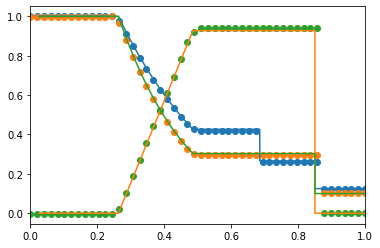

In [129]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x[:],u_pred[:,0])
ax.scatter(x[:],u_pred[:,1])
ax.scatter(x[:],u_pred[:,2])
ax.plot(Exact[:,0],Exact[:,1])
ax.plot(Exact[:,0],Exact[:,2])
ax.plot(Exact[:,0],Exact[:,3])
ax.set_xlim(0.0, 1.0)
#ax.set_ylim(0.2, 1.2)
plt.show()

In [9]:
Exact = np.loadtxt('sode.dat')
Exact[:,0]

array([0.02671362, 0.02789683, 0.02908005, ..., 1.19560583, 1.19735798,
       1.19911014])

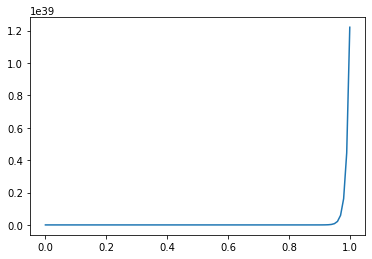

In [346]:
fig,ax = plt.subplots()
x = np.linspace(0,1,100)
#ax.plot(x,np.max([0.1-x,np.zeros_like(x)],axis=0))
#ax.plot(x,np.exp(100*(0.1-x))/ np.exp(100*(0.1)))
#ax.plot(x,np.exp(100*(-x)))
ax.plot(x,np.exp(100*(x-0.1)))
plt.show()

In [322]:
np.max([0.1-x,np.zeros_like(x)],axis=0)

array([0.1       , 0.08989899, 0.07979798, 0.06969697, 0.05959596,
       0.04949495, 0.03939394, 0.02929293, 0.01919192, 0.00909091,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [60]:
xp= x.flatten()[:,None]
rhop= u_pred[:,0].flatten()[:,None]
up= u_pred[:,1].flatten()[:,None]
pp= u_pred[:,2].flatten()[:,None]
uxy= np.hstack((xp,rhop,up,pp))    
np.savetxt('shockCrho.dat', uxy)

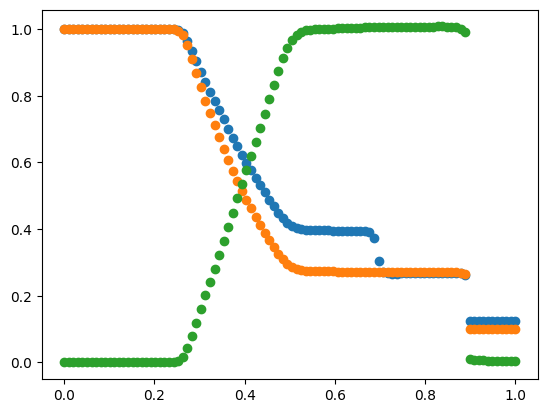

In [61]:
# first 15000step conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

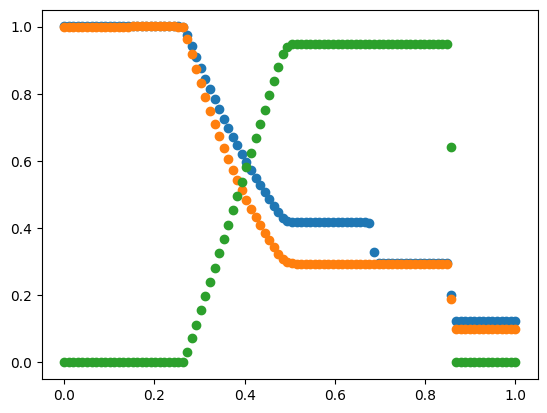

In [66]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()